<a href="https://colab.research.google.com/github/Nikhil-24K/GenerativeAI/blob/main/Lab_4_Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow-gpu
!pip install keras
!pip install python=opencv
!pip install matplotlib
!pip install numpy

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
ERROR: Invalid requirement: 'python=opencv'
Hint: = is not a valid operator. Did you mean == ?


Download the dataset from here:
https://drive.google.com/file/d/1lUmzcMUFJSF60DFMK5yKQClGqg9v8fcP/view?usp=sharing
And extract it into your working directory

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import numpy as np

In [4]:
!unzip "/content/Dataset.zip"

Archive:  /content/Dataset.zip
  inflating: images/abomasnow.png    
  inflating: images/abra.png         
  inflating: images/absol.png        
  inflating: images/accelgor.png     
  inflating: images/aegislash-blade.png  
  inflating: images/aerodactyl.png   
  inflating: images/aggron.png       
  inflating: images/aipom.png        
  inflating: images/alakazam.png     
  inflating: images/alomomola.png    
  inflating: images/altaria.png      
  inflating: images/amaura.png       
  inflating: images/ambipom.png      
  inflating: images/amoonguss.png    
  inflating: images/ampharos.png     
  inflating: images/anorith.png      
  inflating: images/araquanid.png    
  inflating: images/arbok.png        
  inflating: images/arcanine.png     
  inflating: images/arceus.png       
  inflating: images/archen.png       
  inflating: images/archeops.png     
  inflating: images/ariados.png      
  inflating: images/armaldo.png      
  inflating: images/aromatisse.png   
  inflating: im

In [22]:
image_dir = "/content/images"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
images[:2]

['/content/images/samurott.png', '/content/images/emboar.png']

In [32]:
def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)

    # Ensure 3 channels
    if image.shape[-1] != 3:
        # If the image has 4 channels, remove the alpha channel
        image = image[:,:,:3]

    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    return image


In [33]:
batch_size = 128

training_dataset = tf.data.Dataset.from_tensor_slices((images))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

In [34]:
len(training_dataset)

7

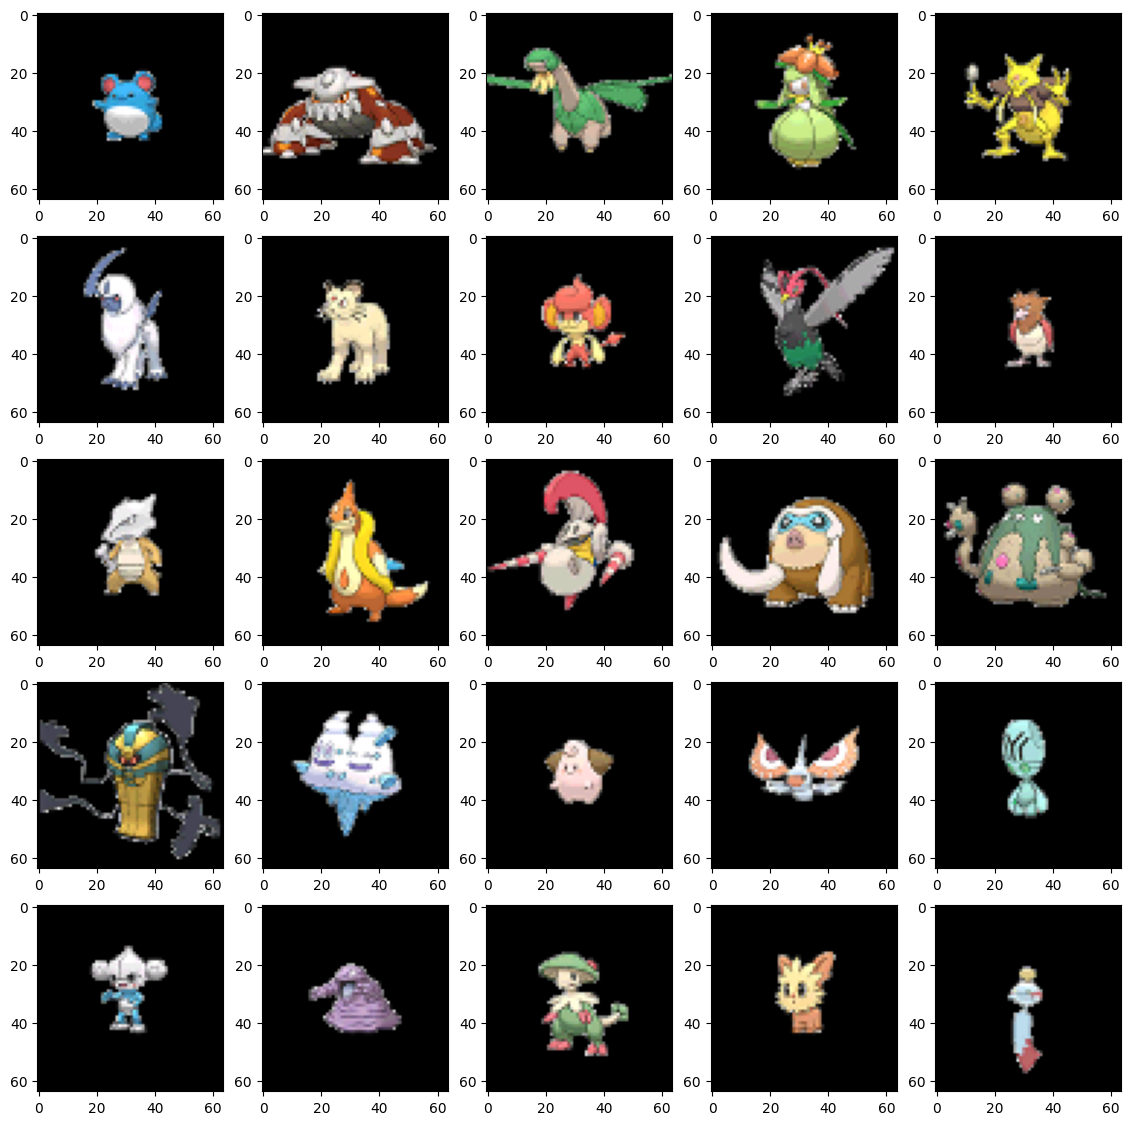

In [35]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

In [36]:
# build the model

latent_dim = 512

In [37]:
from keras.models import Sequential, Model

from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from keras.layers import LeakyReLU
from keras.activations import selu
from keras.layers import Multiply, Add
from keras.optimizers import Adam

from keras import backend as K

In [38]:
K.clear_session()

In [39]:
encoder_input = Input(shape = (64,64,3))

x = Conv2D(32, kernel_size=5, activation = LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [64,128,256,512]
for i in filter_size:
    x = Conv2D(i, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

# sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           2432      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           51264     ['batch_normalization[0]

In [40]:
# build the decoder

decoder = Sequential()
decoder.add(Dense(1024, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((4,4,512)))

decoder.add(Conv2DTranspose(256, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(3, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 8192)              8396800   
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         3277056   
 anspose)                                                        
                                                                 
 batch_normalization_7 (Bat  (None, 8, 8, 256)         1

In [41]:
# make loss function
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)

In [42]:
# conbine encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 512),                1380268   ['input_1[0][0]']             
                              (None, 512),                8                                       
                              (None, 512)]                                                        
                                                                                                  
 sequential (Sequential)     (None, 64, 64, 3)            1328302   ['encoder[0][2]']             
                                                          3                                     

In [43]:
# make a function to save images while learning
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "output/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

In [45]:
# train vae

from keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 100

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])

            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())

            kl = sum(model.losses)
            kl_losses.append(kl.numpy())

            train_loss = 0.01 * kl + mse_loss

            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if step % 10 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))

1/1 [==============================] - 0s 17ms/step
Epoch:  1
1/1 [==============================] - 0s 20ms/step
Epoch: 1 - Step: 0 - MSE loss: 0.0555186 - KL loss: 0.009476589
Epoch: 1 - Step: 1 - MSE loss: 0.054147515 - KL loss: 0.008911381
Epoch: 1 - Step: 2 - MSE loss: 0.051379085 - KL loss: 0.008160962
Epoch: 1 - Step: 3 - MSE loss: 0.05590632 - KL loss: 0.0076692747
Epoch: 1 - Step: 4 - MSE loss: 0.06261125 - KL loss: 0.0071293674
Epoch: 1 - Step: 5 - MSE loss: 0.059251174 - KL loss: 0.006814711
Epoch: 1 - Step: 6 - MSE loss: 0.056515843 - KL loss: 0.0064469953
Epoch:  2
1/1 [==============================] - 0s 28ms/step
Epoch: 2 - Step: 0 - MSE loss: 0.061875045 - KL loss: 0.0058205565
Epoch: 2 - Step: 1 - MSE loss: 0.053080875 - KL loss: 0.0055064224
Epoch: 2 - Step: 2 - MSE loss: 0.05409987 - KL loss: 0.005718494
Epoch: 2 - Step: 3 - MSE loss: 0.058897078 - KL loss: 0.0055471743
Epoch: 2 - Step: 4 - MSE loss: 0.052546095 - KL loss: 0.0068213246
Epoch: 2 - Step: 5 - MSE loss:

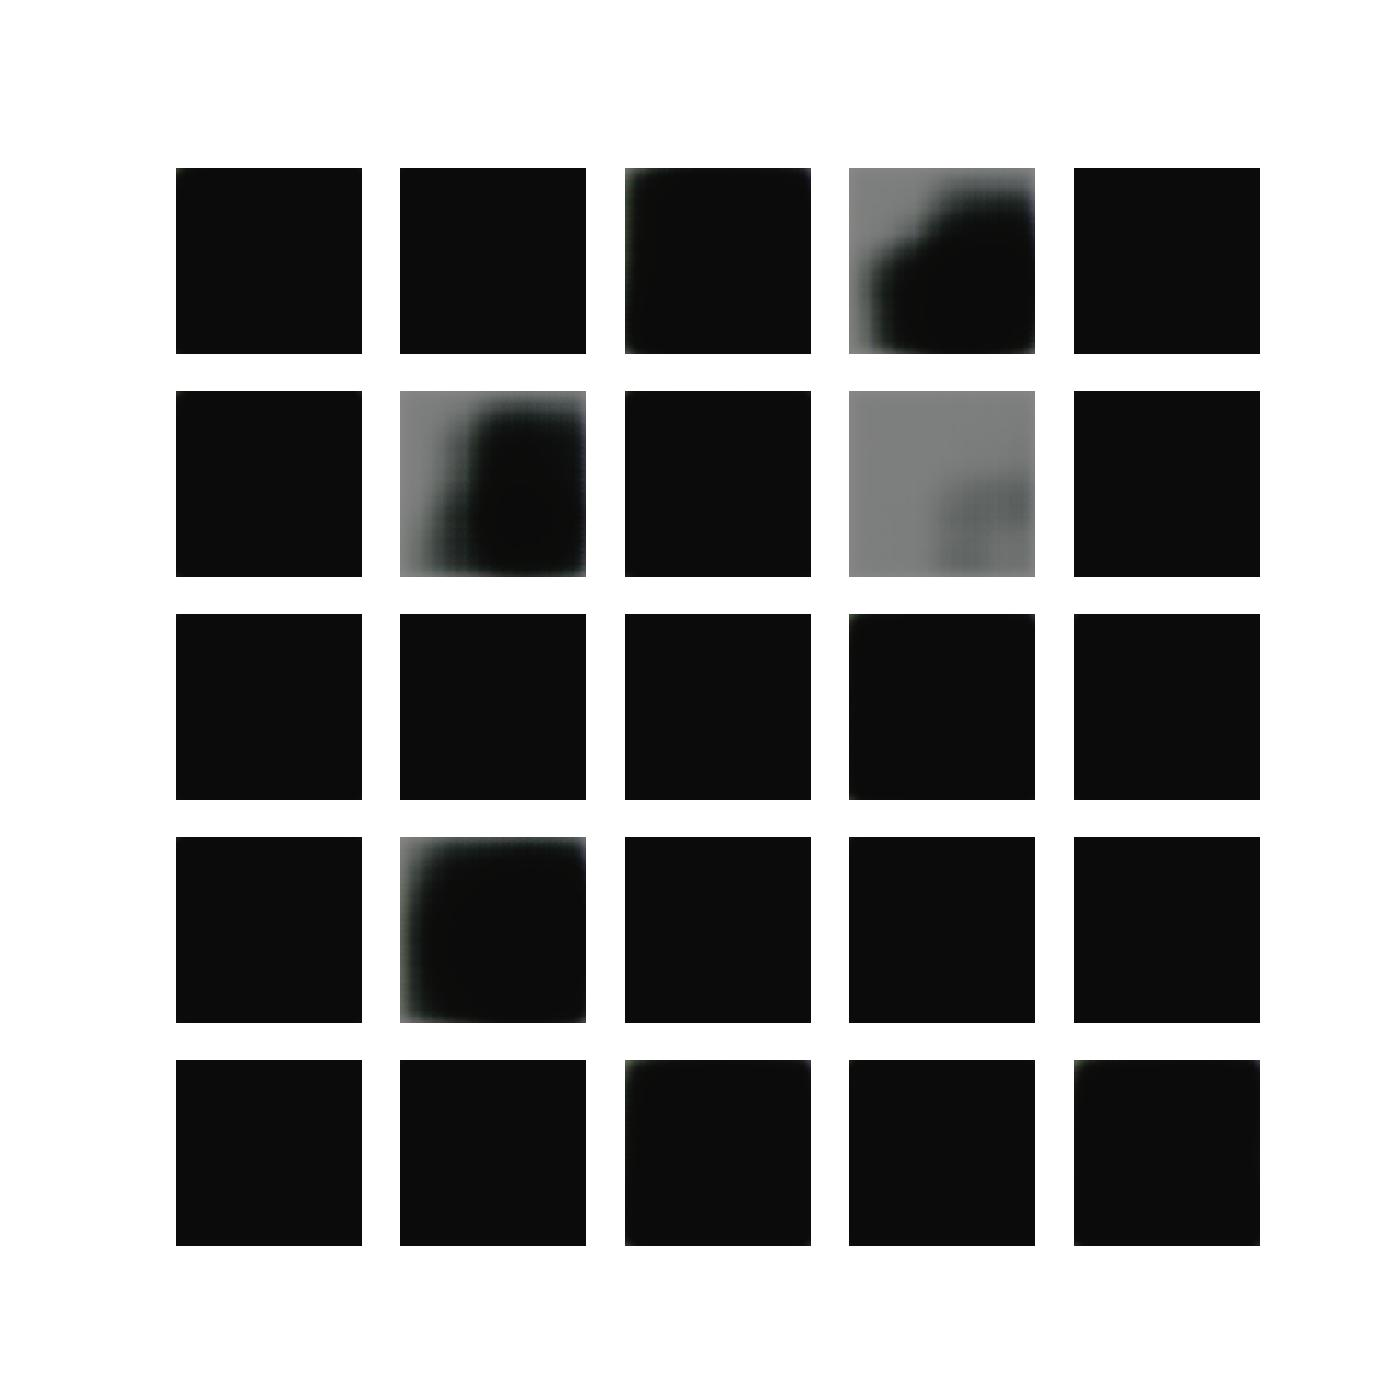

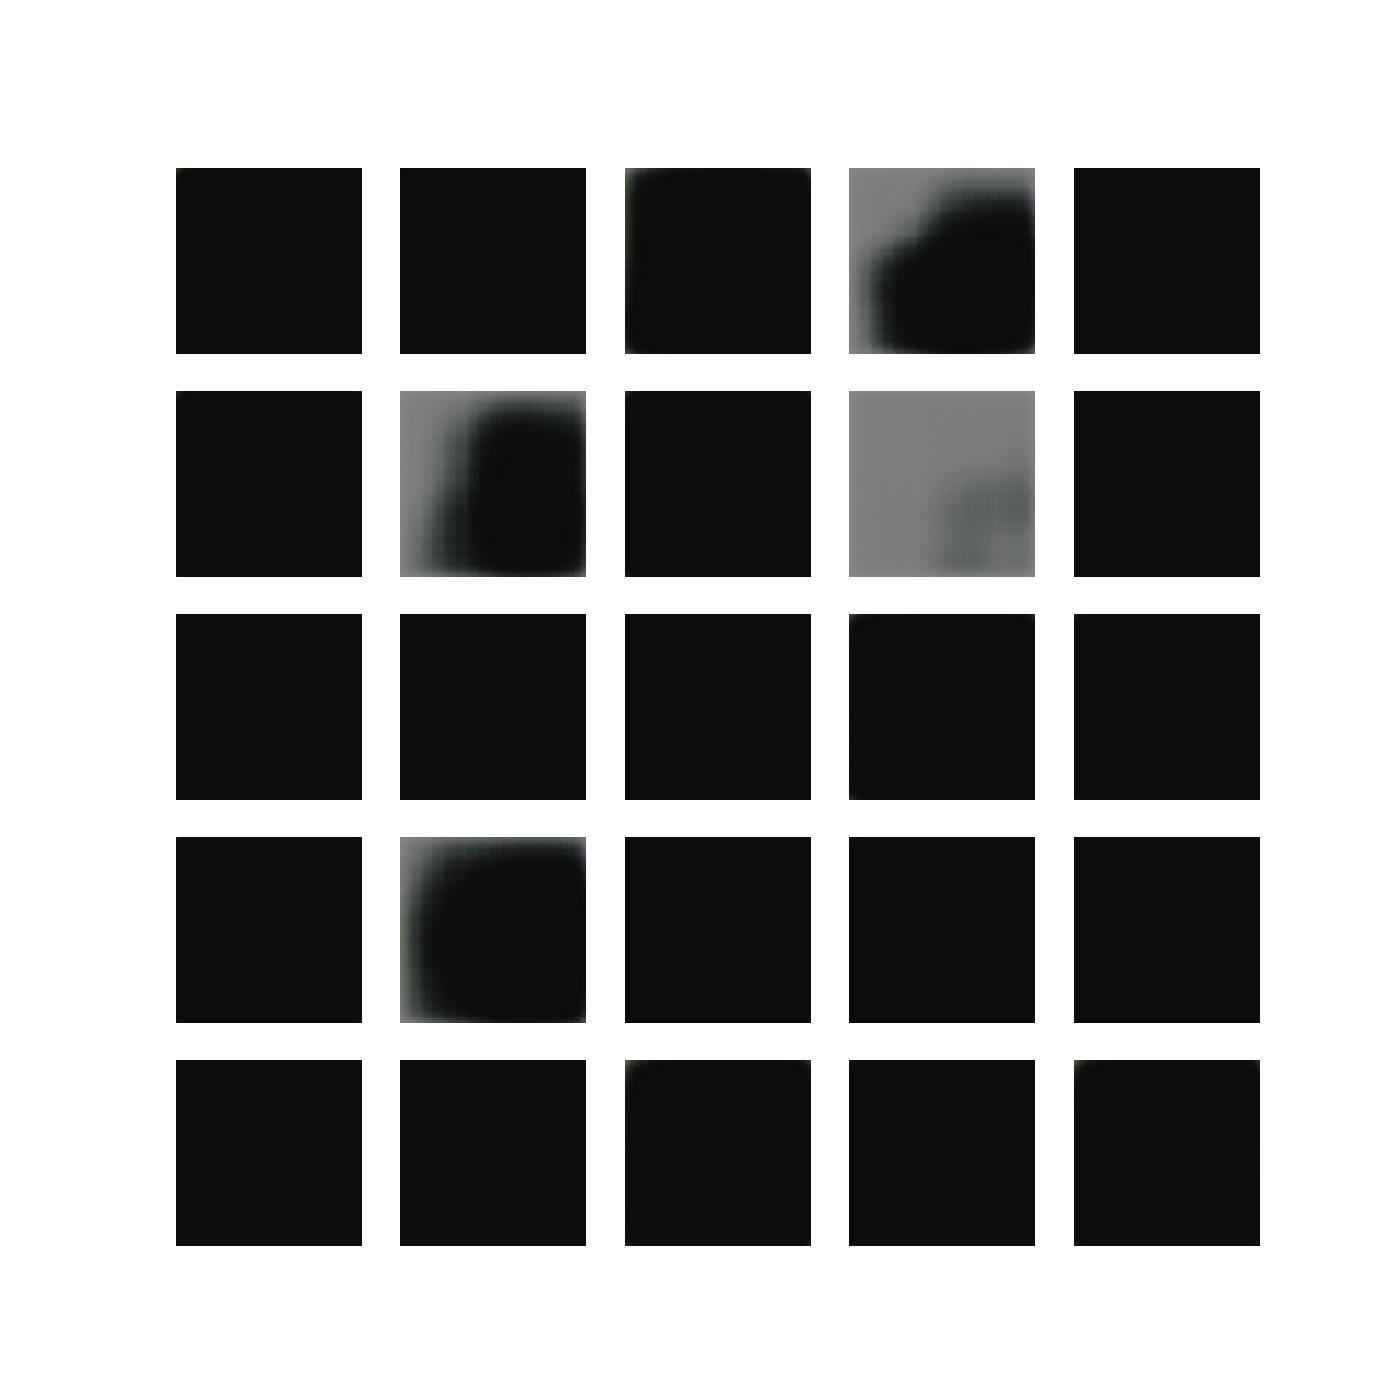

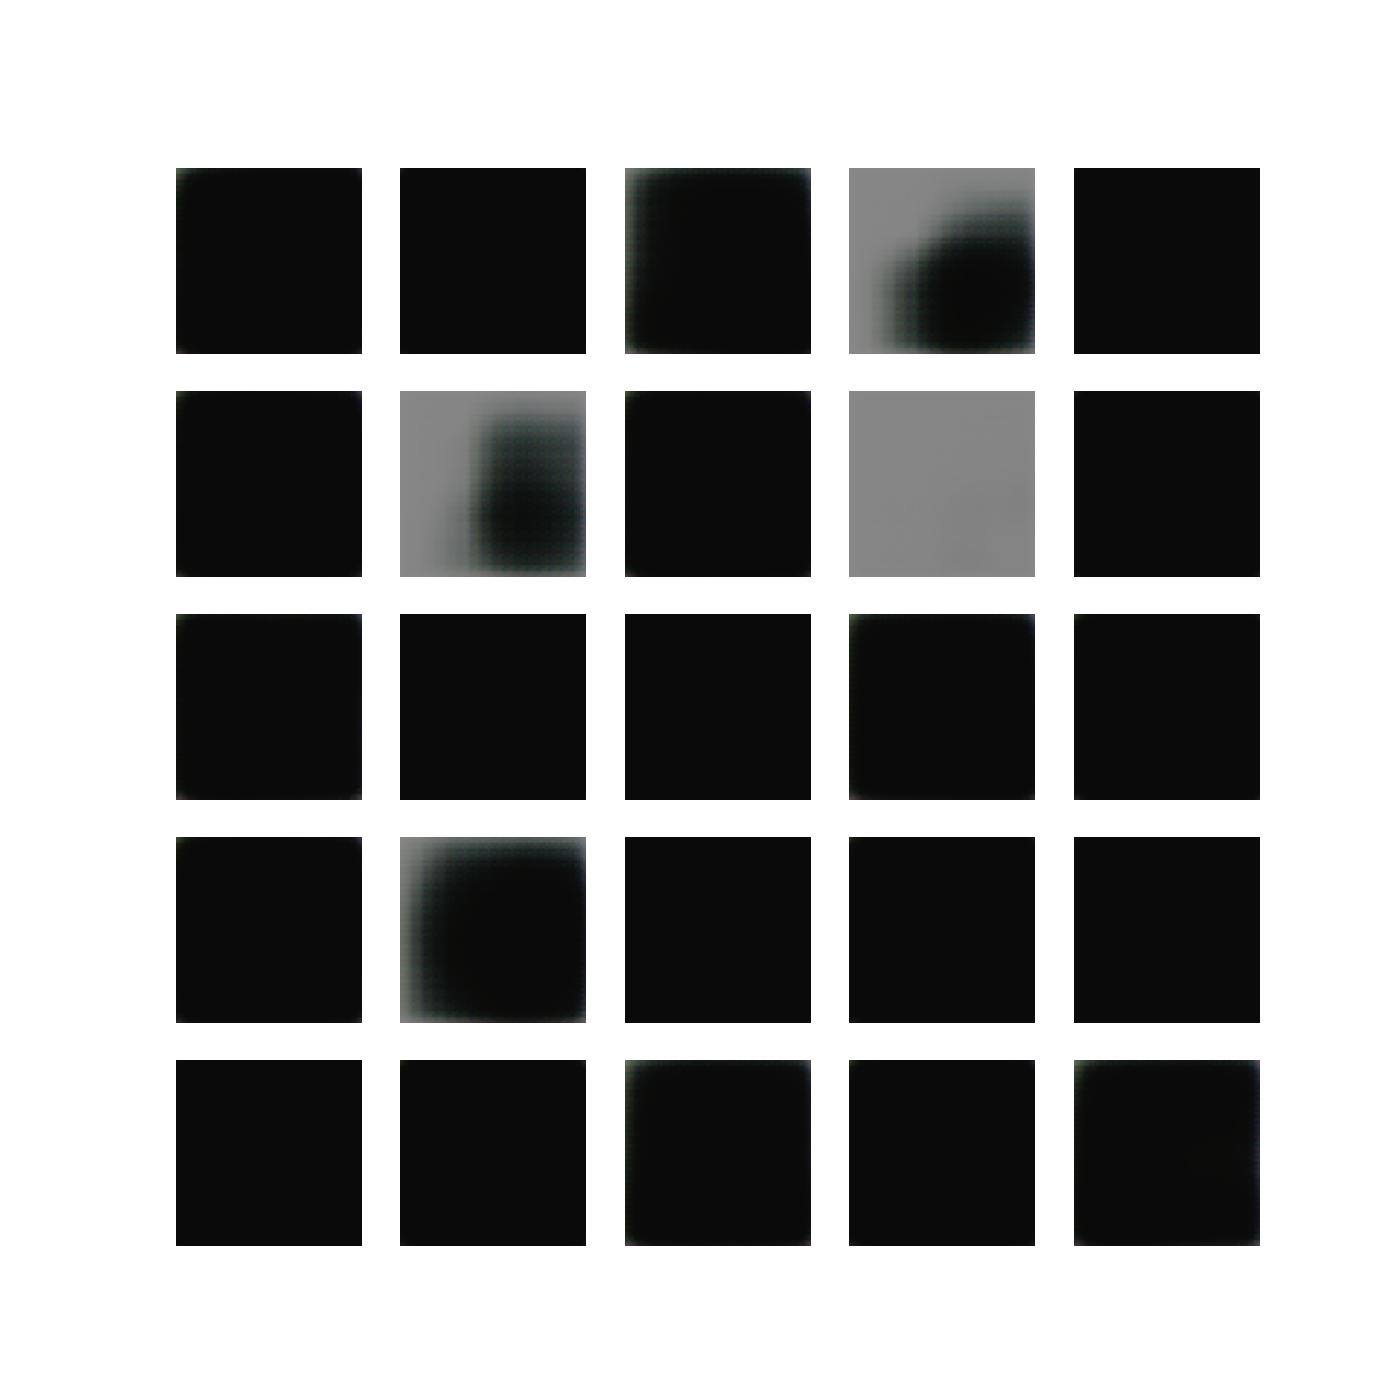

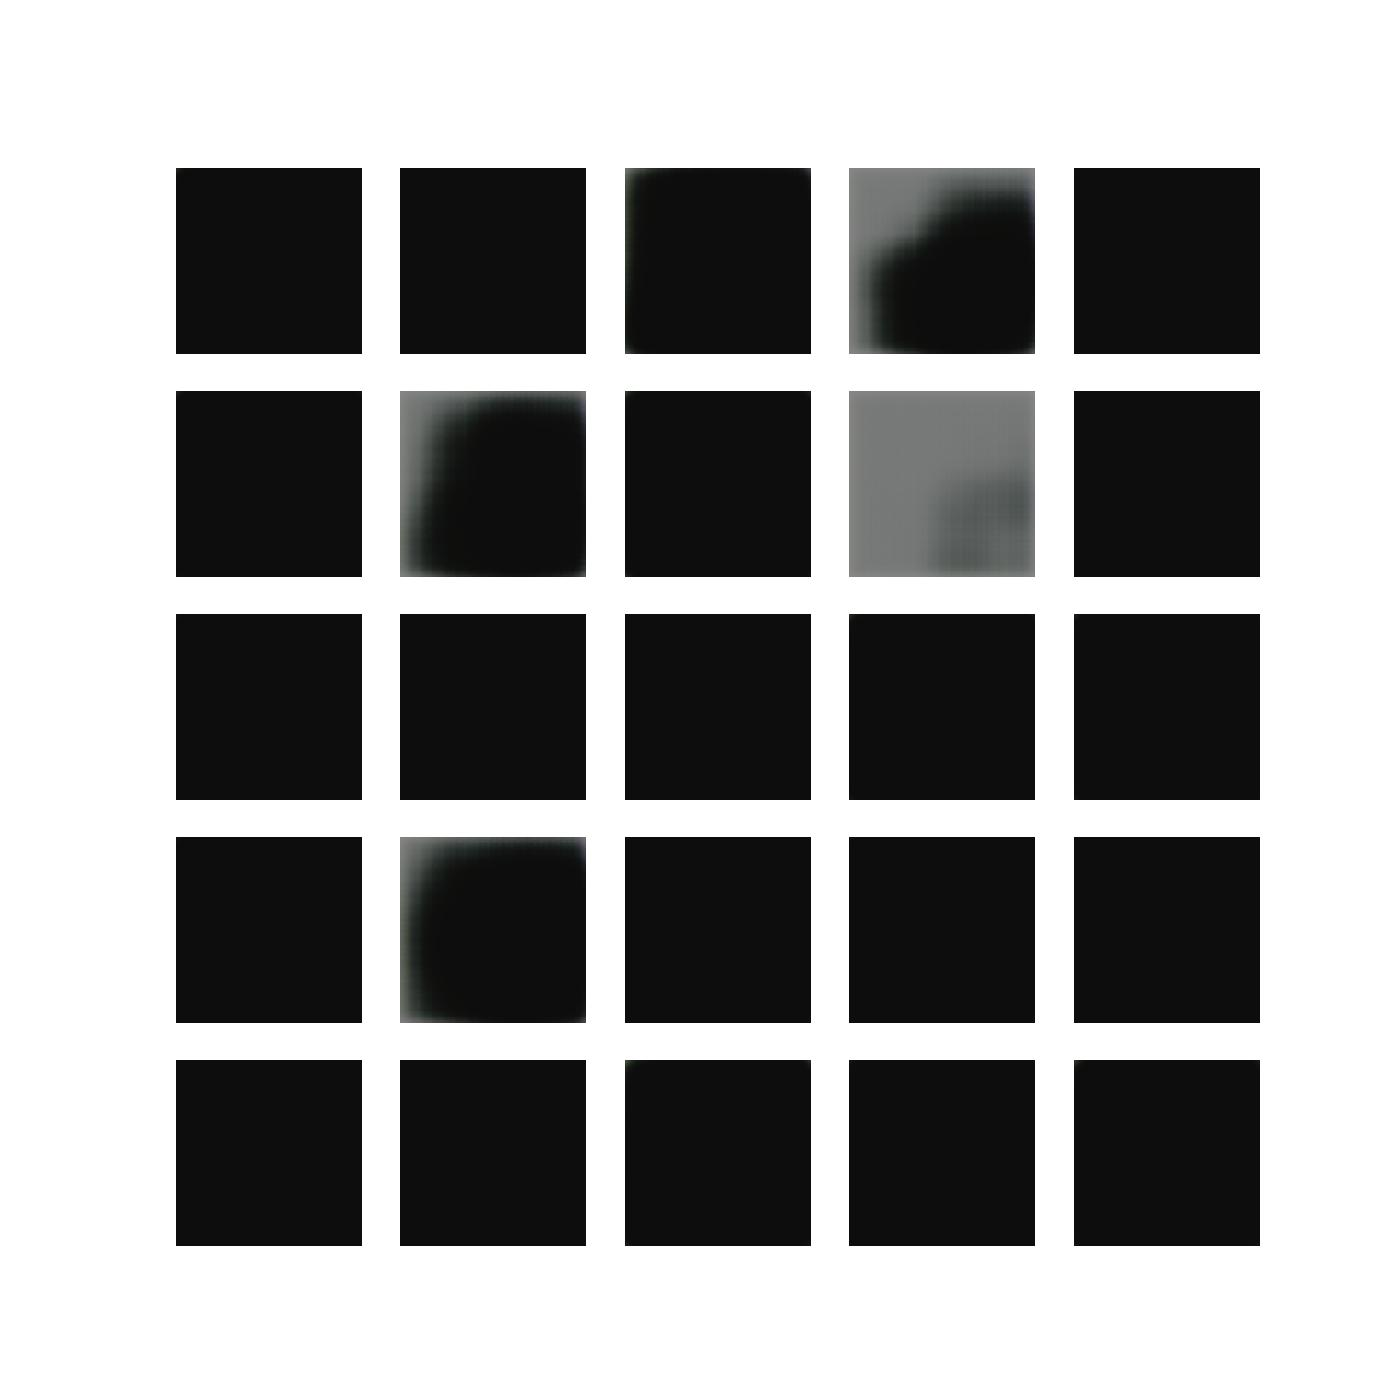

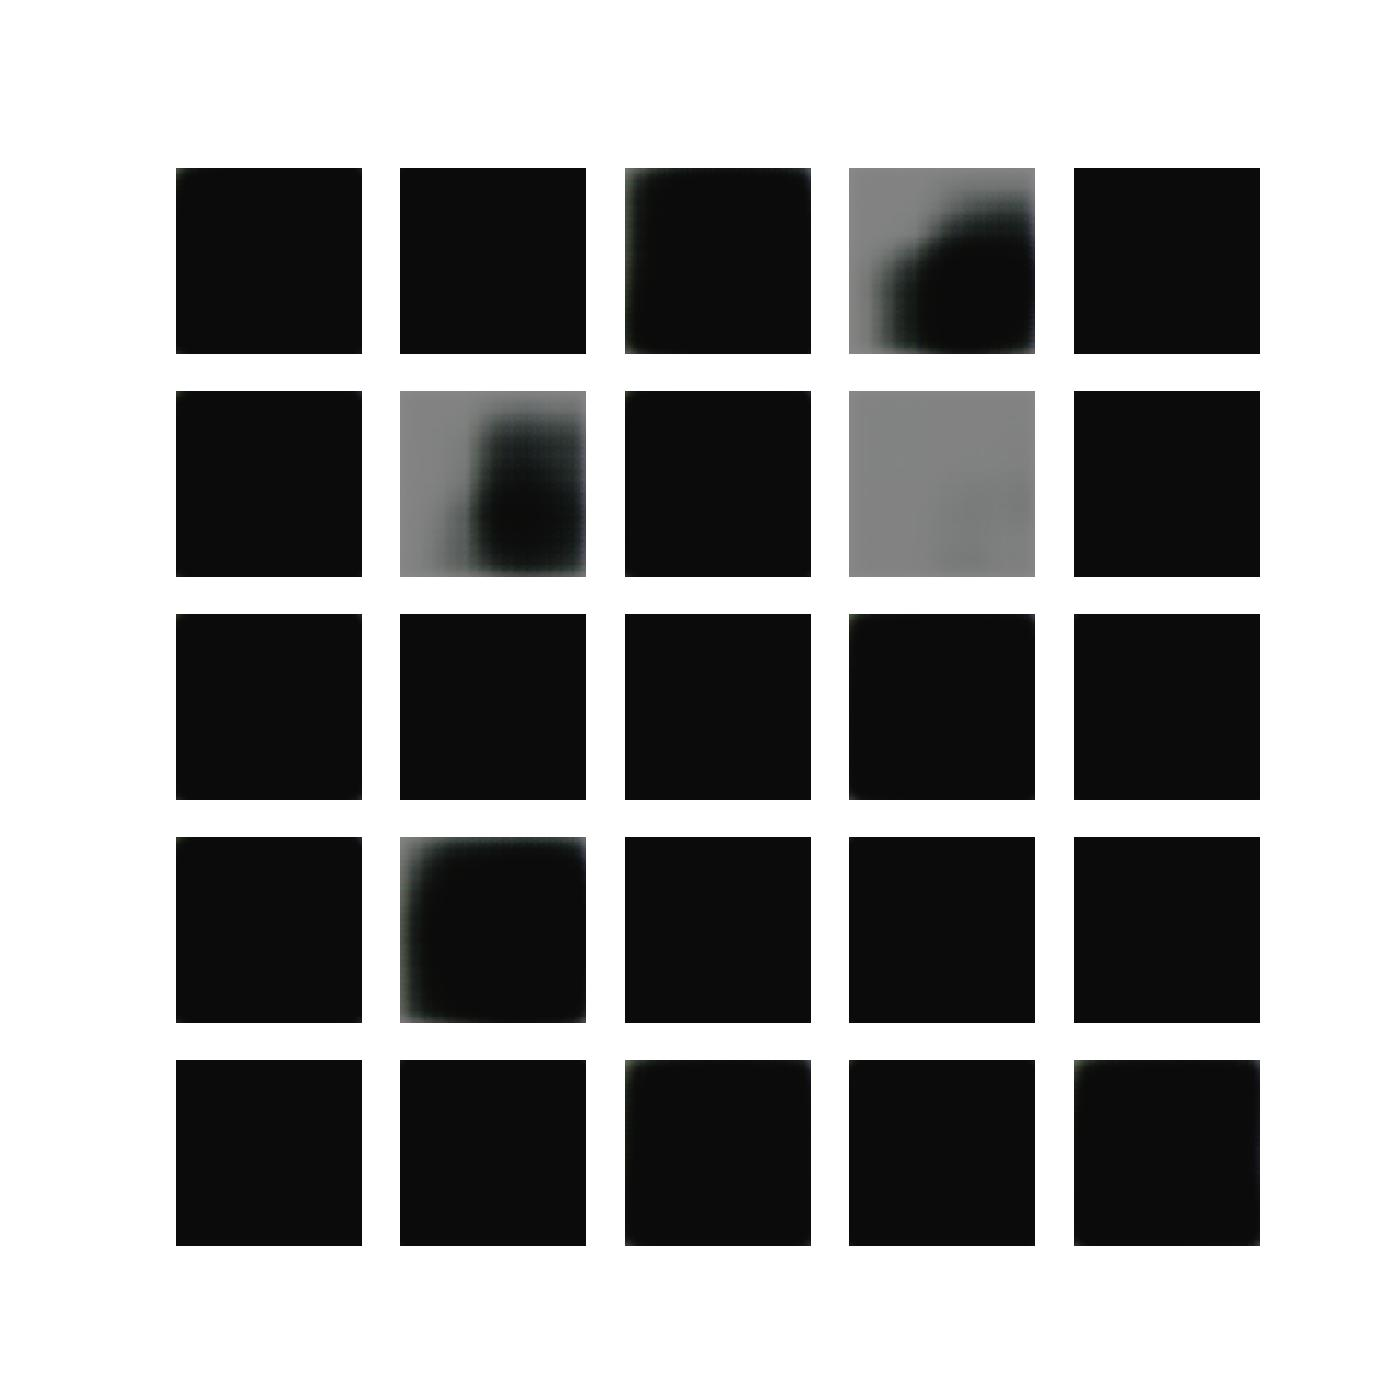

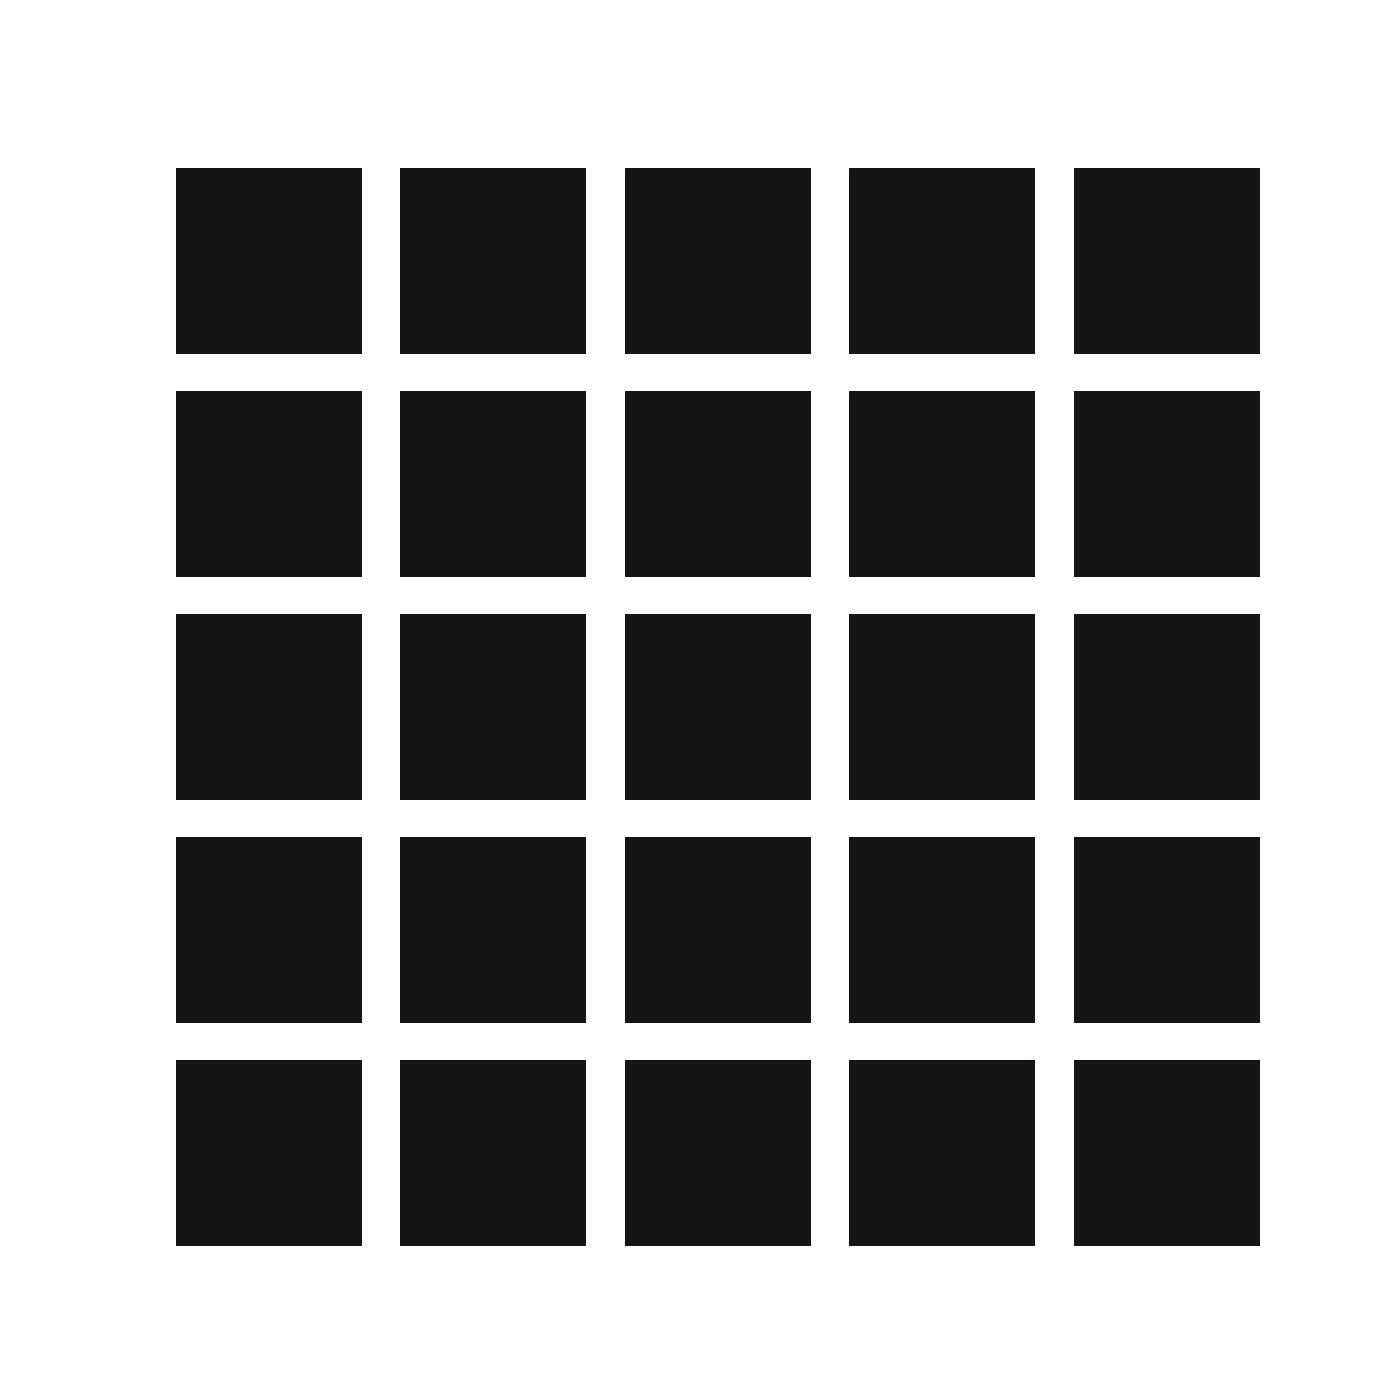

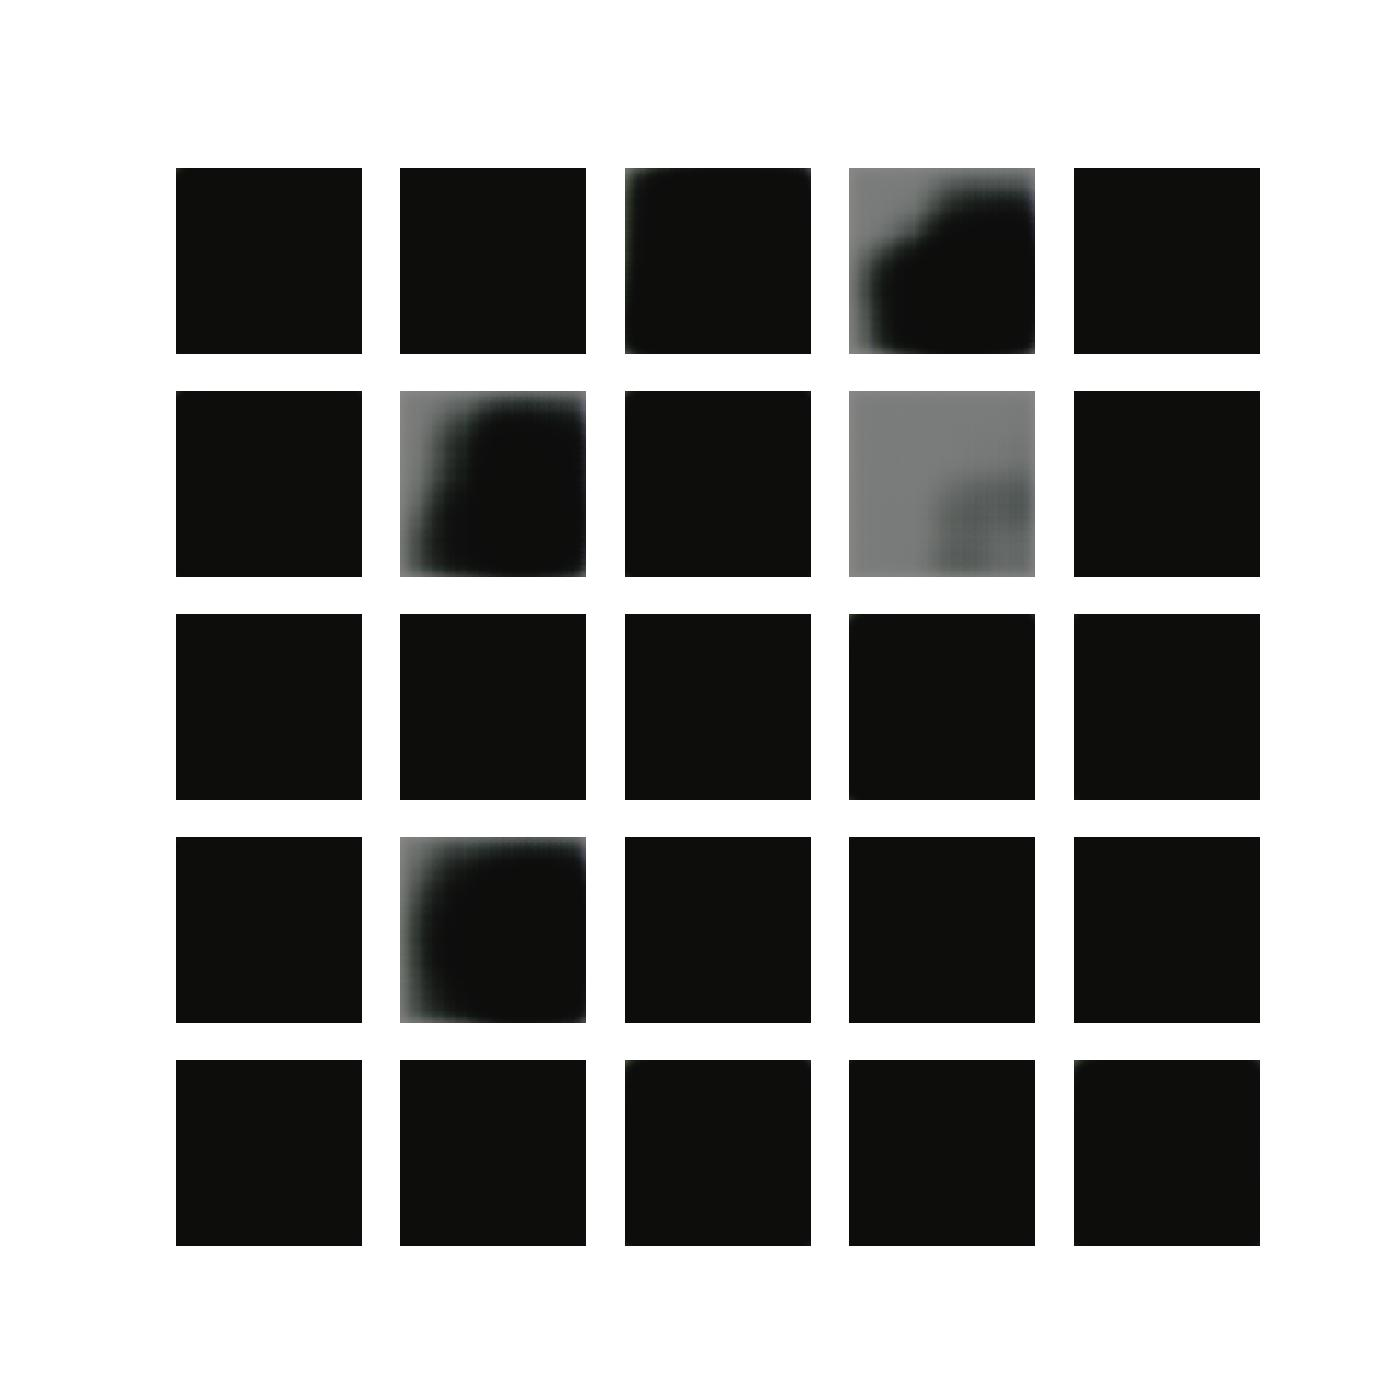

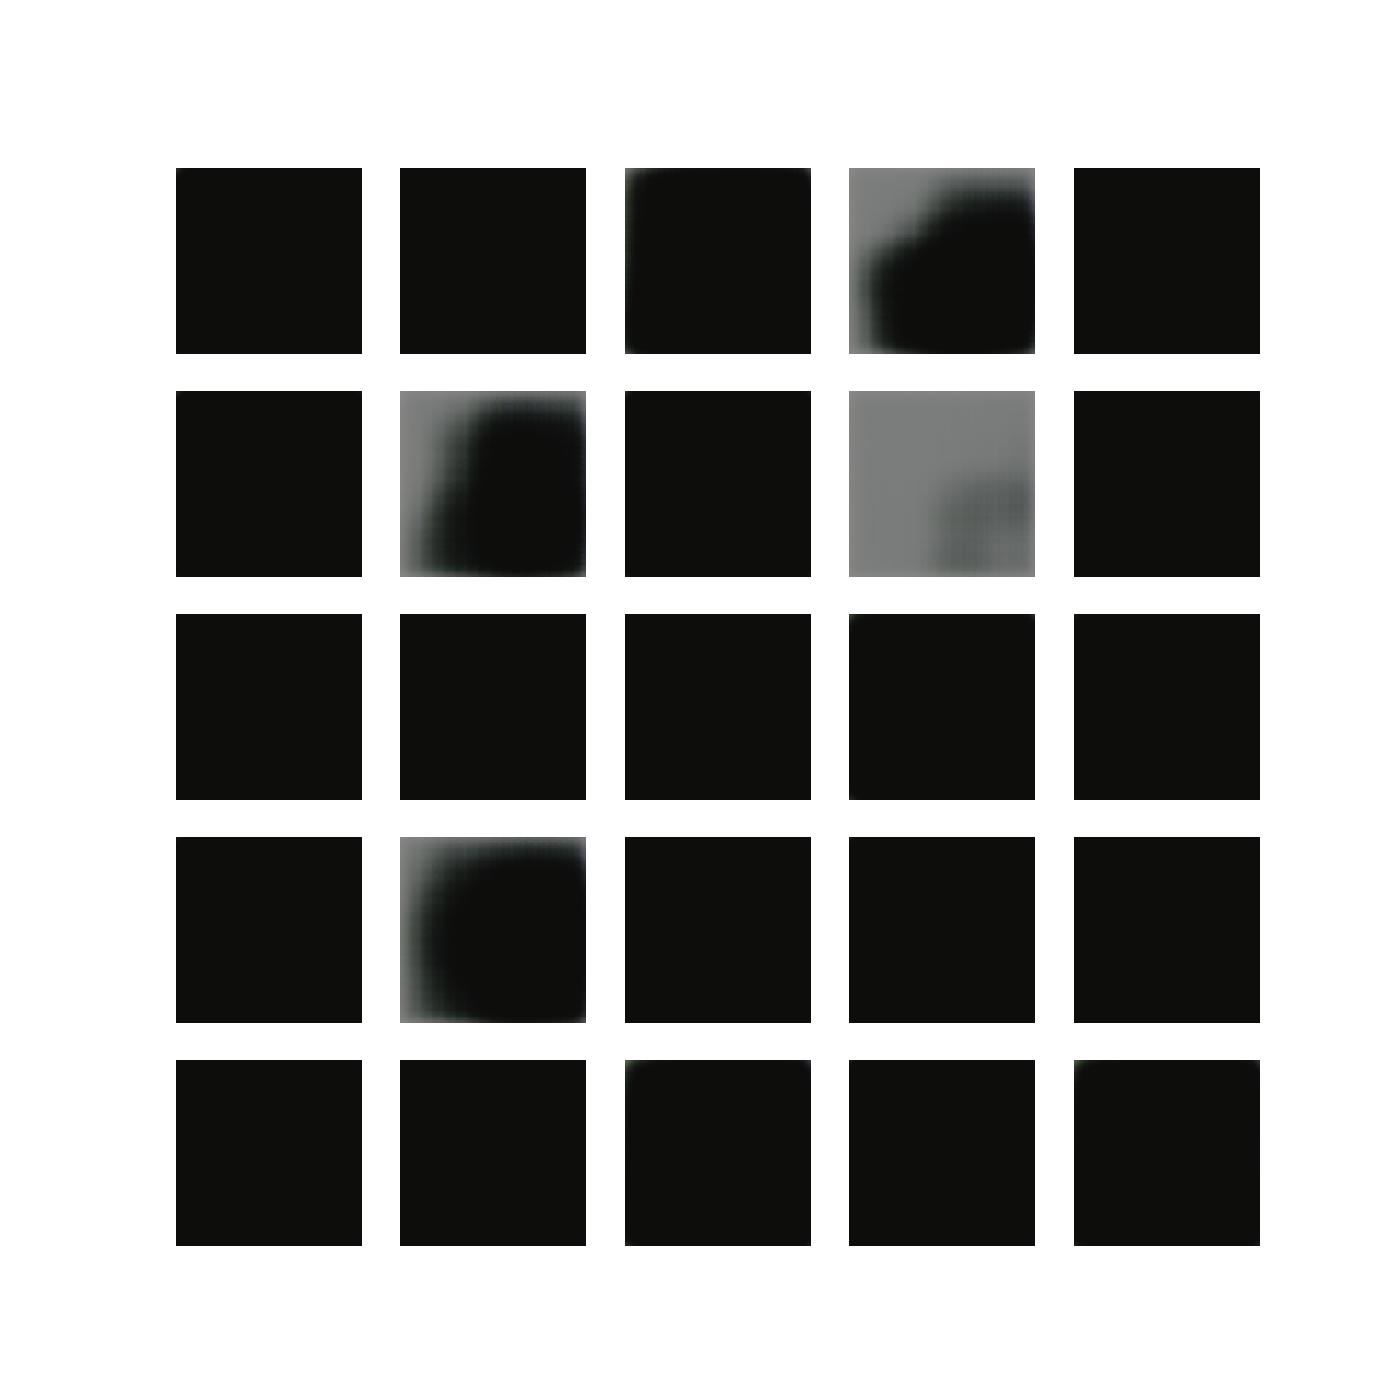

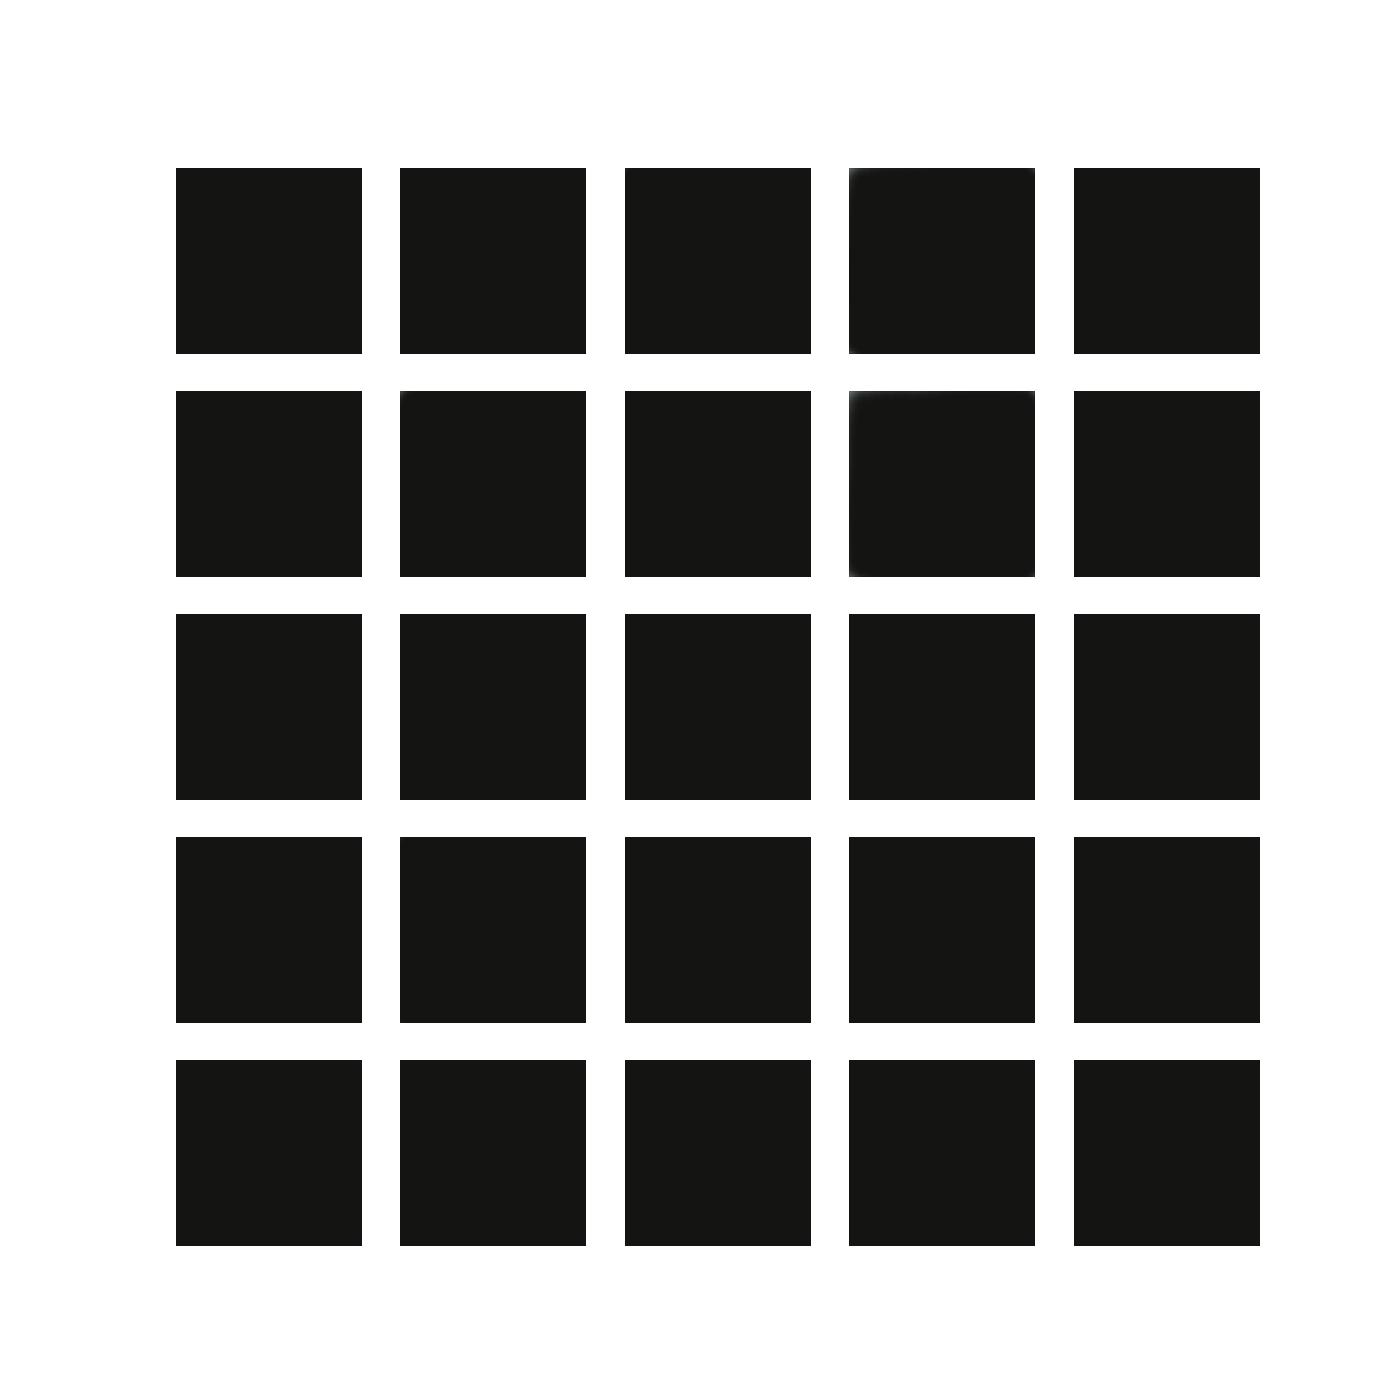

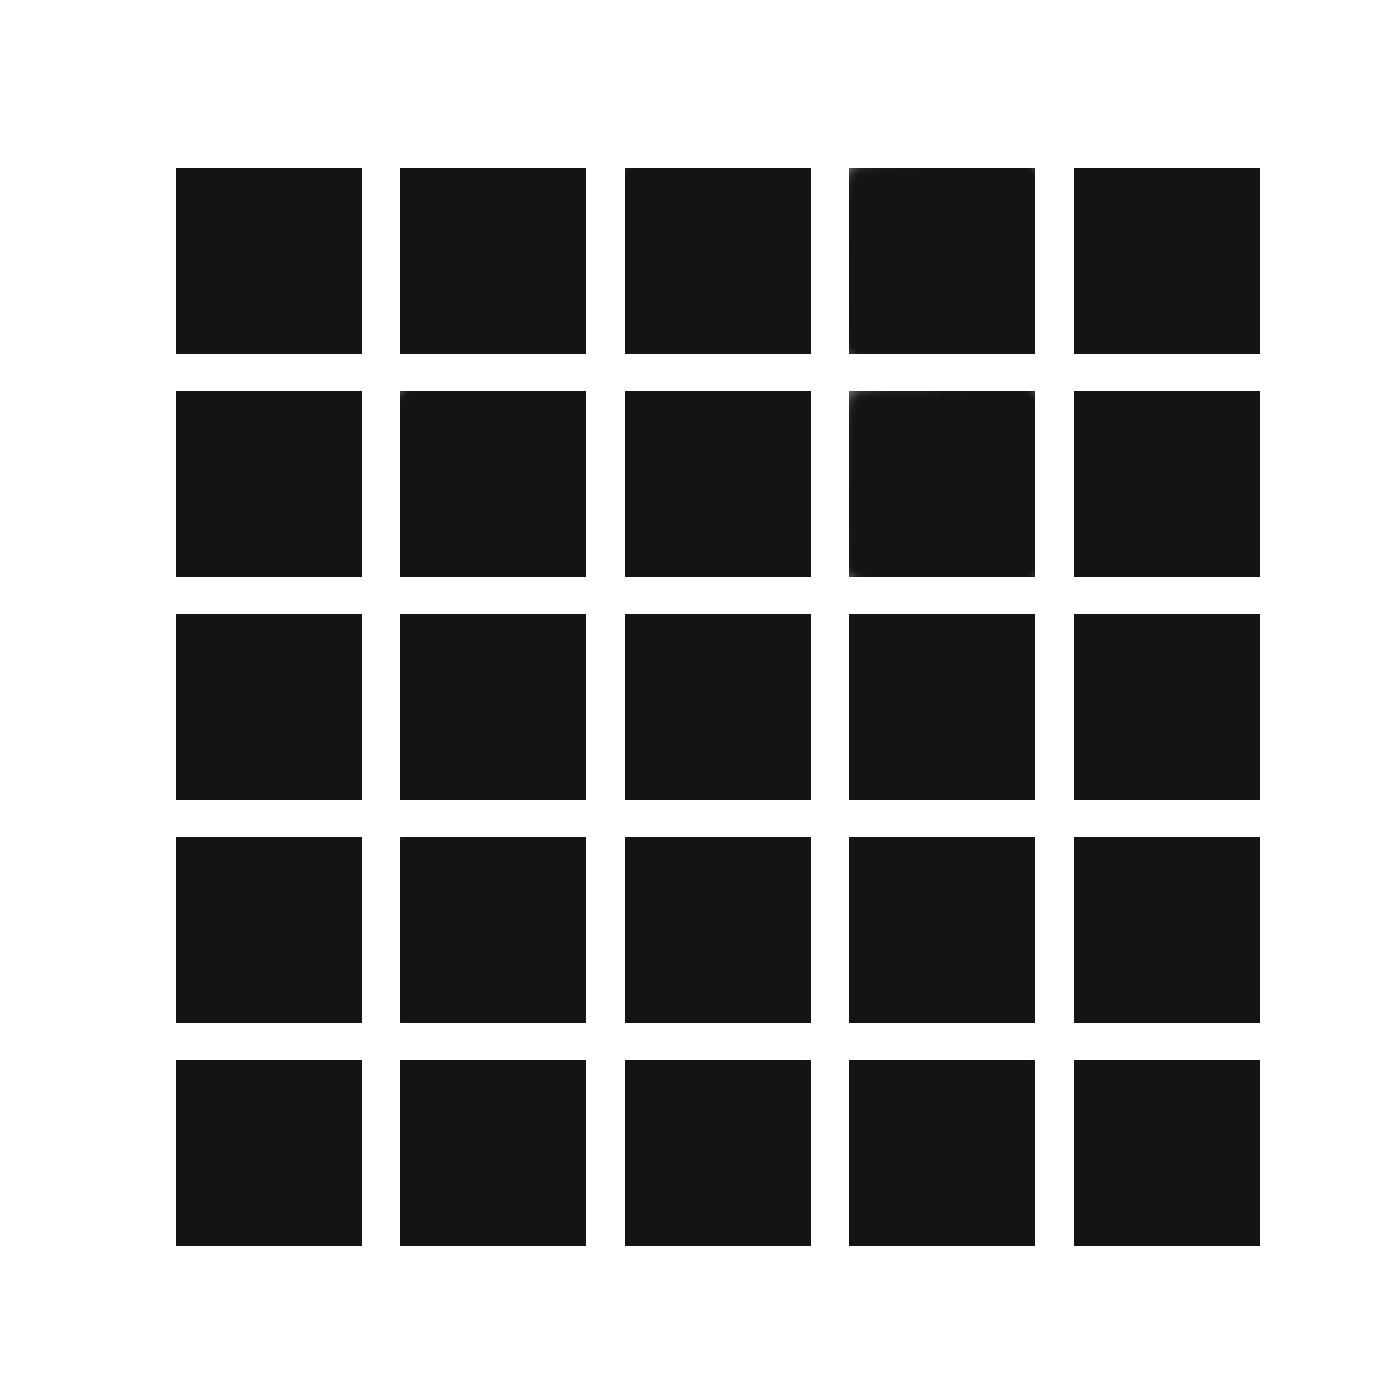

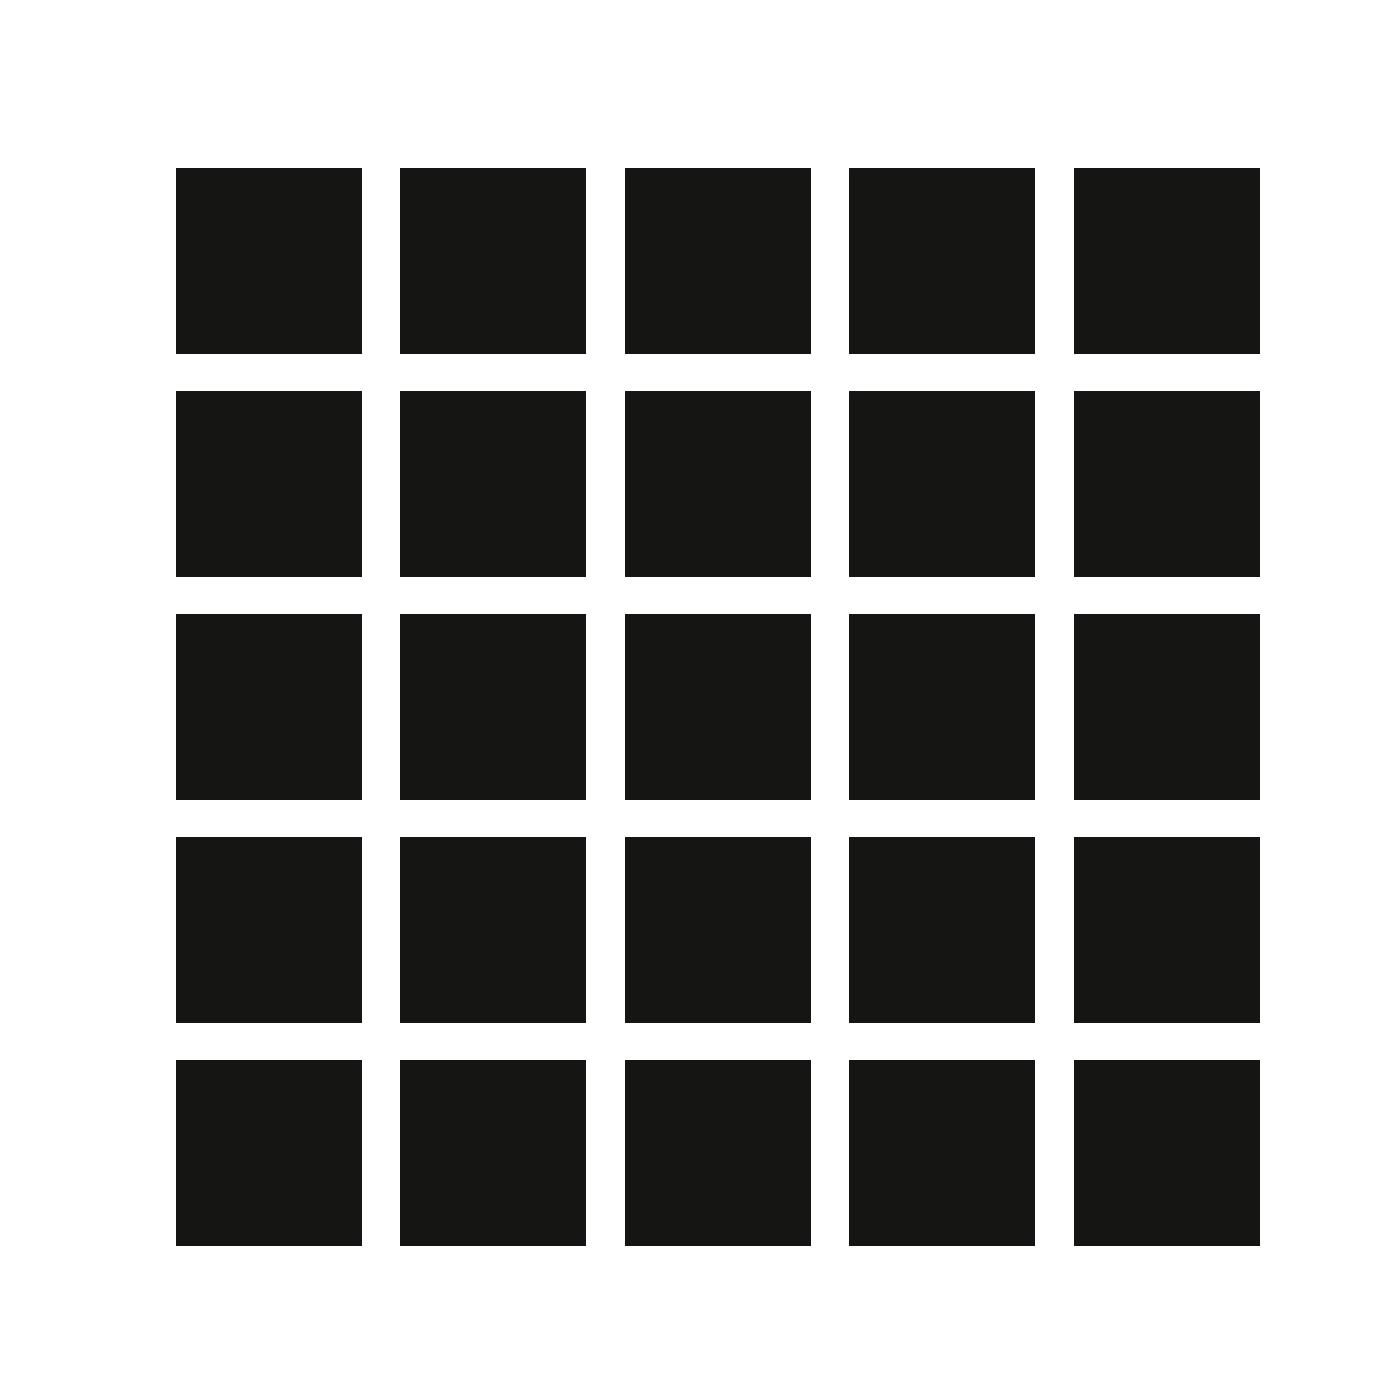

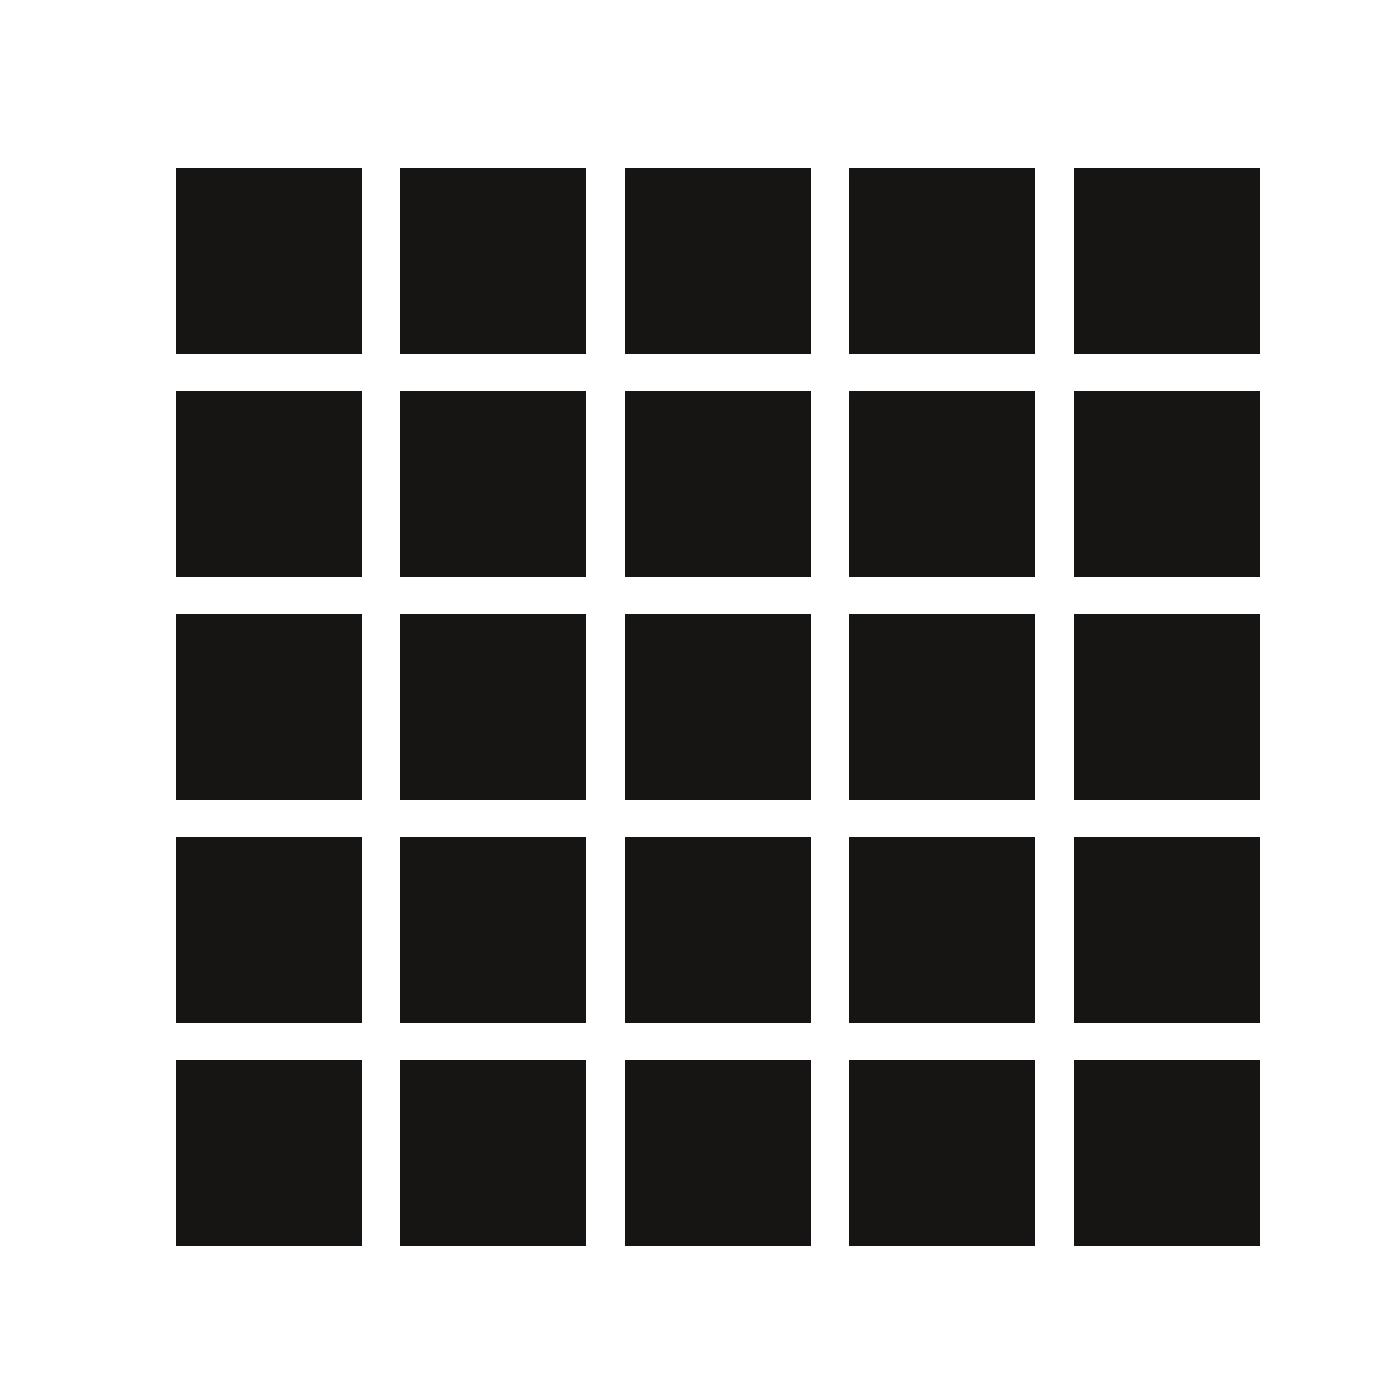

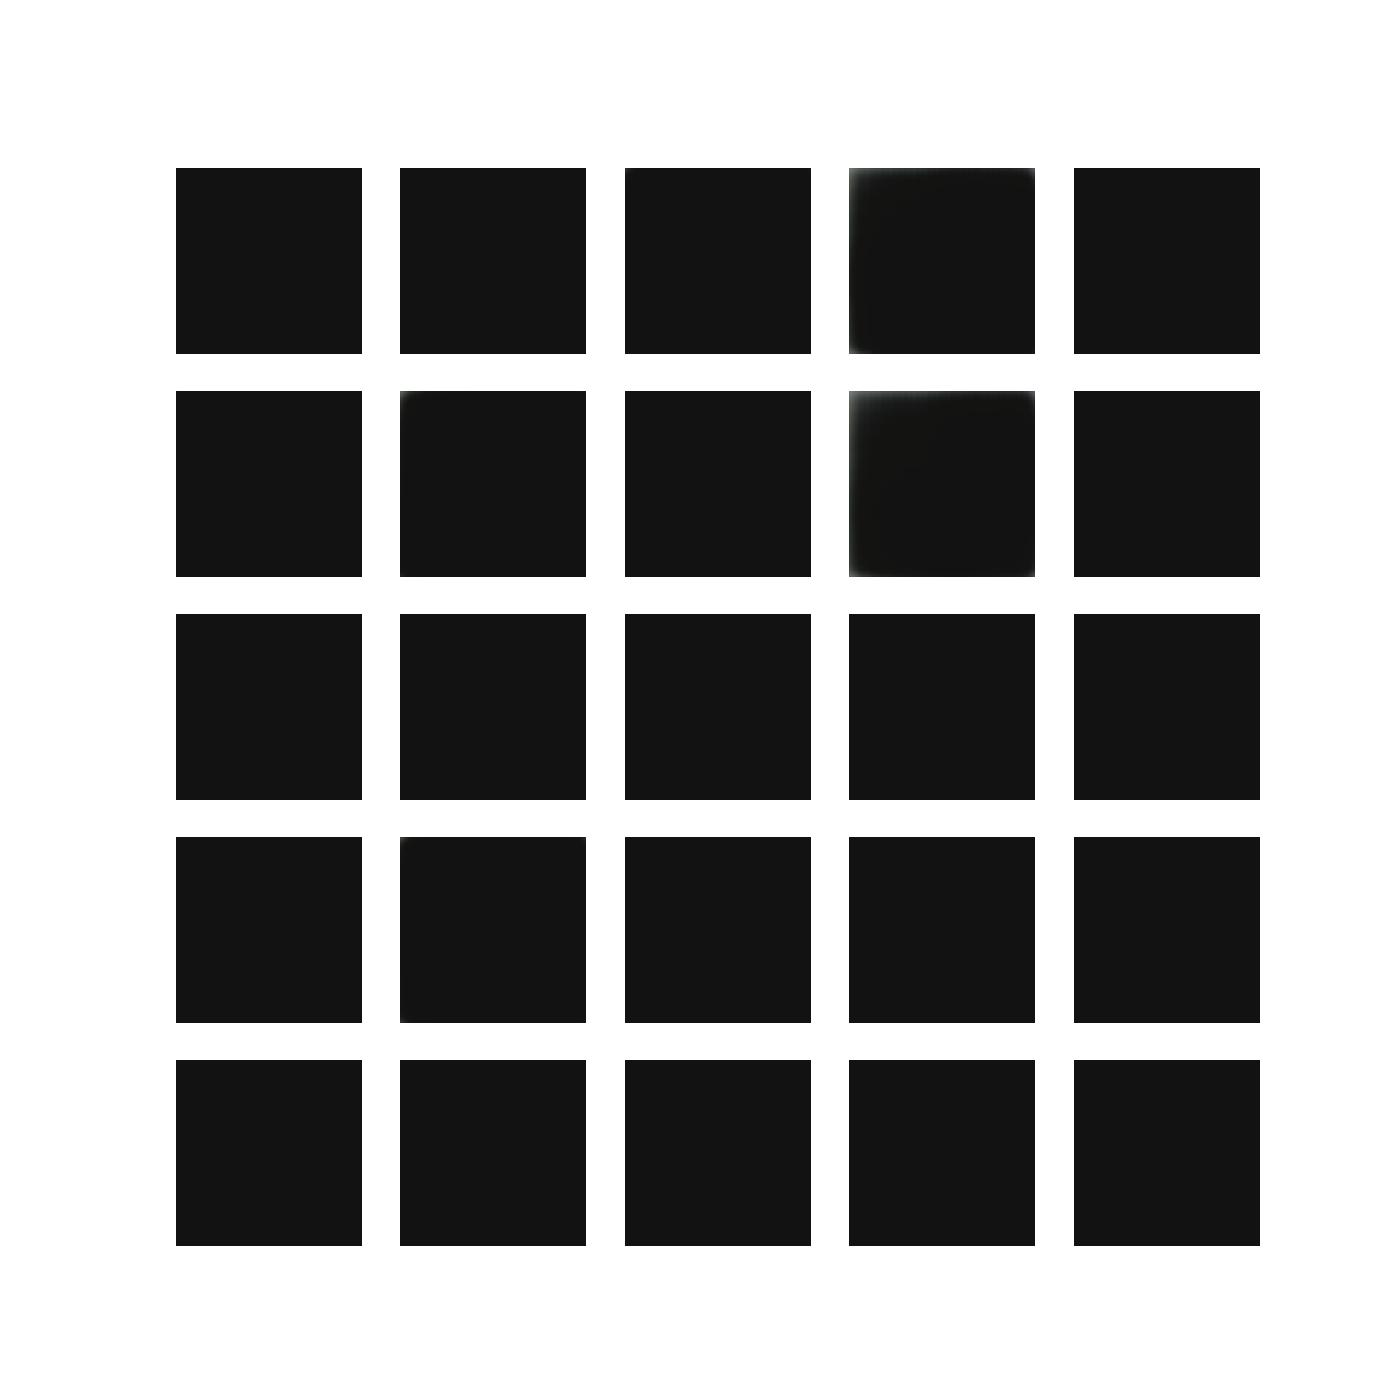

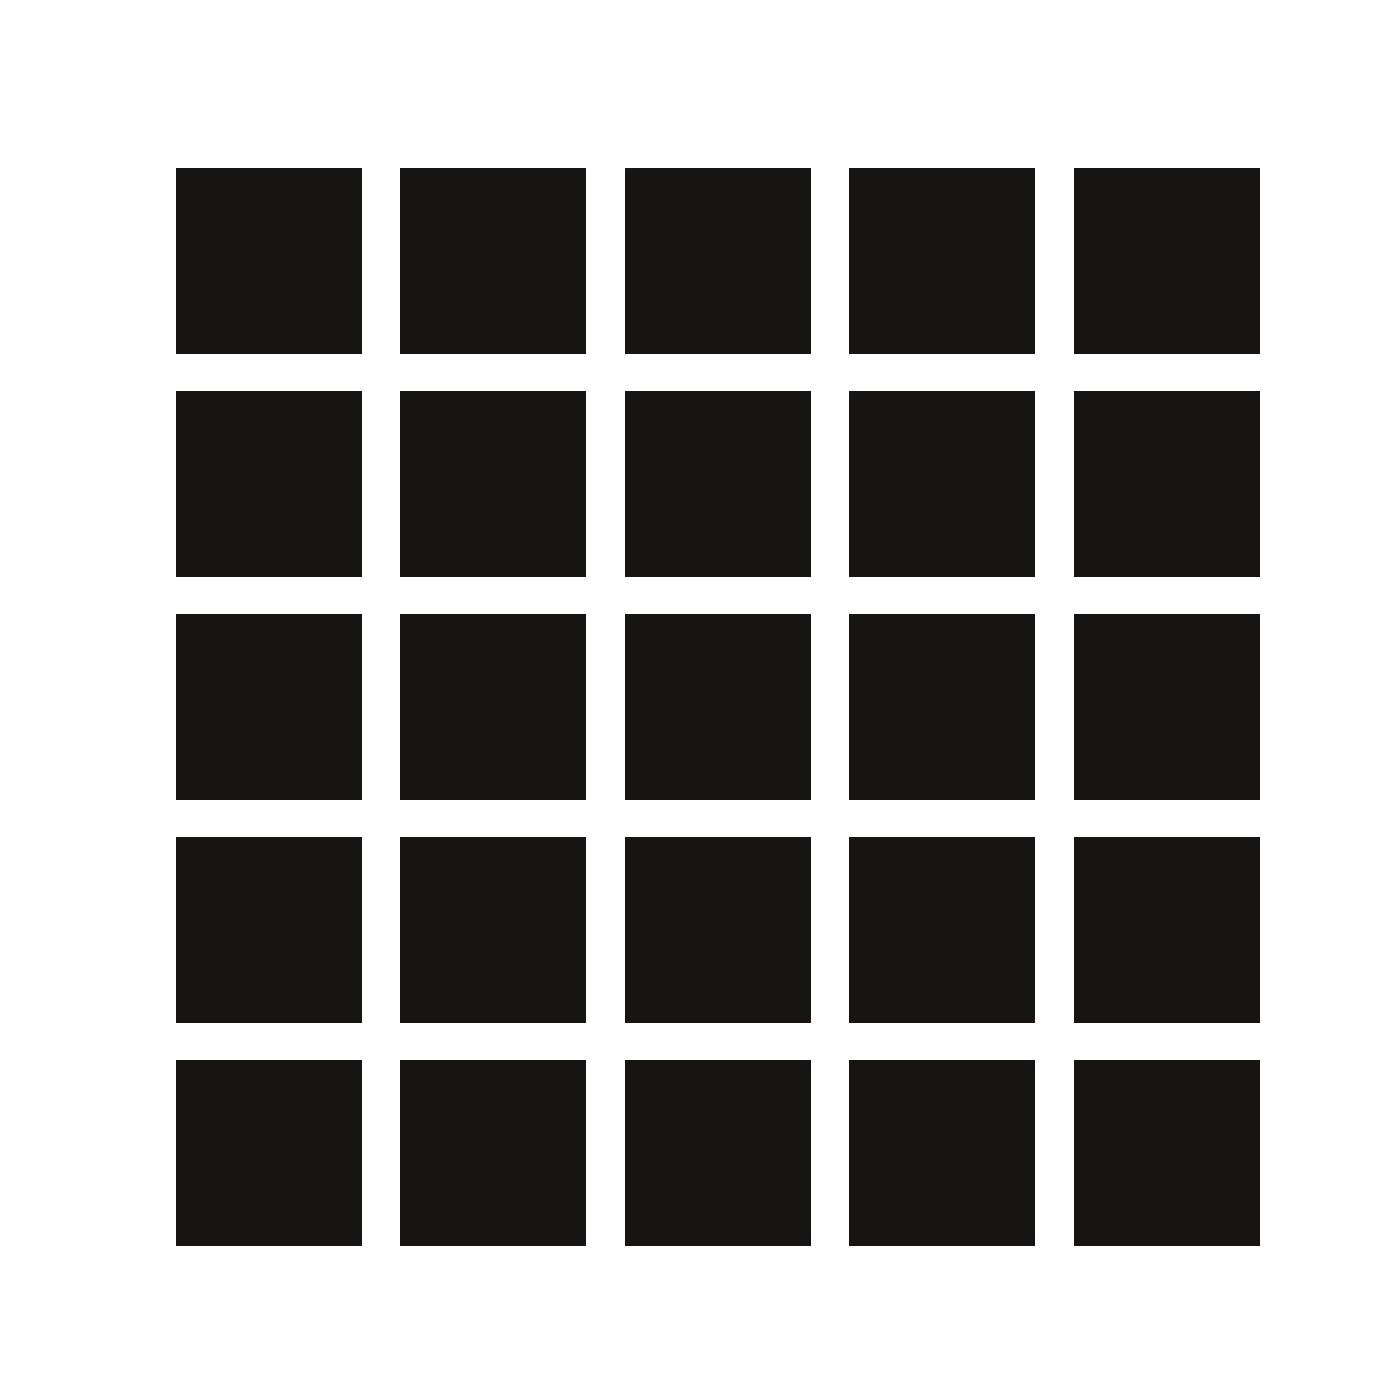

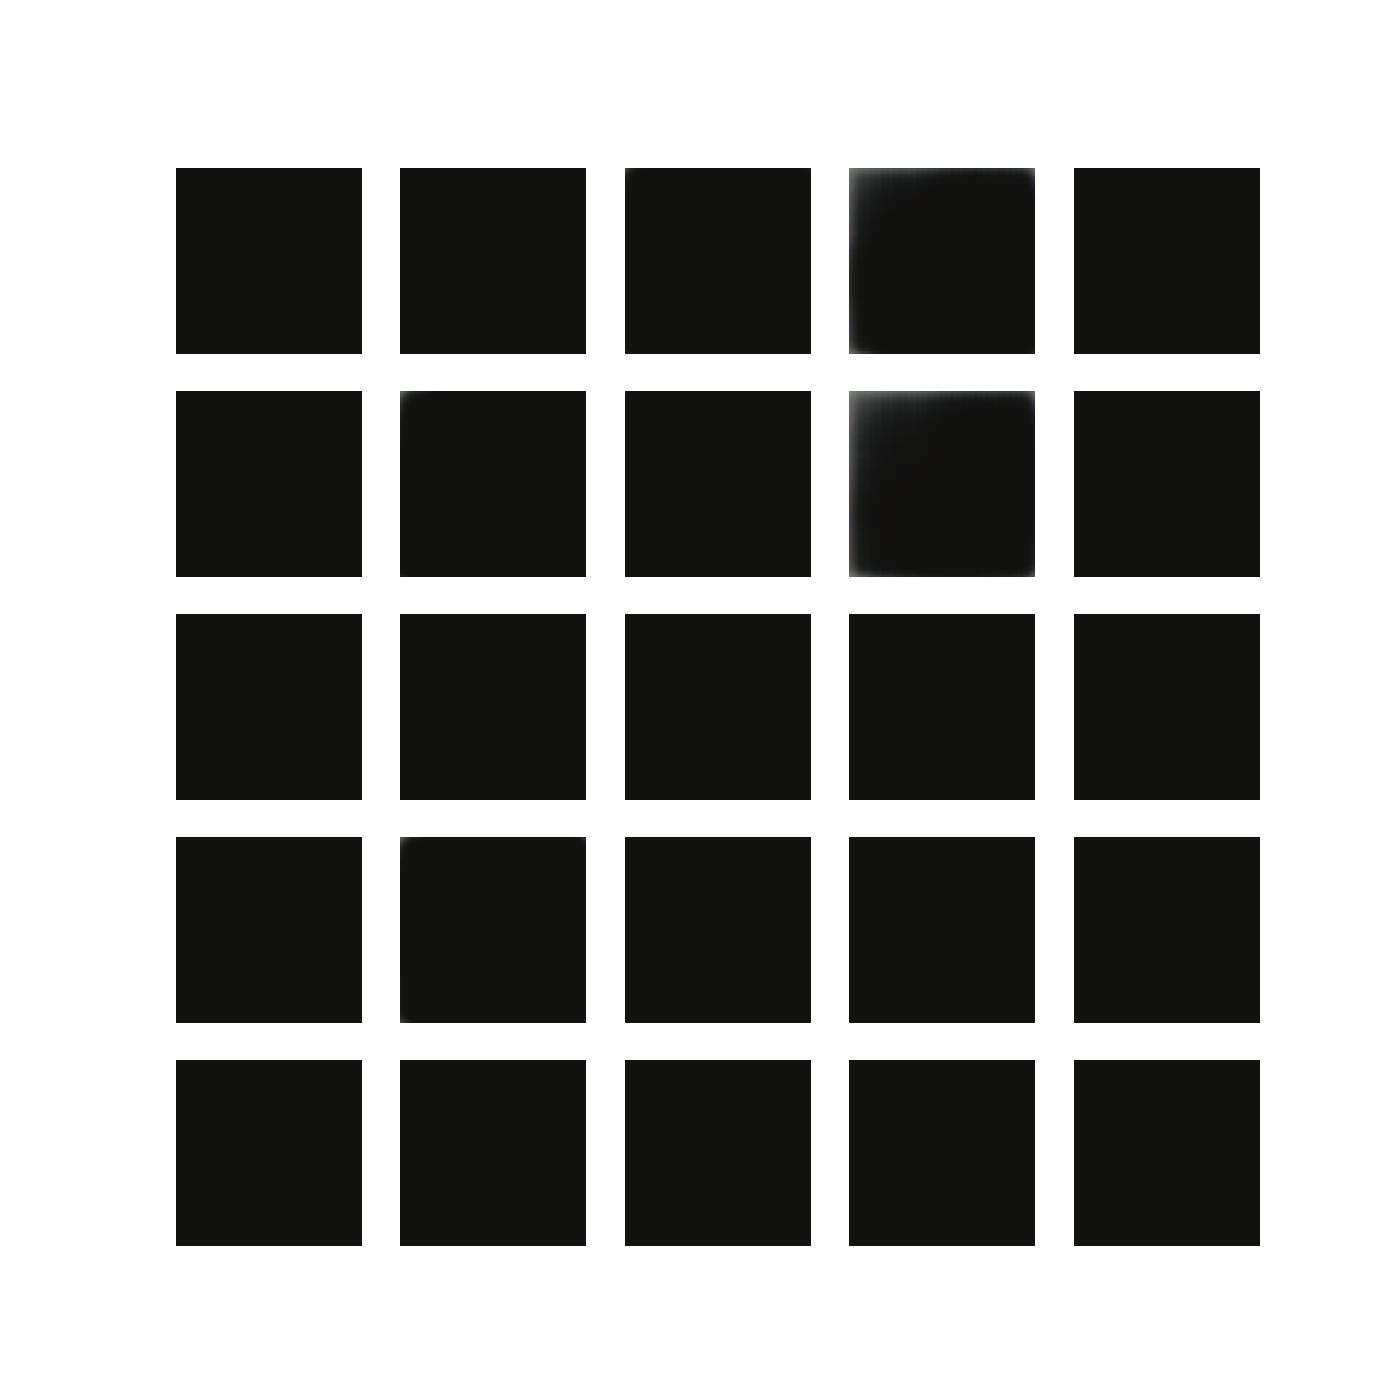

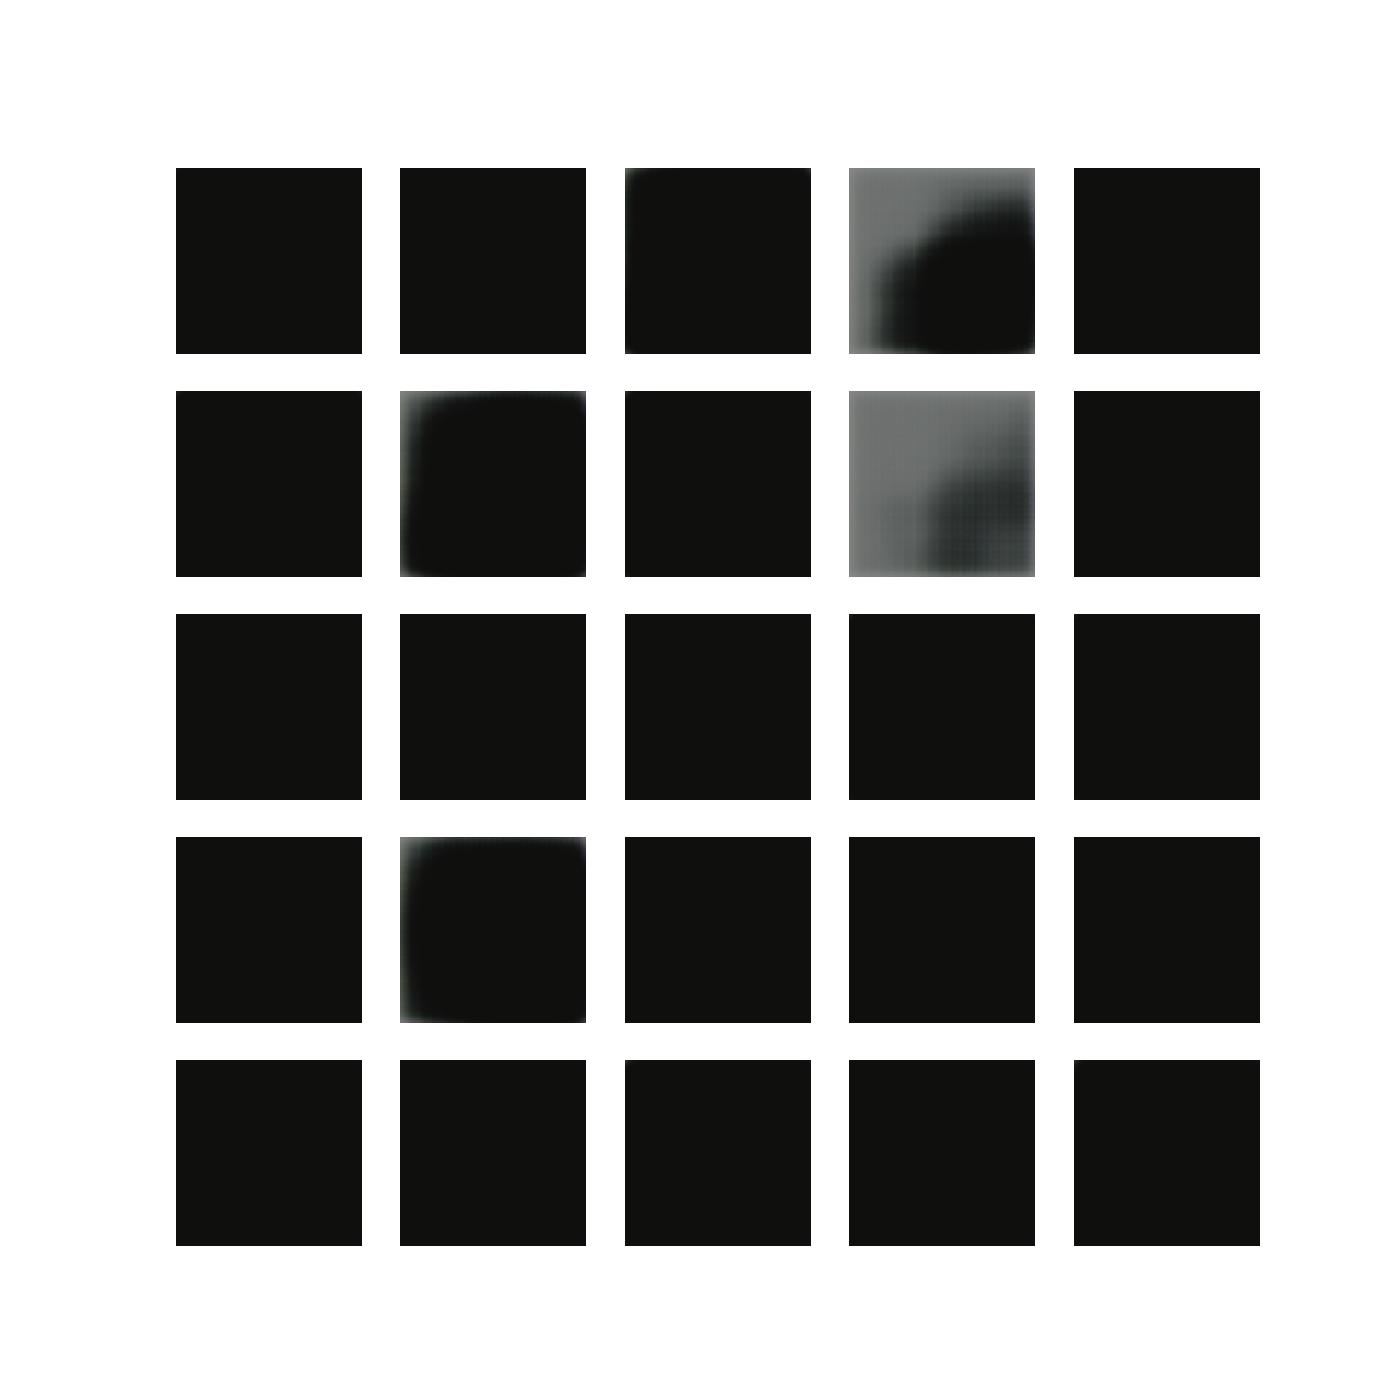

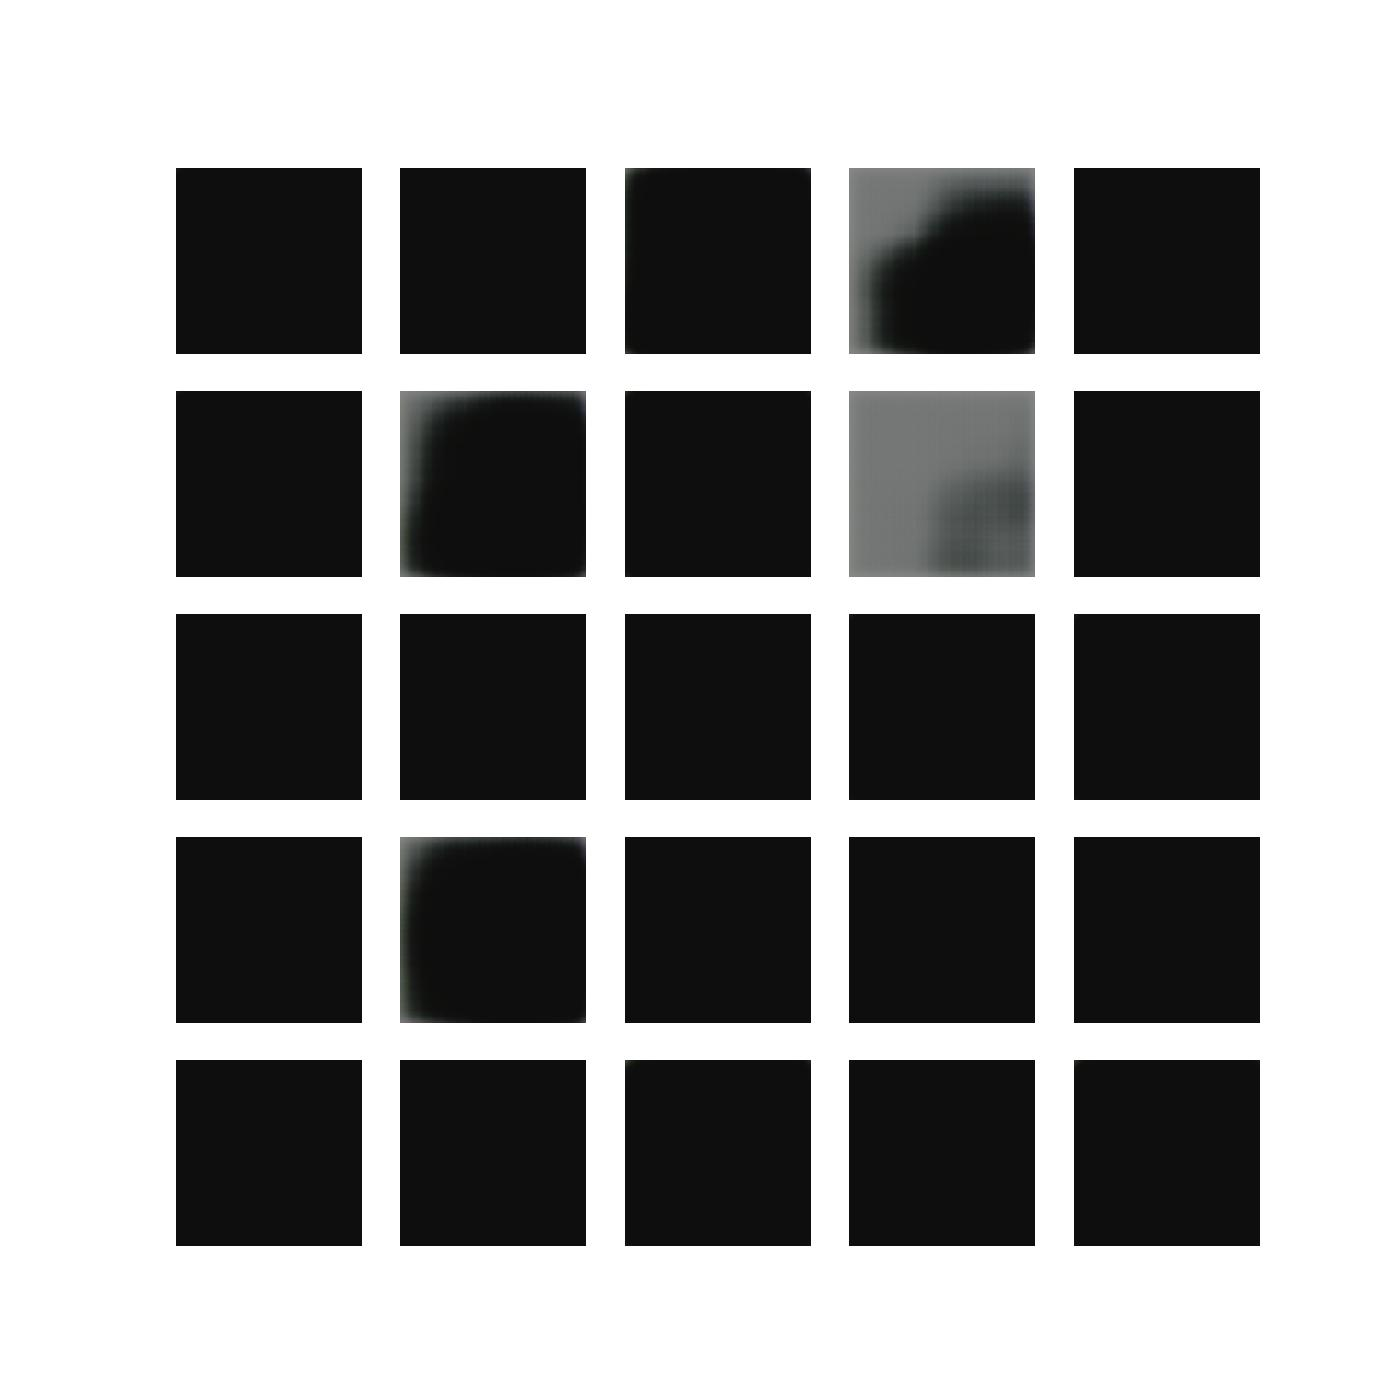

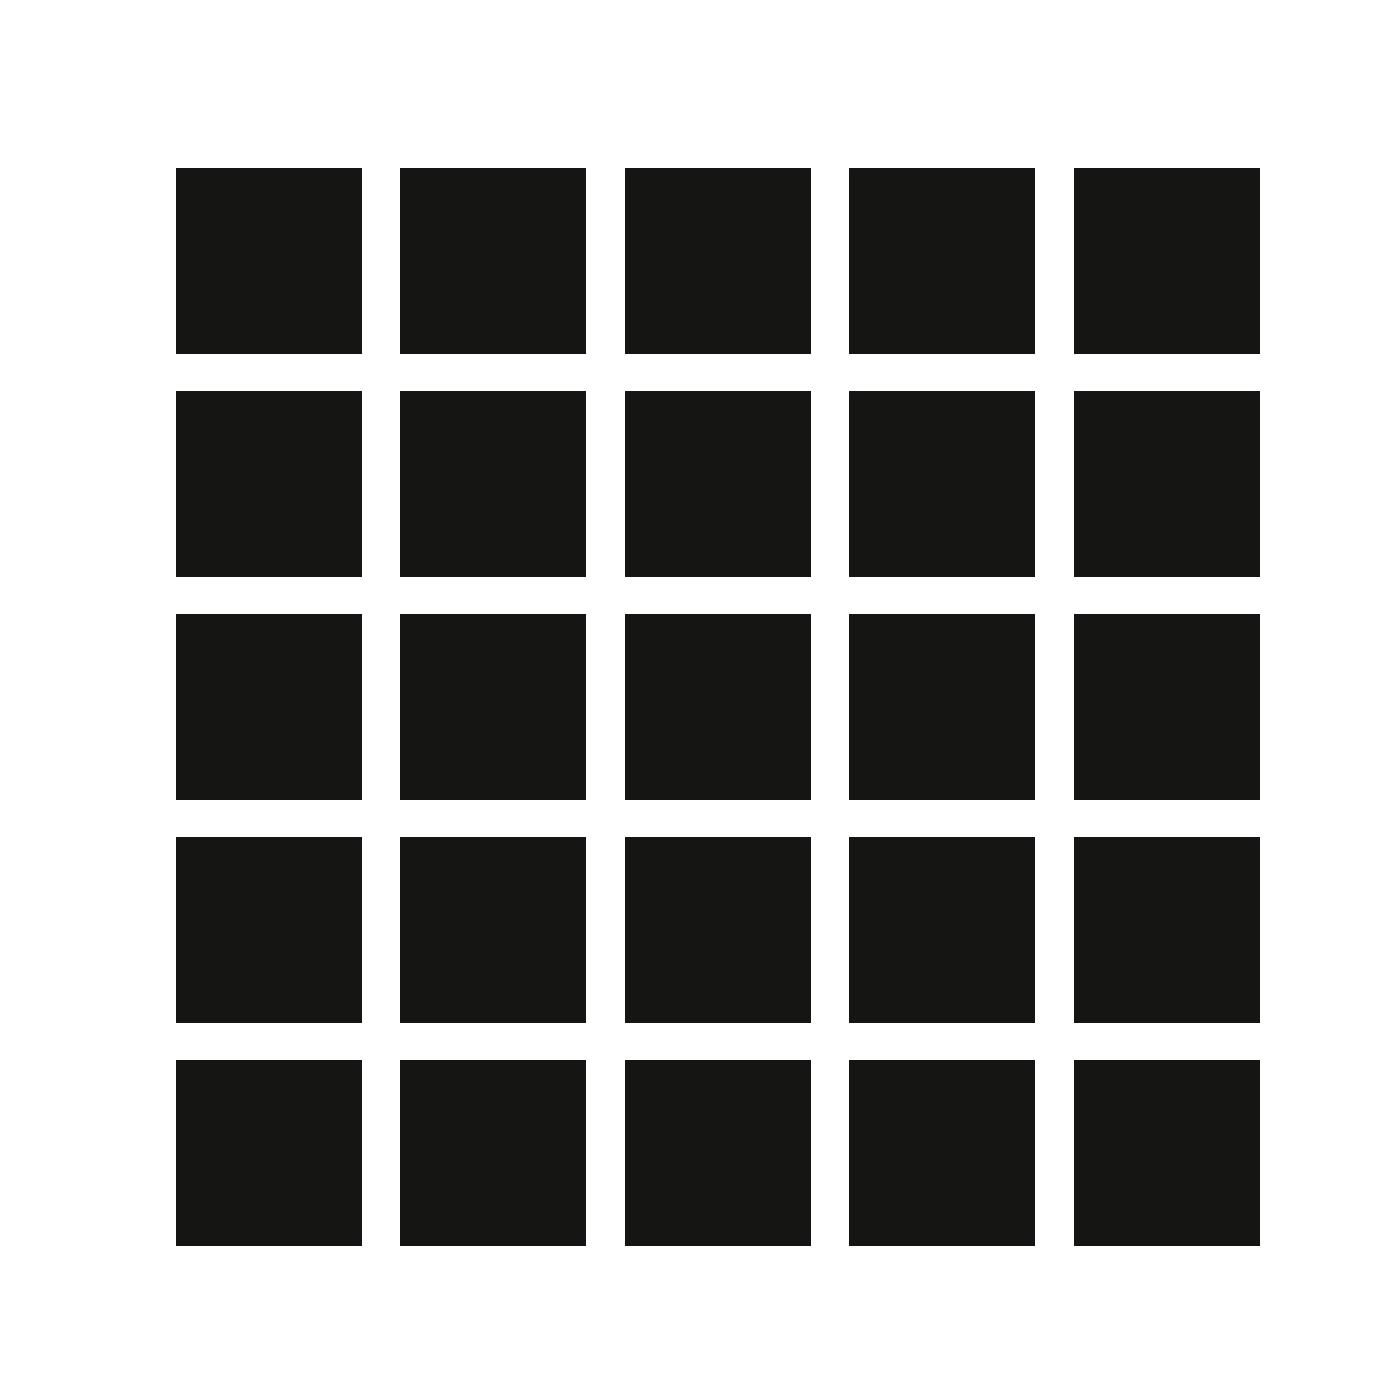

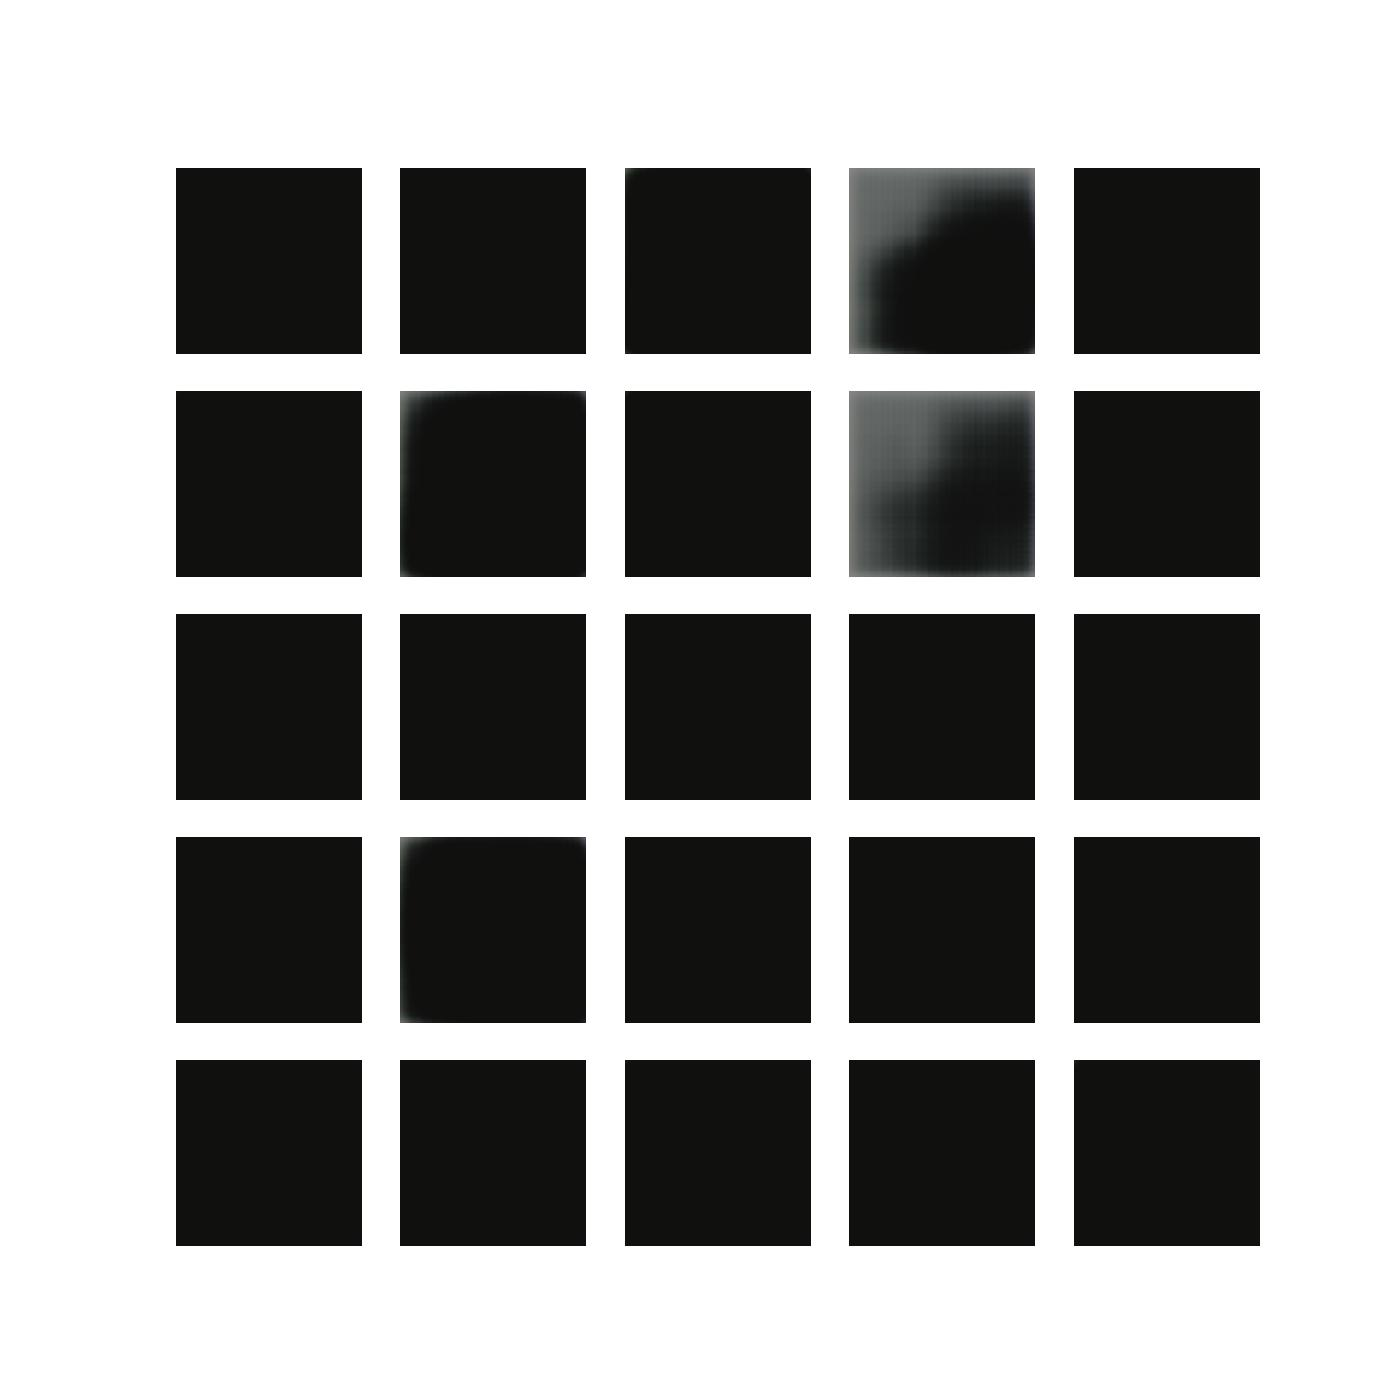

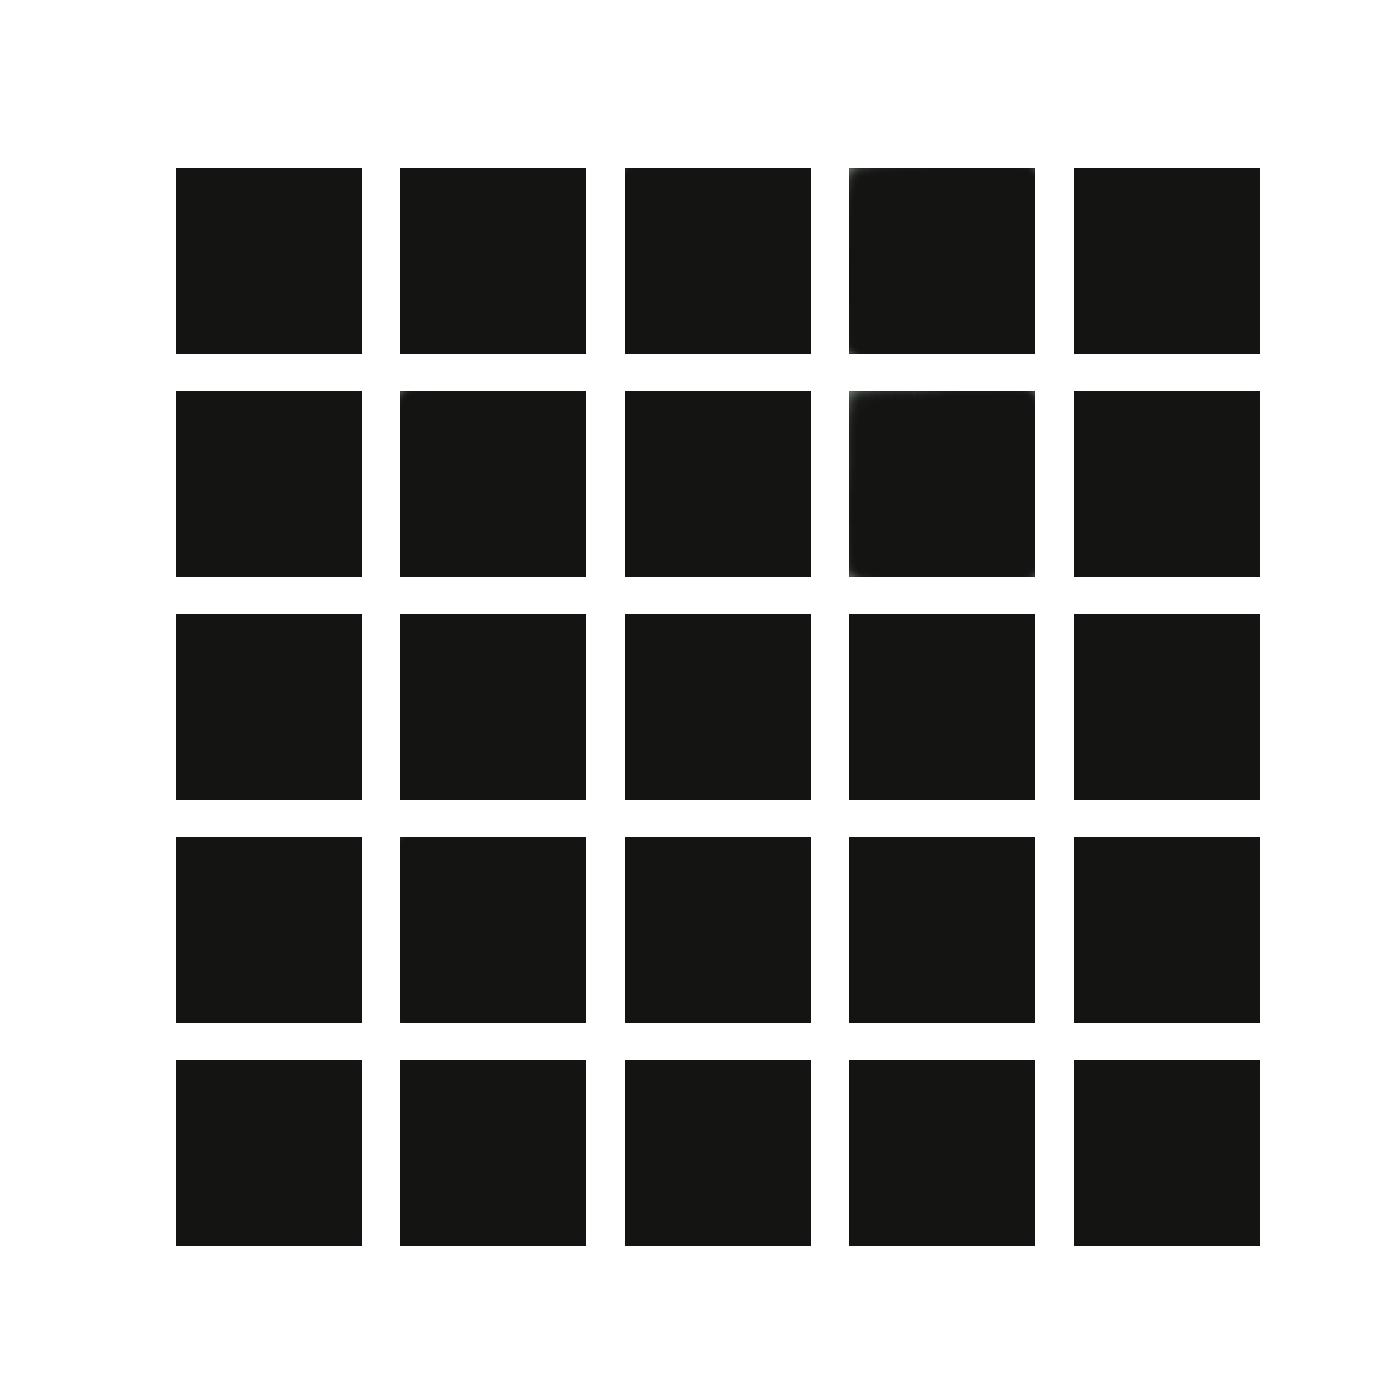

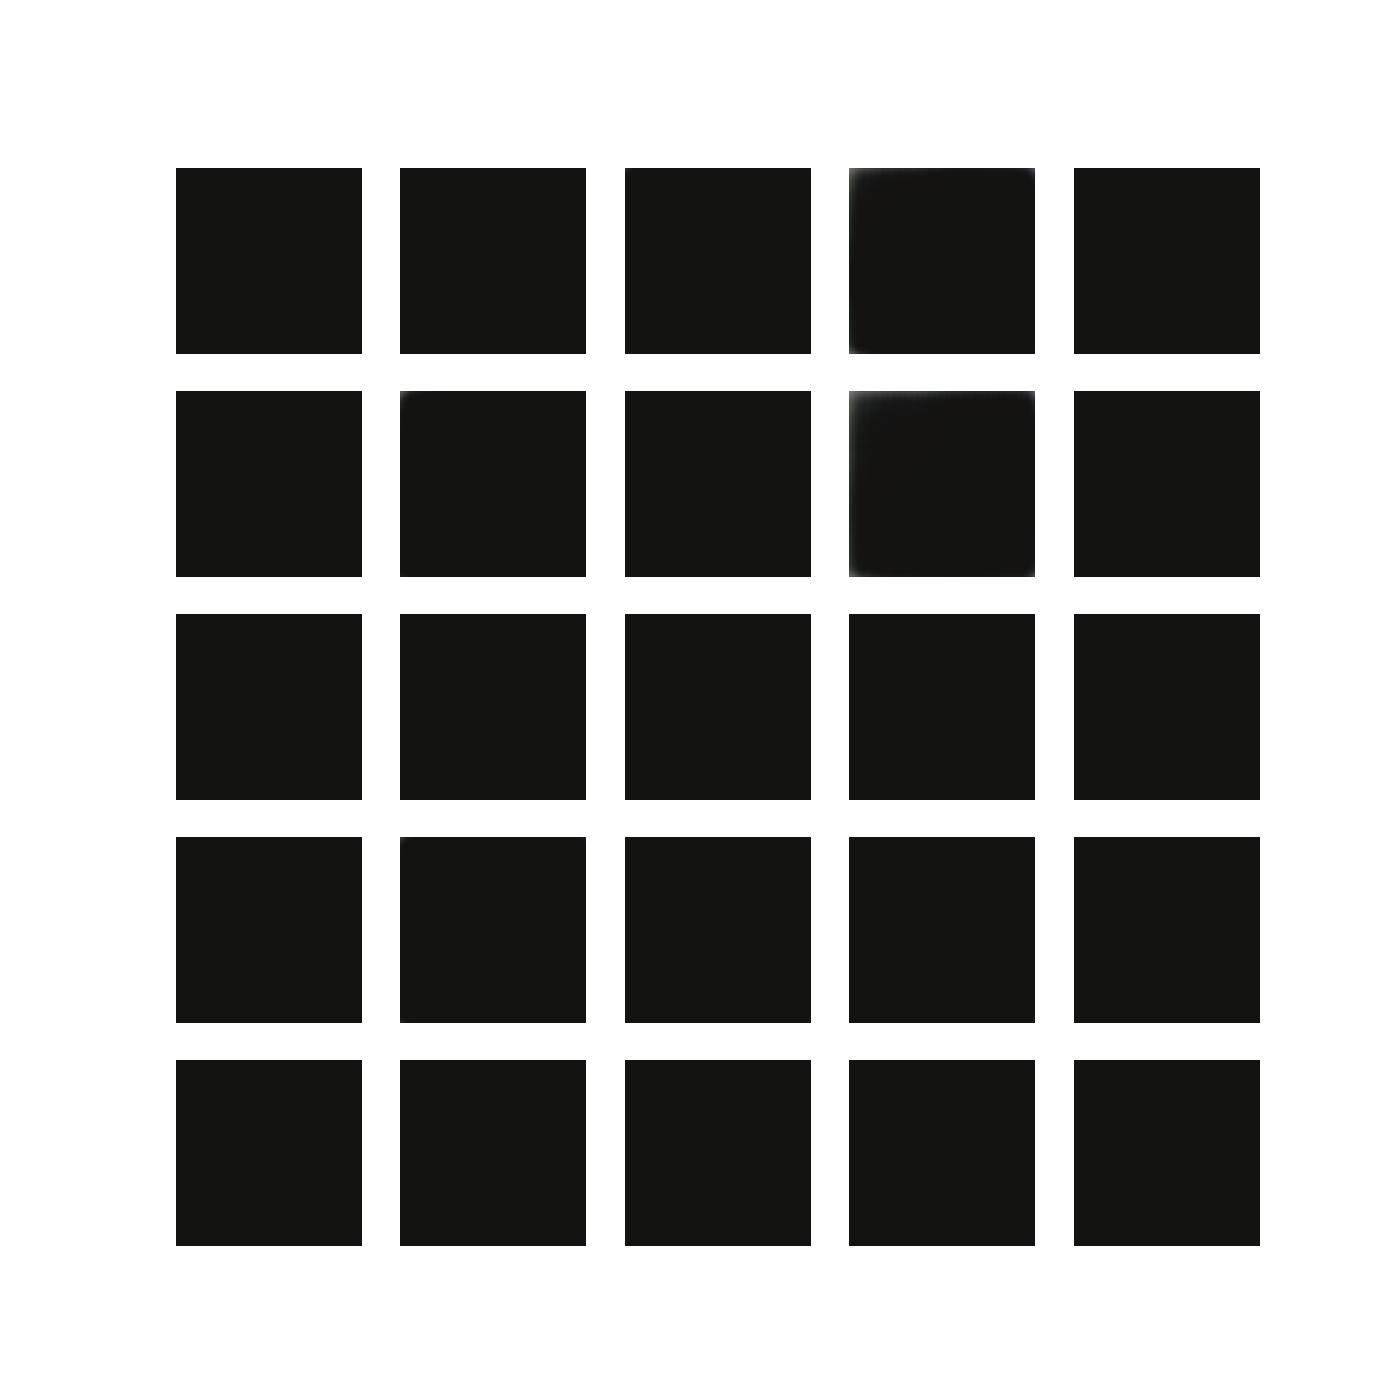

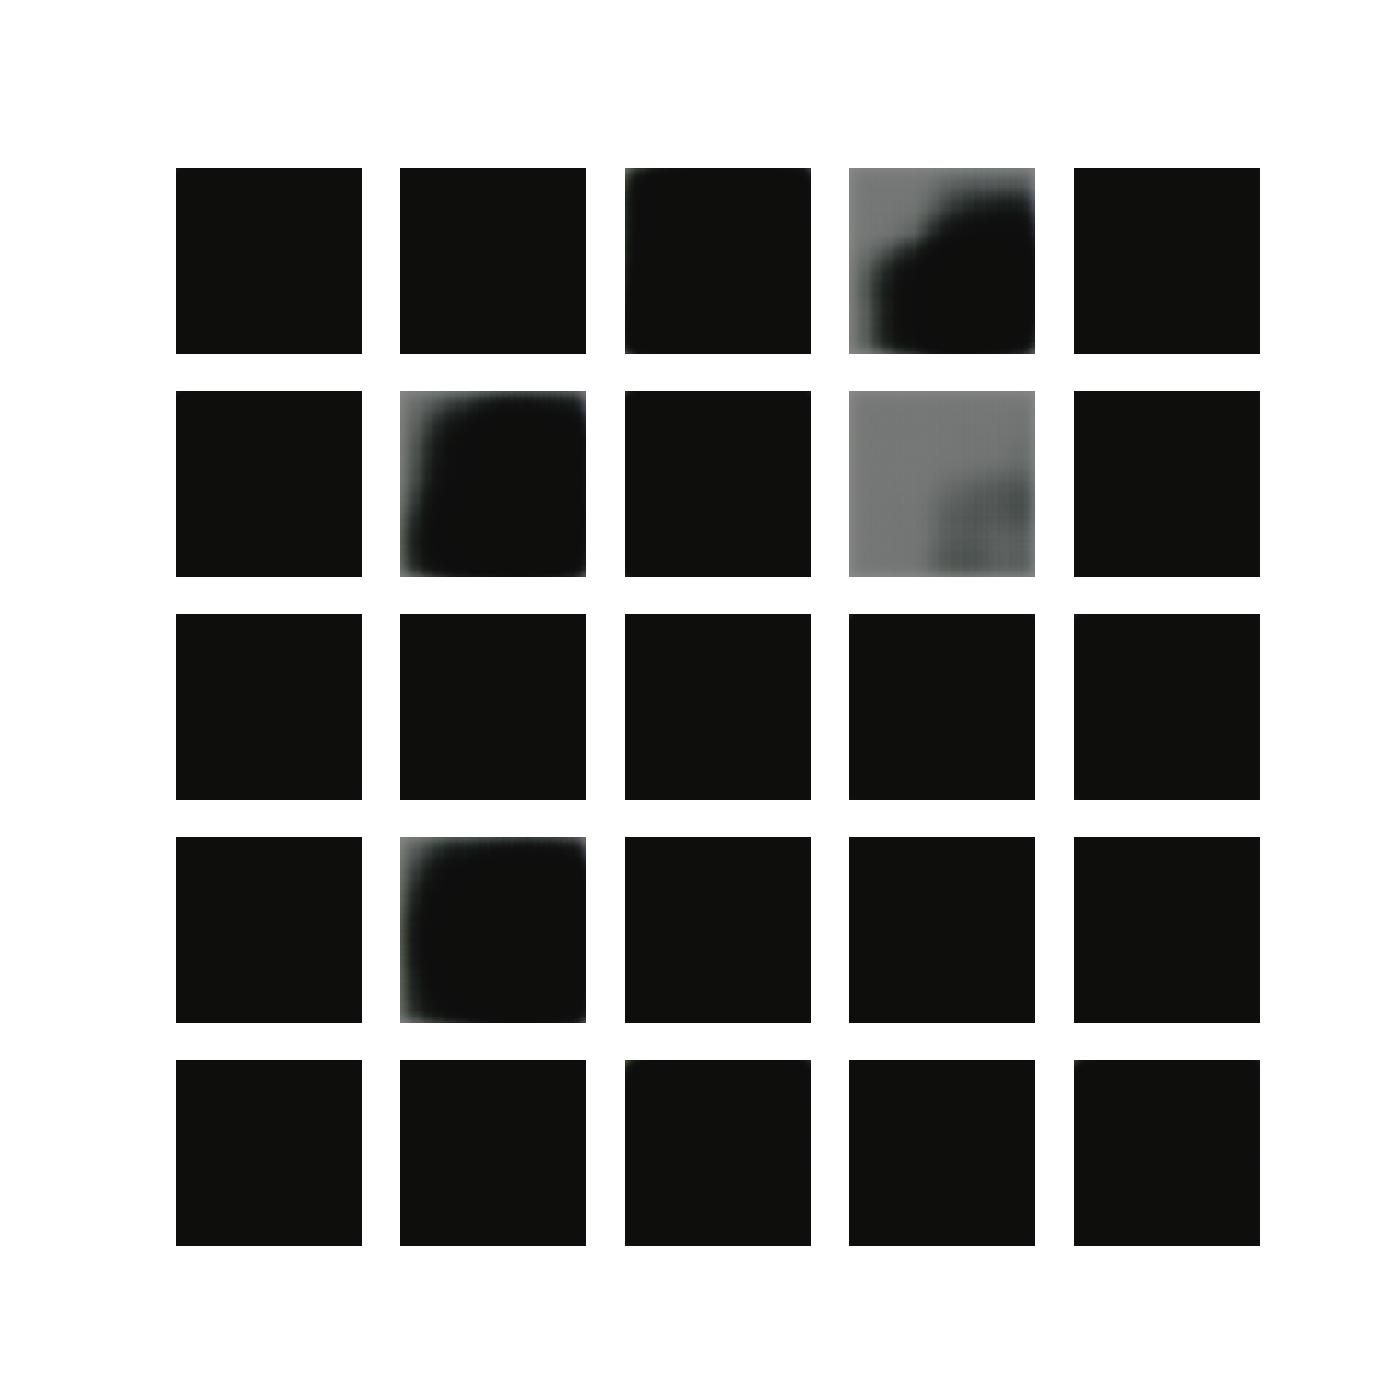

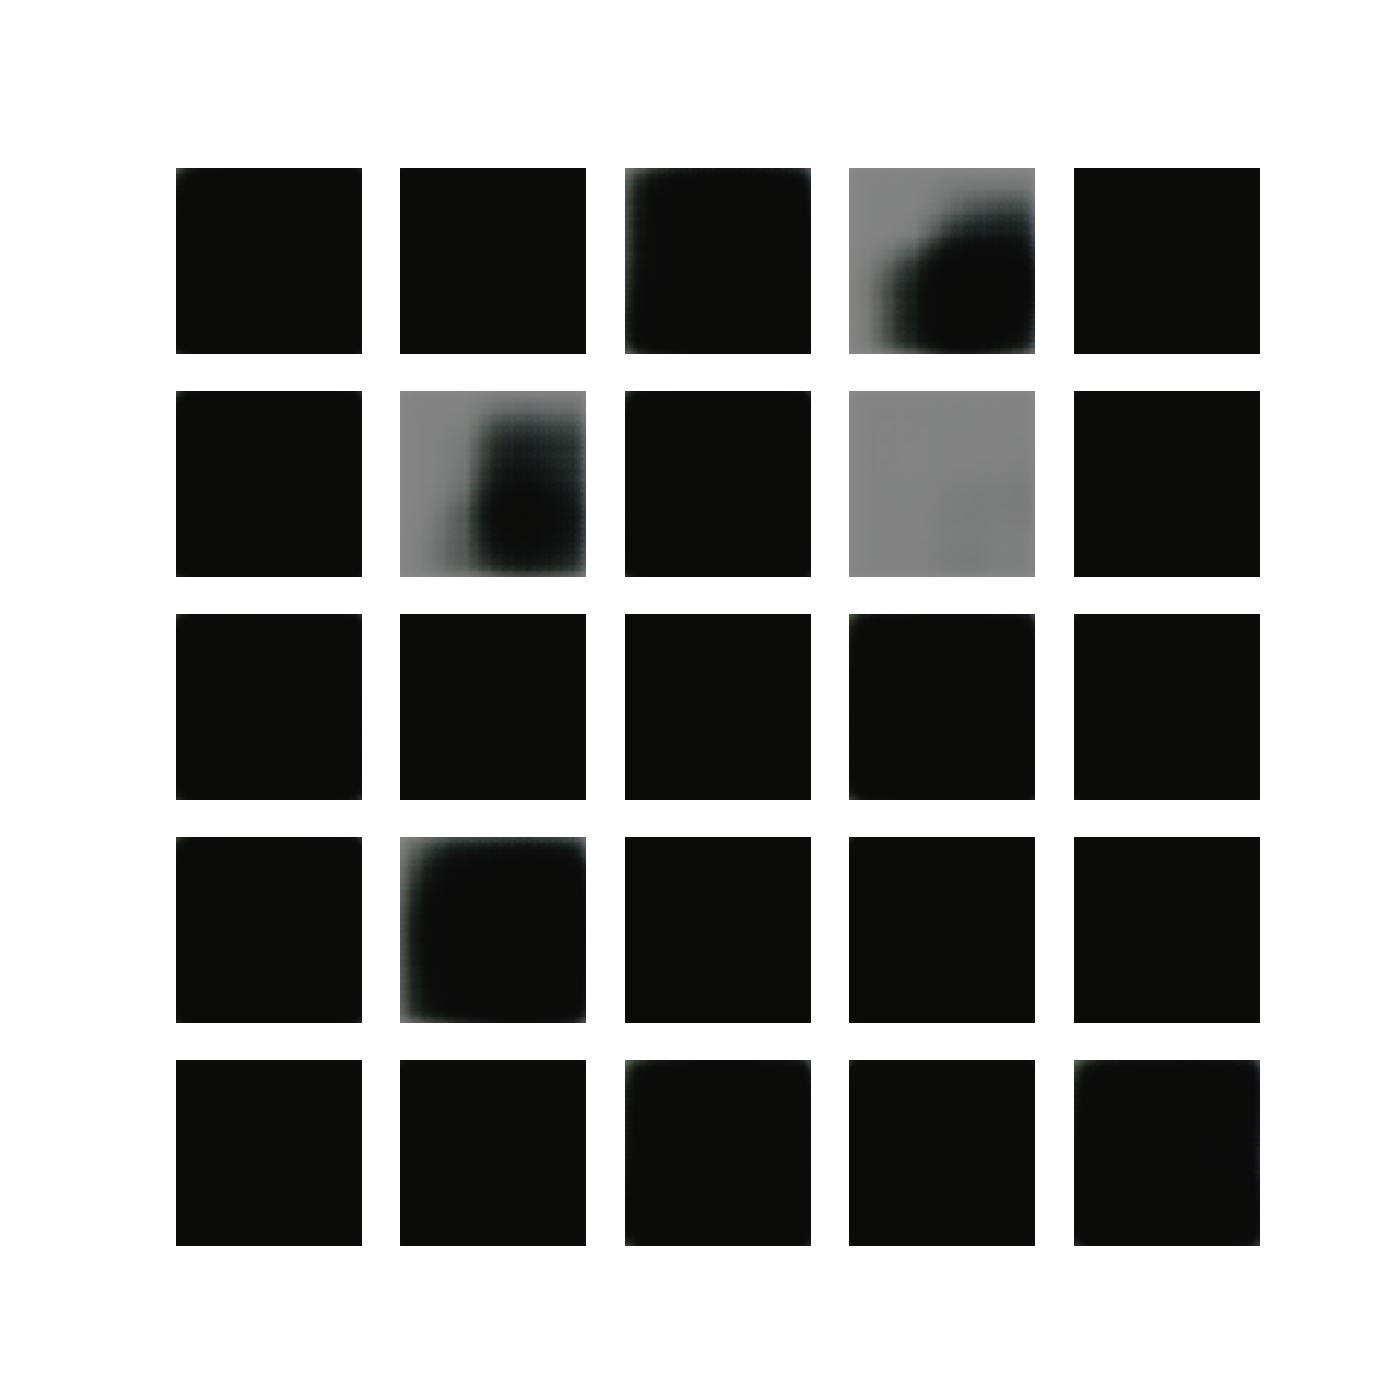

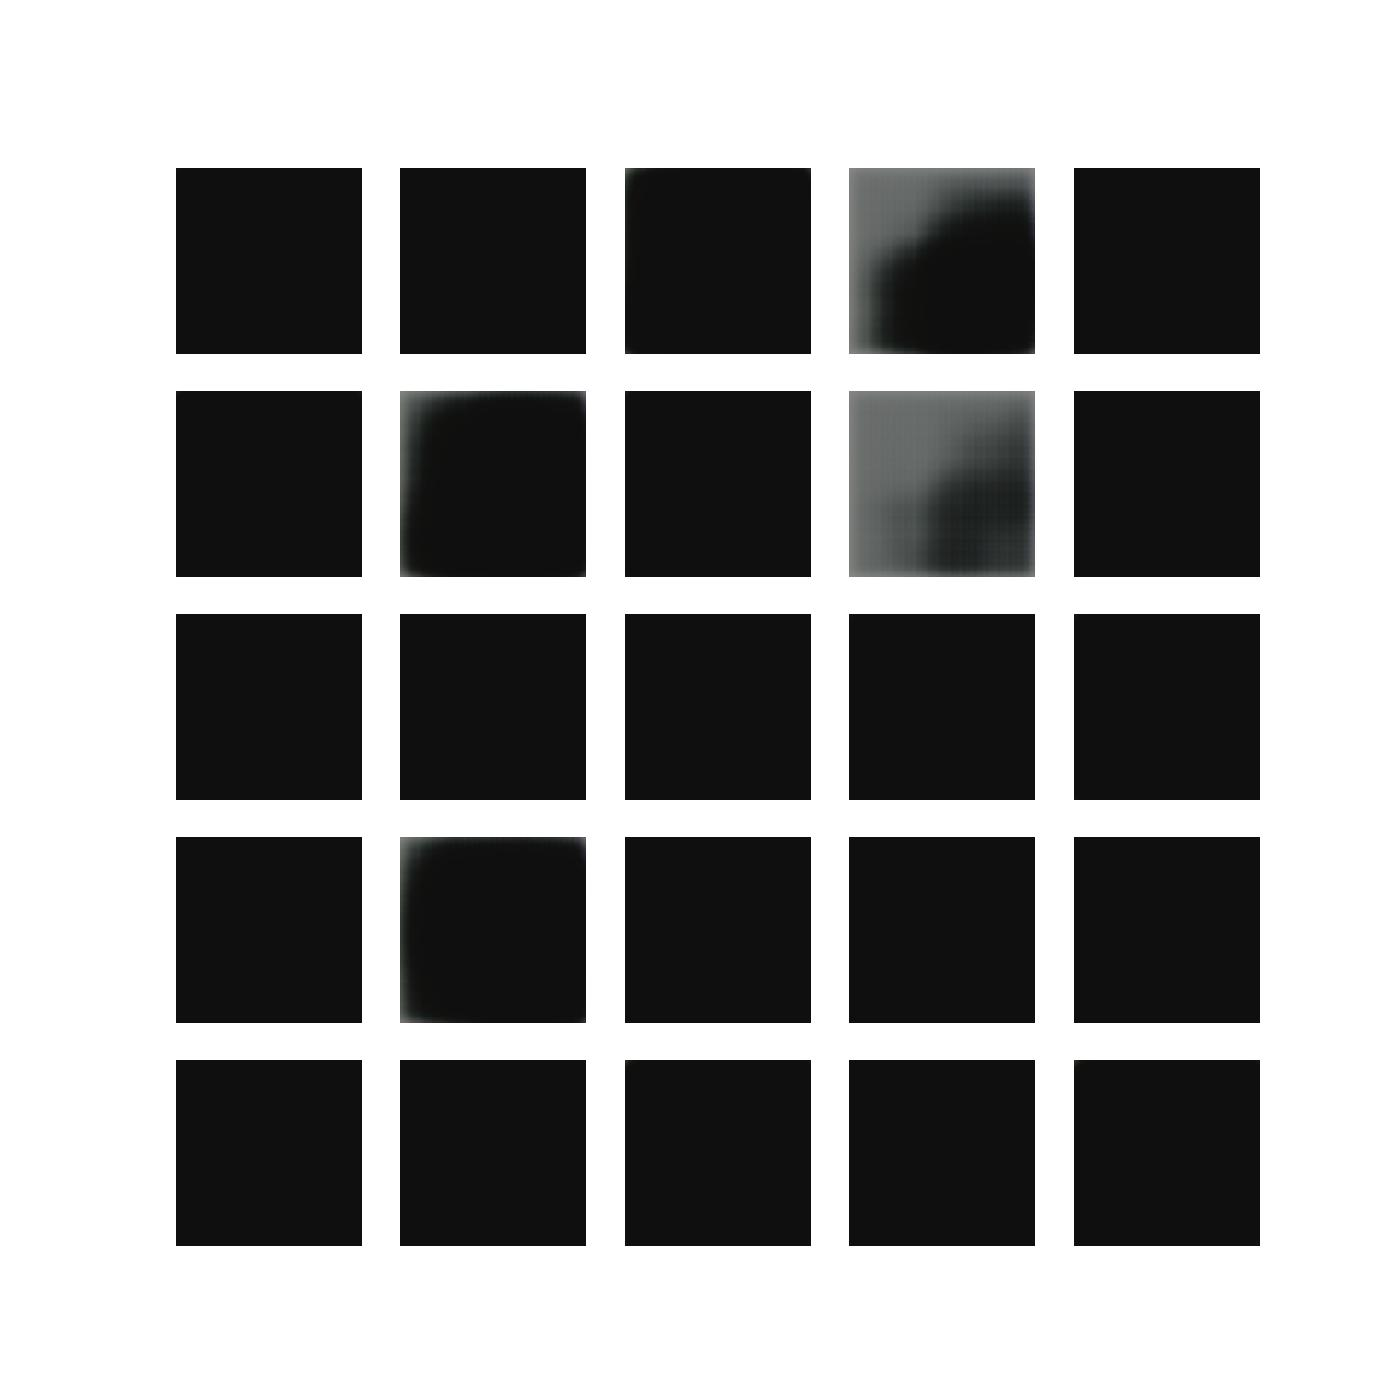

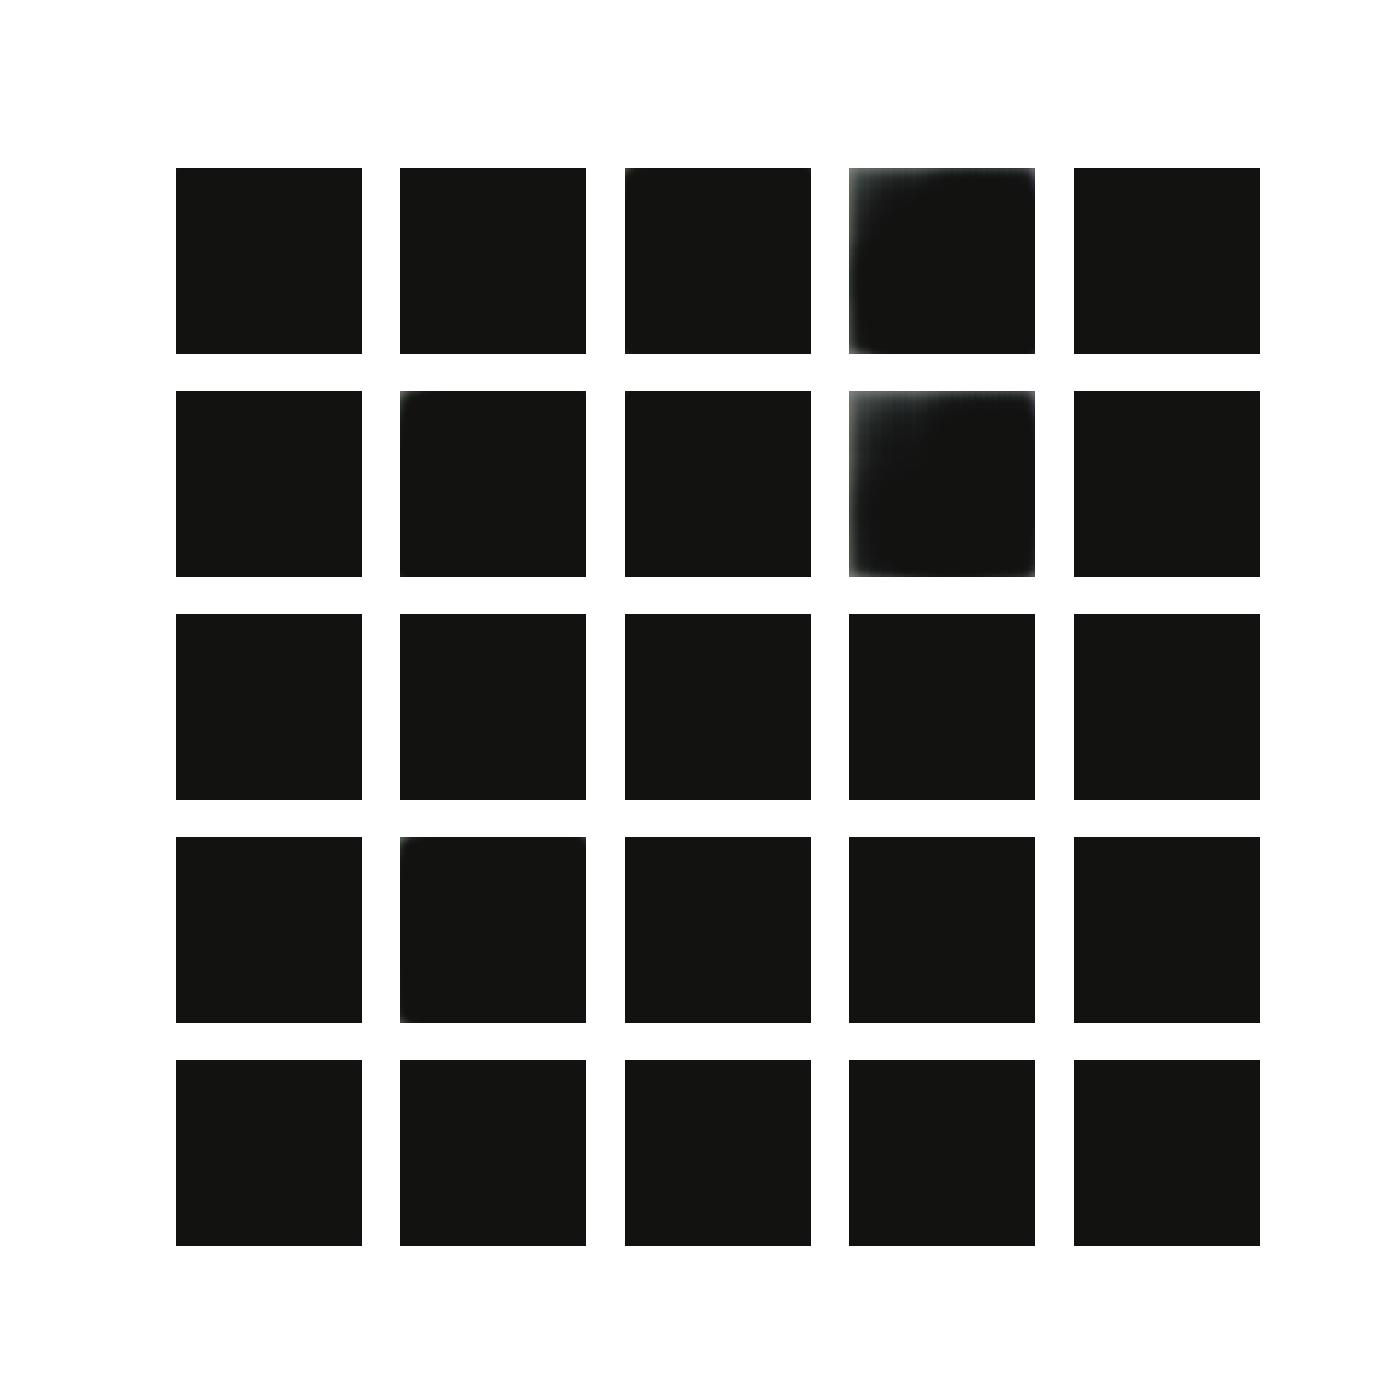

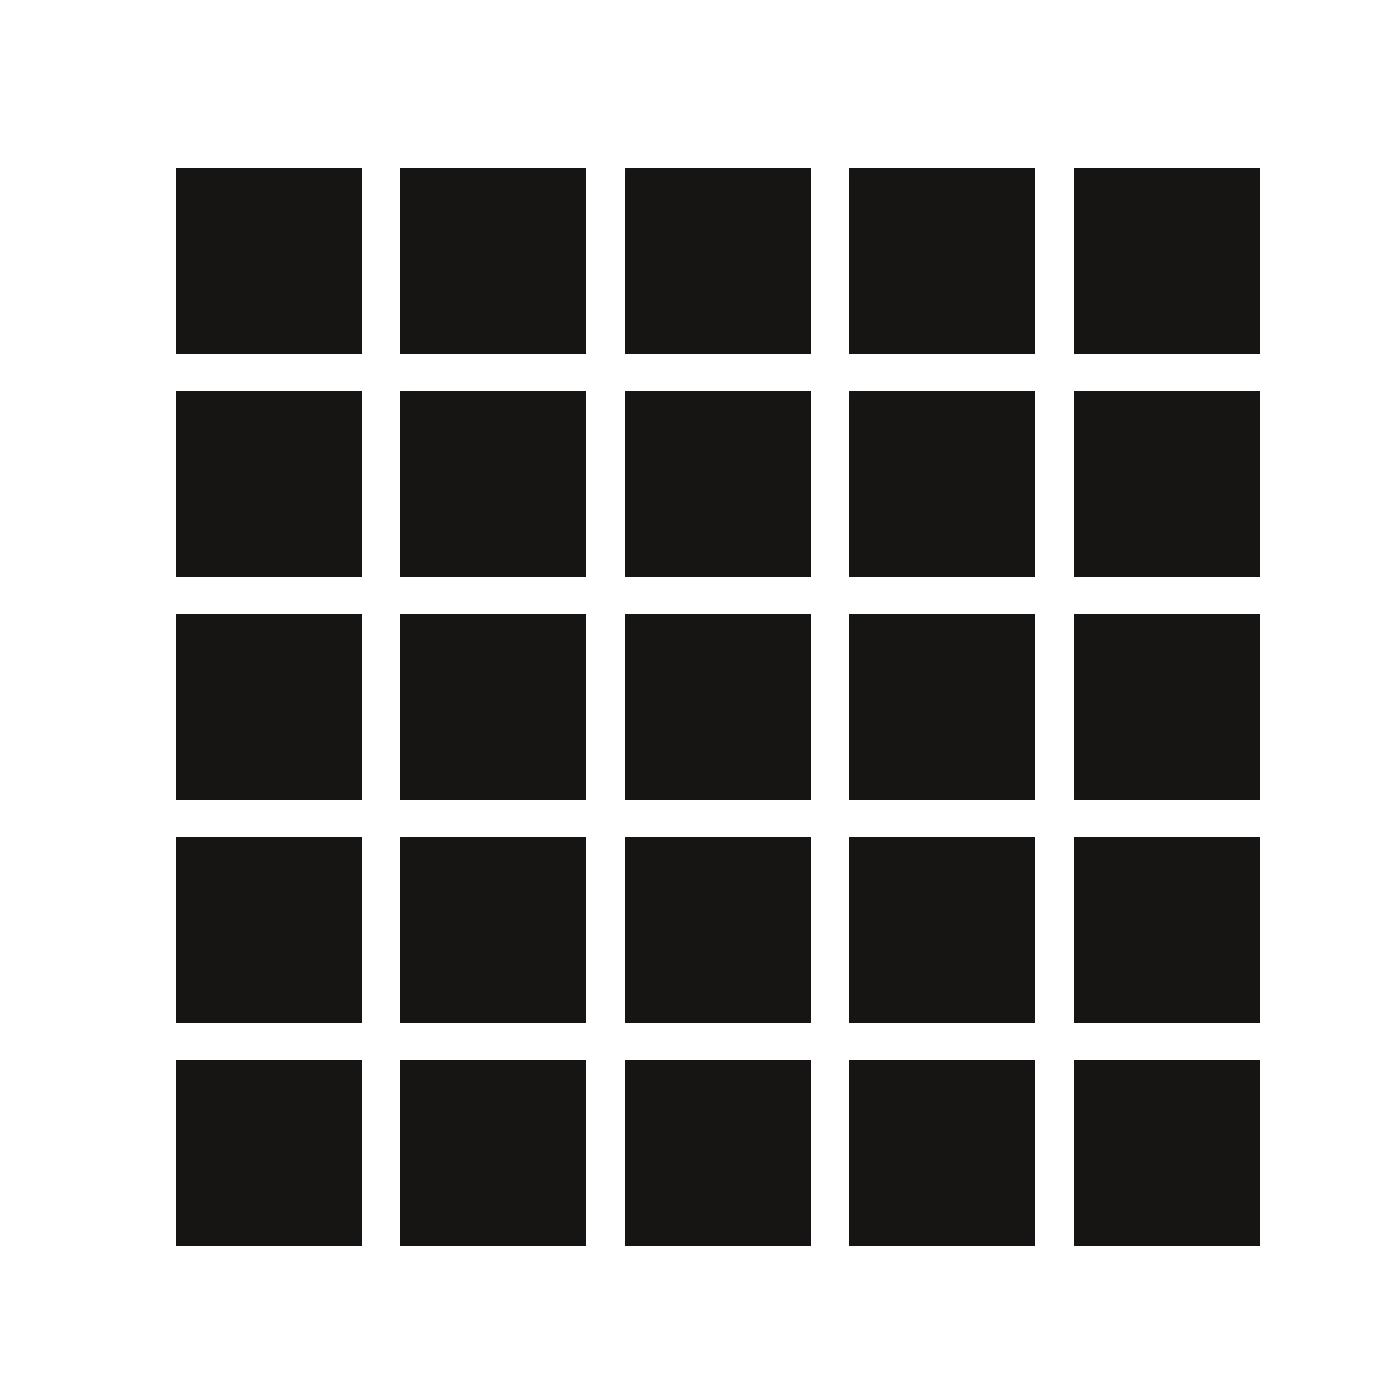

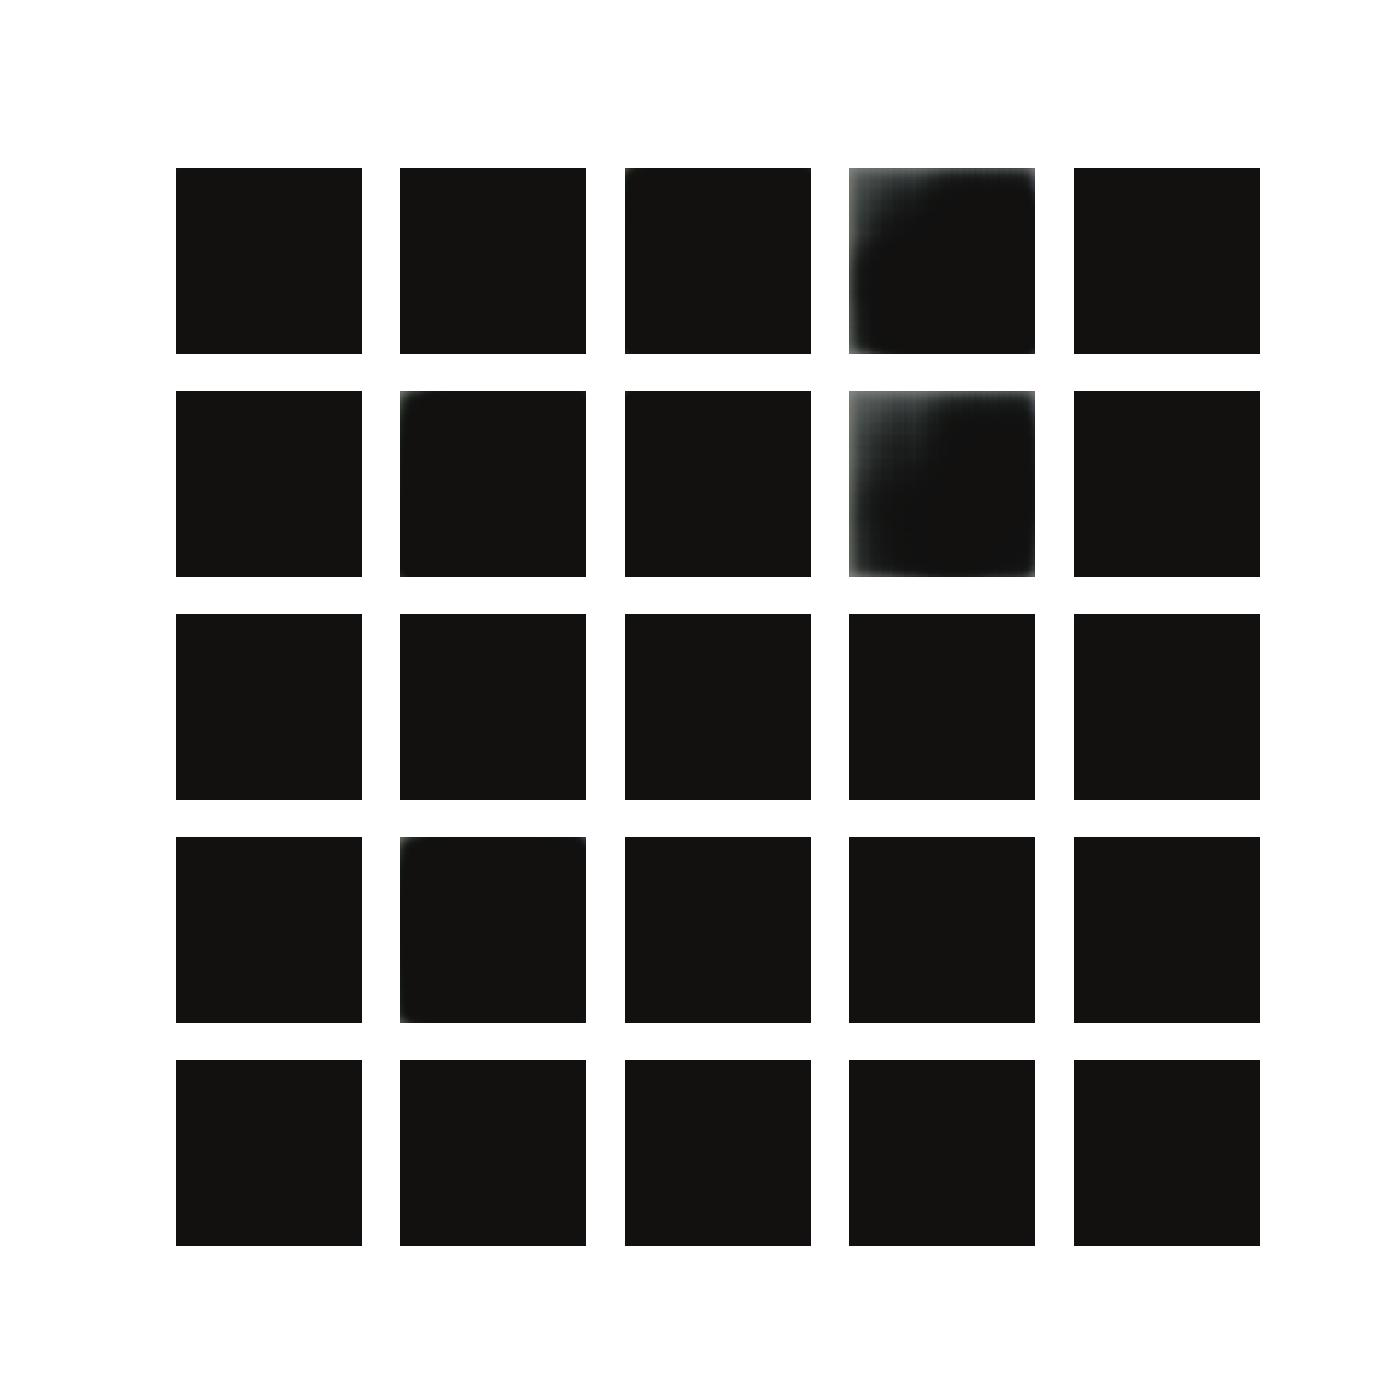

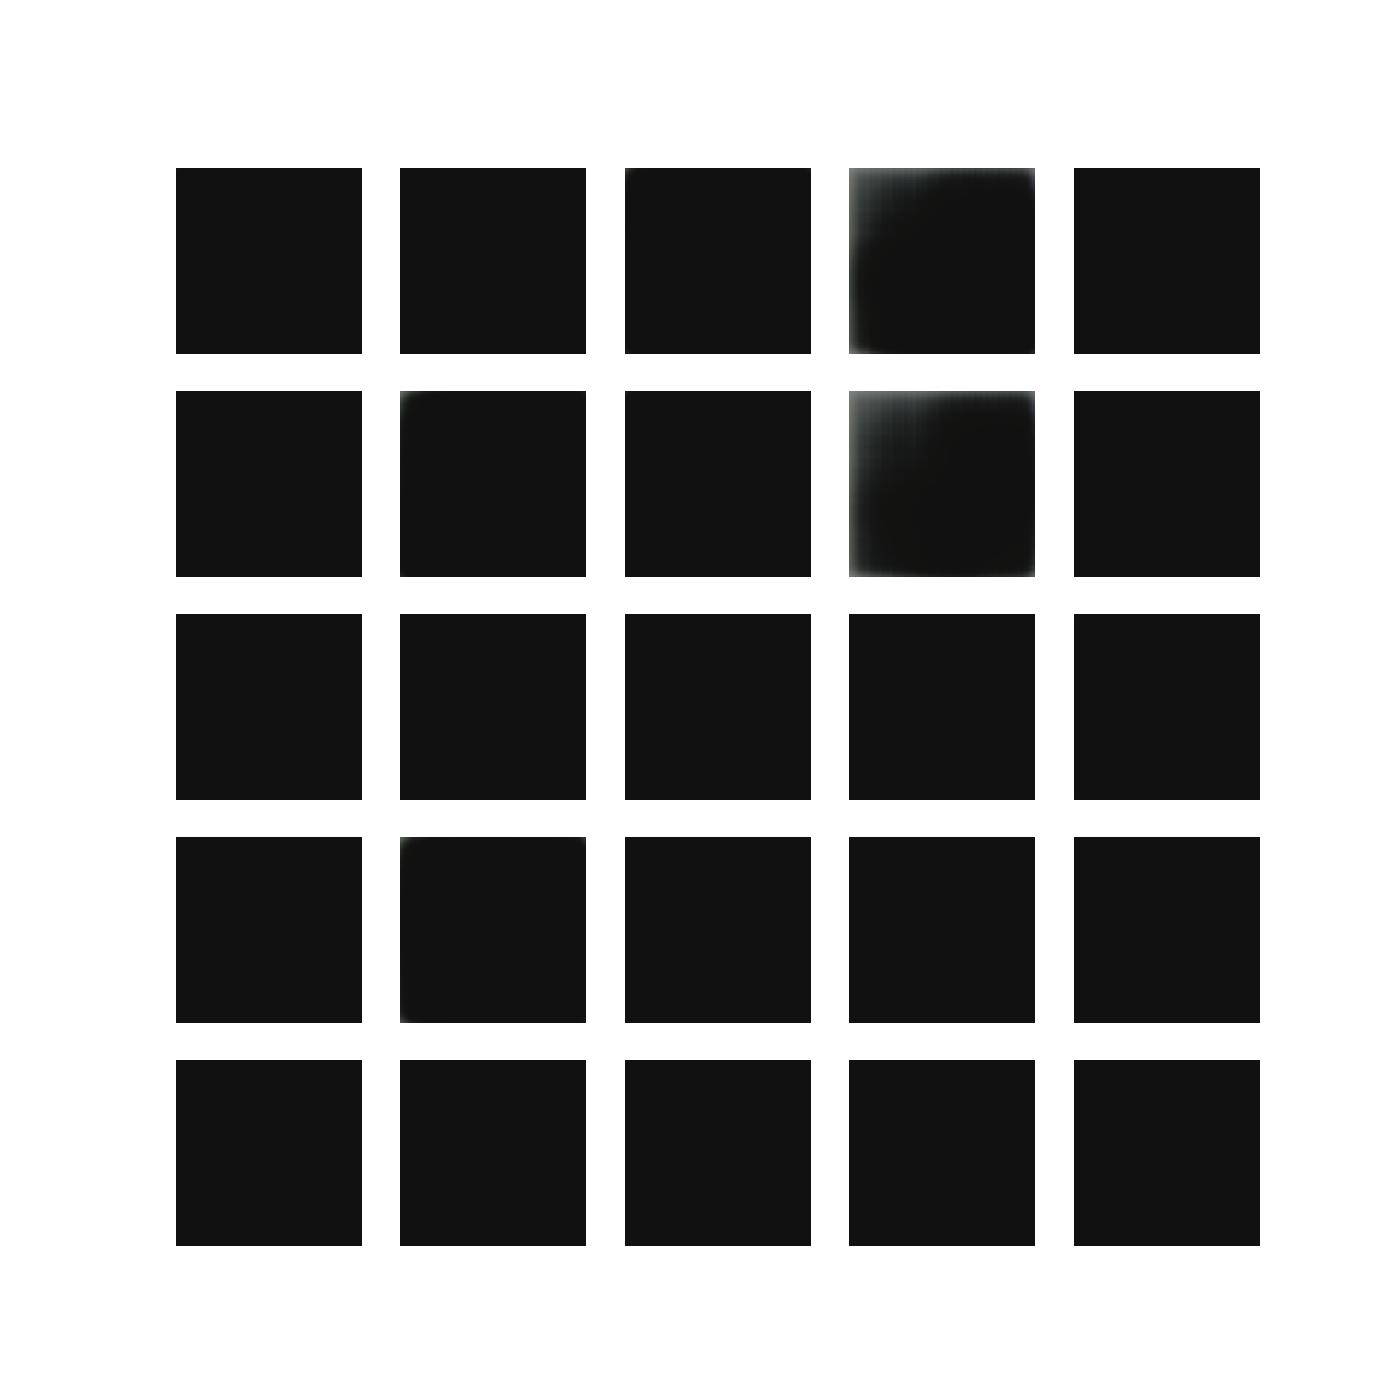

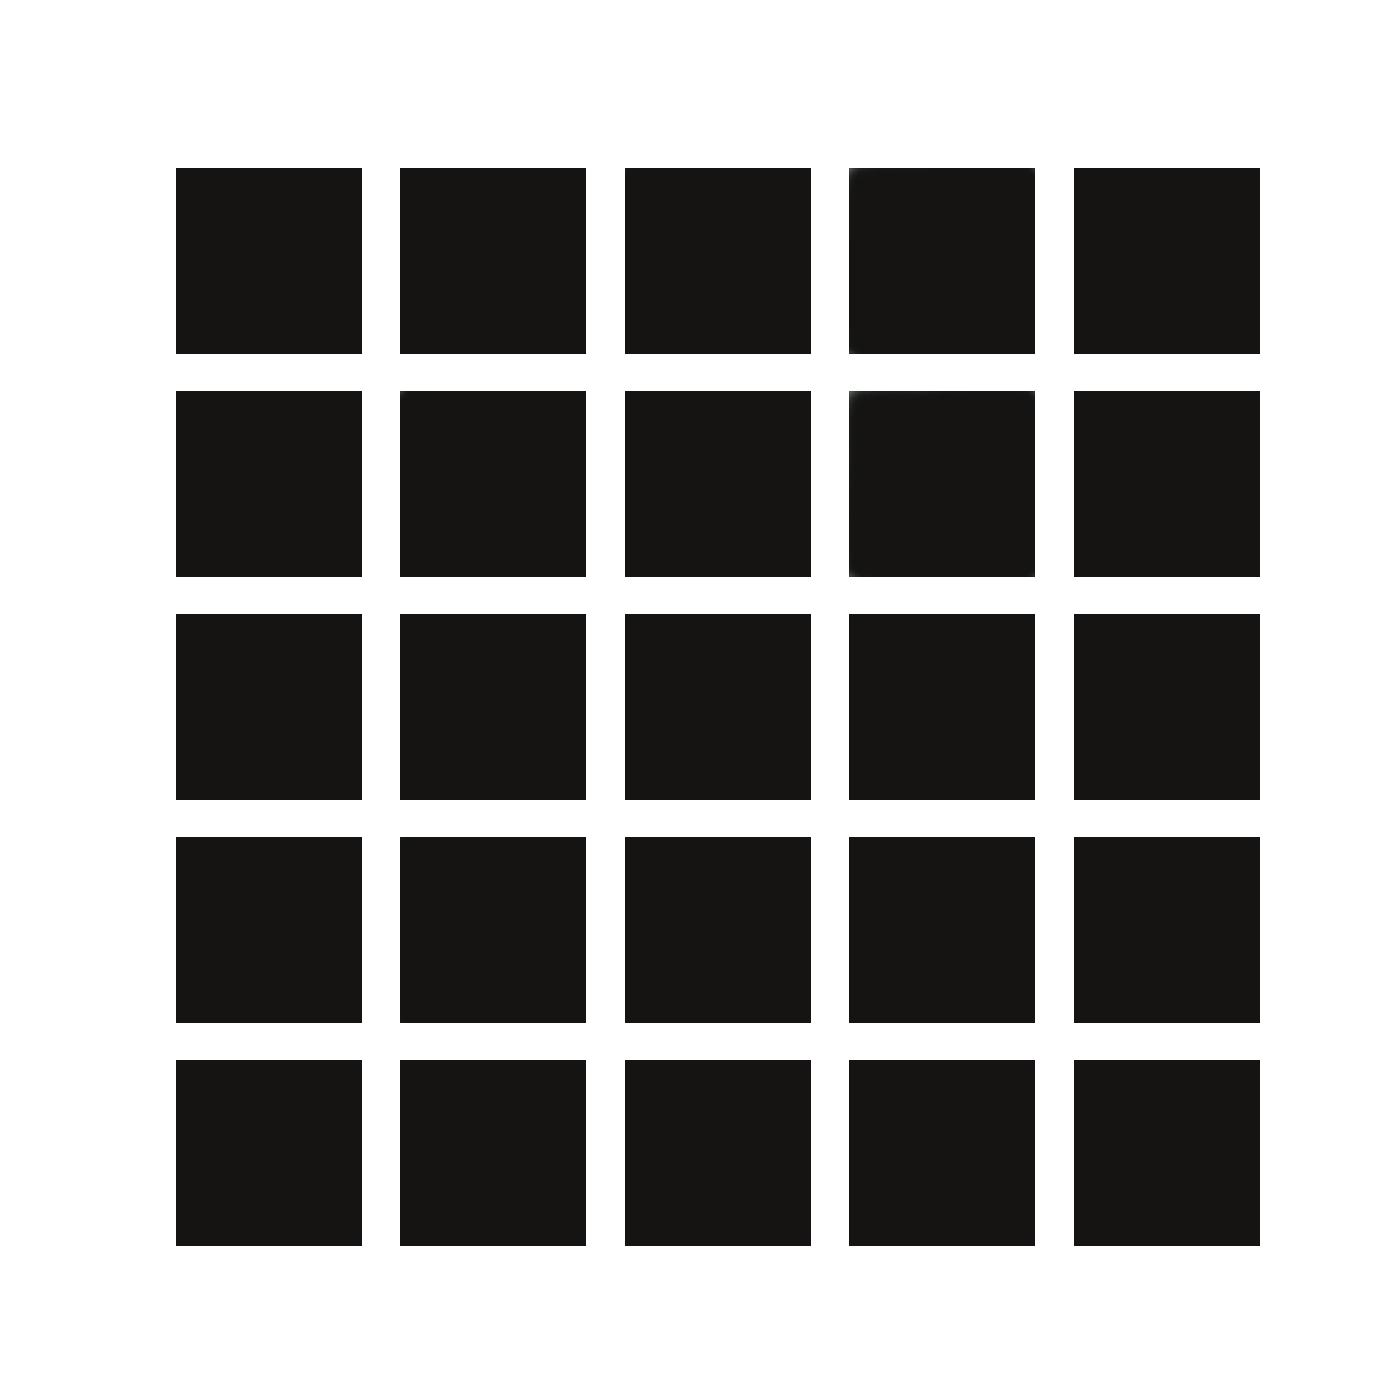

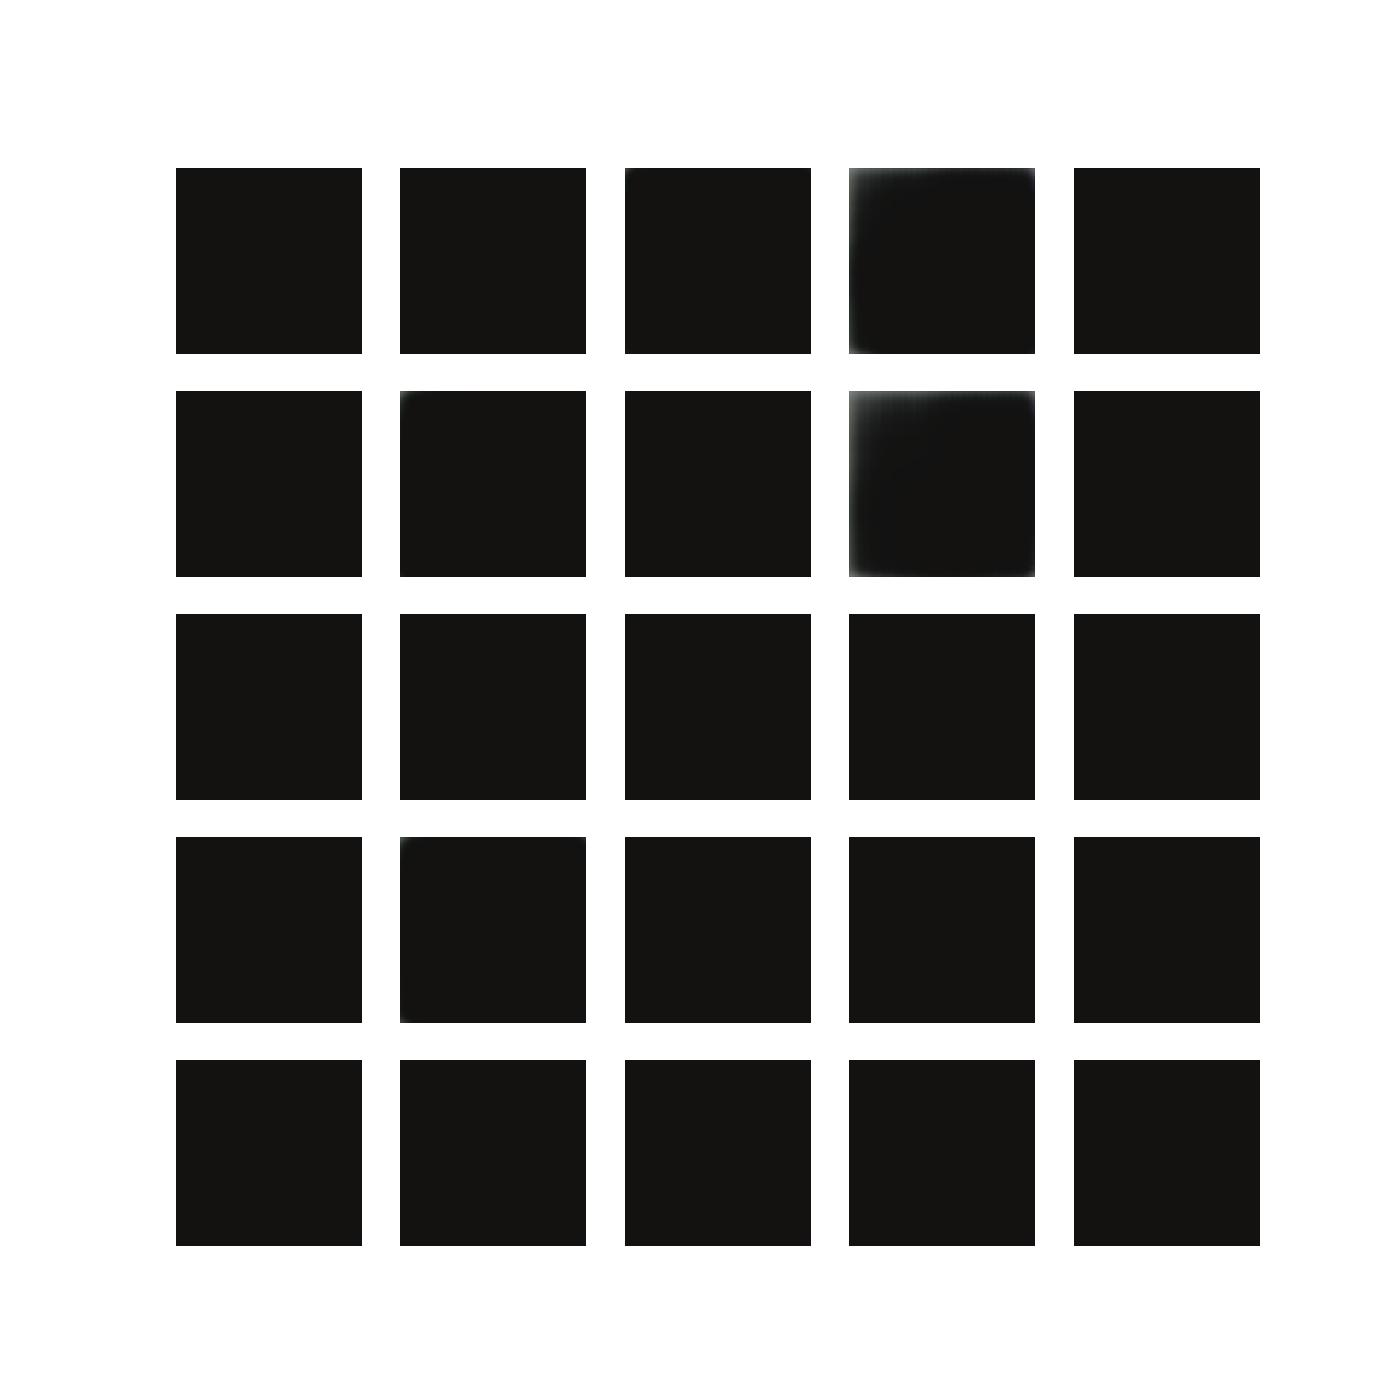

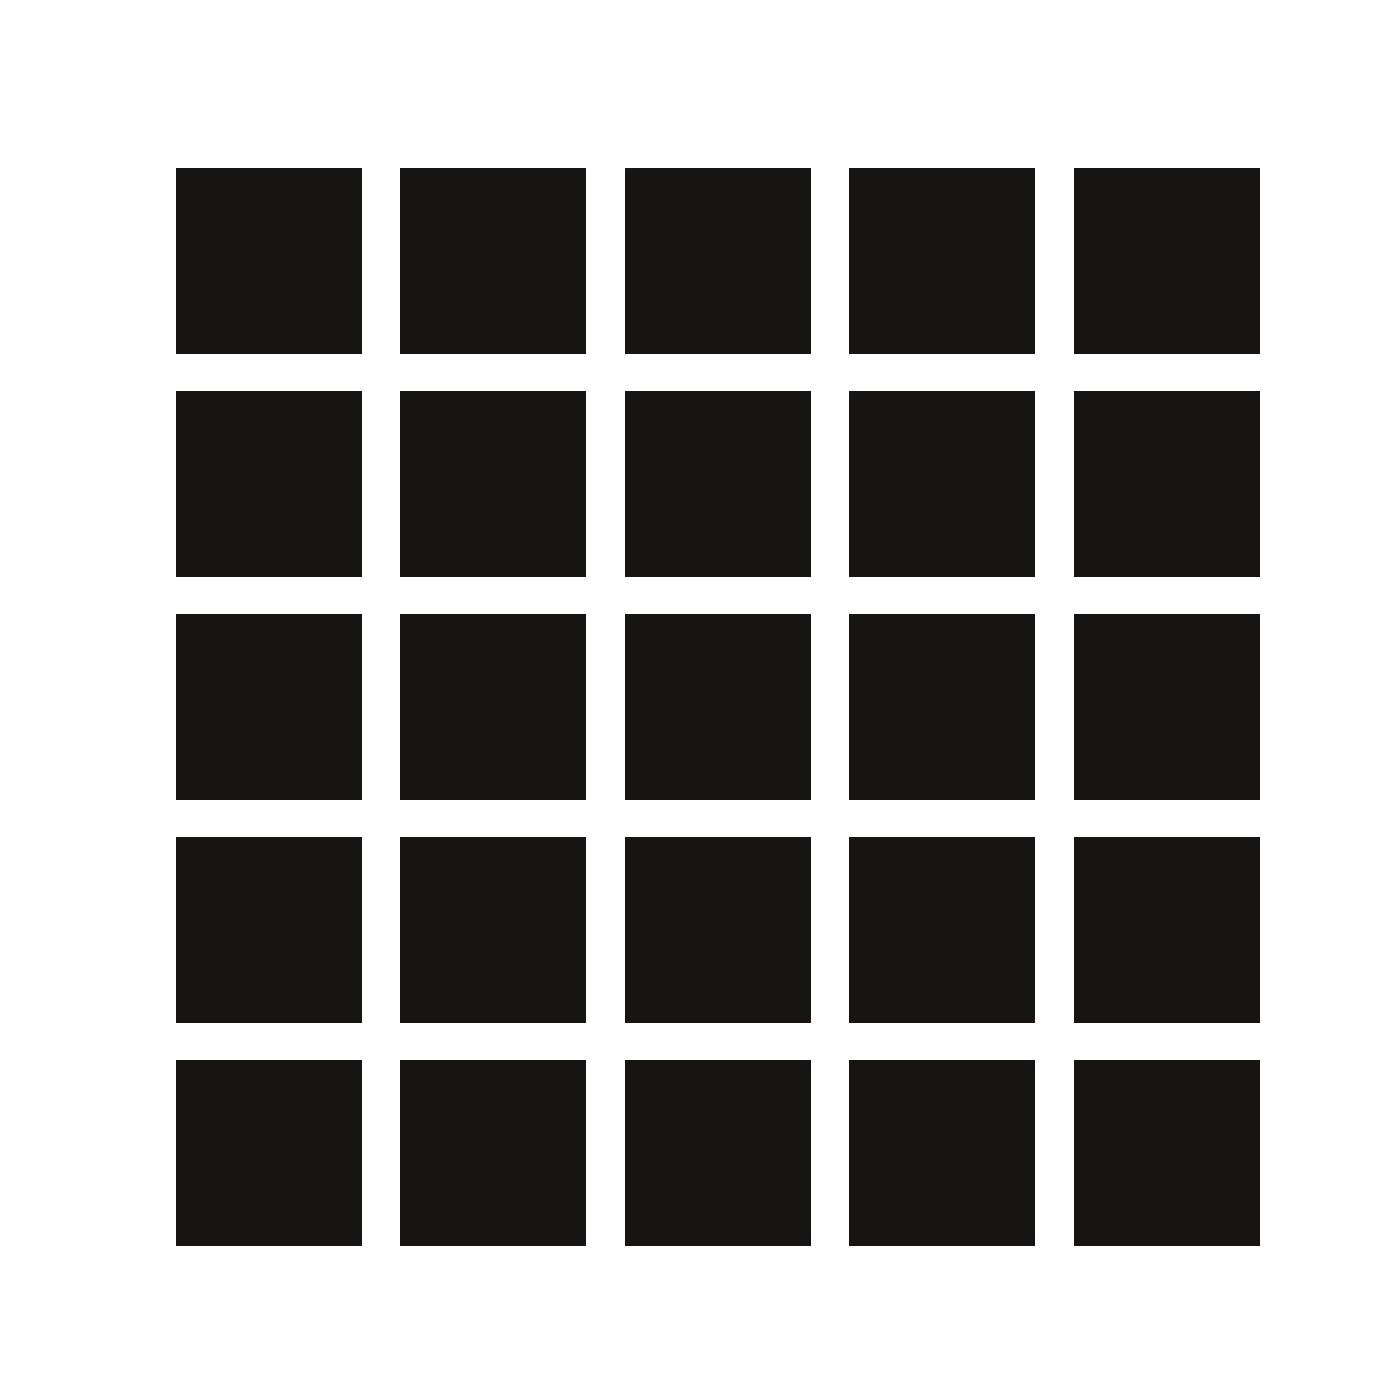

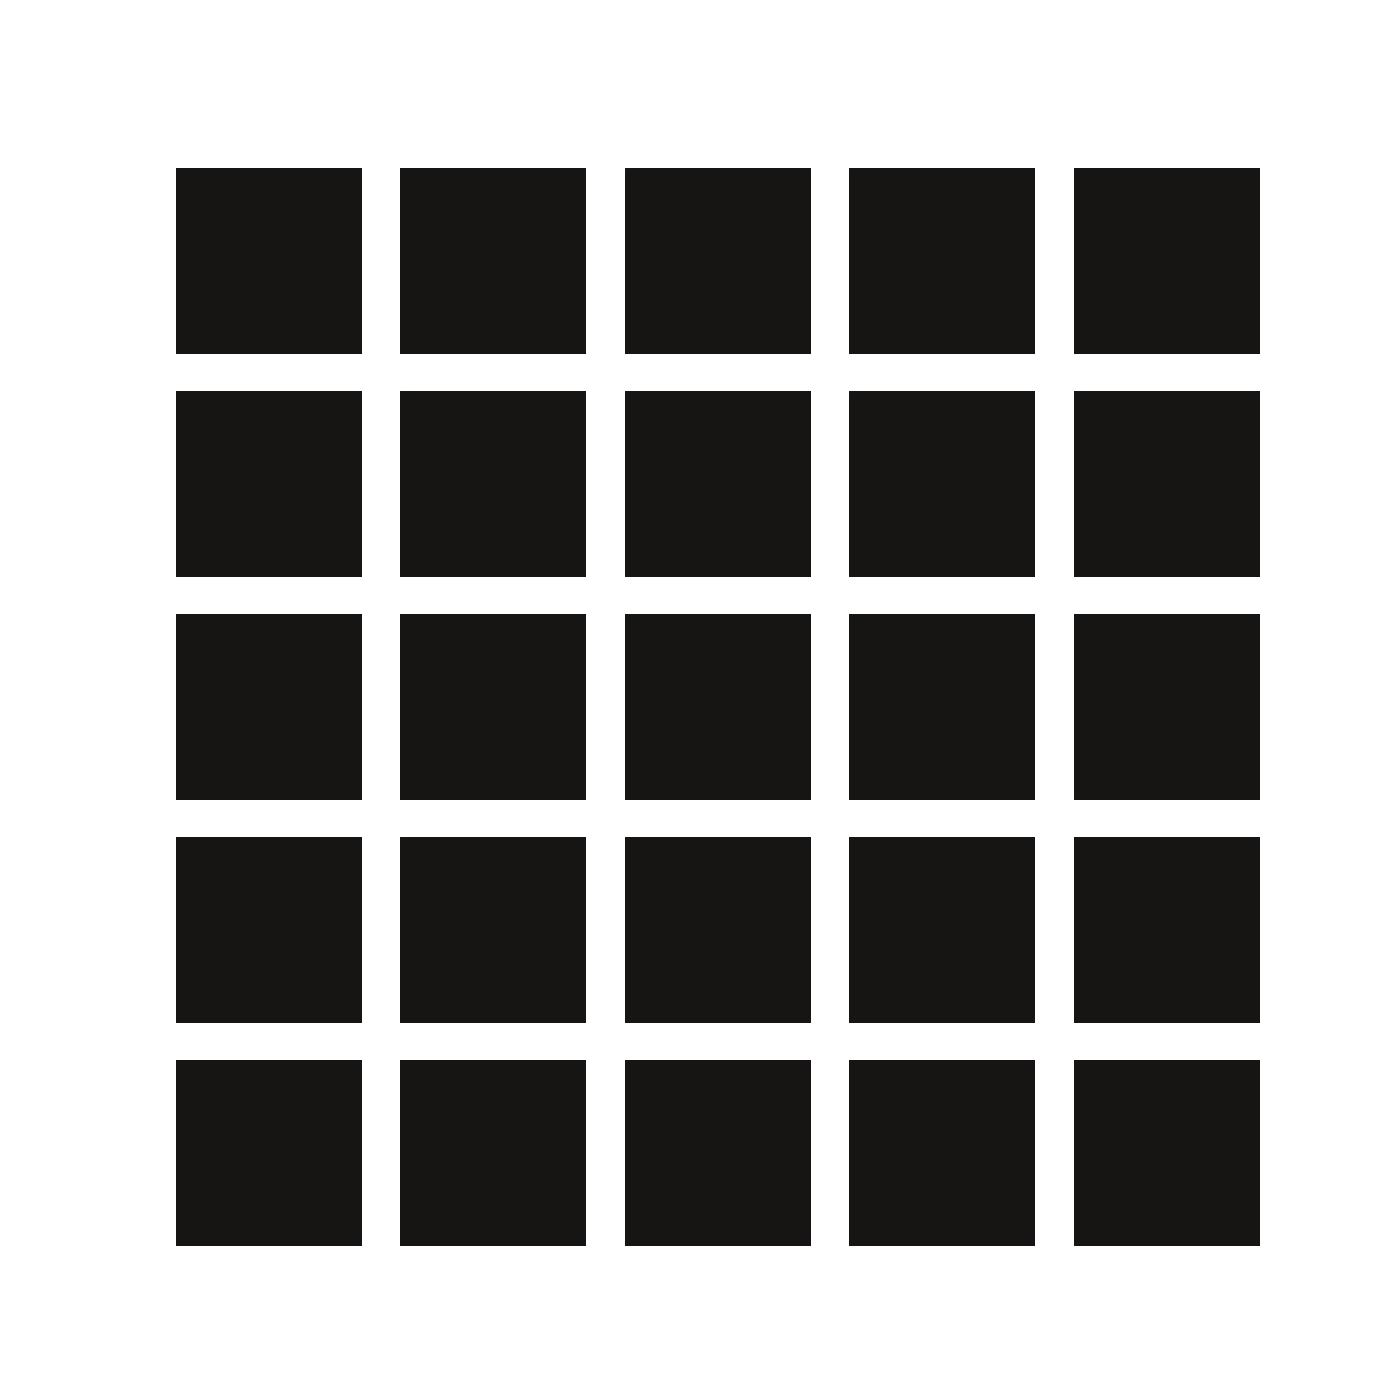

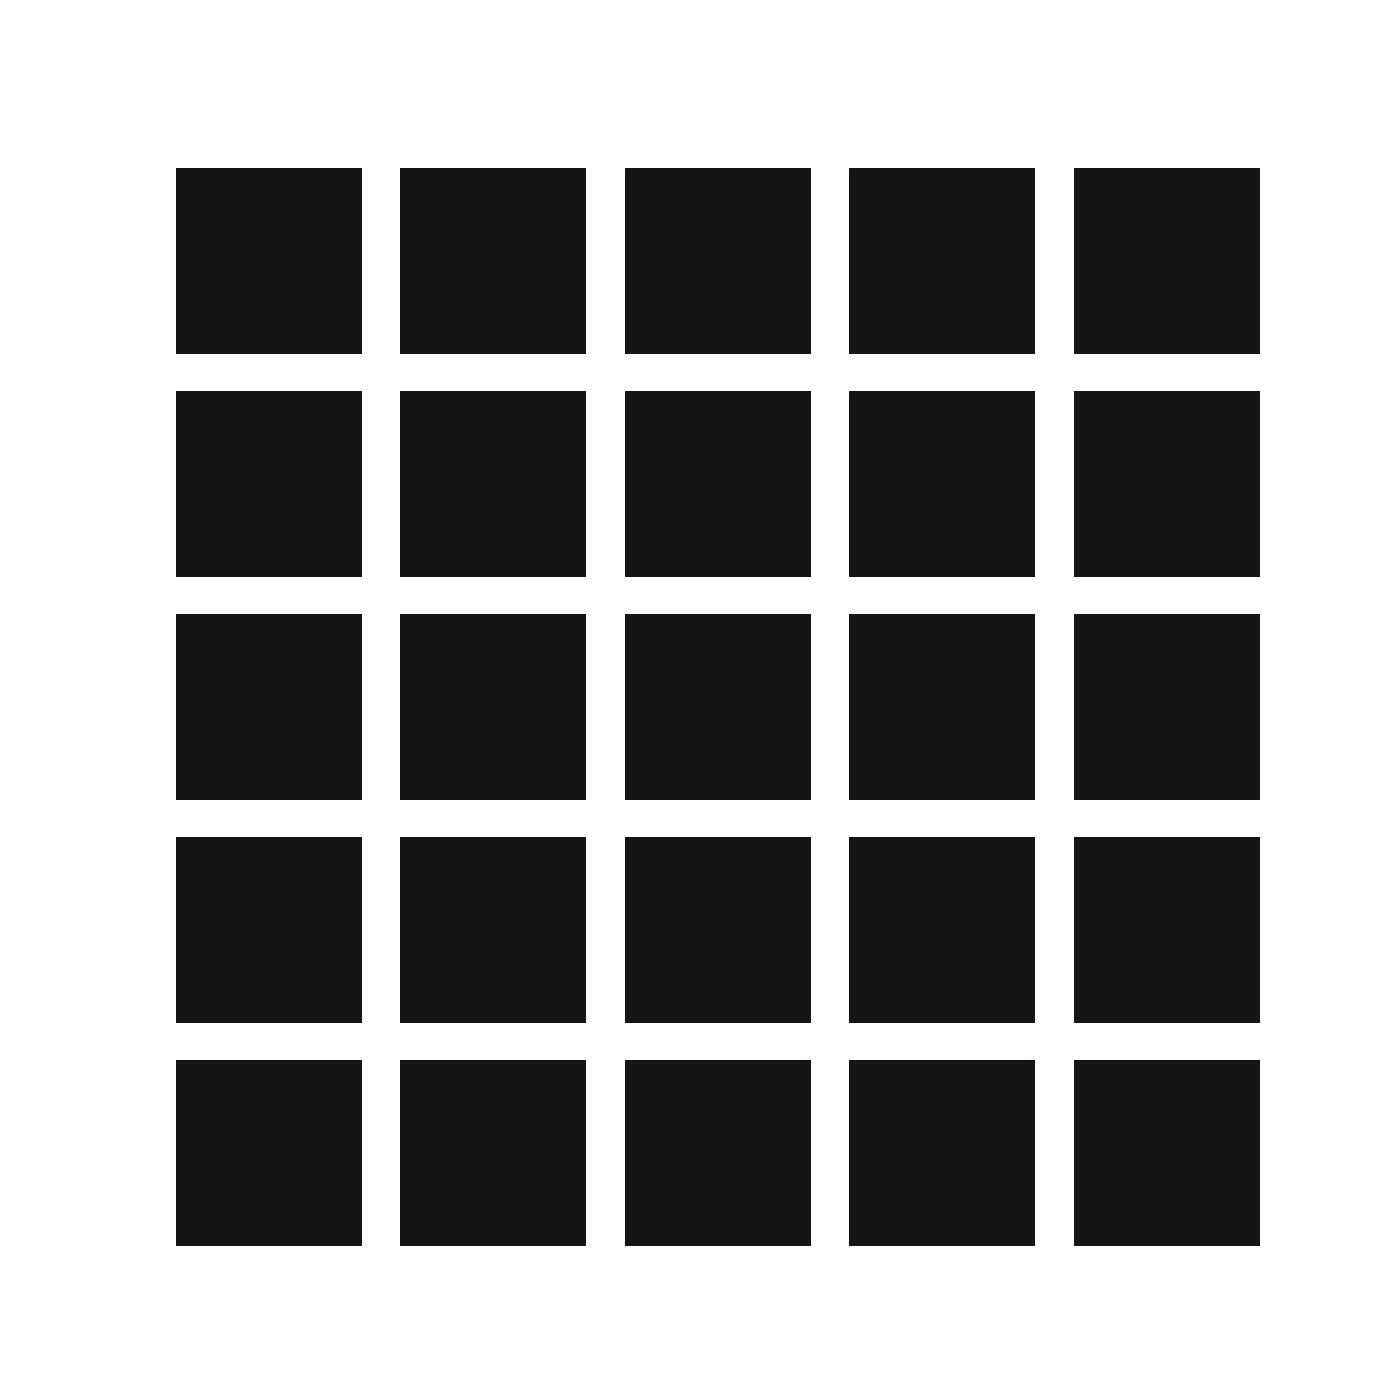

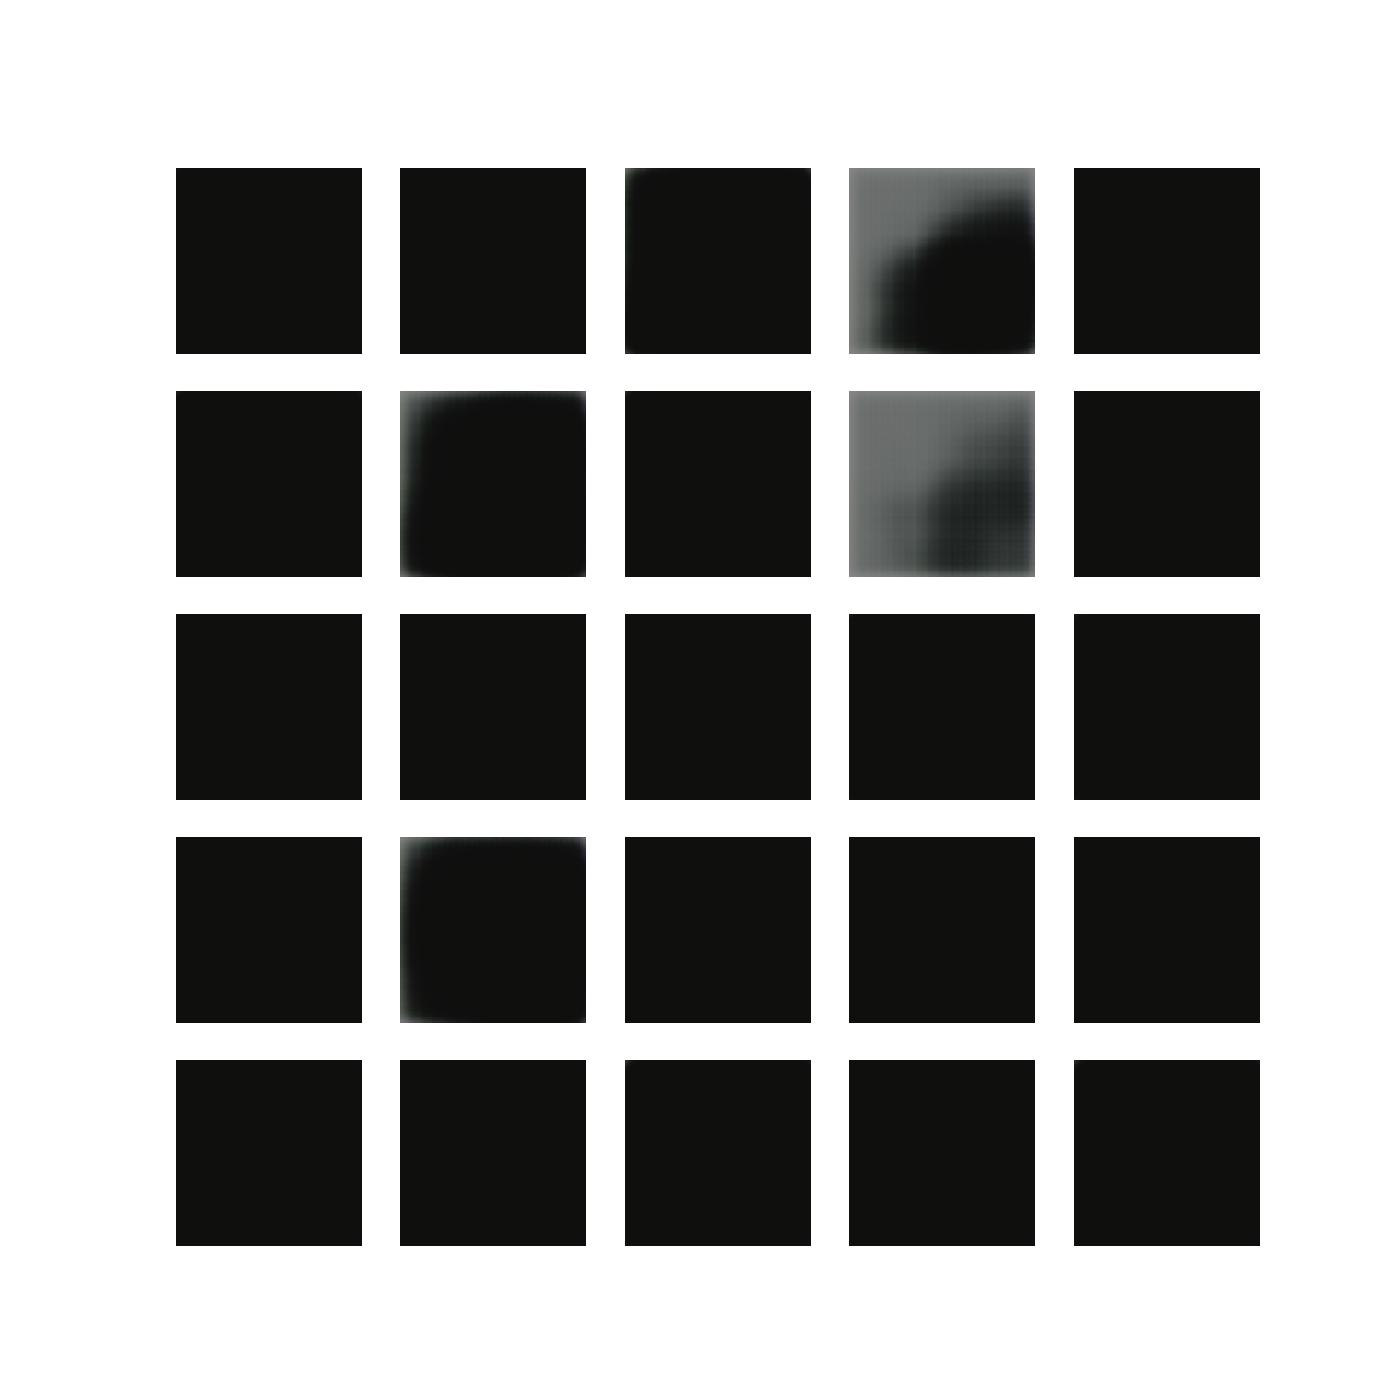

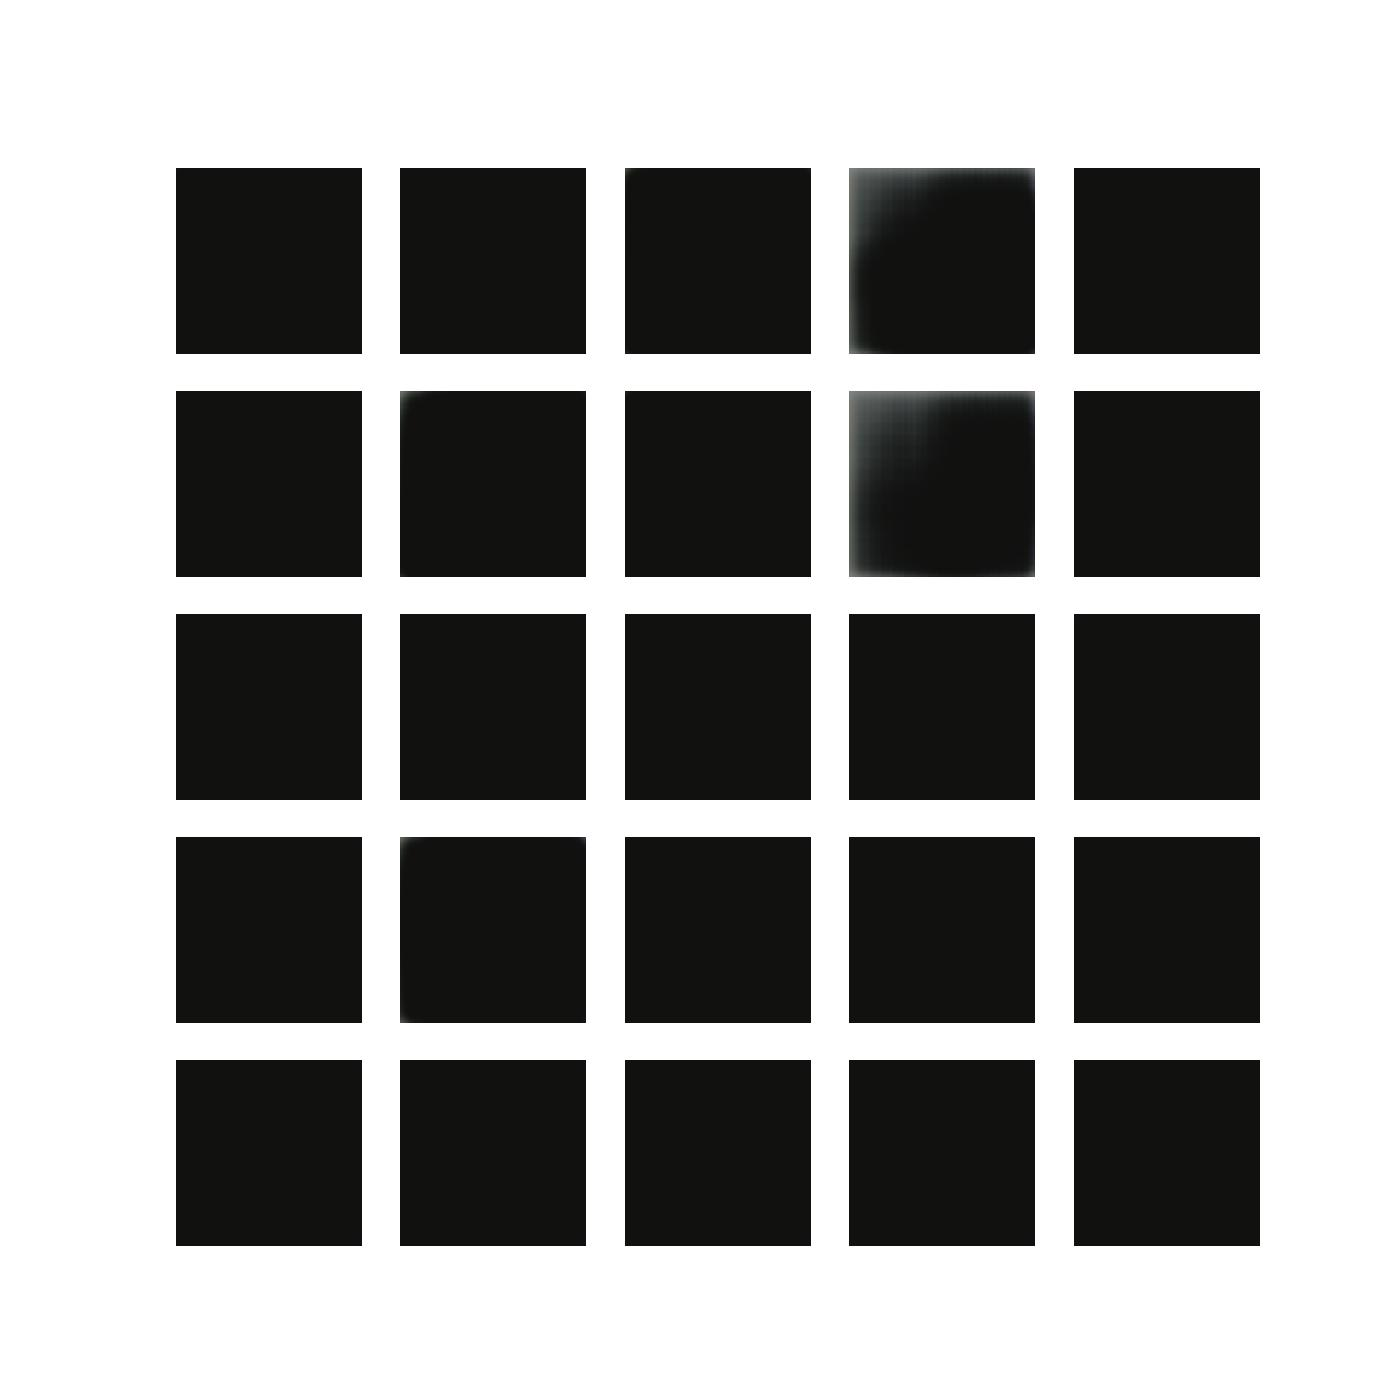

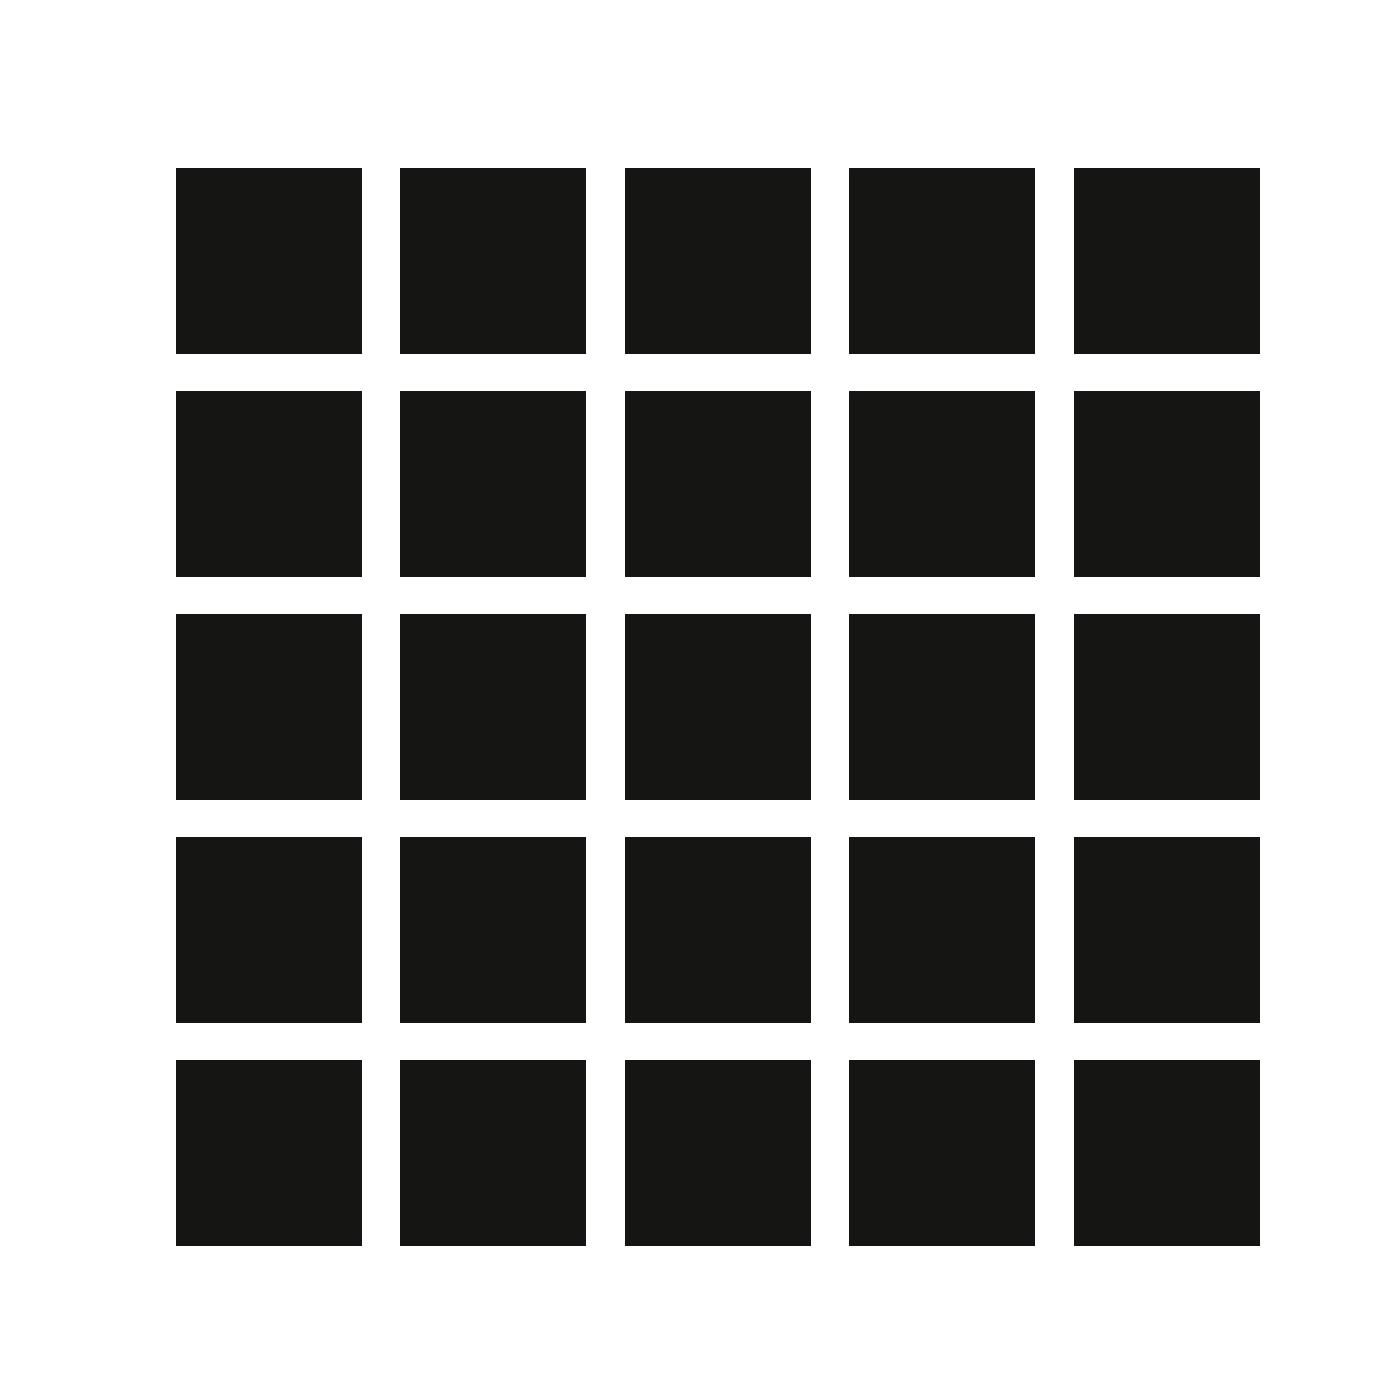

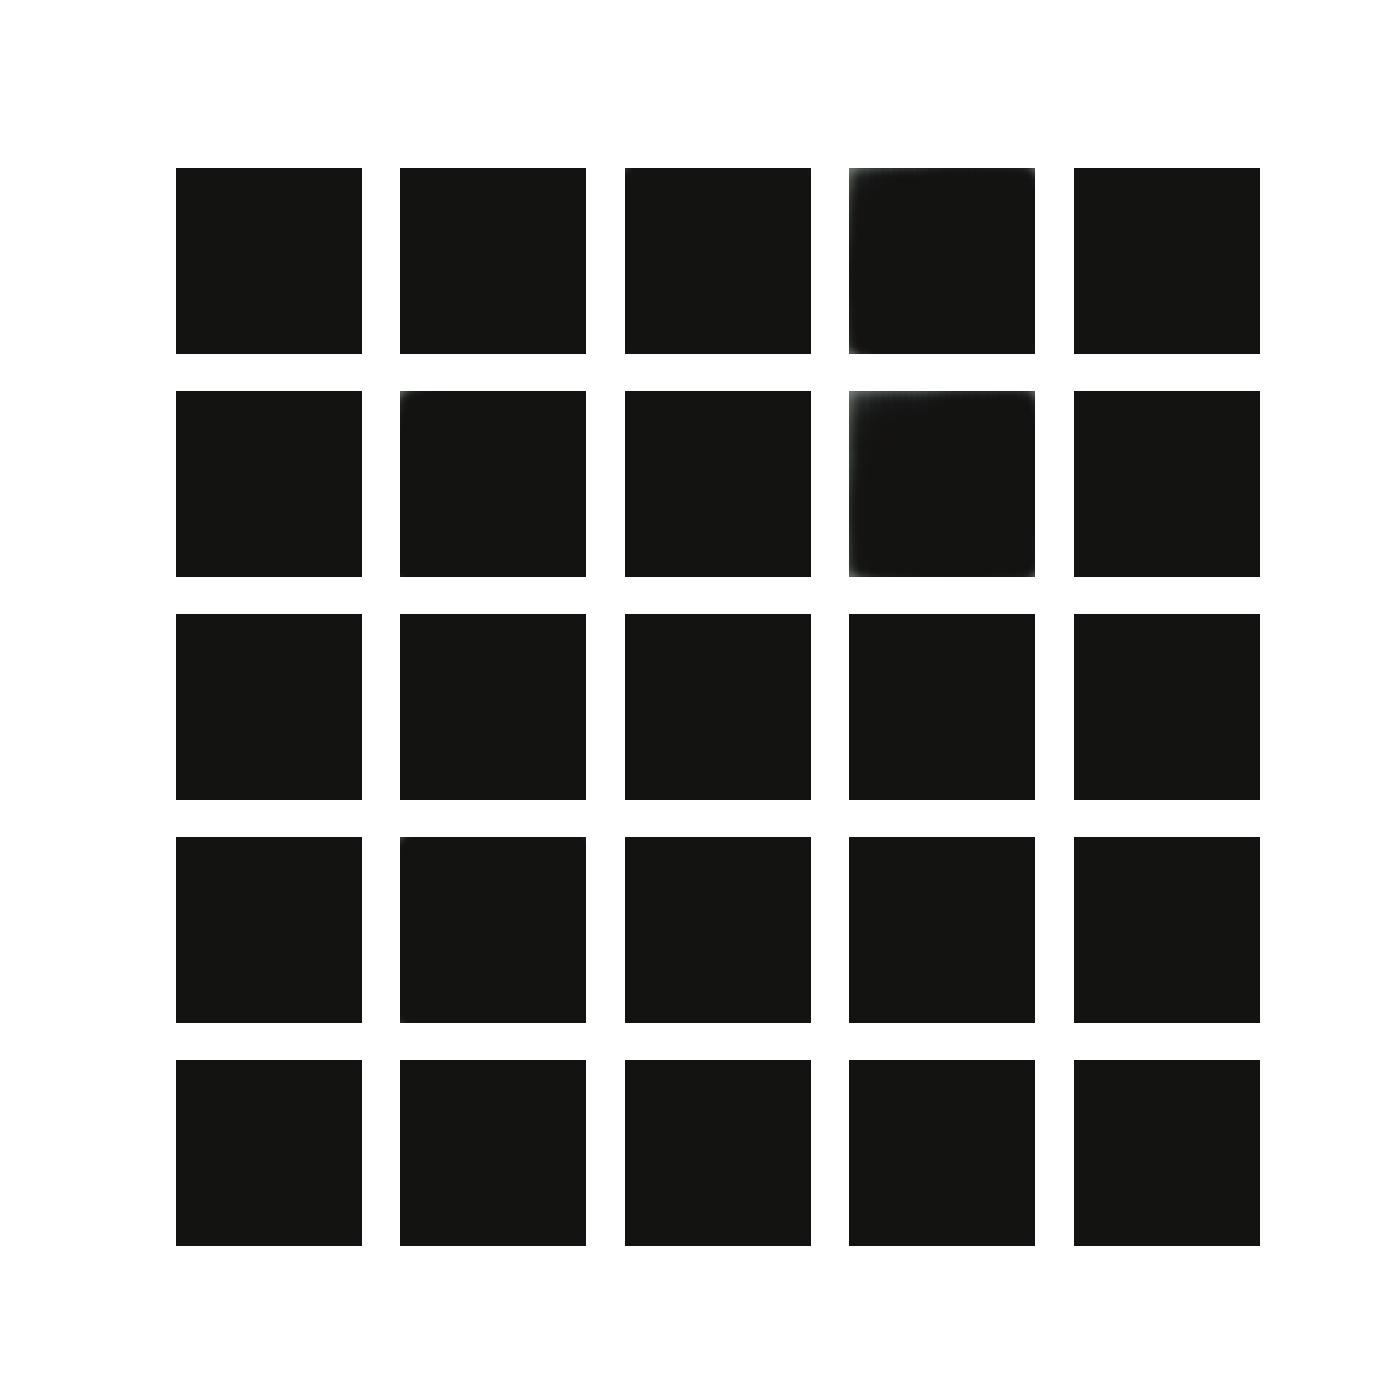

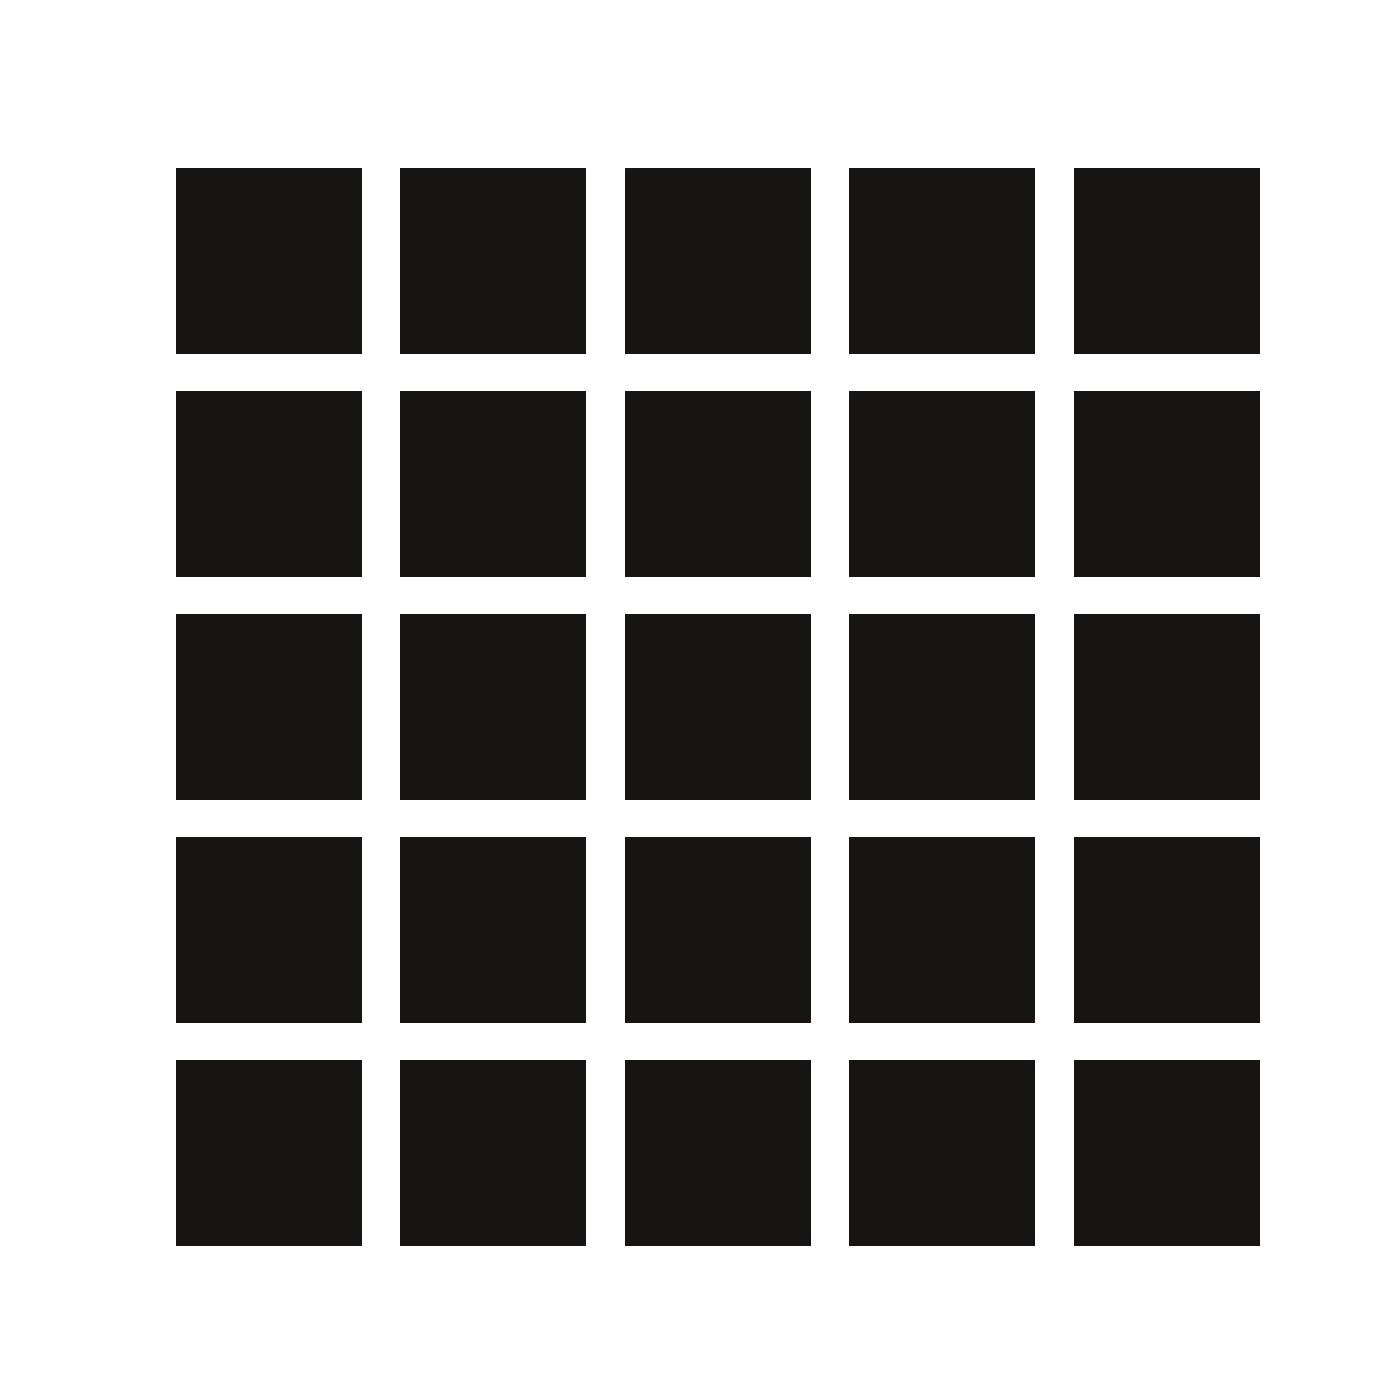

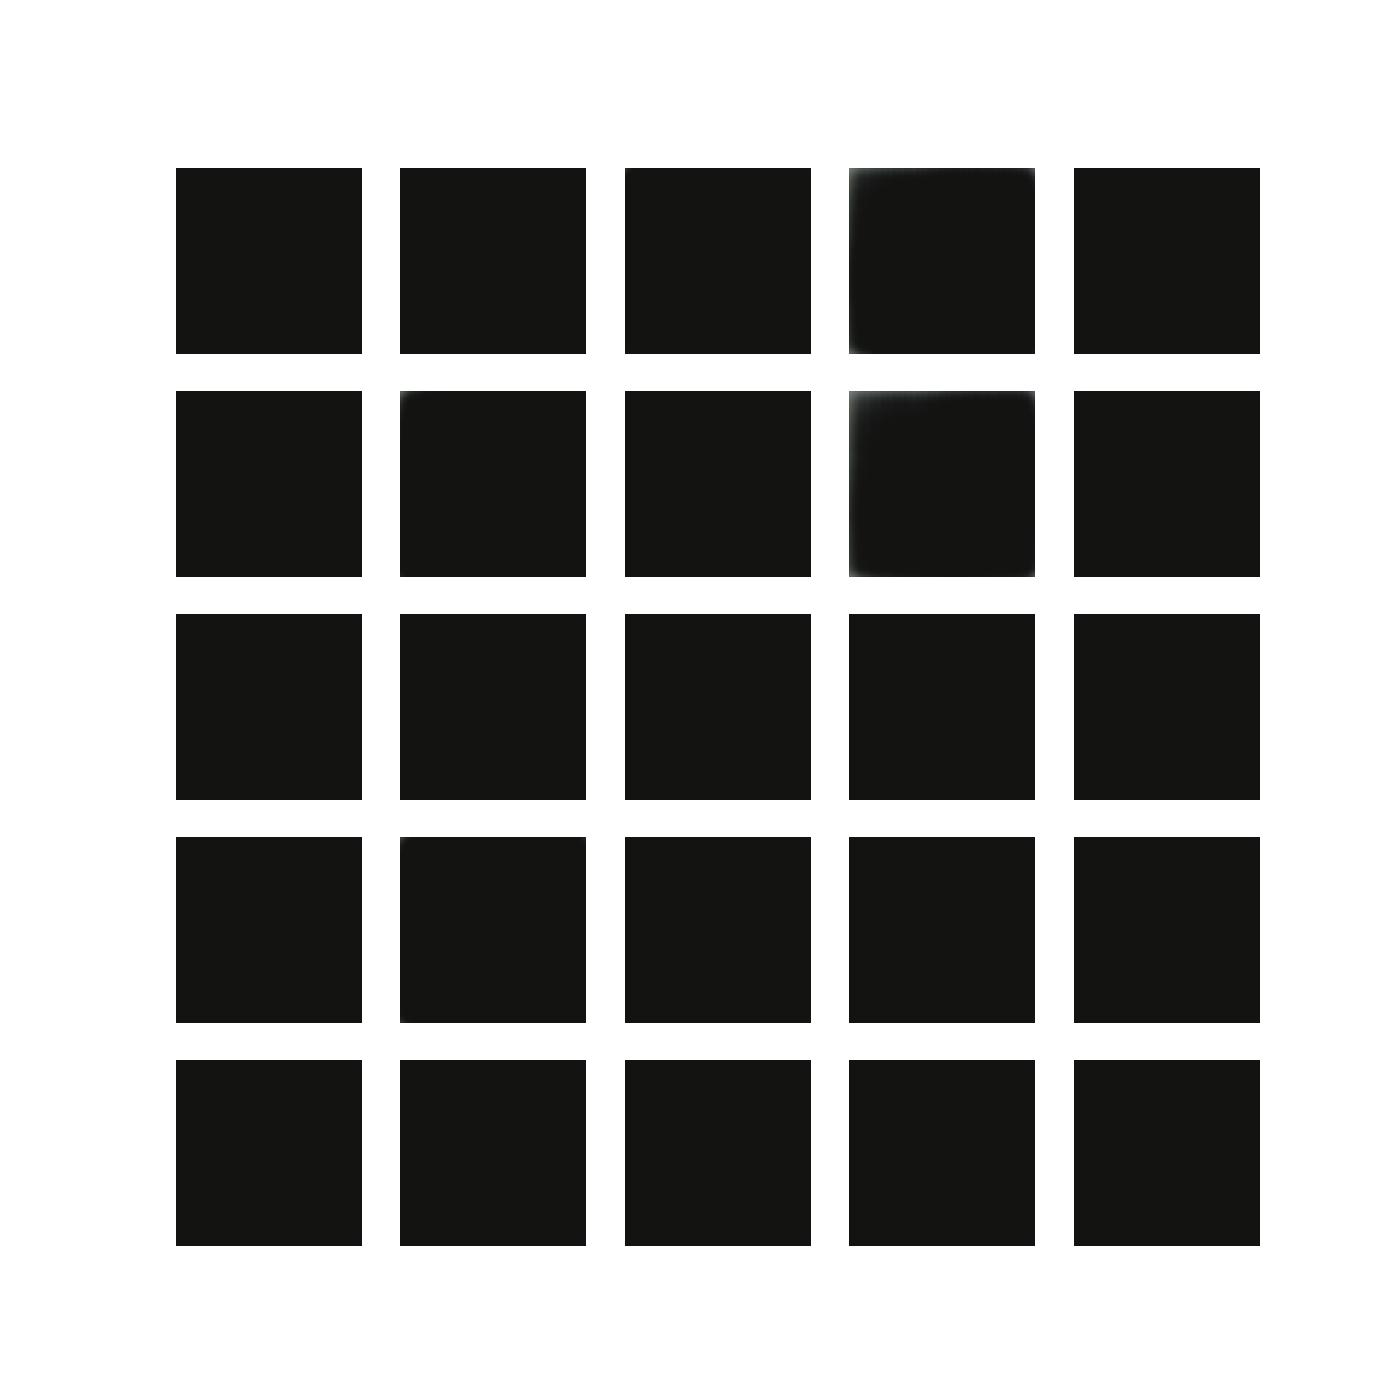

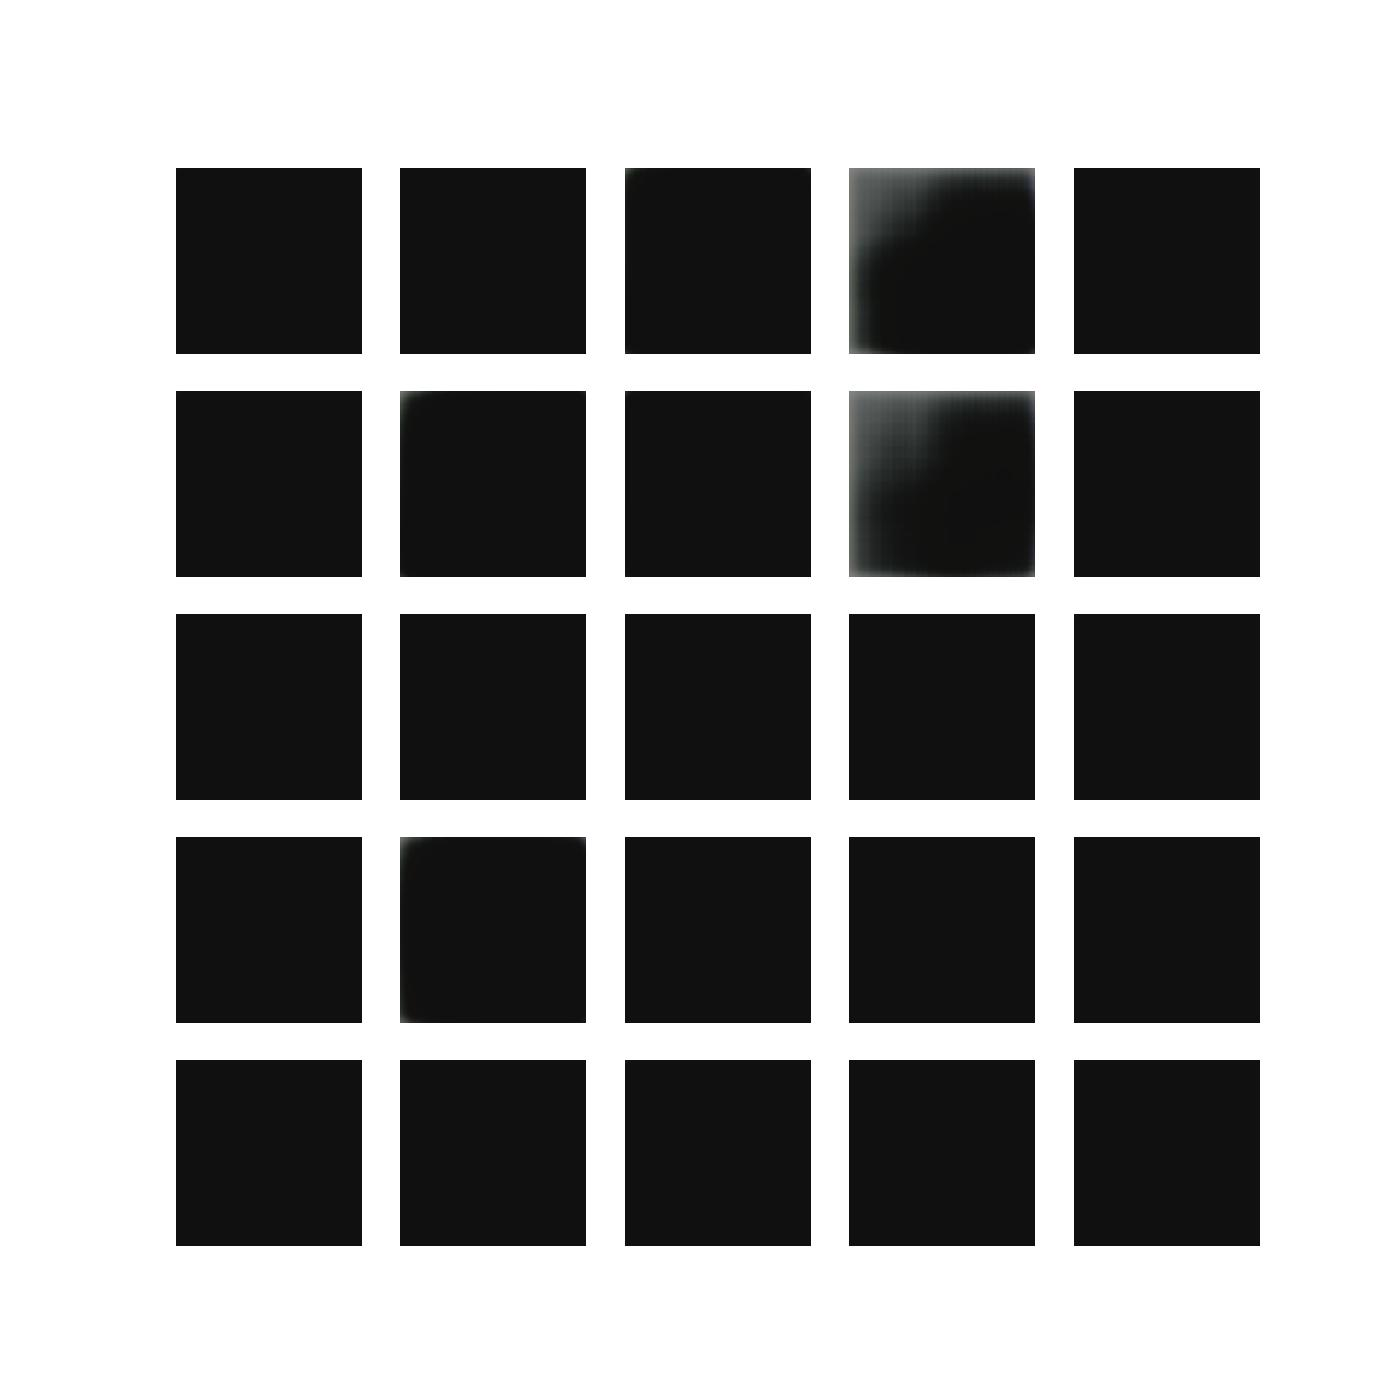

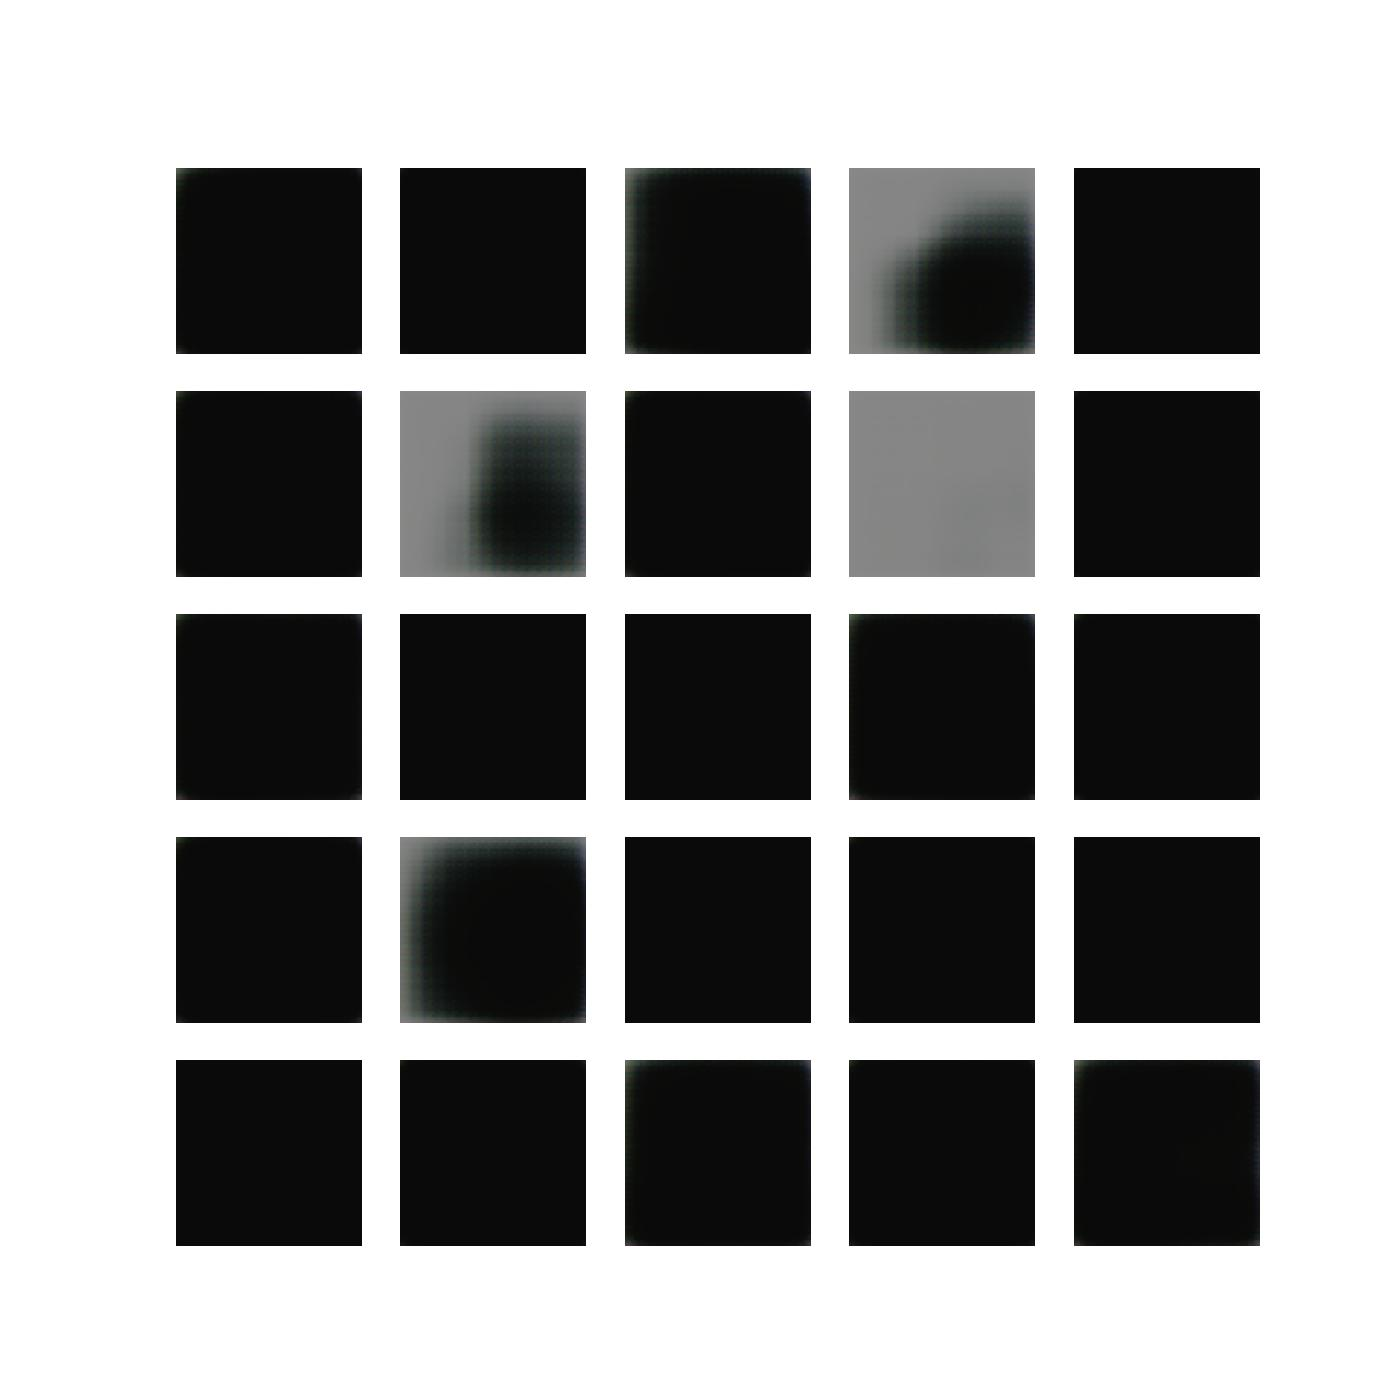

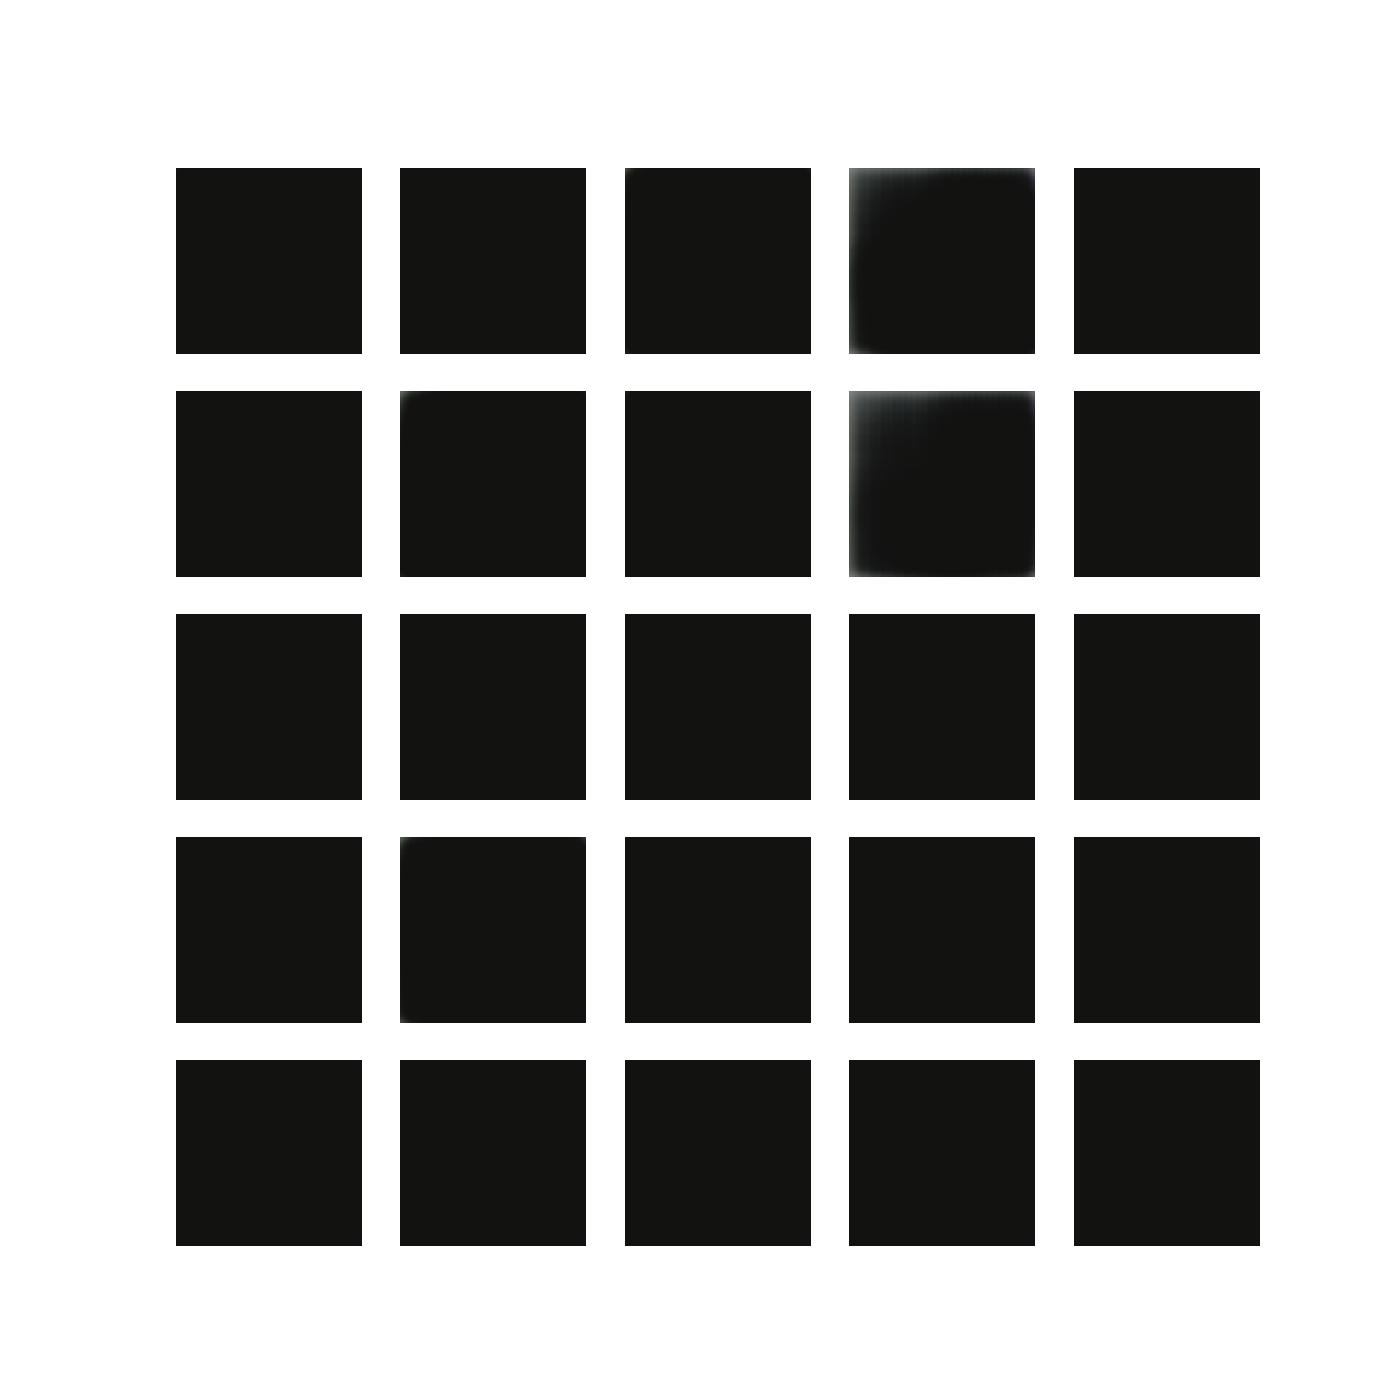

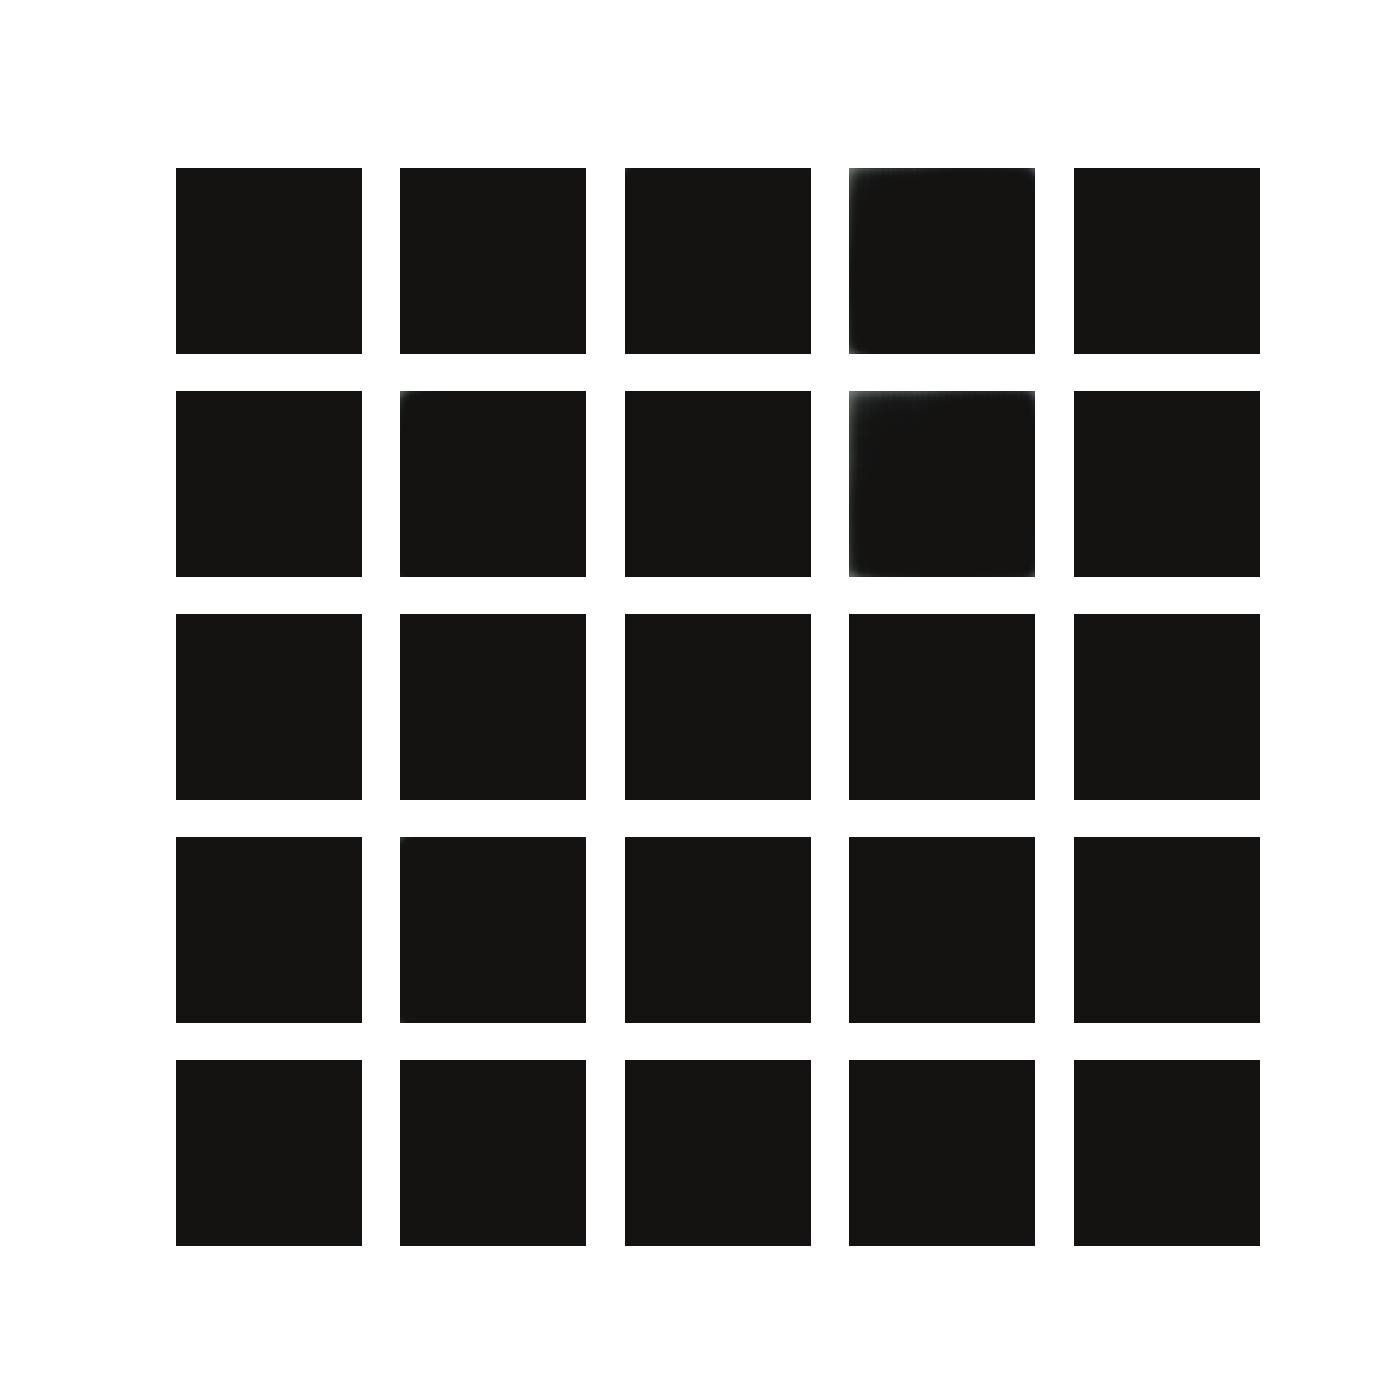

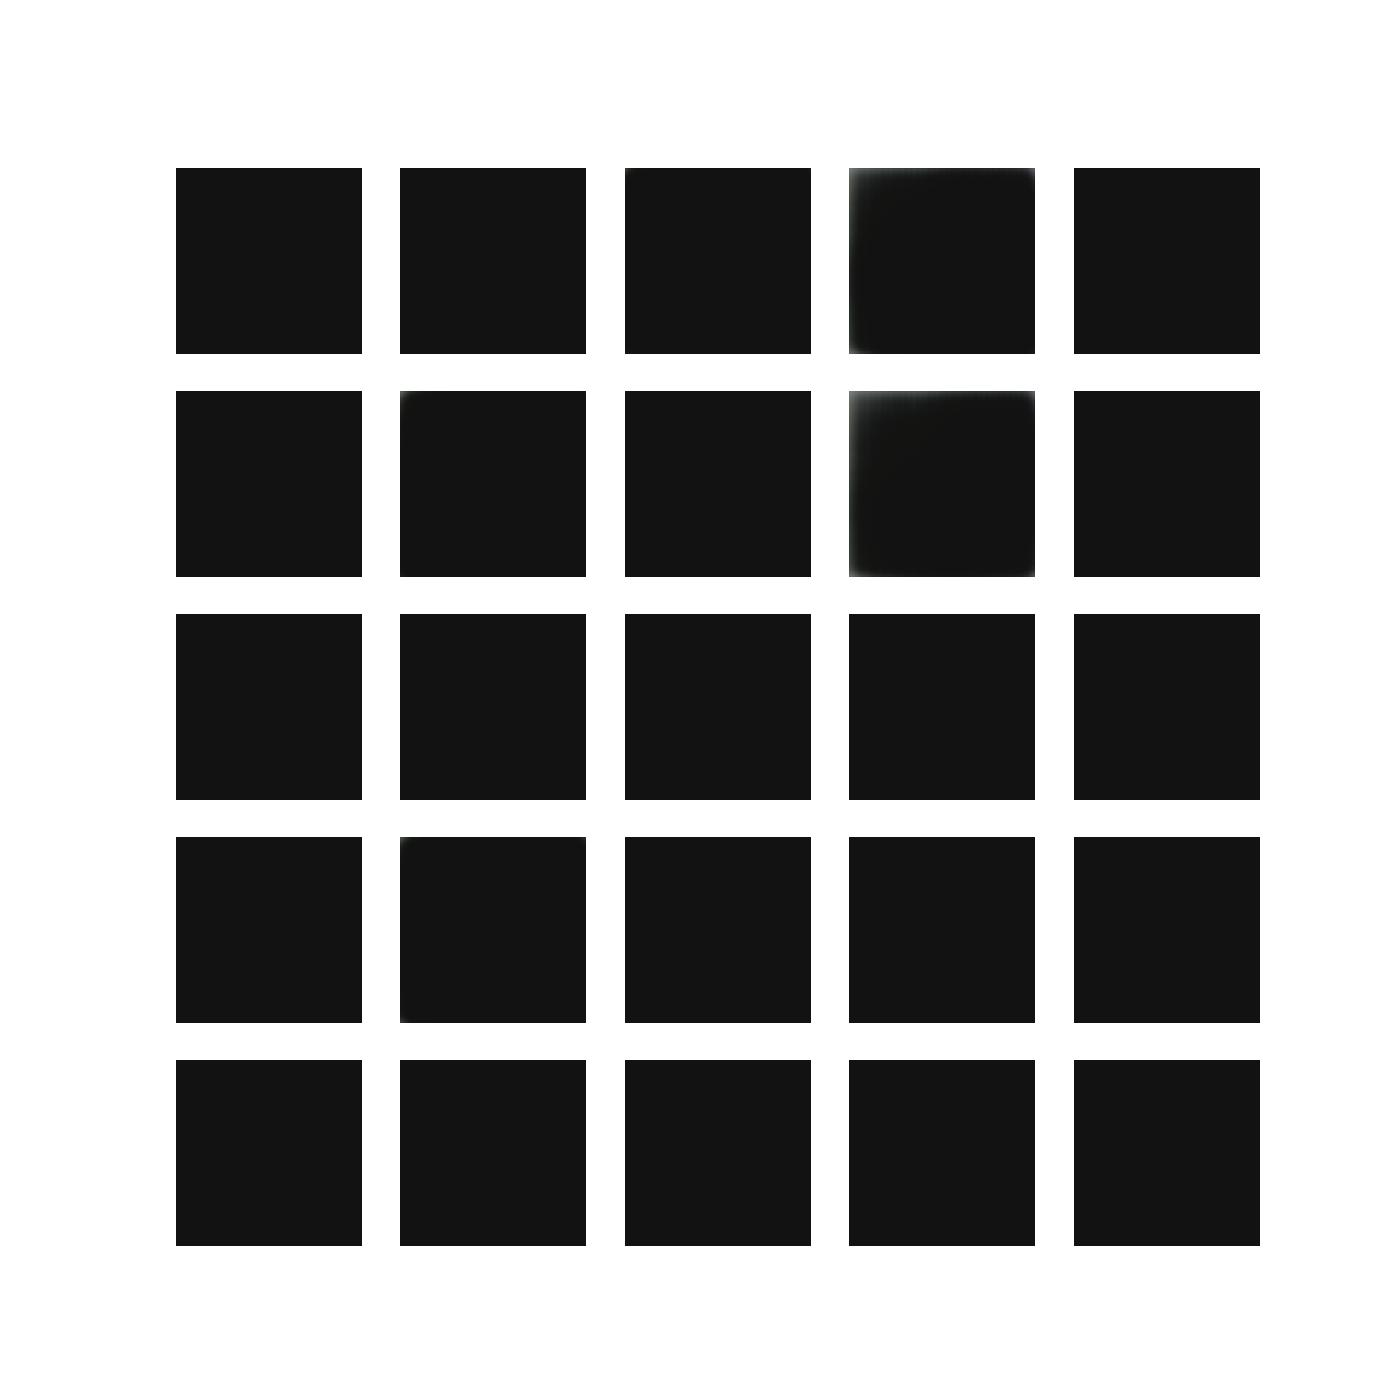

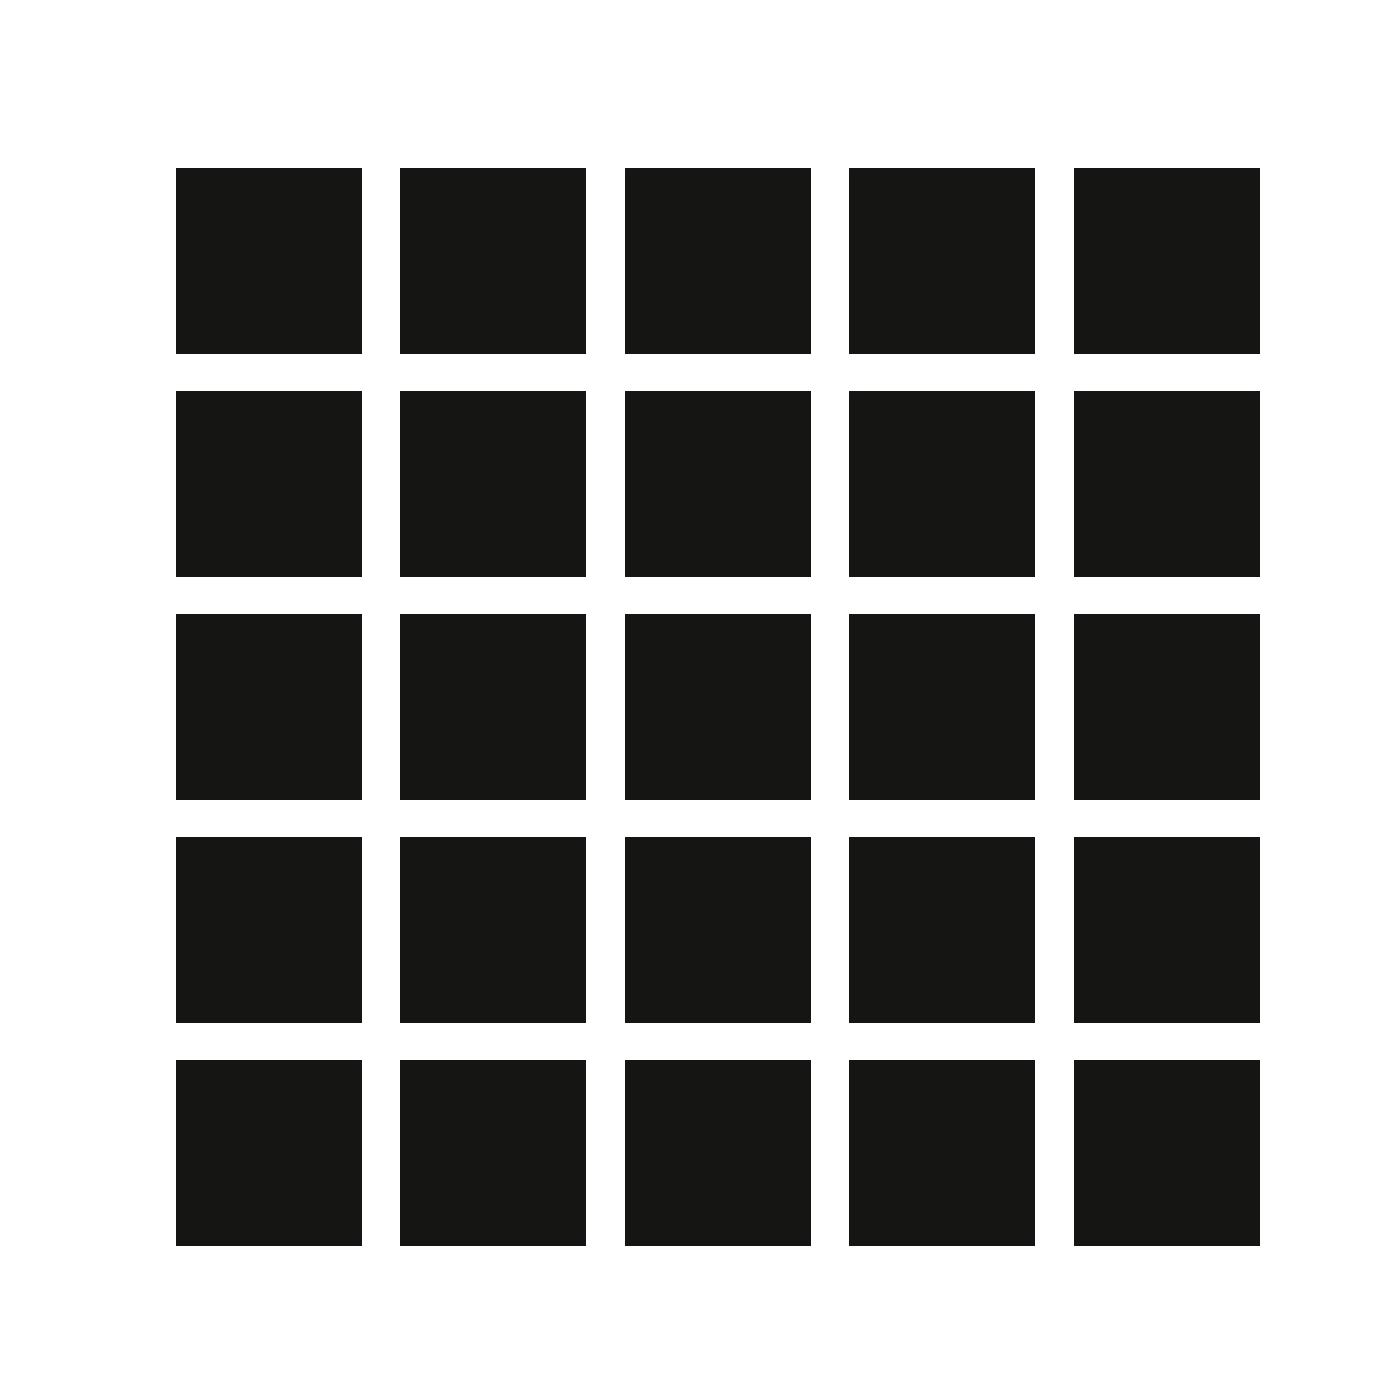

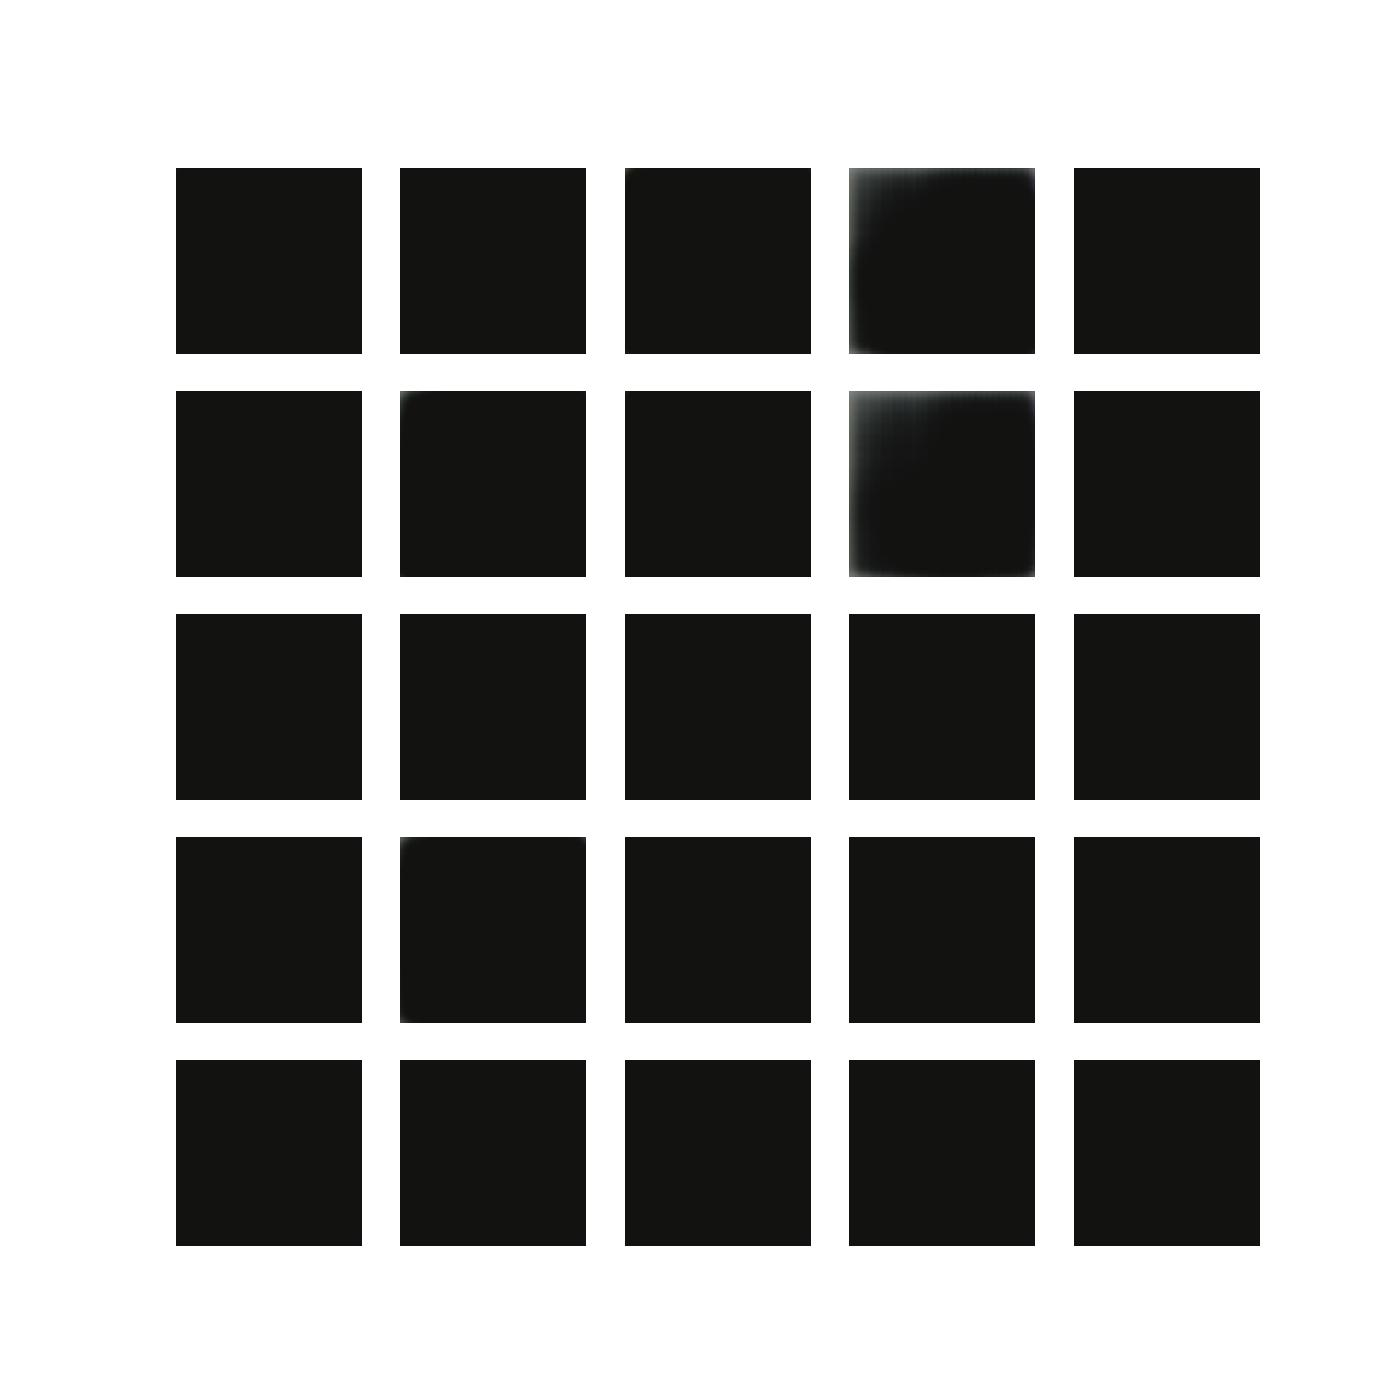

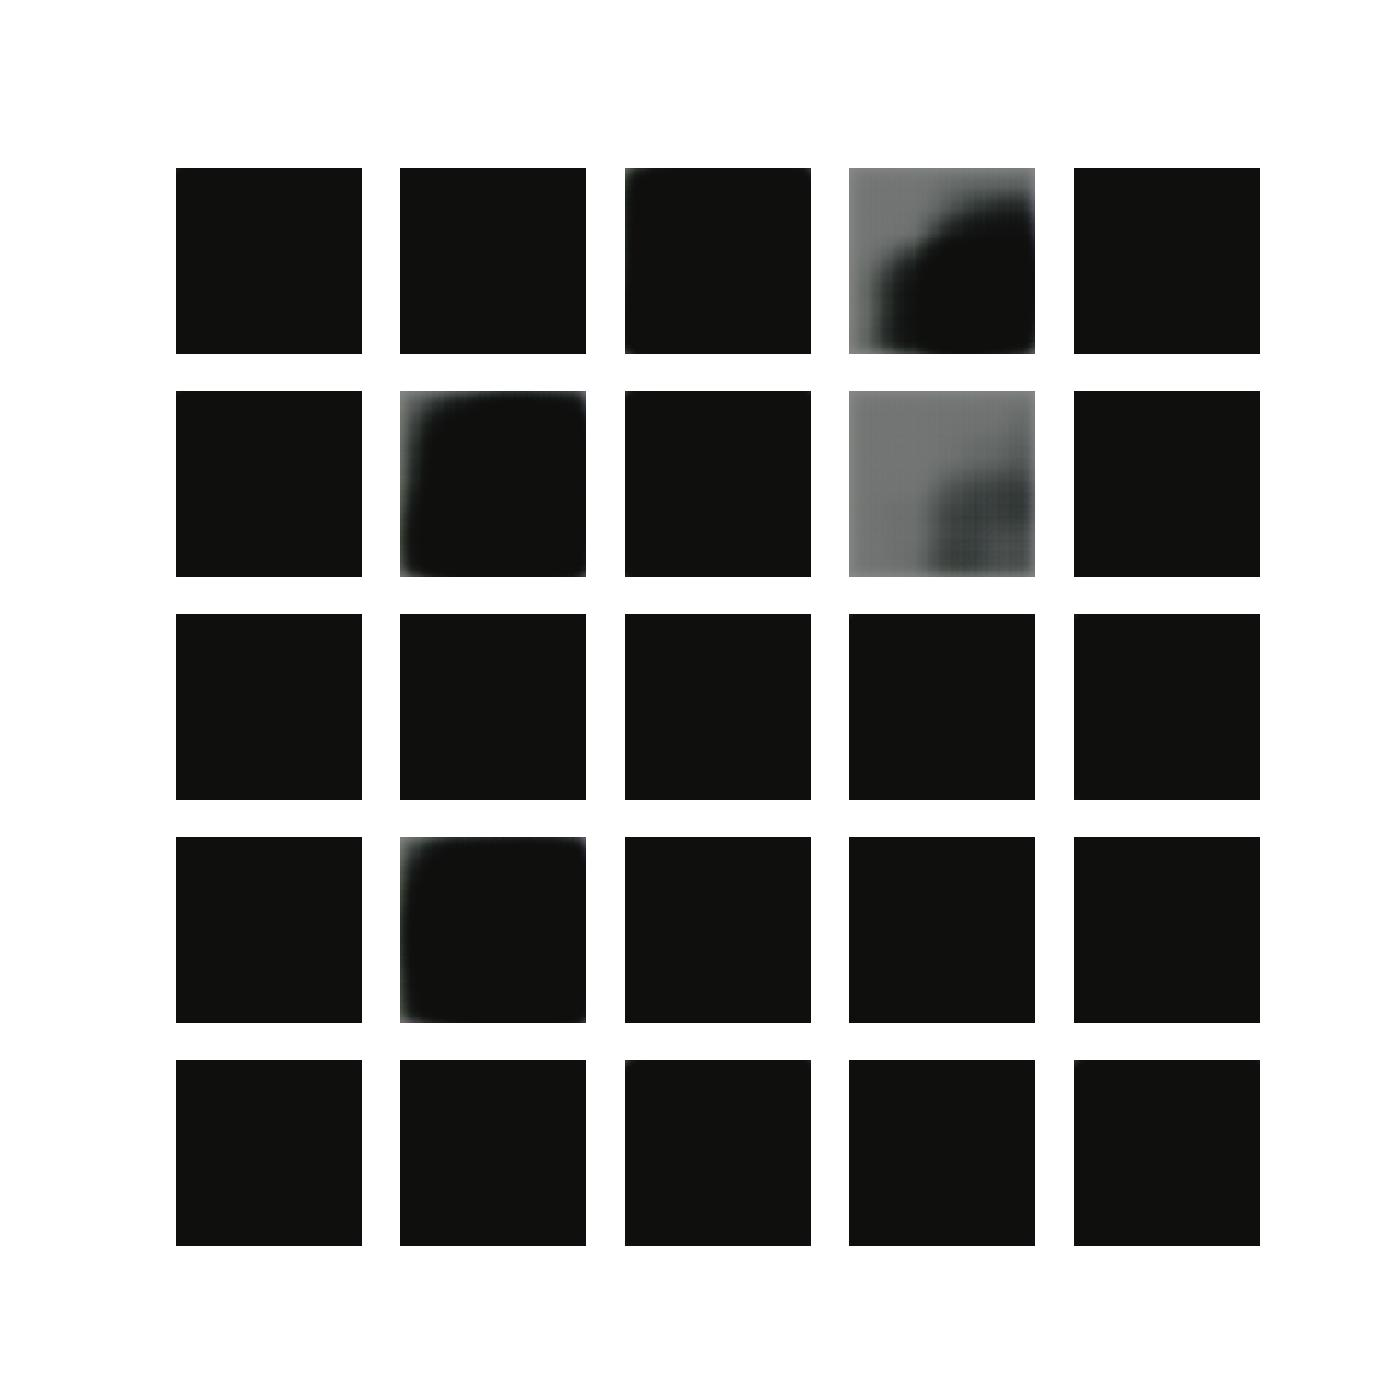

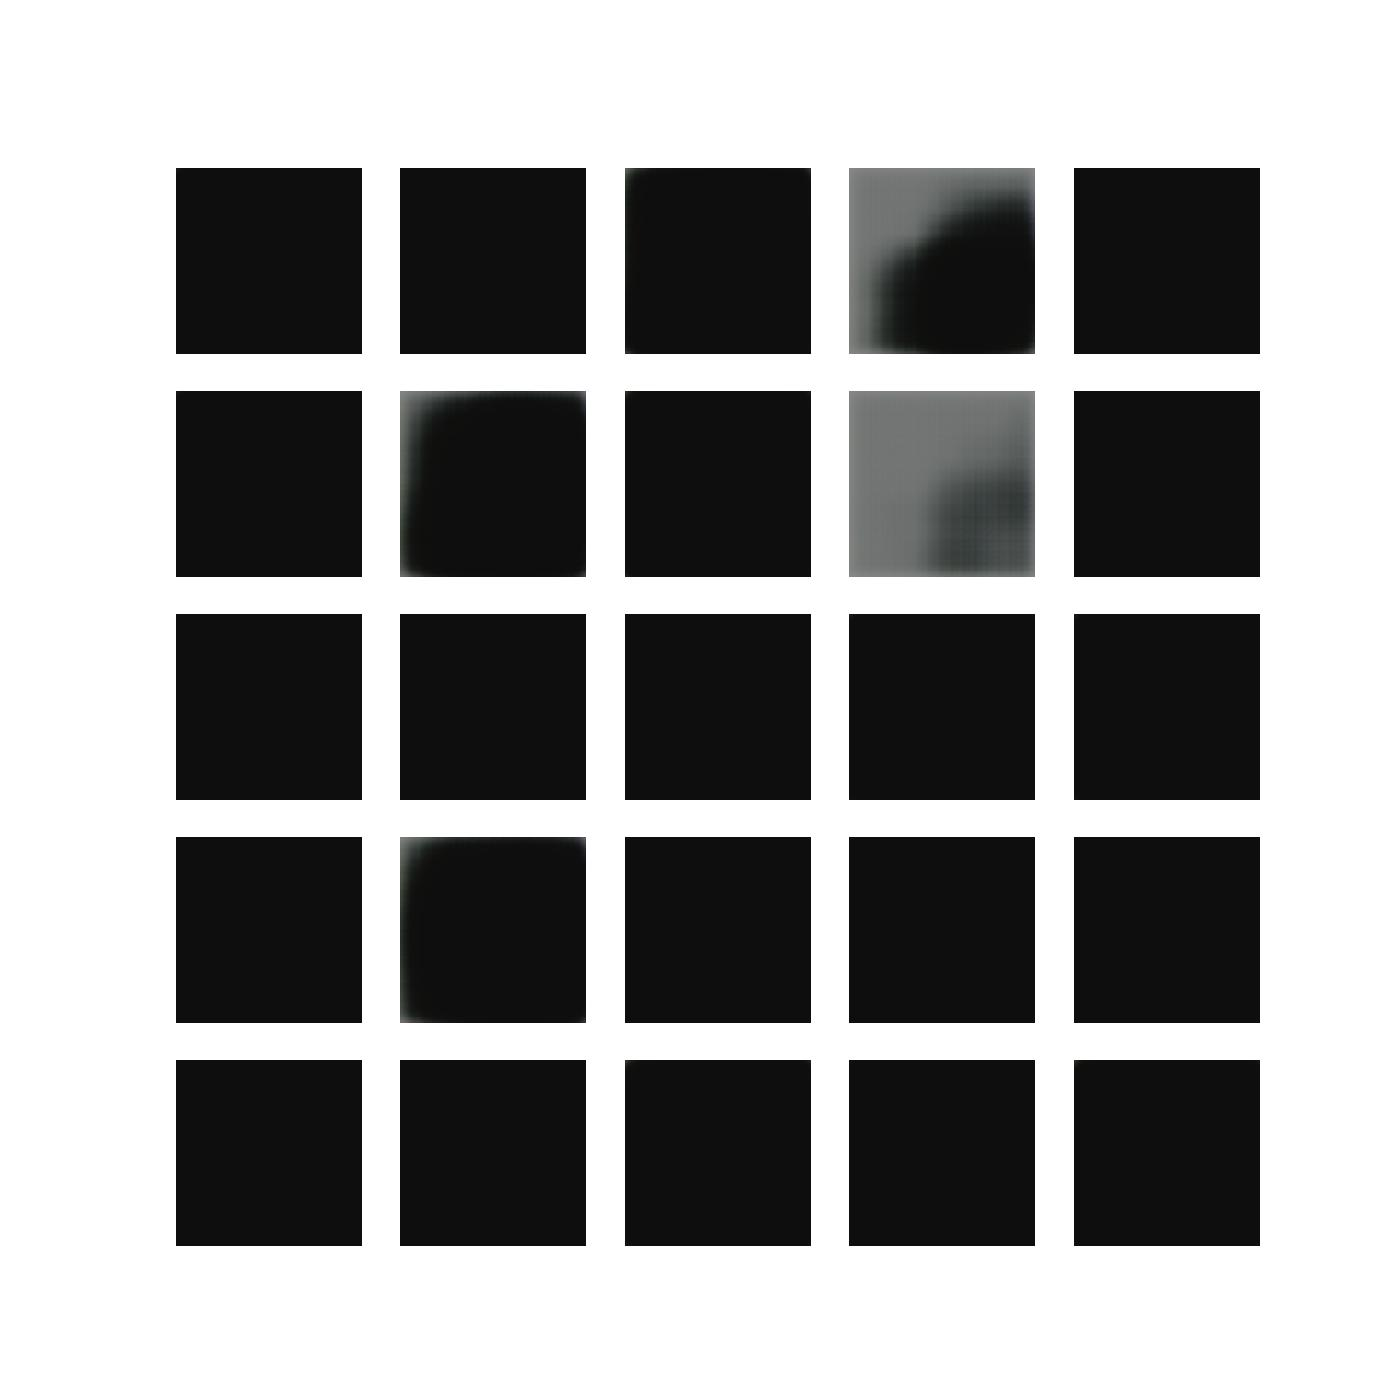

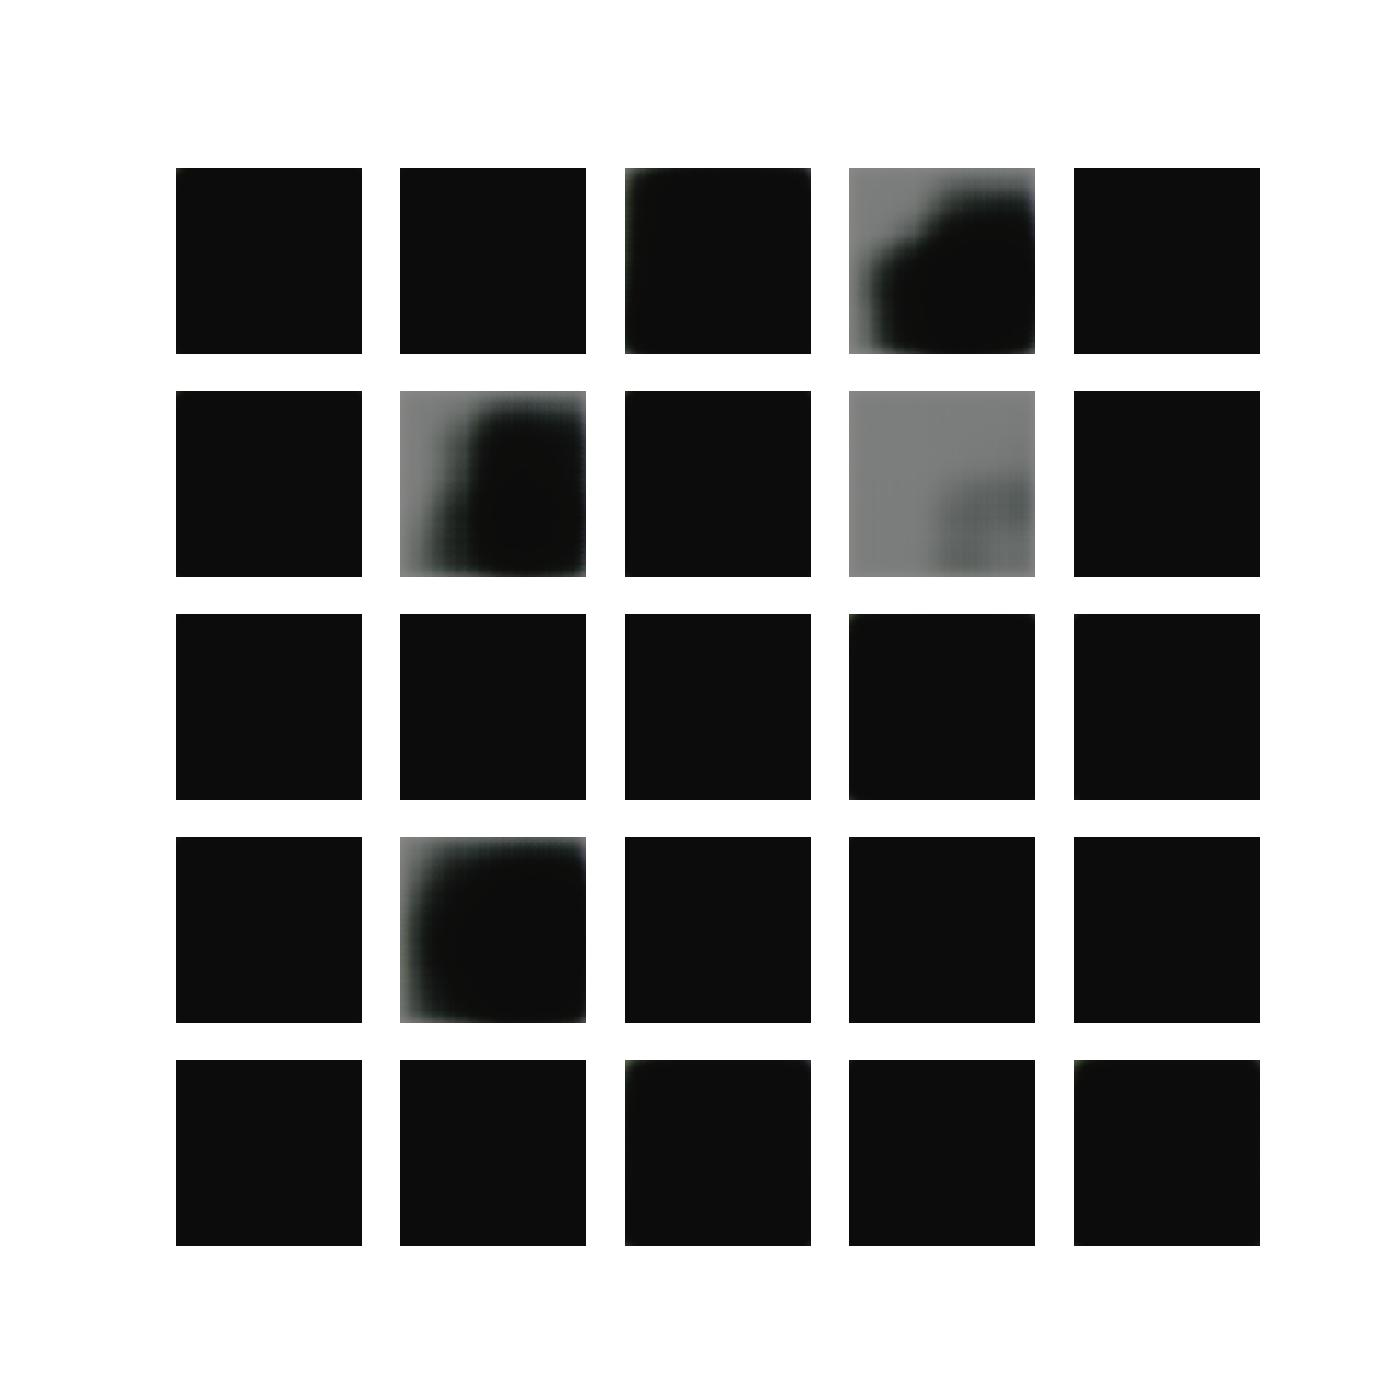

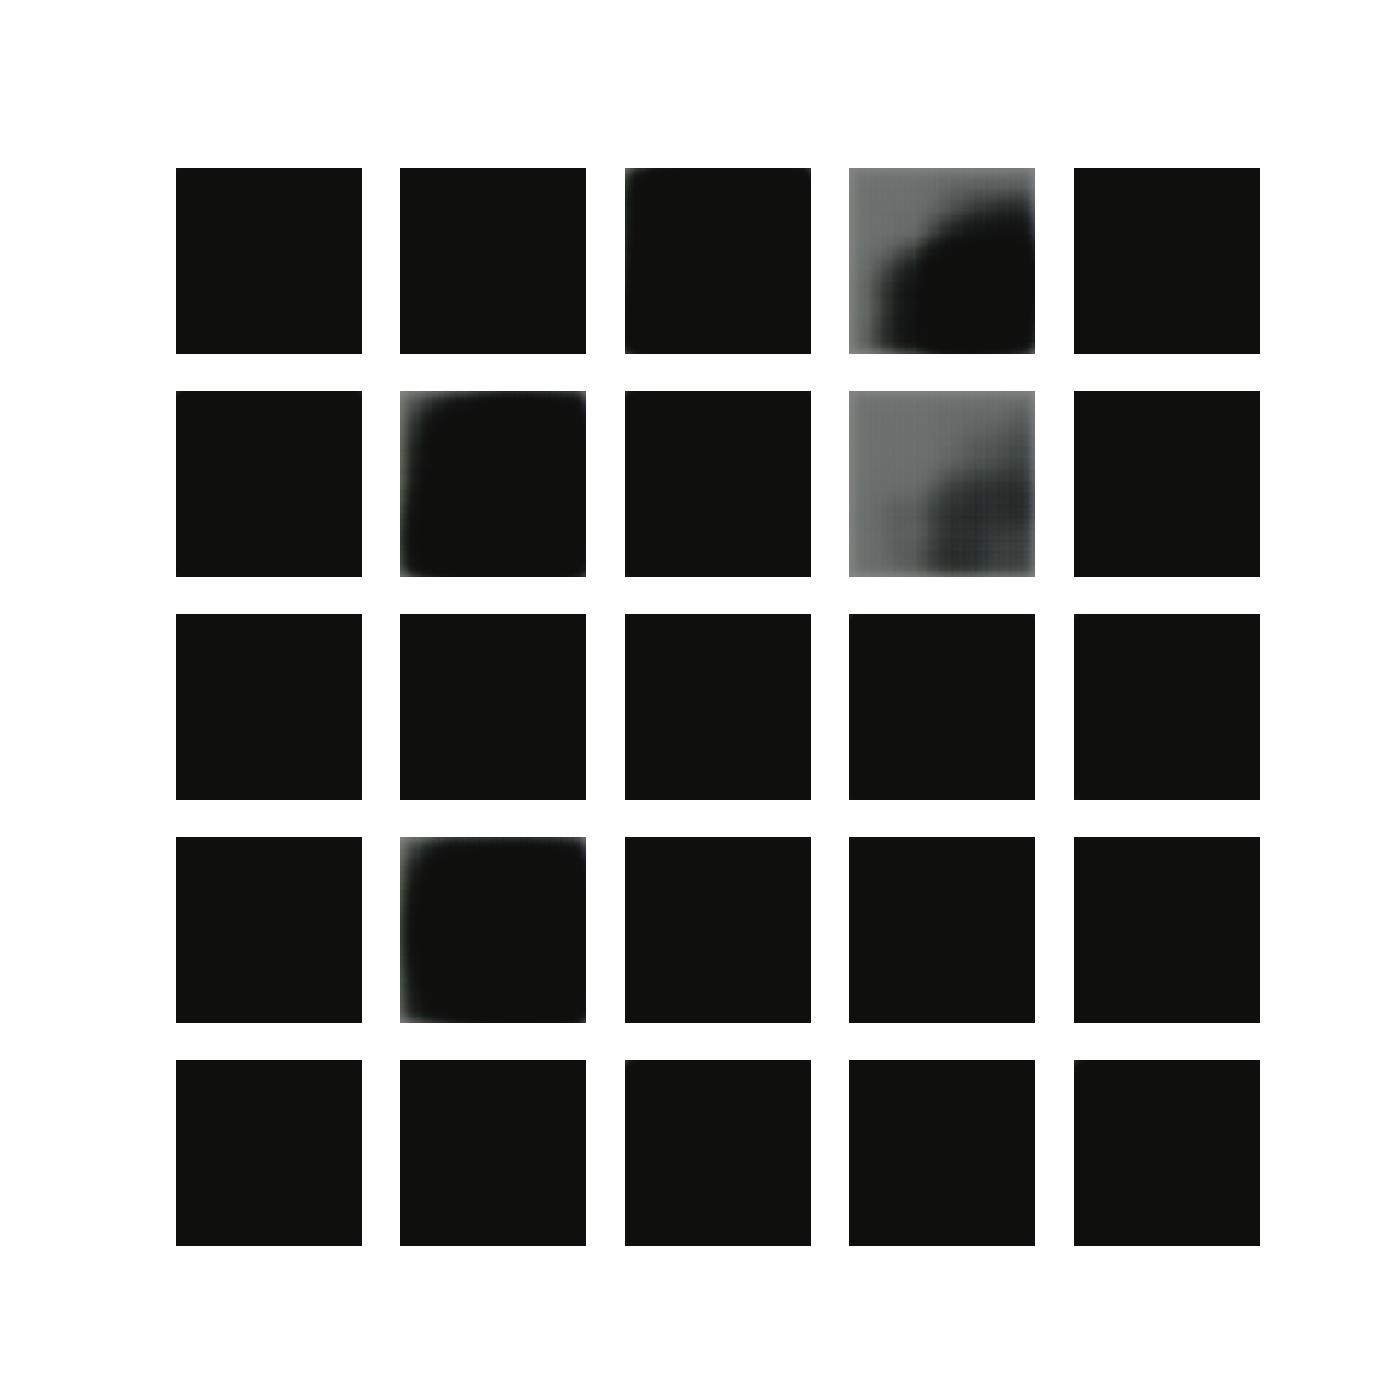

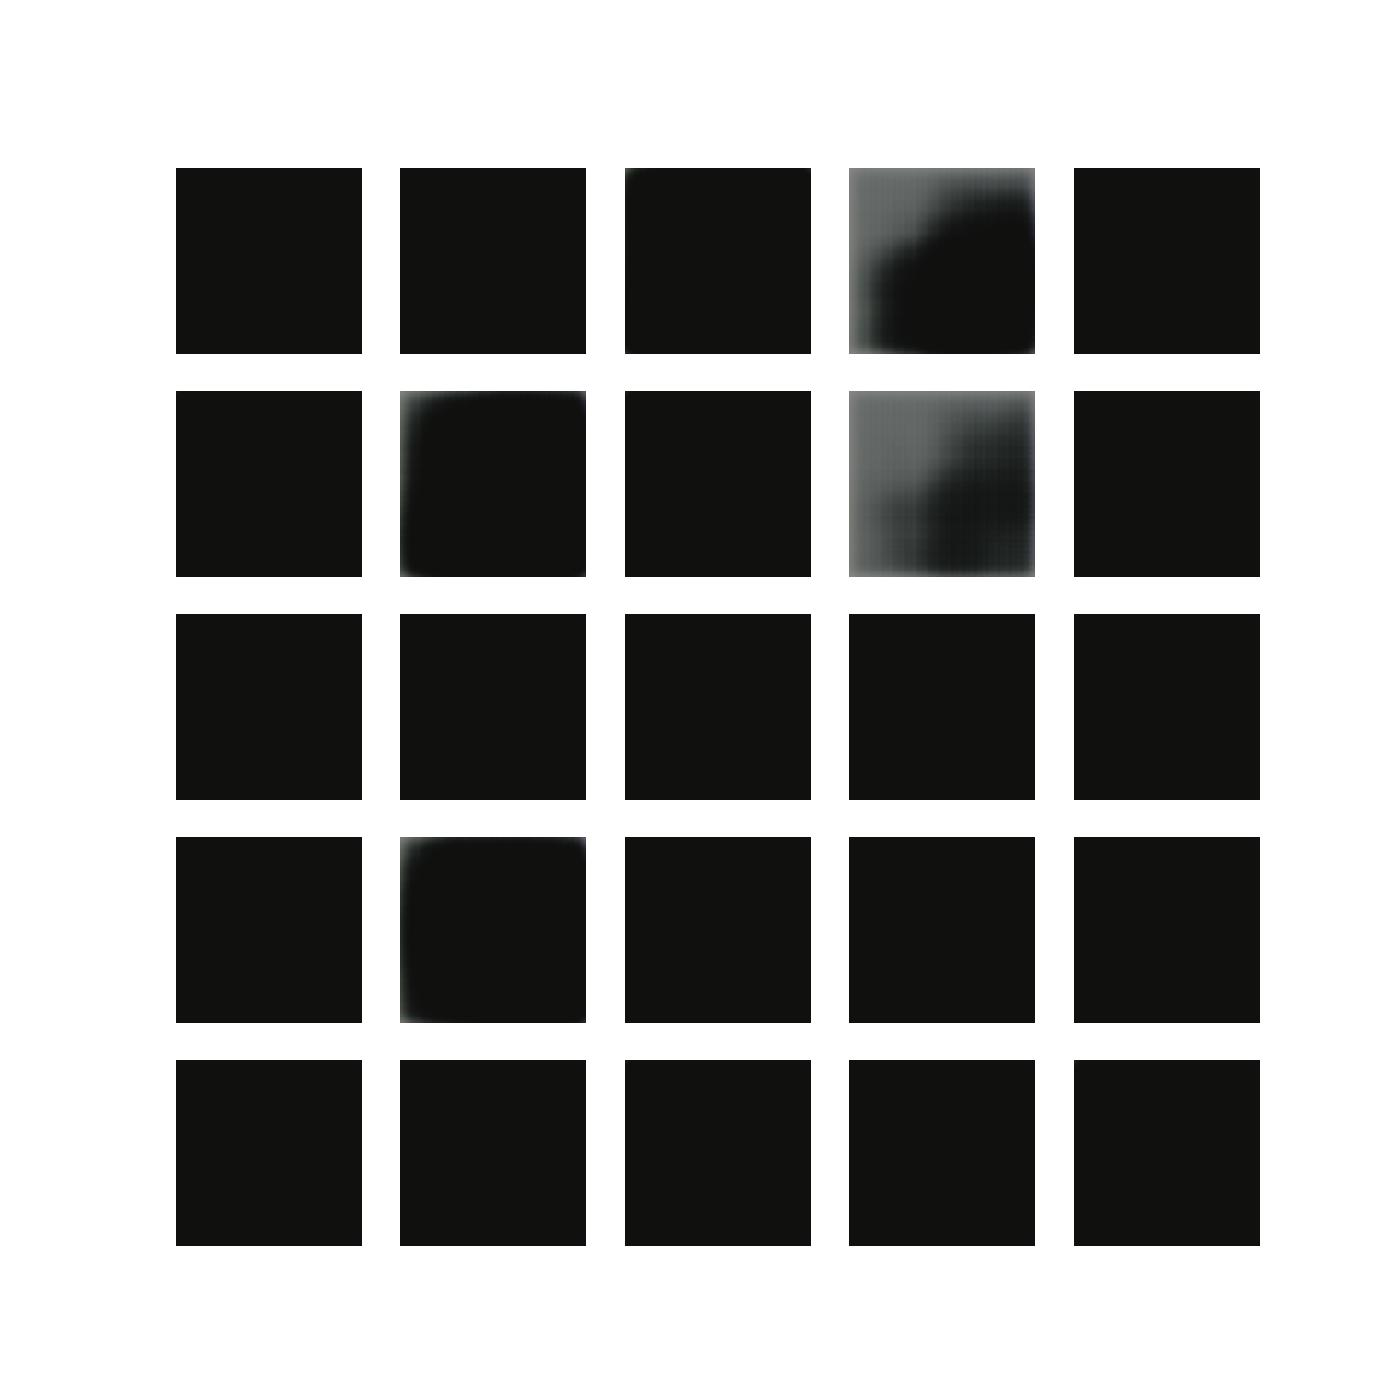

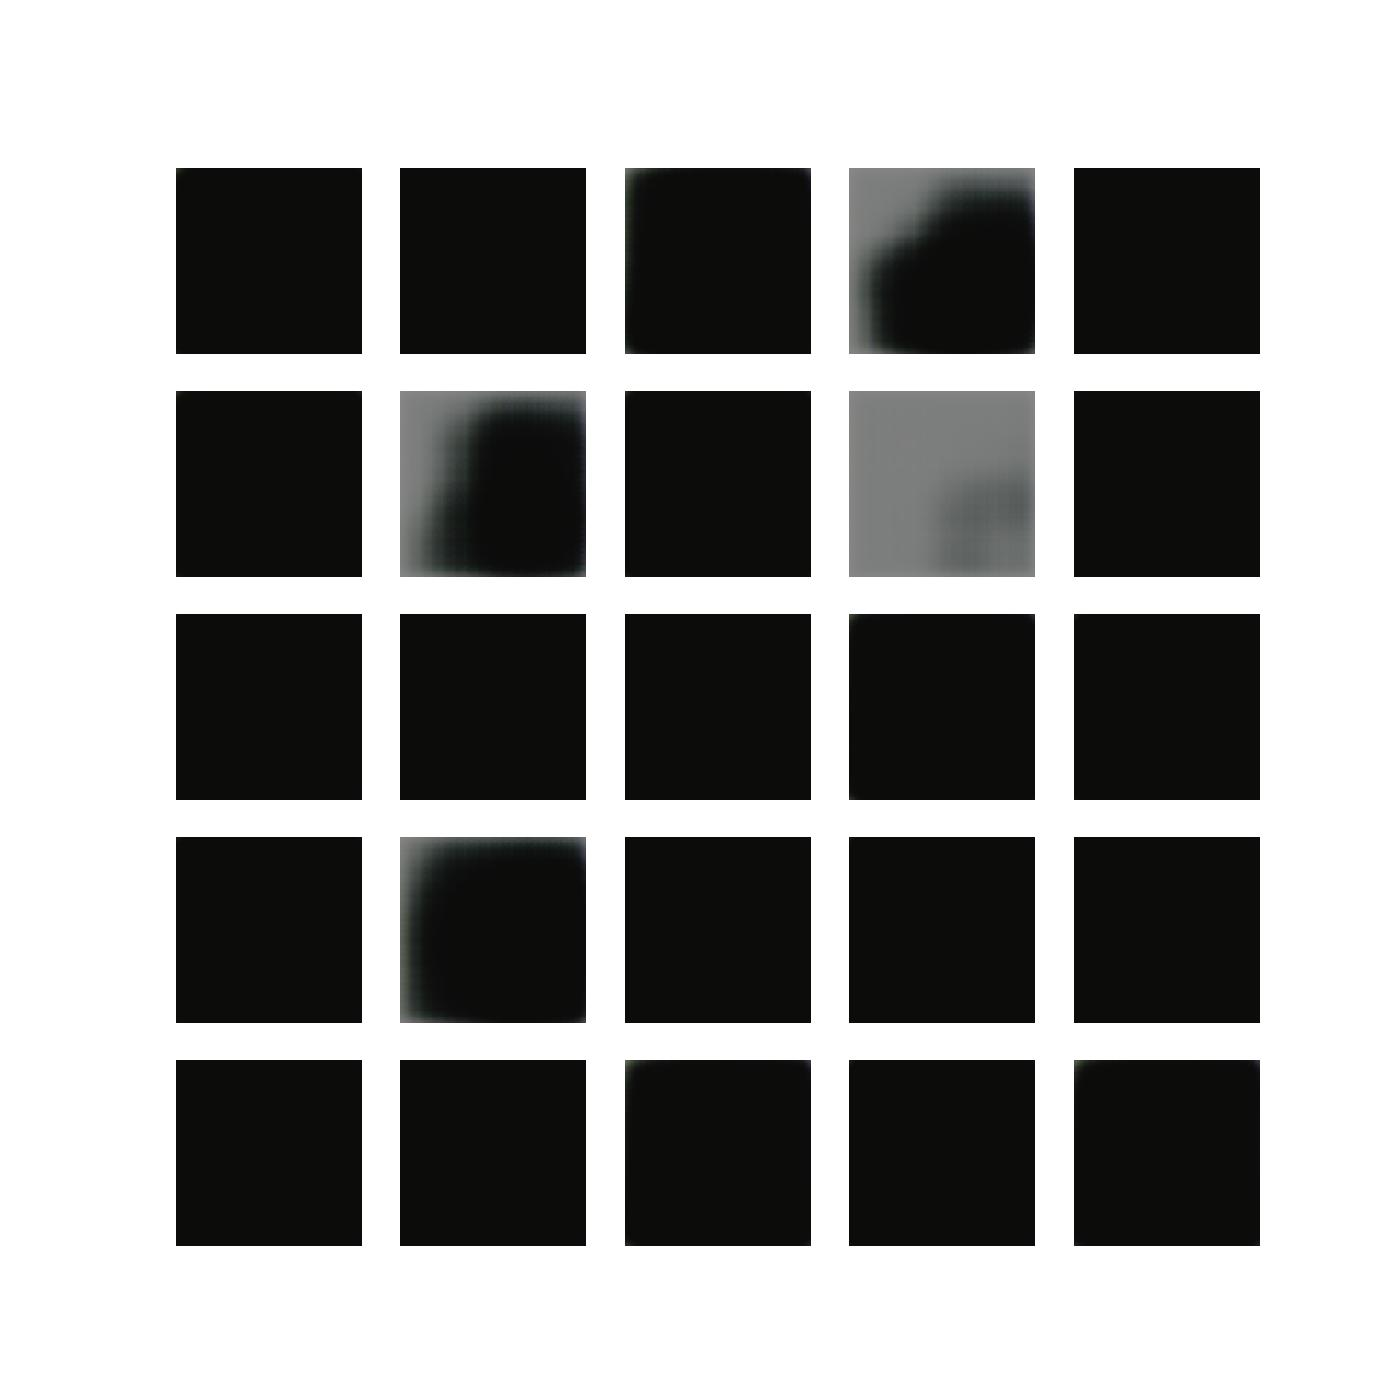

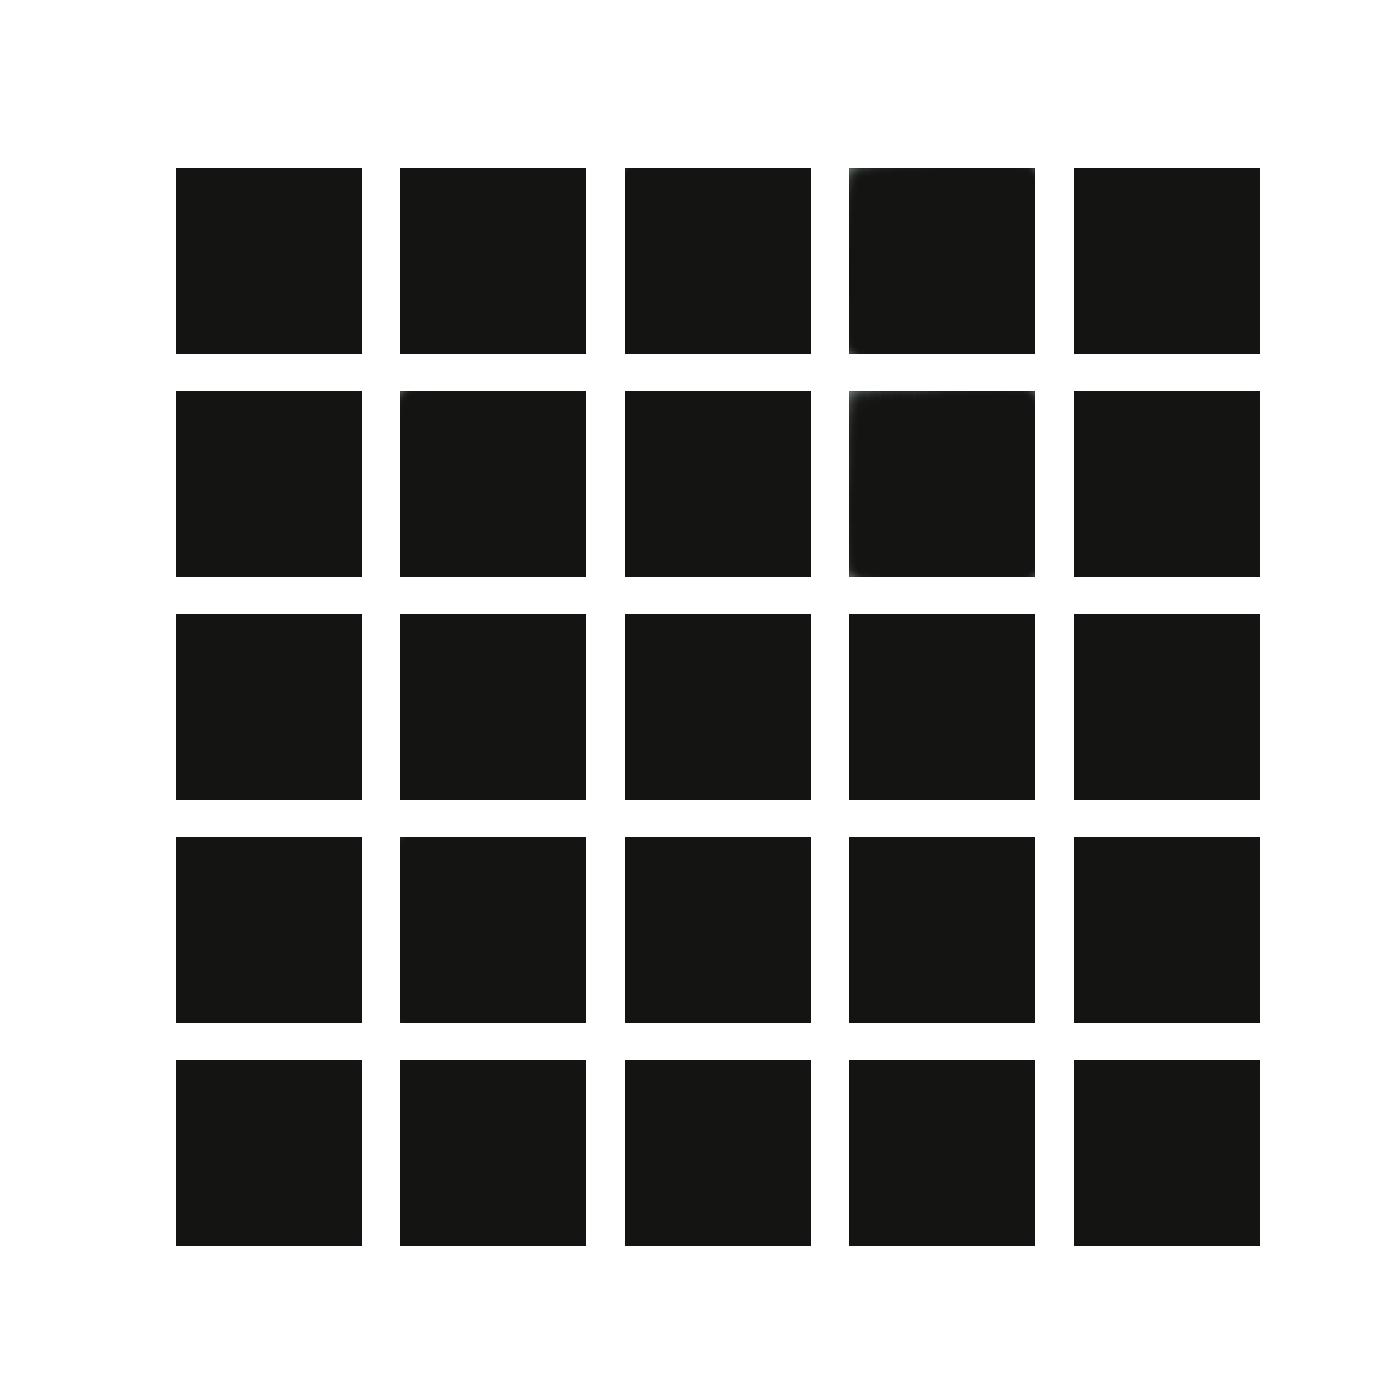

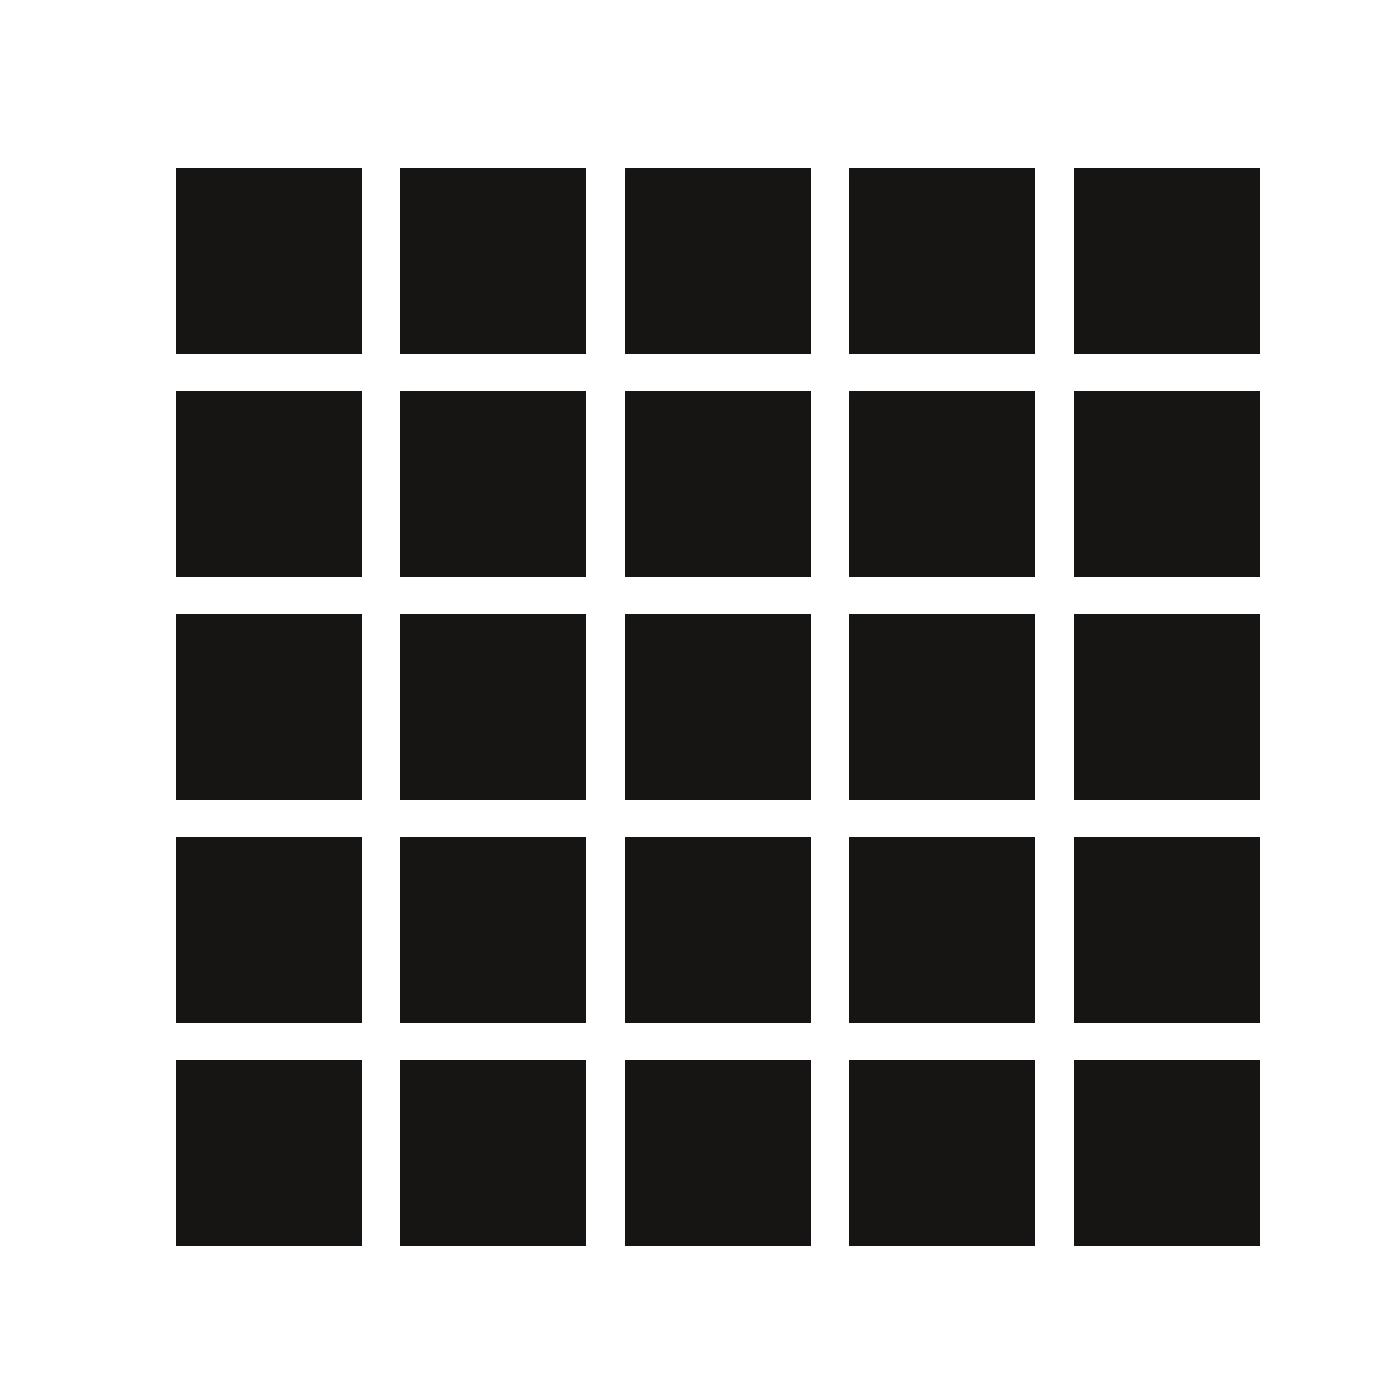

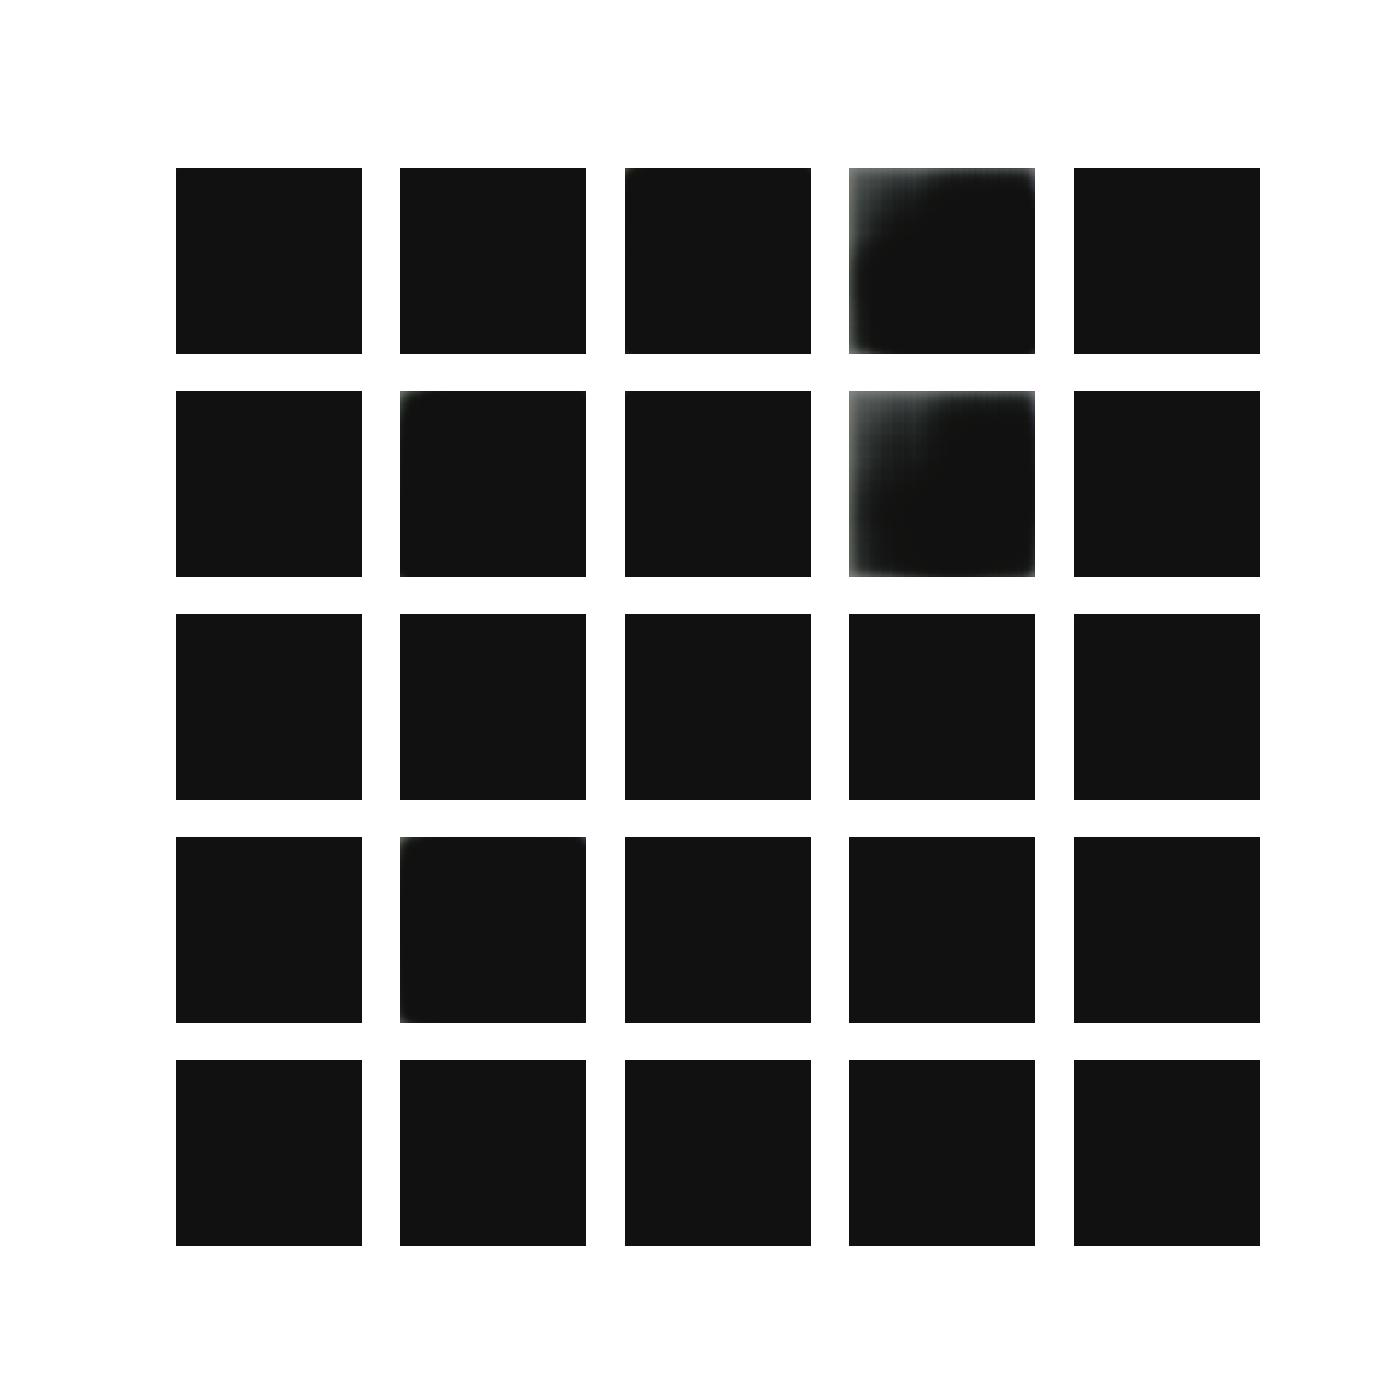

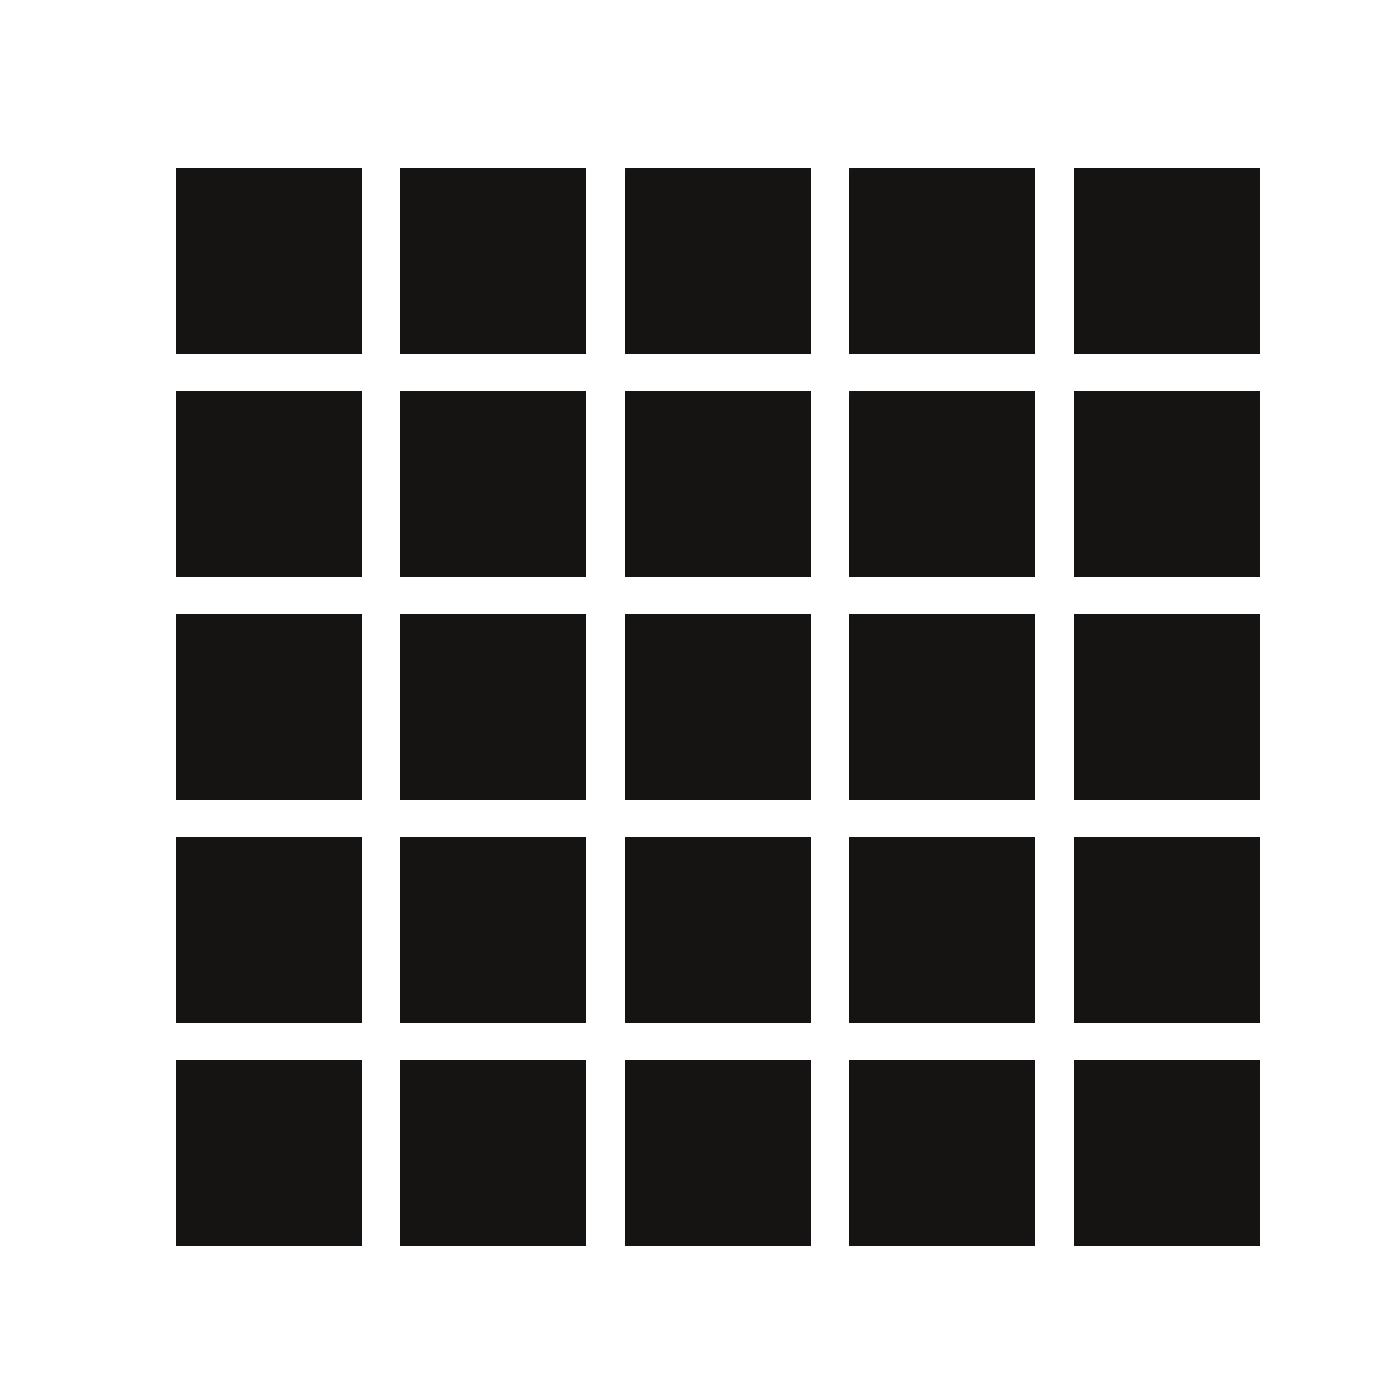

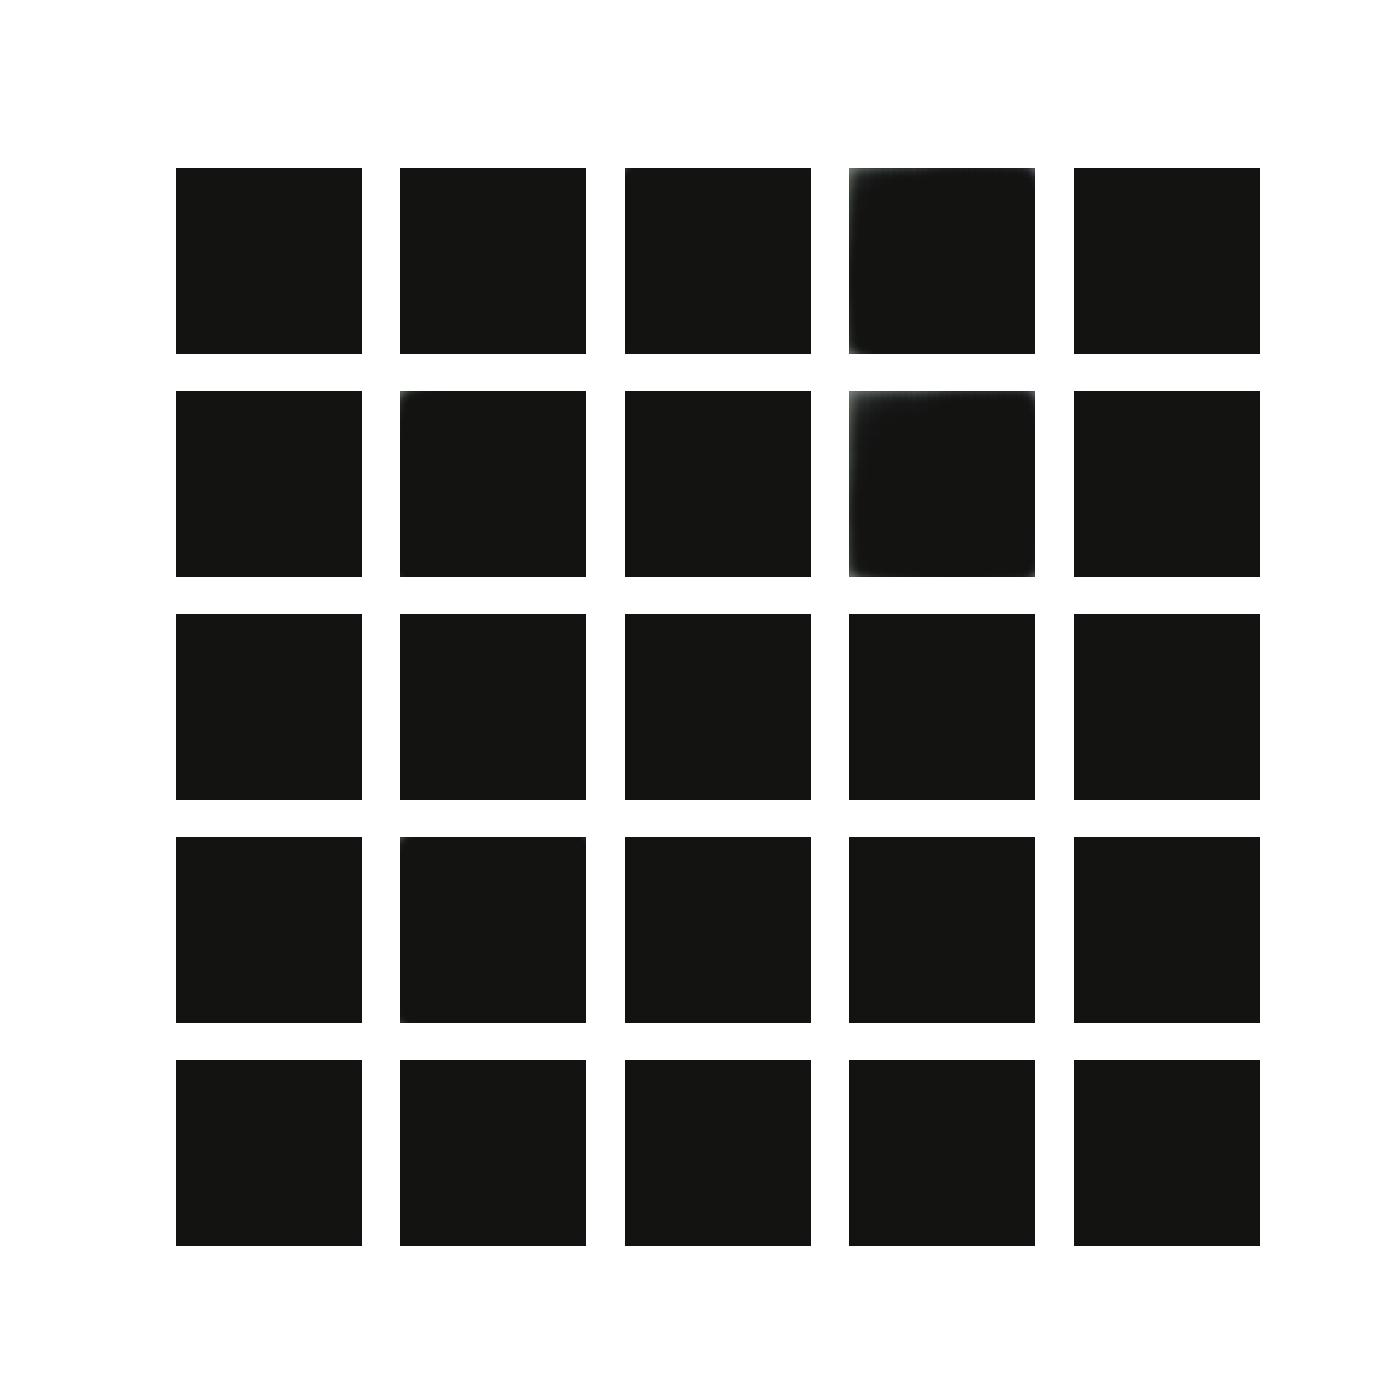

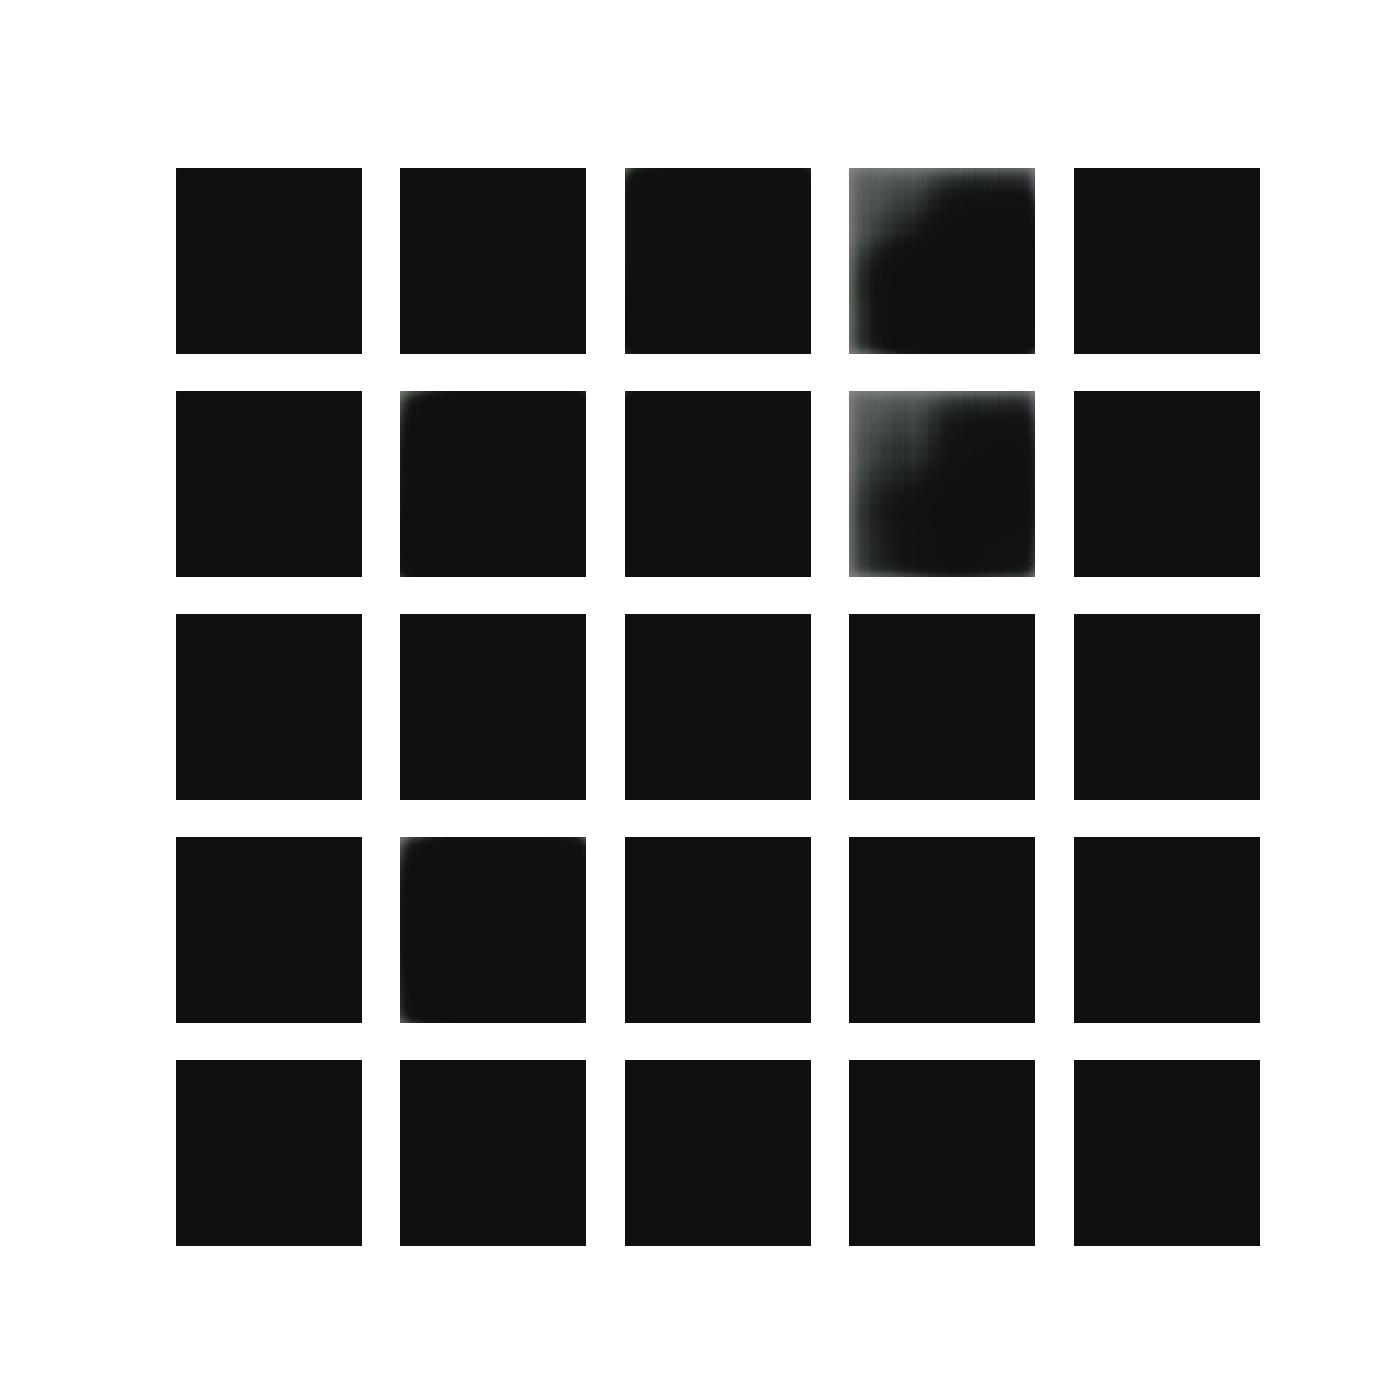

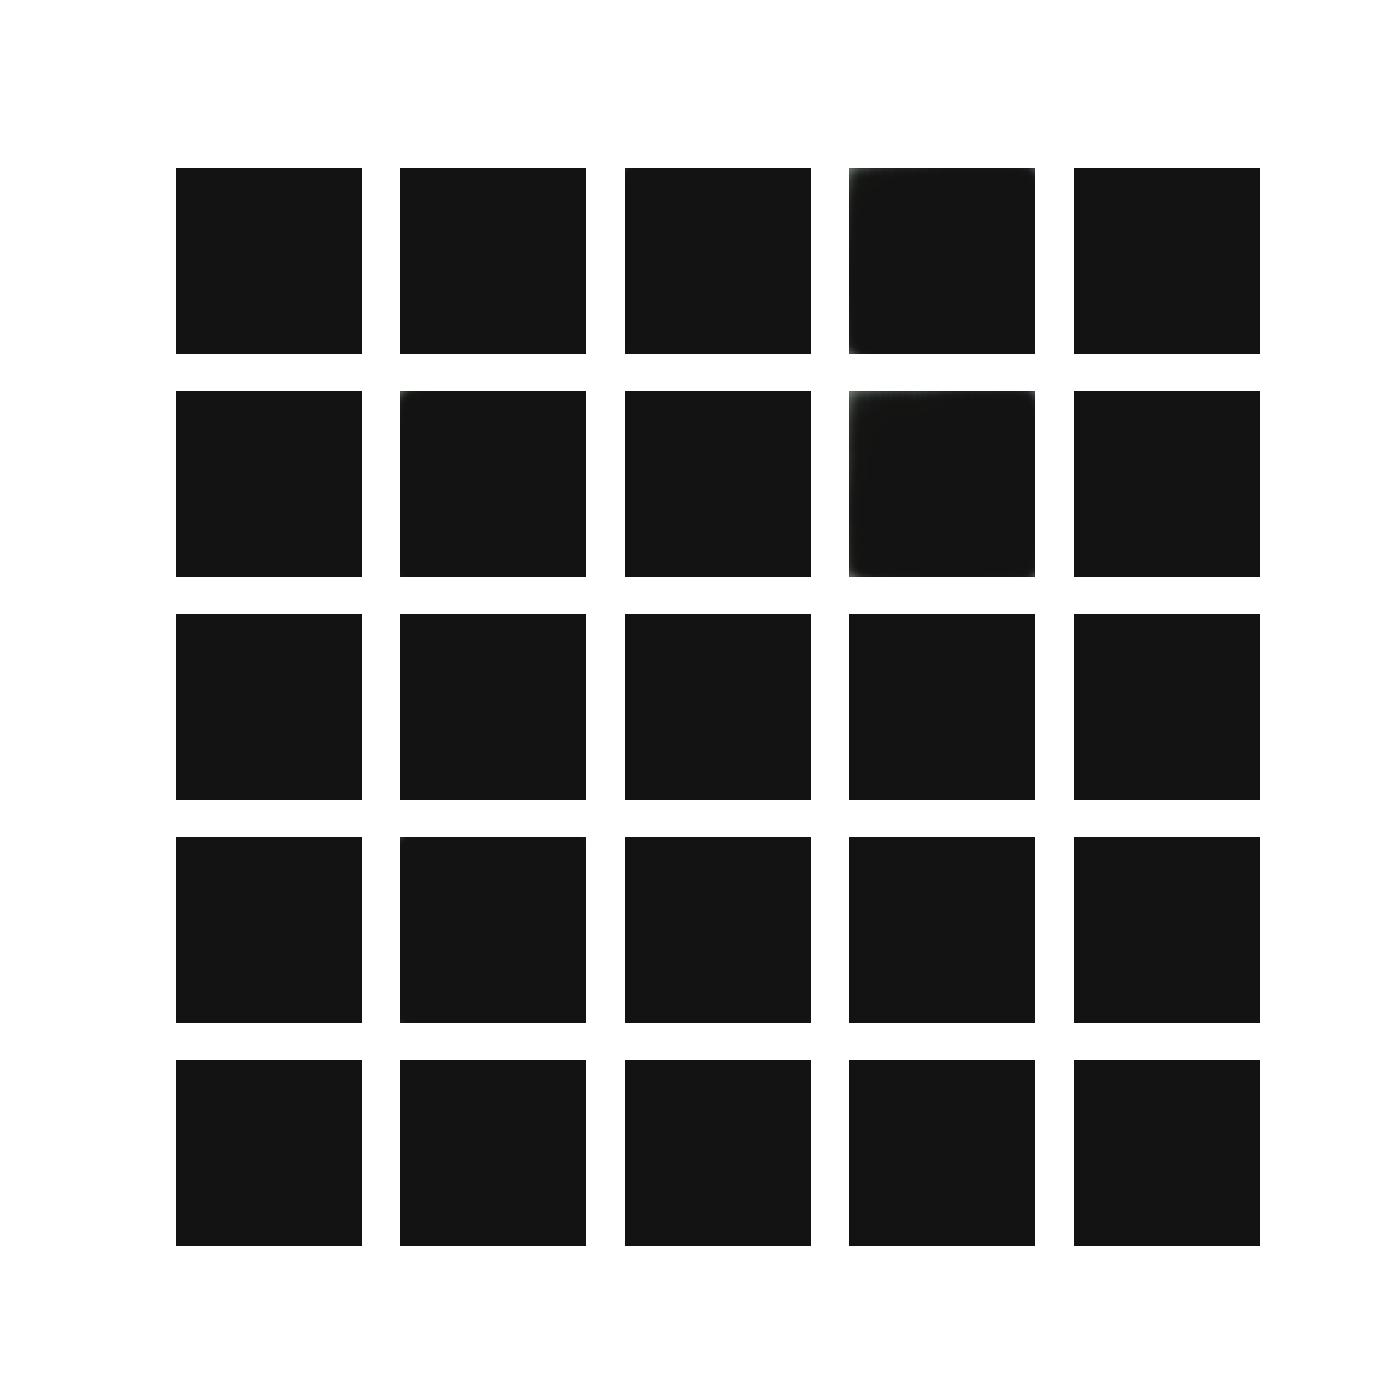

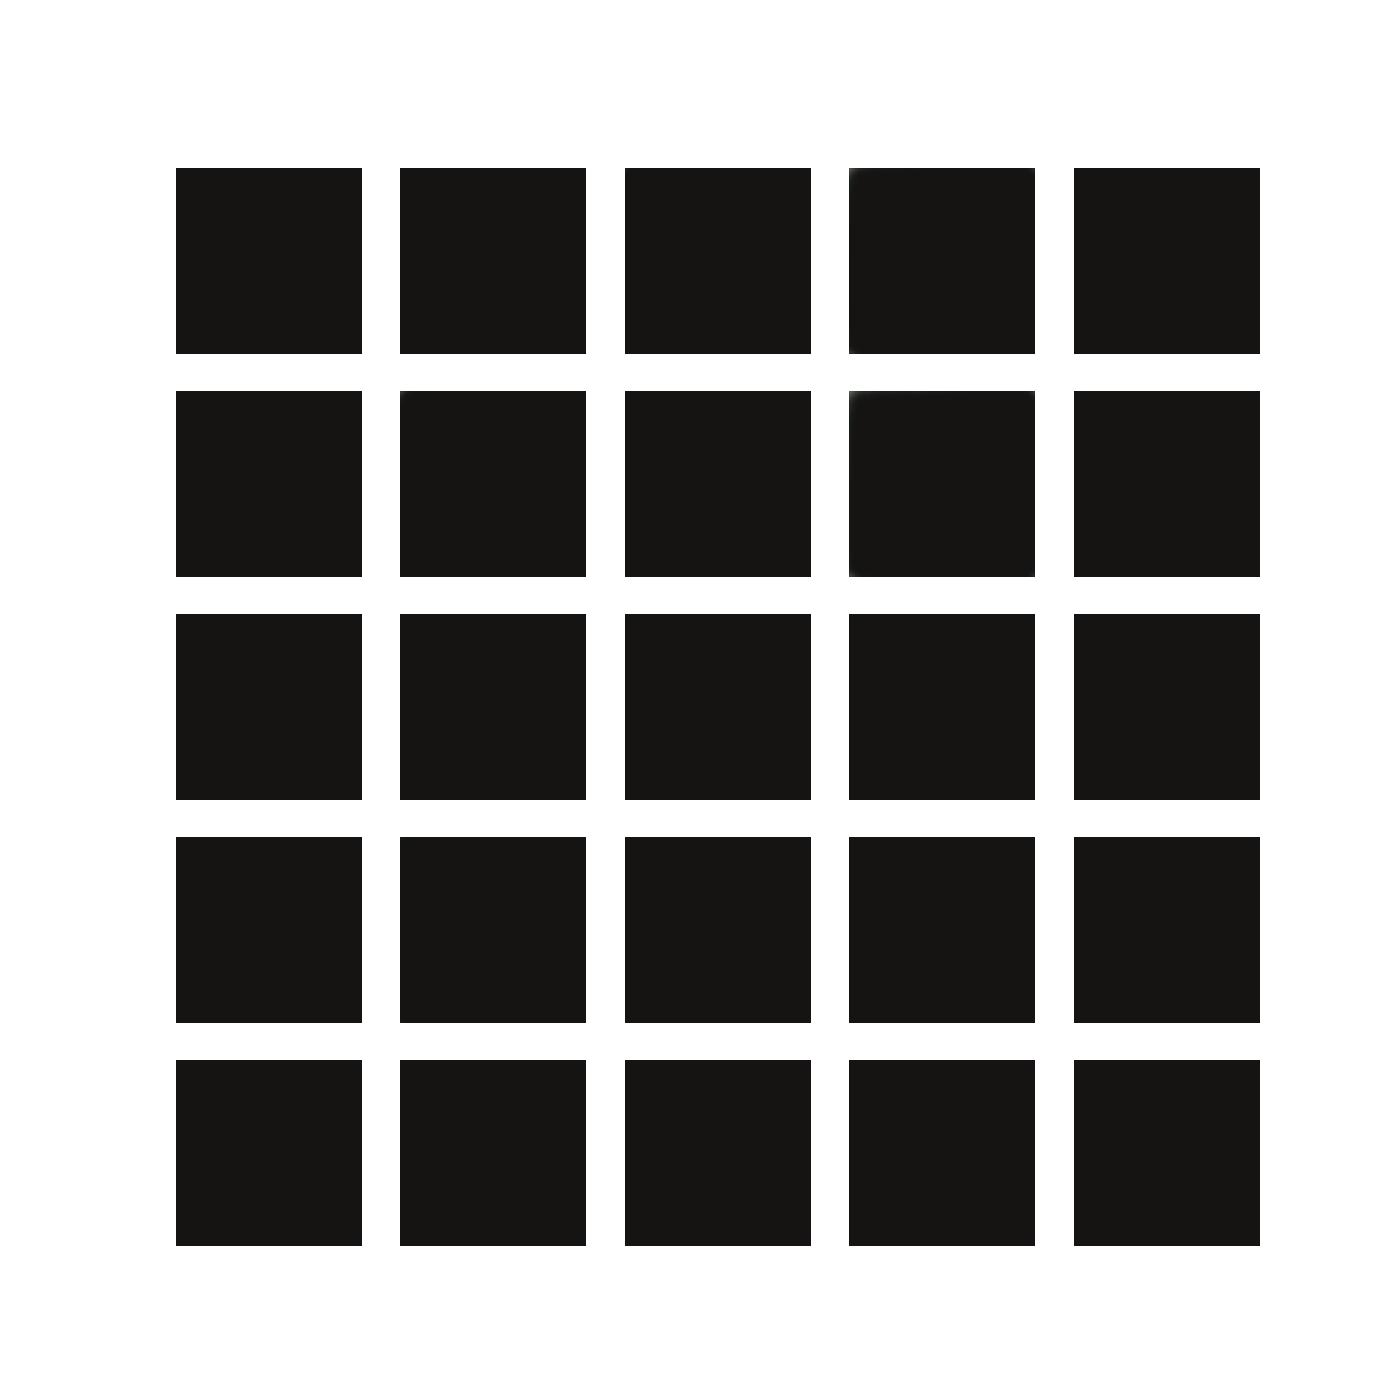

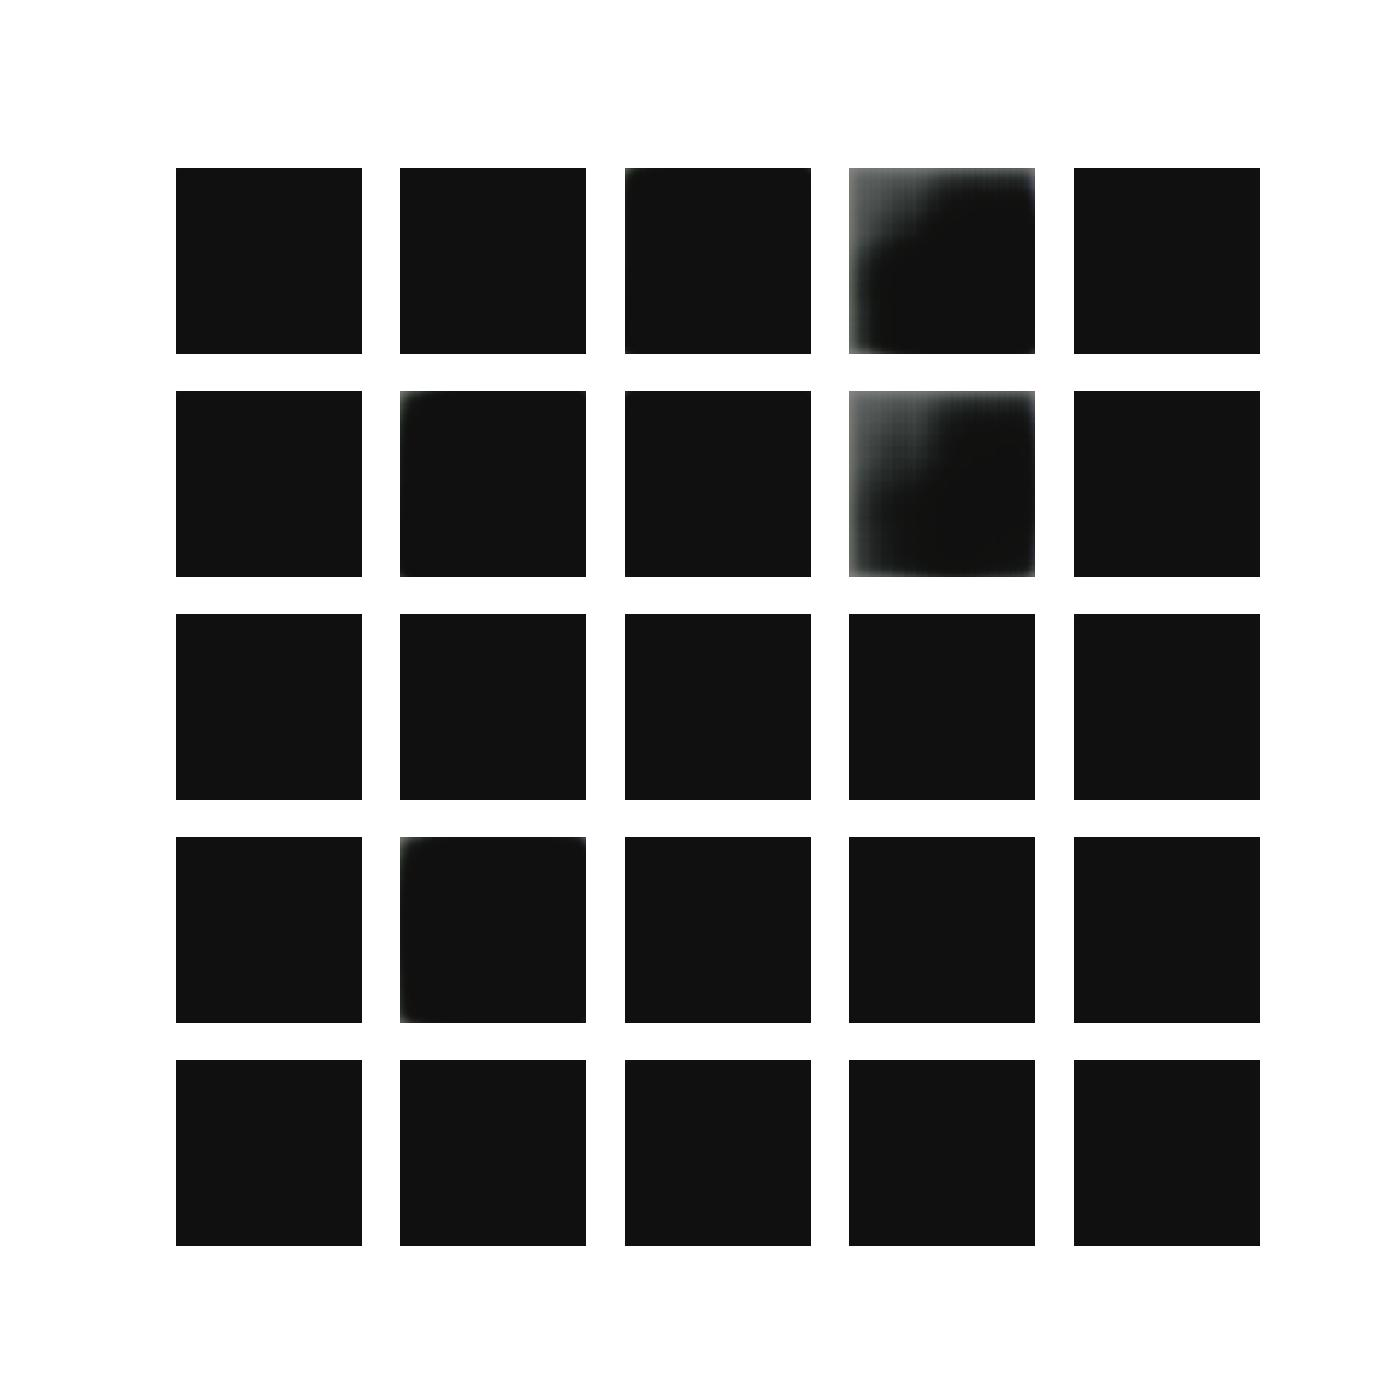

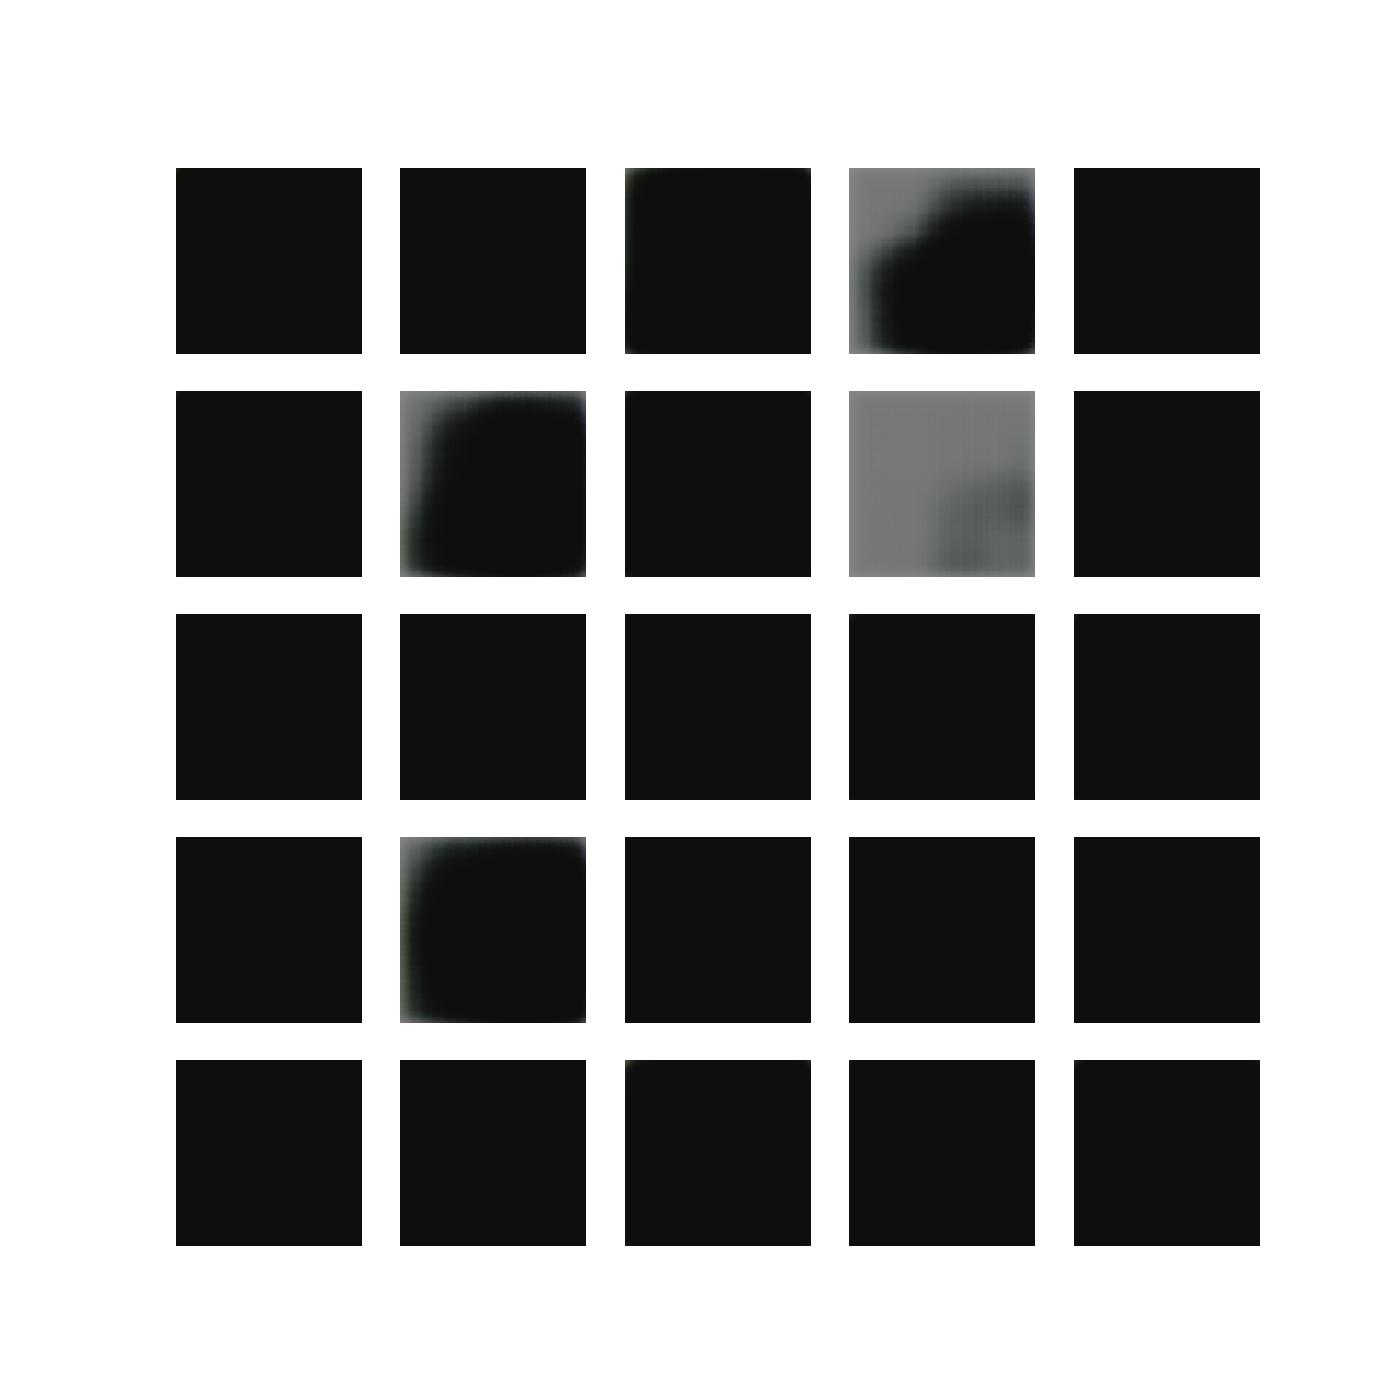

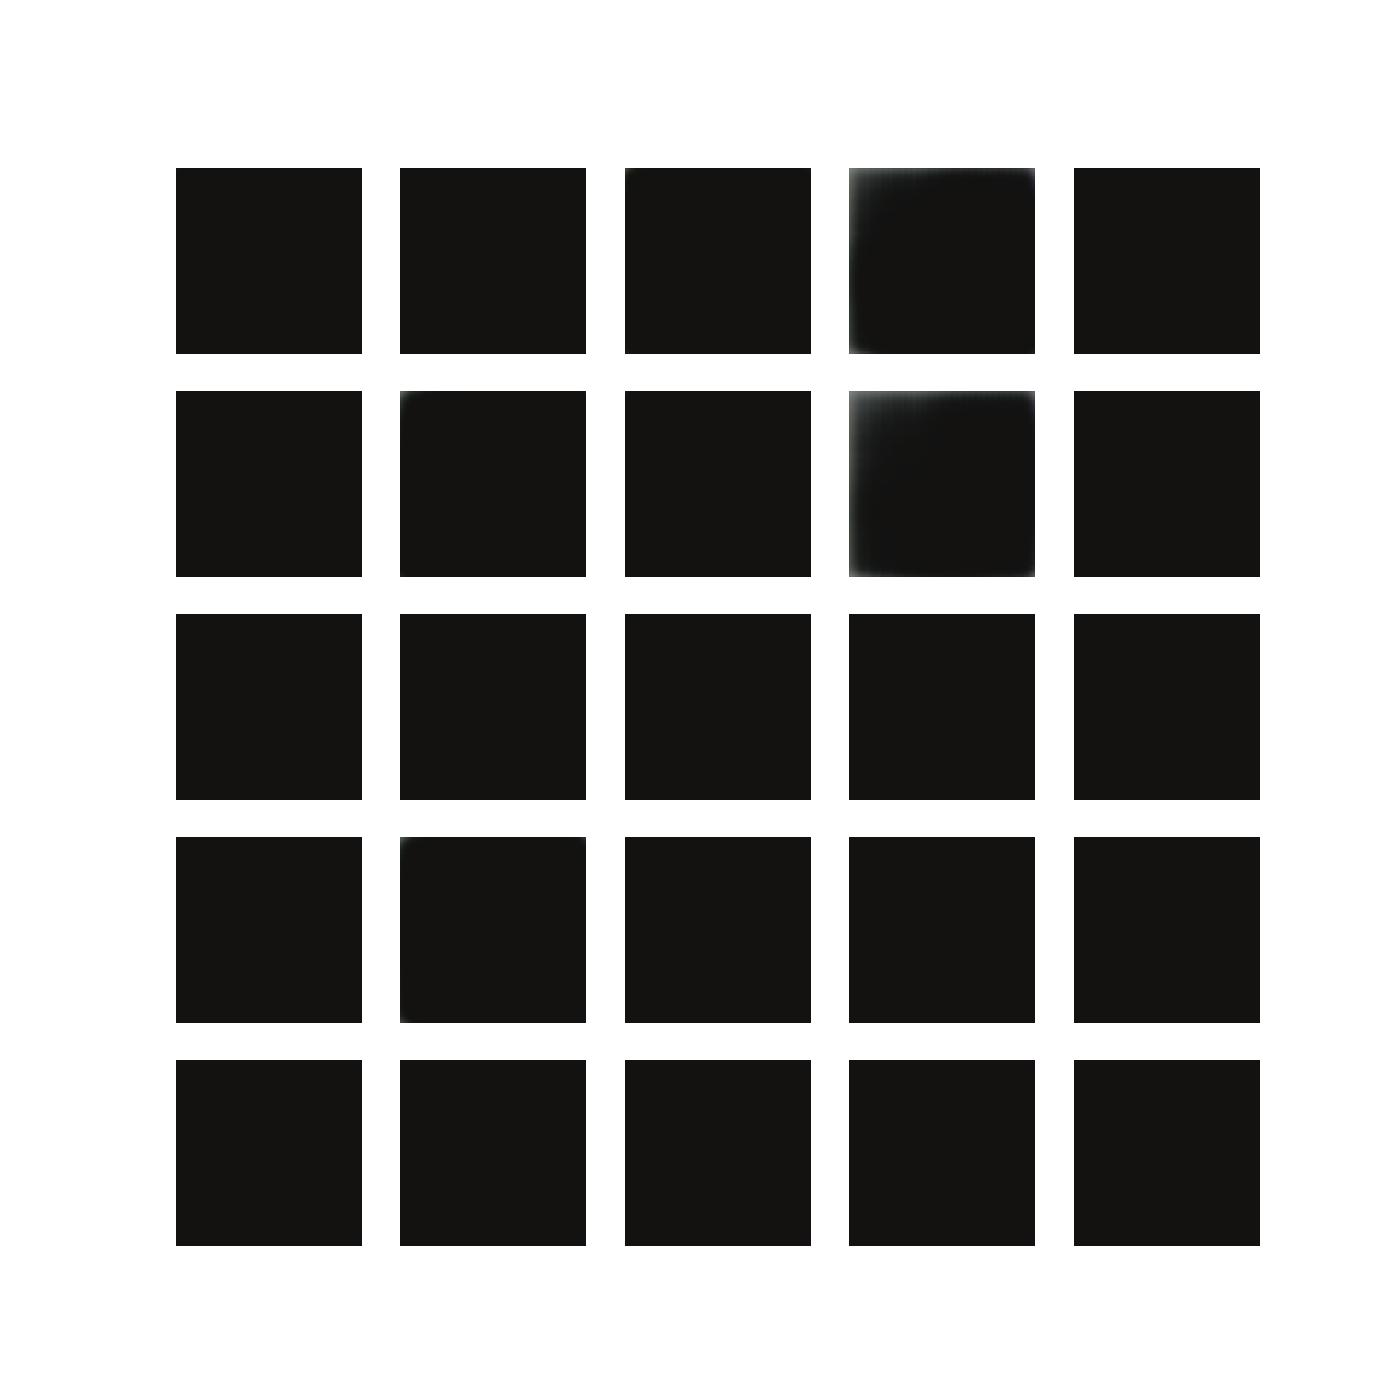

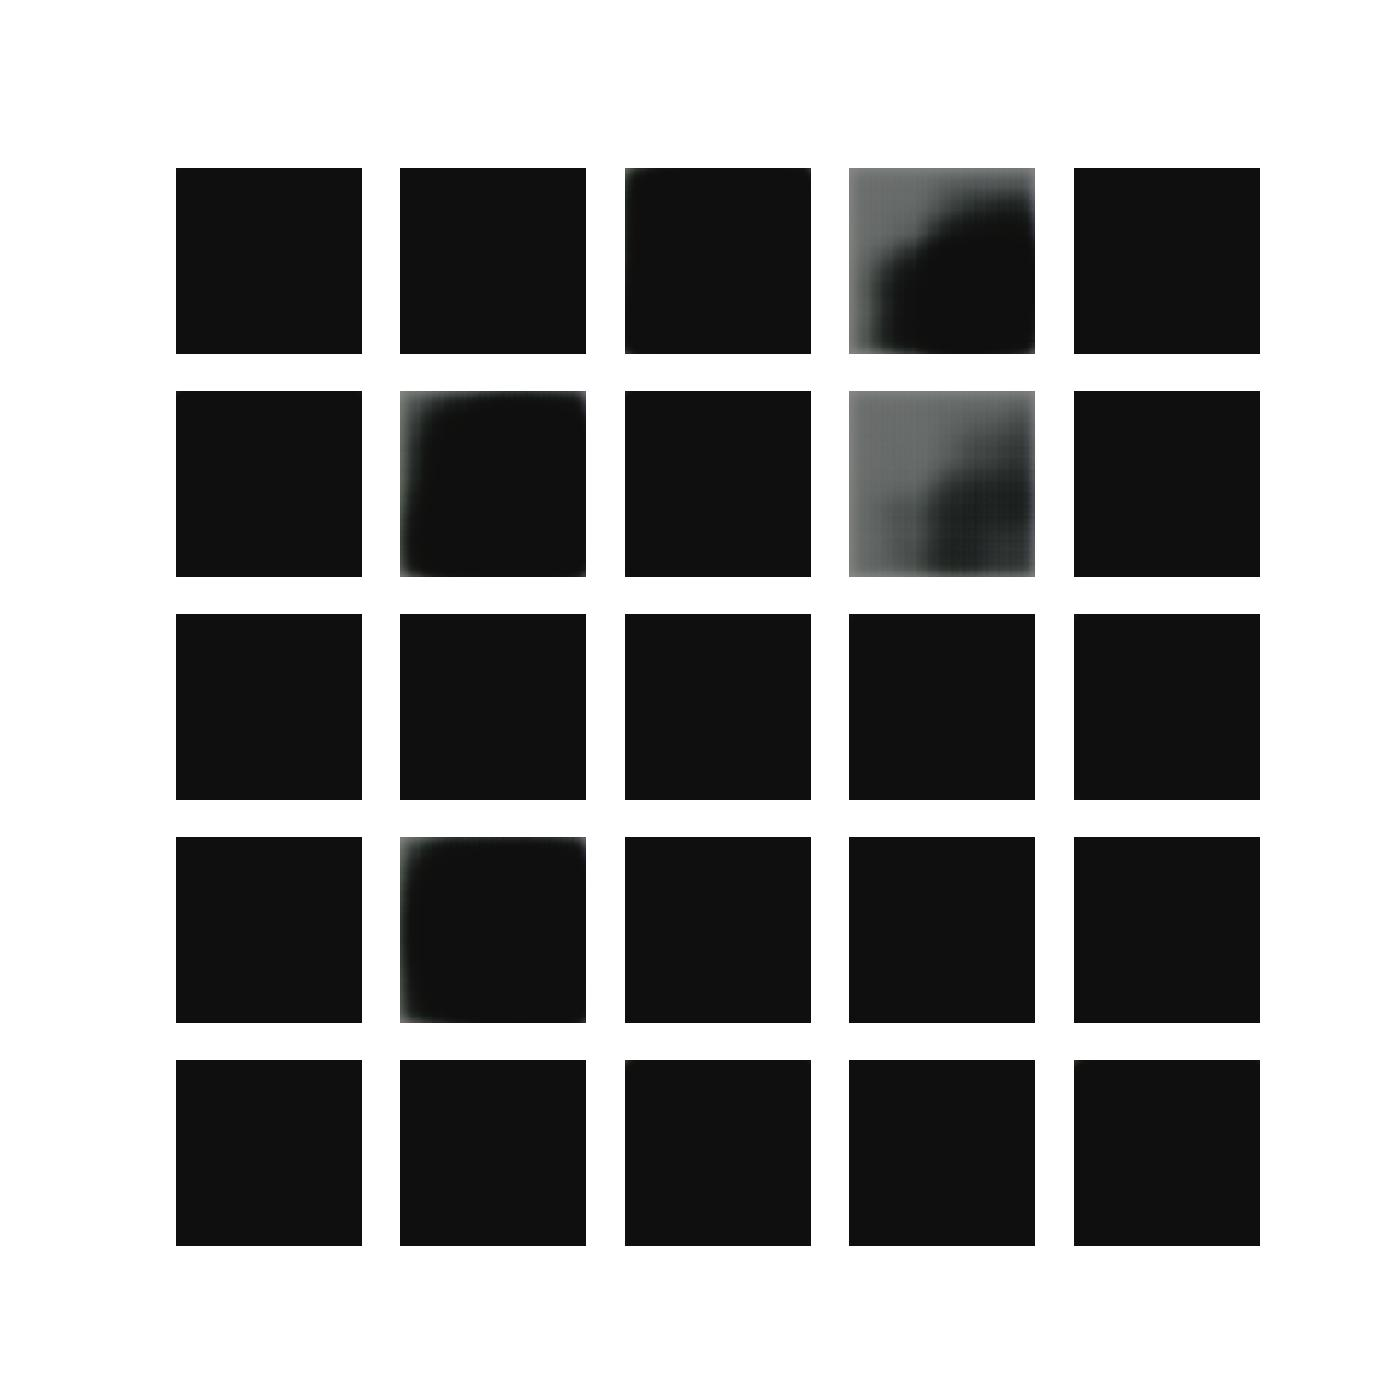

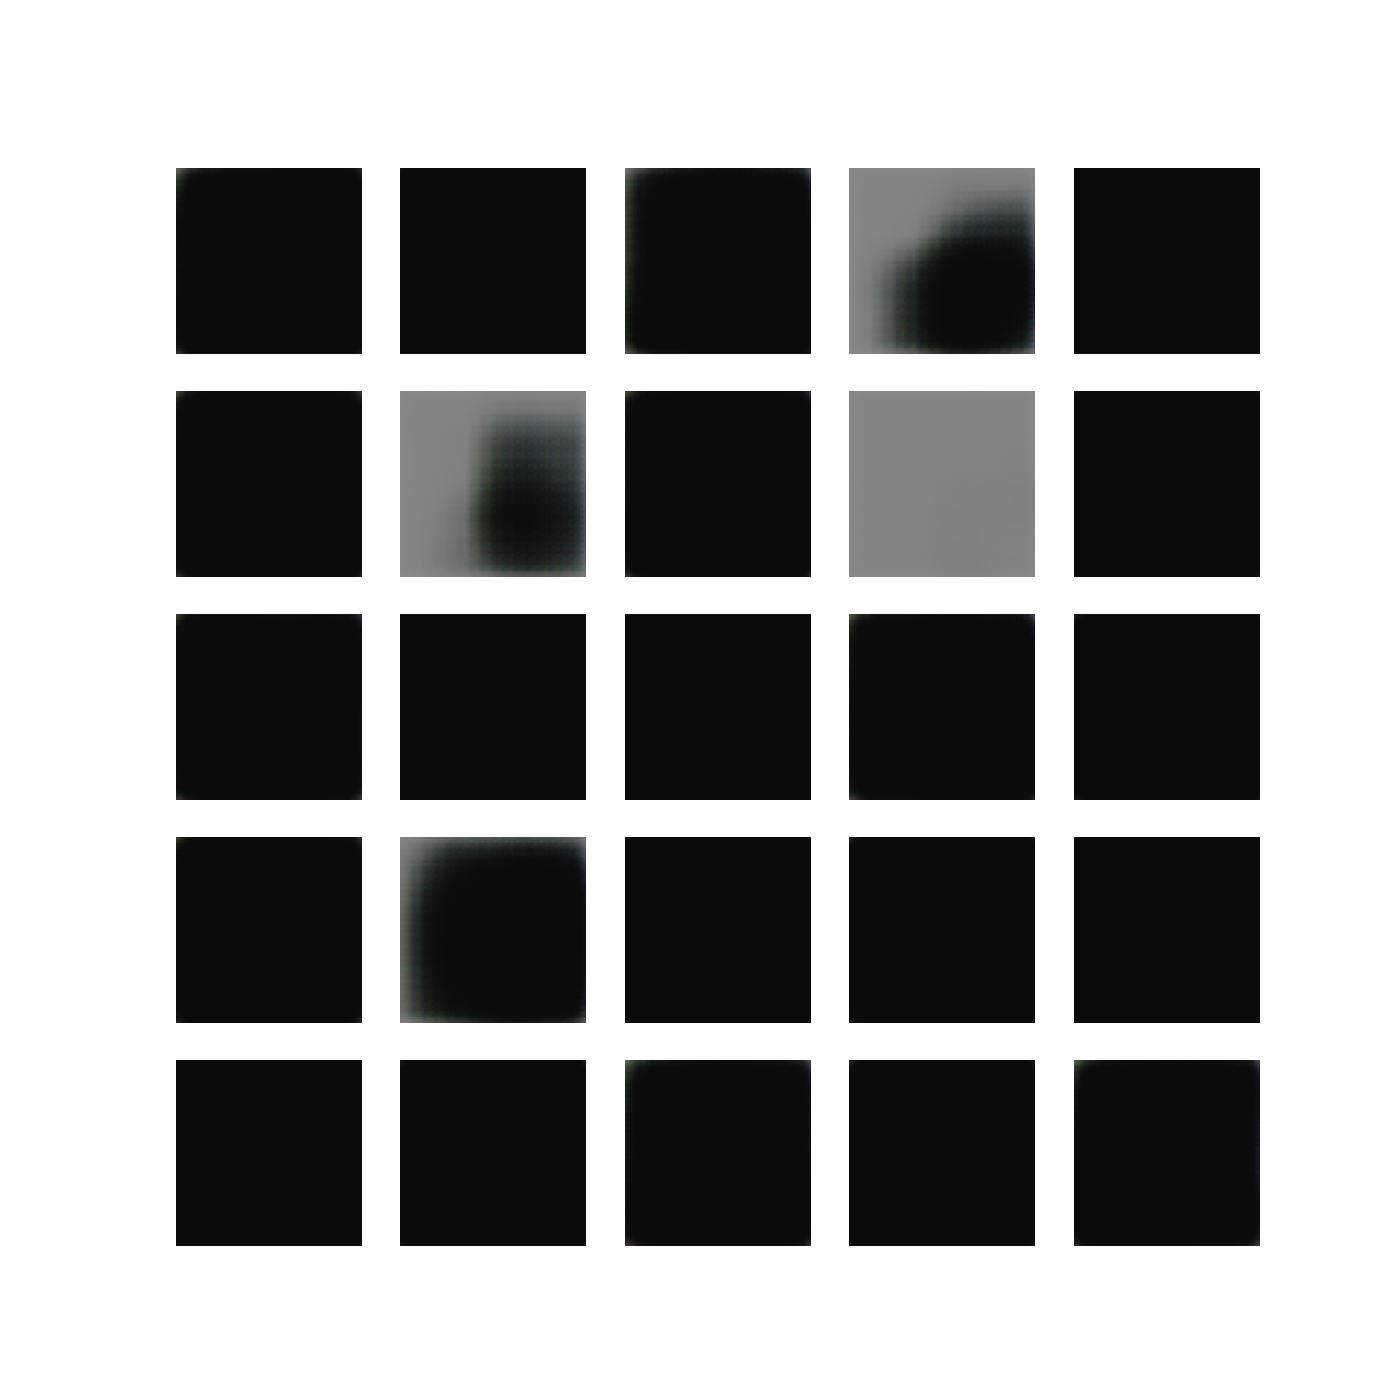

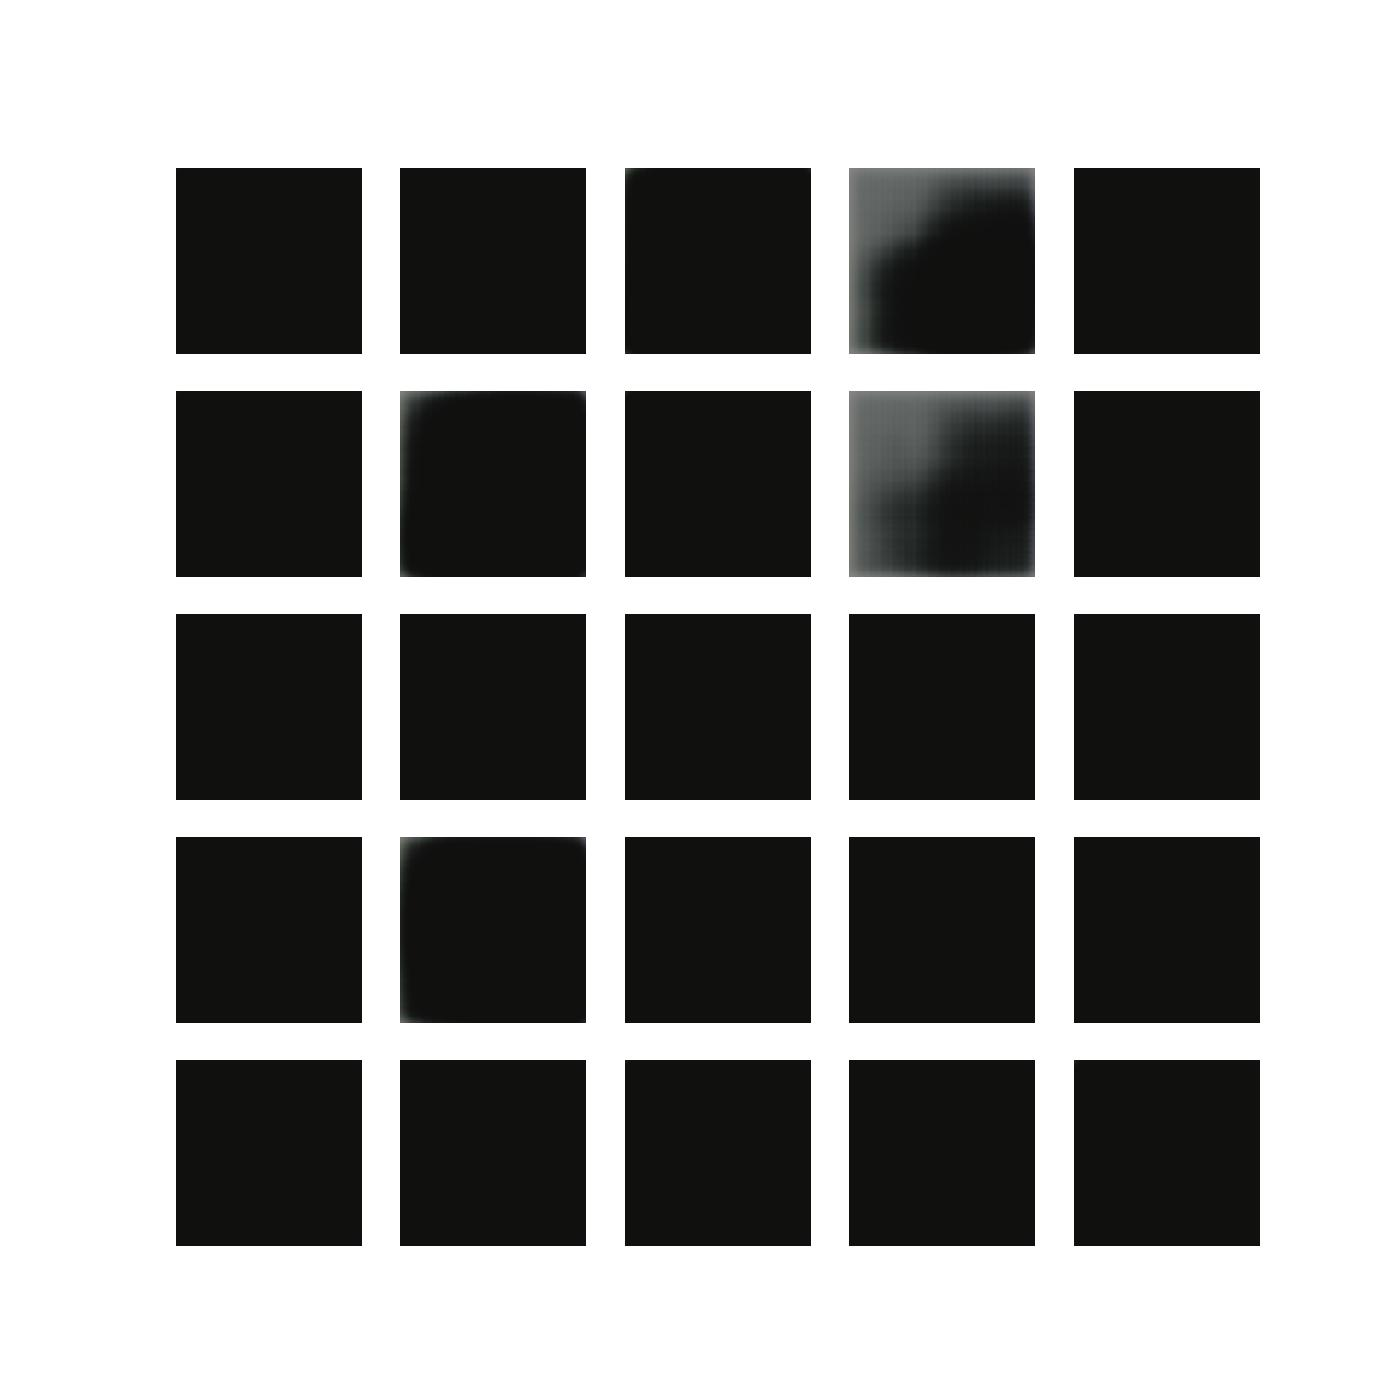

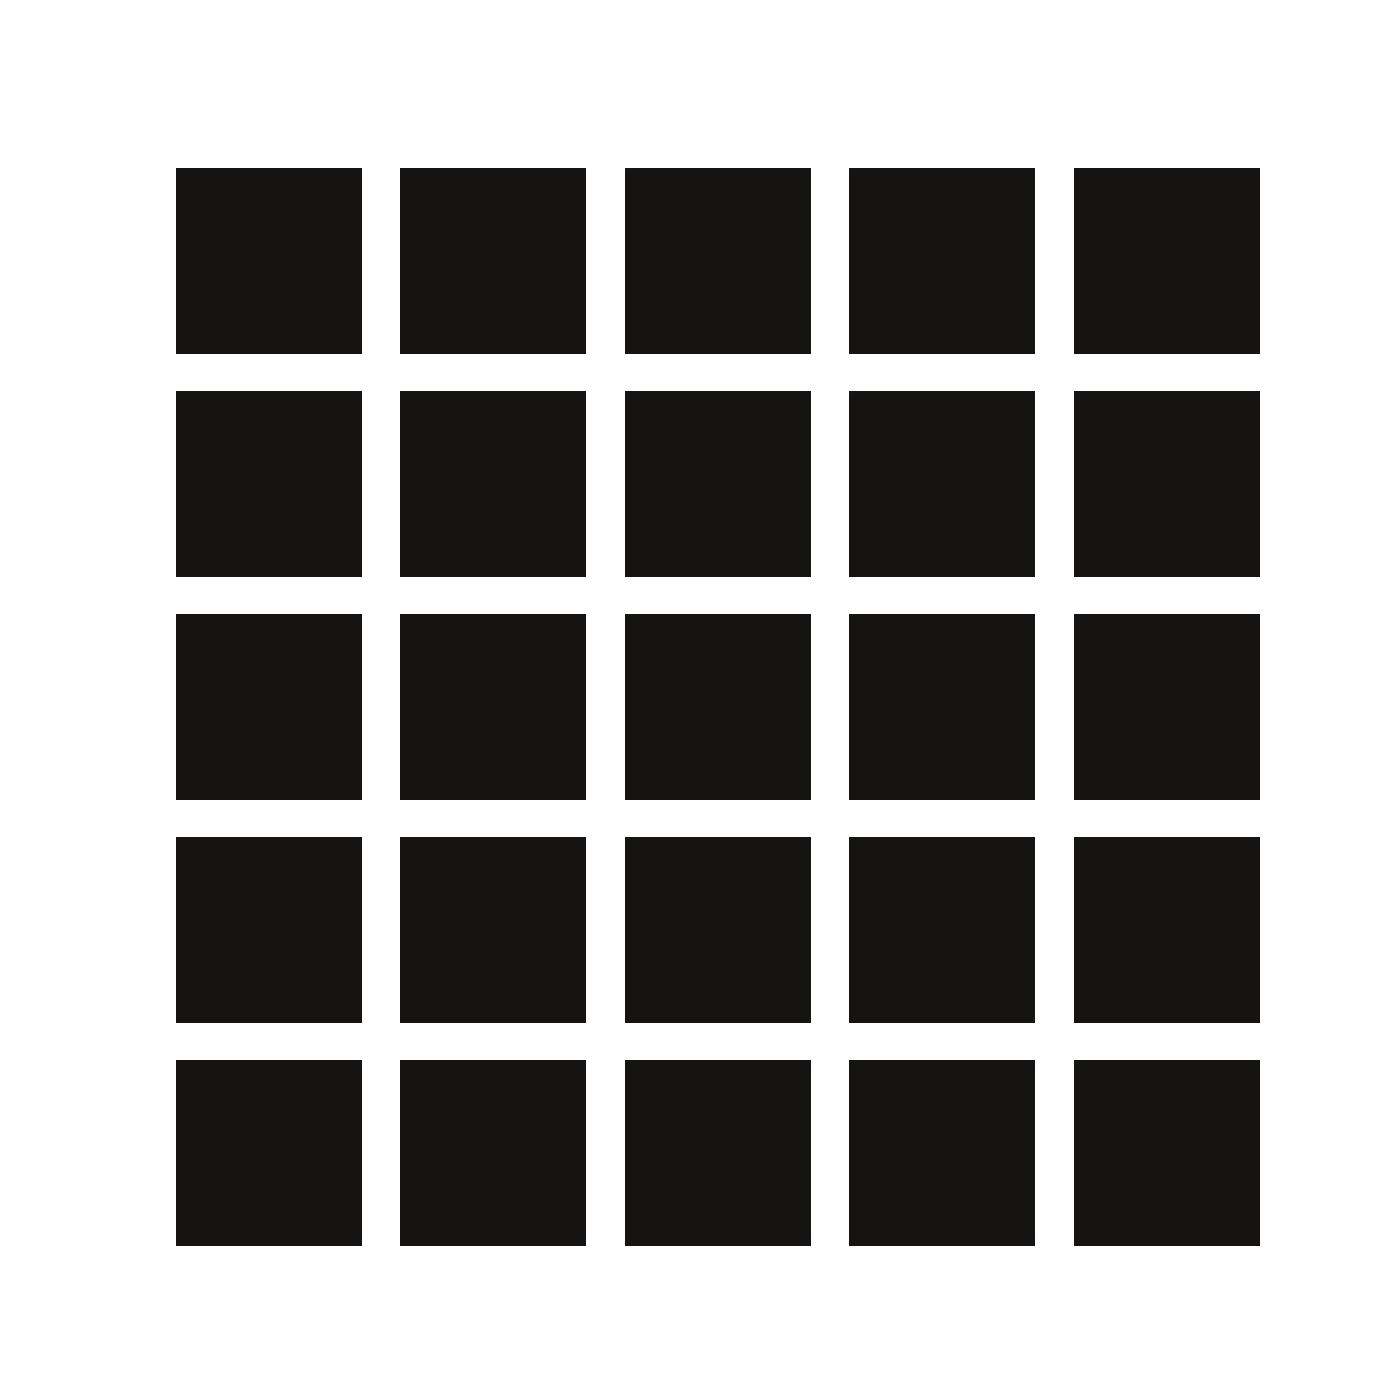

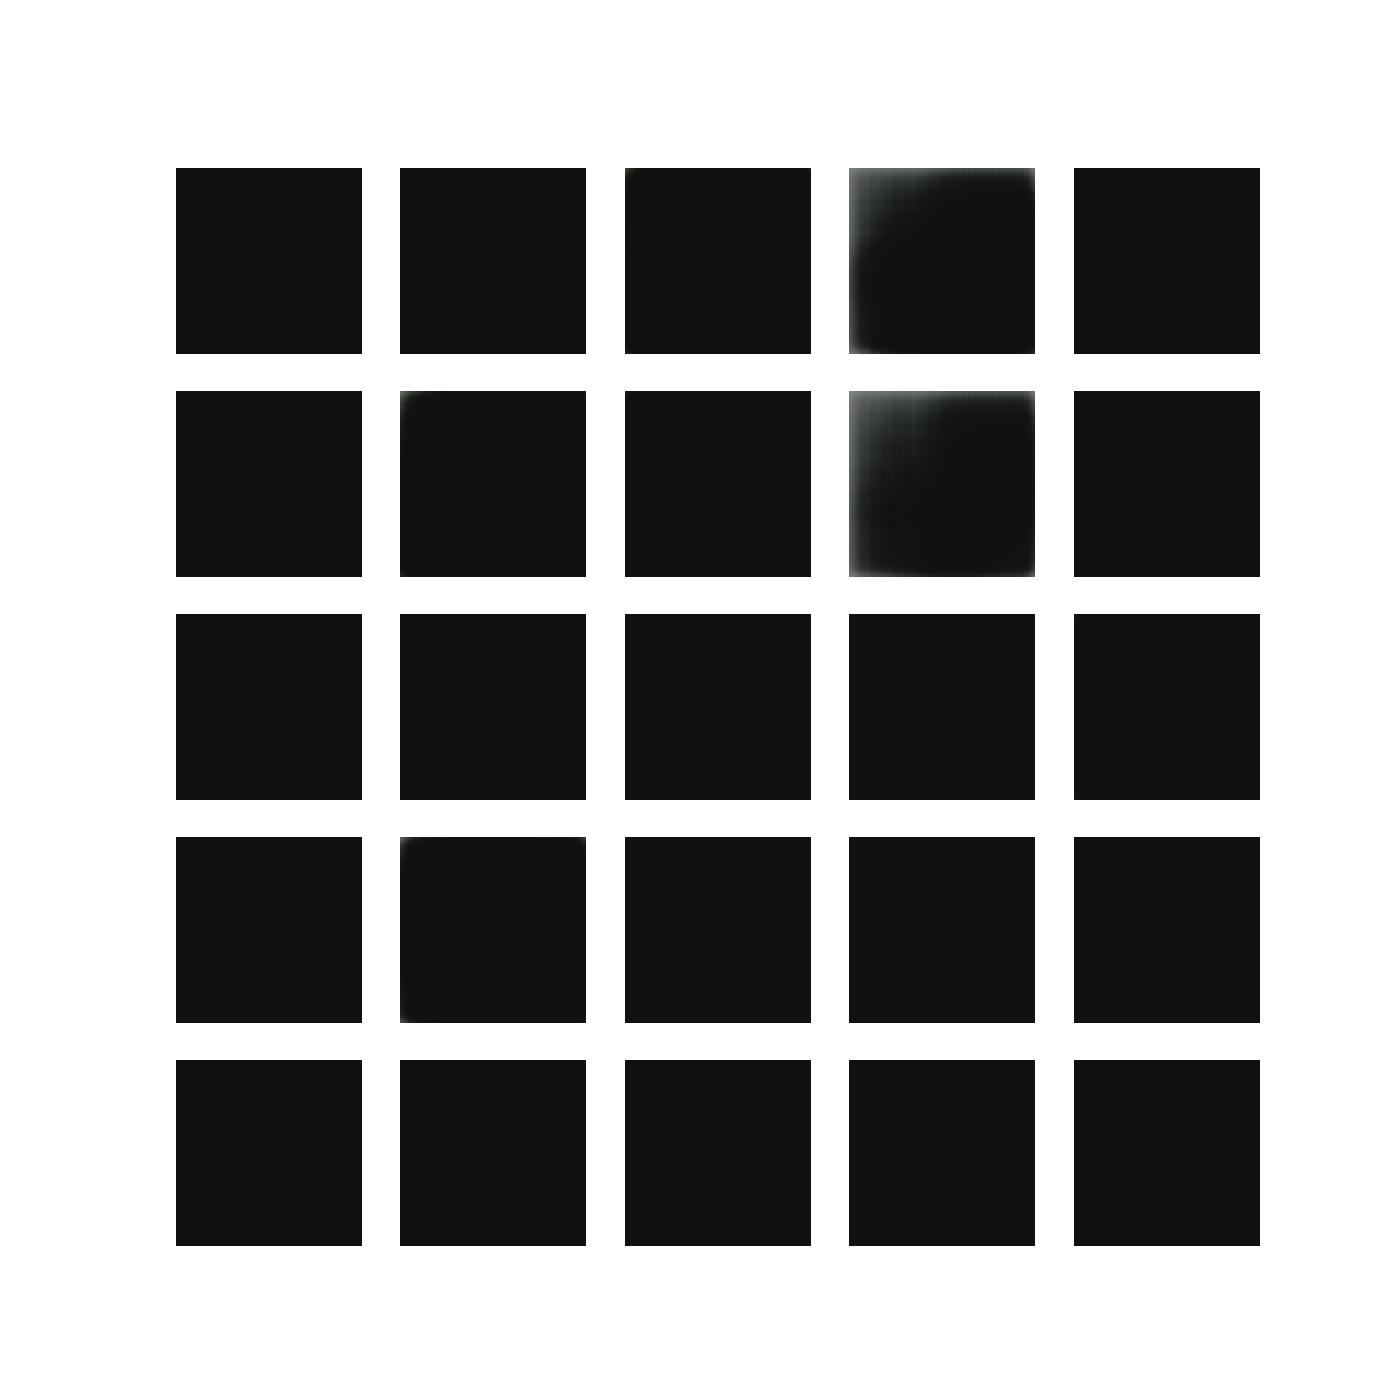

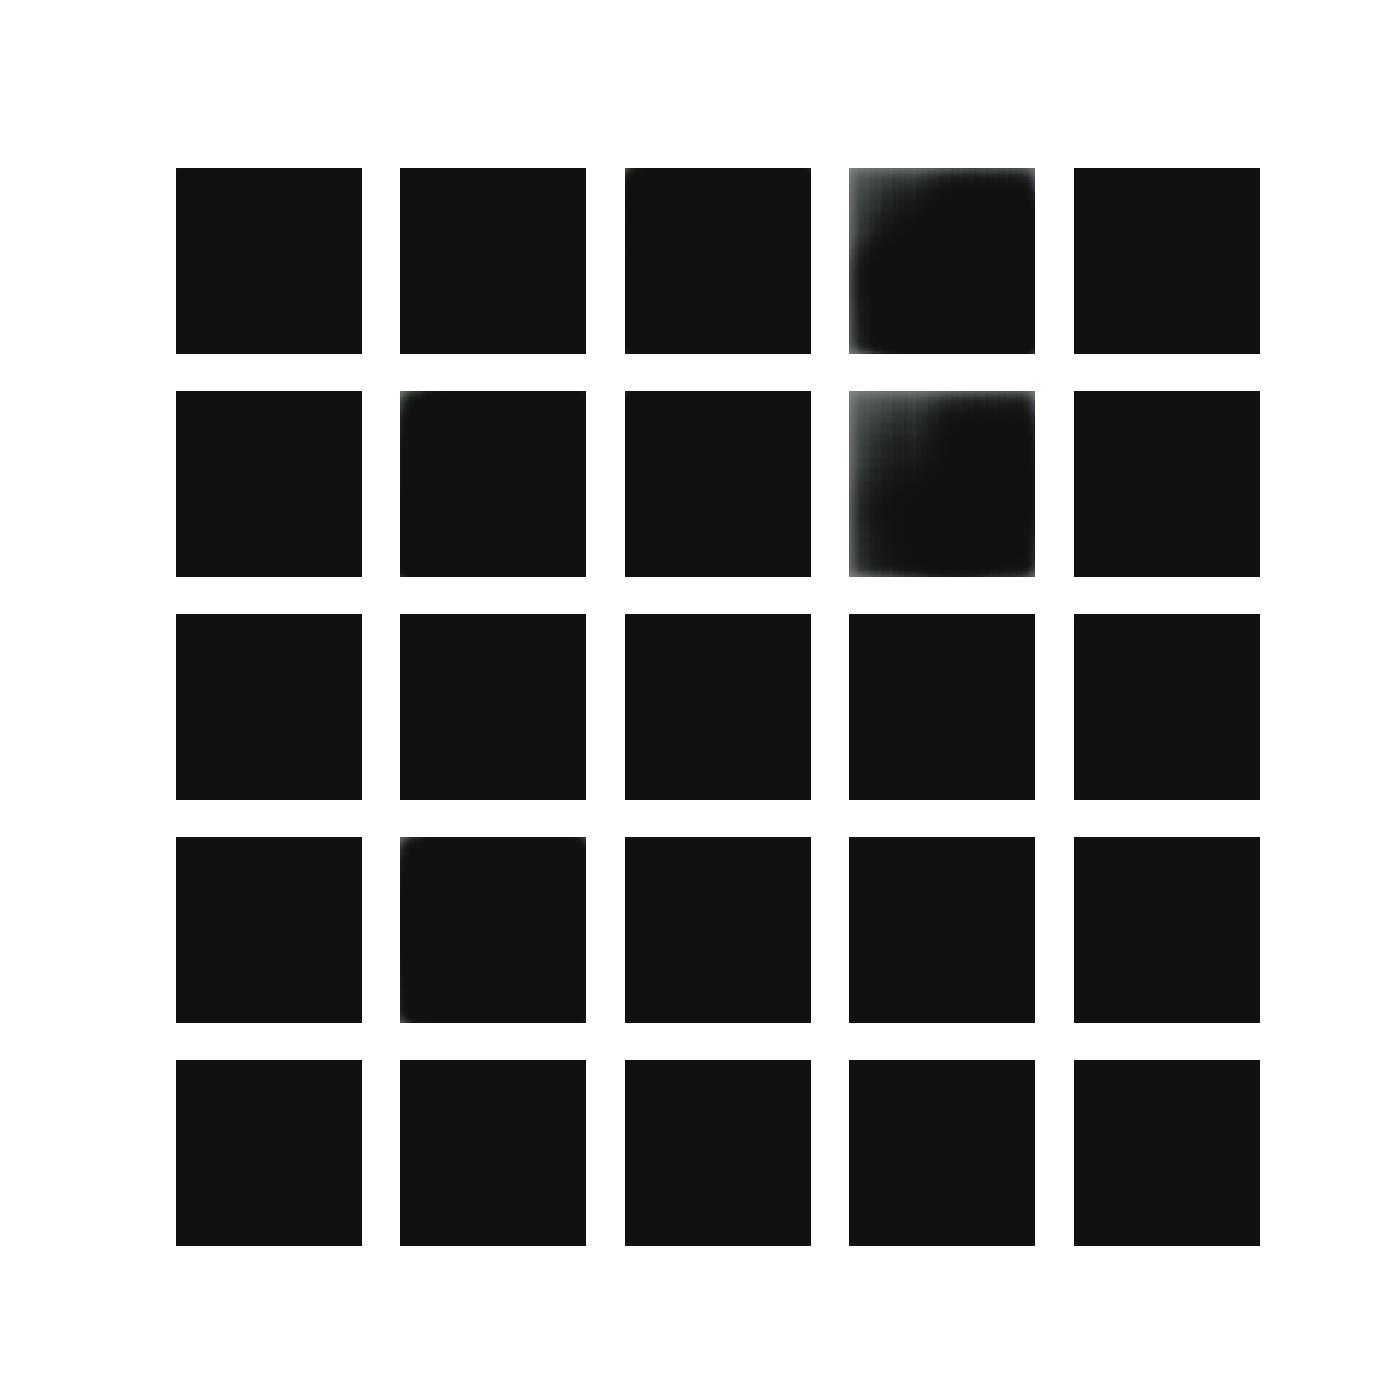

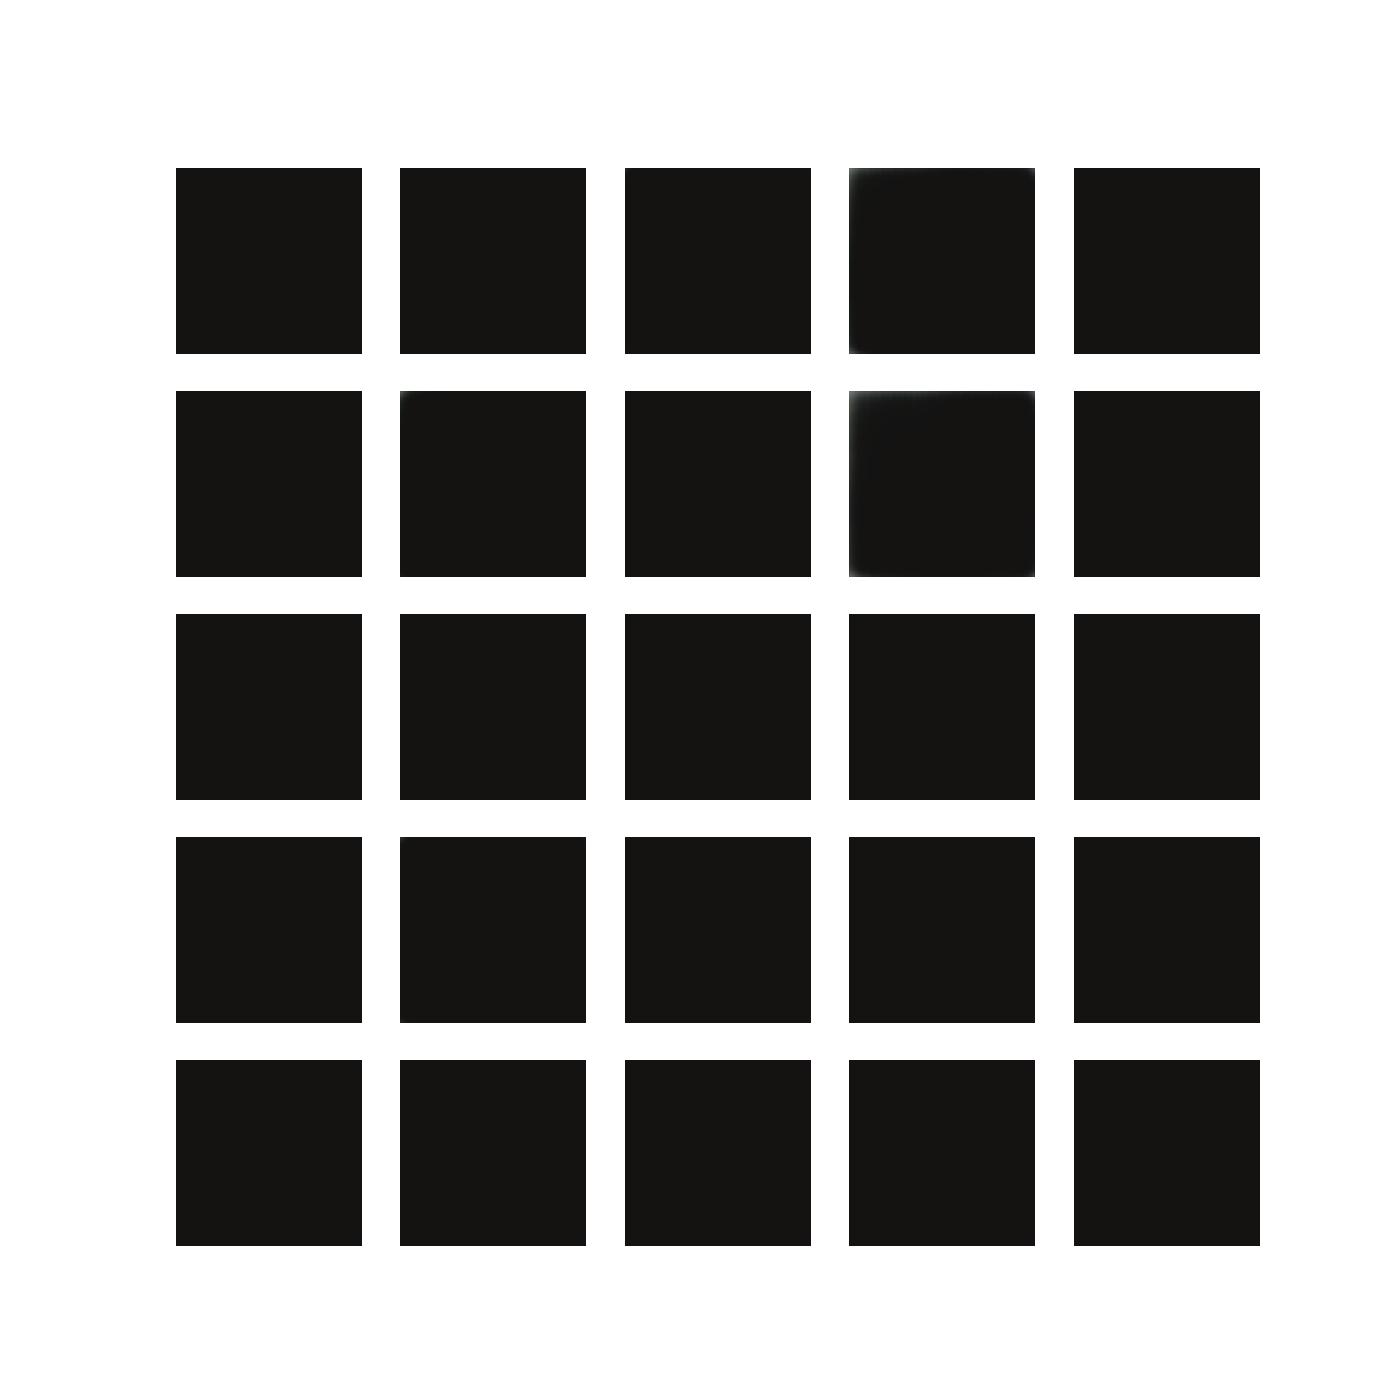

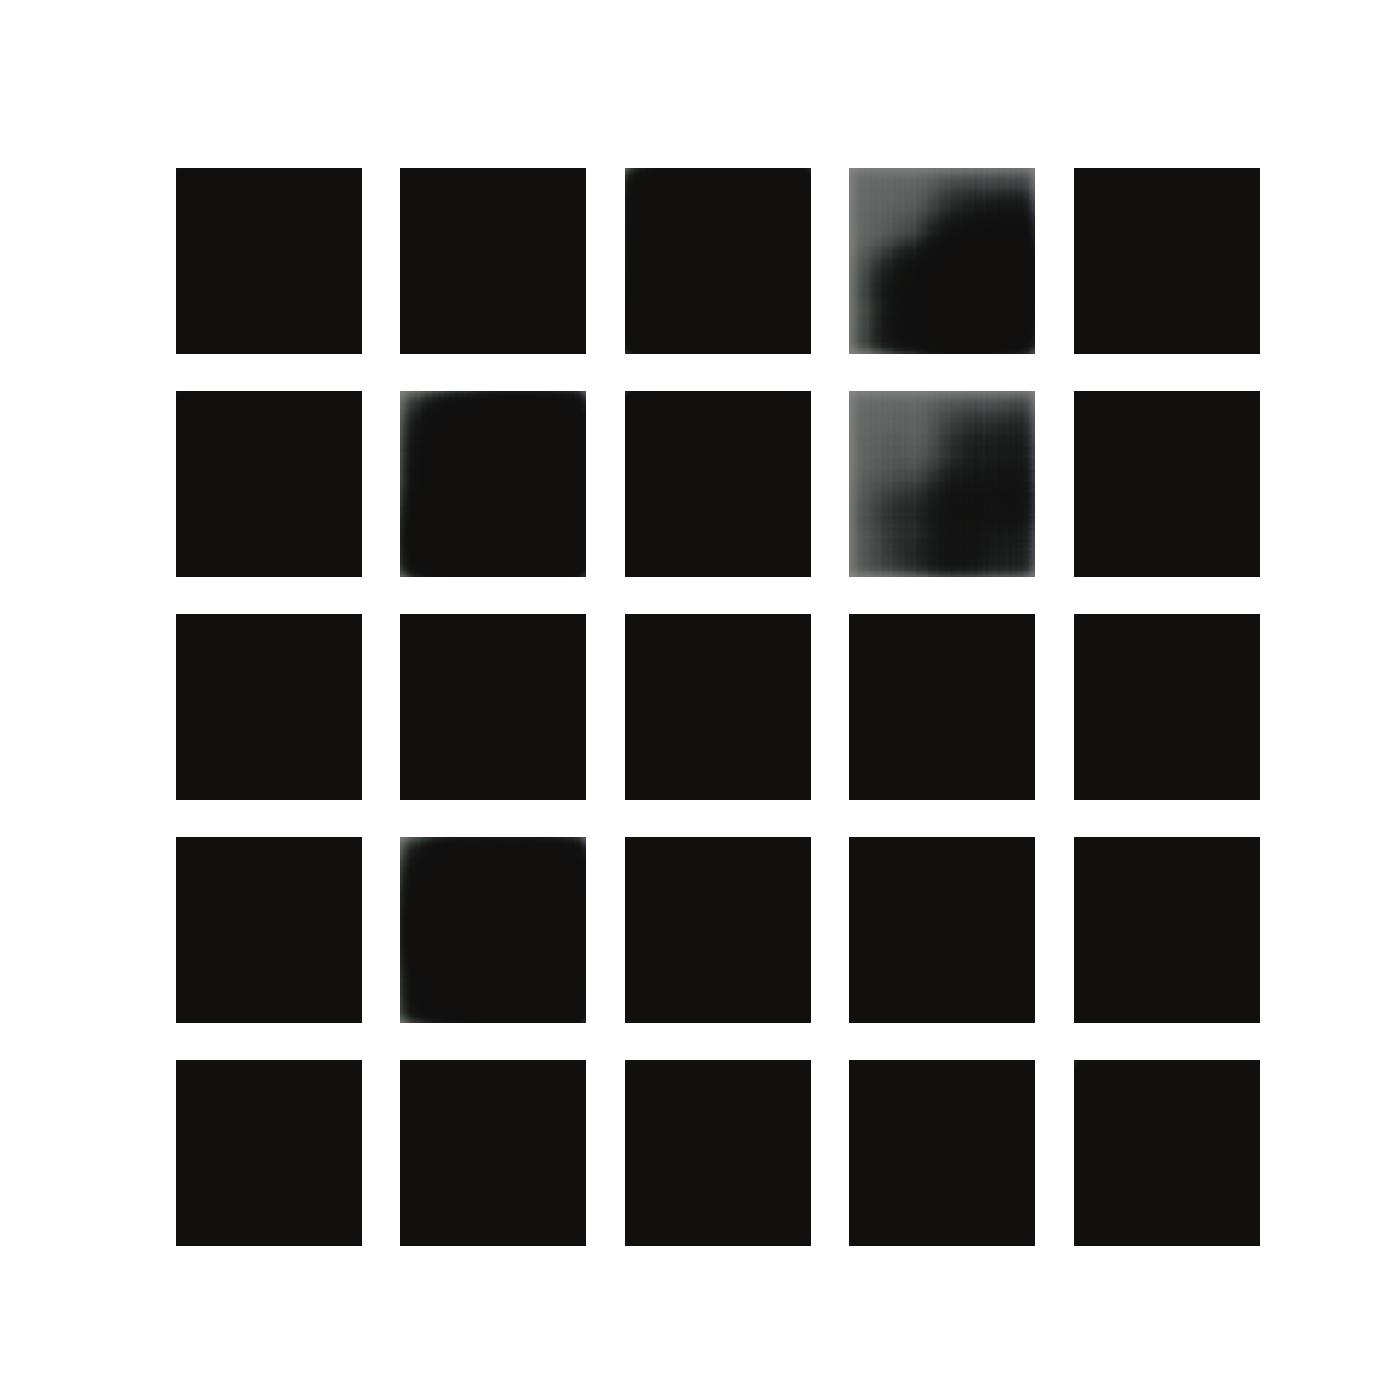

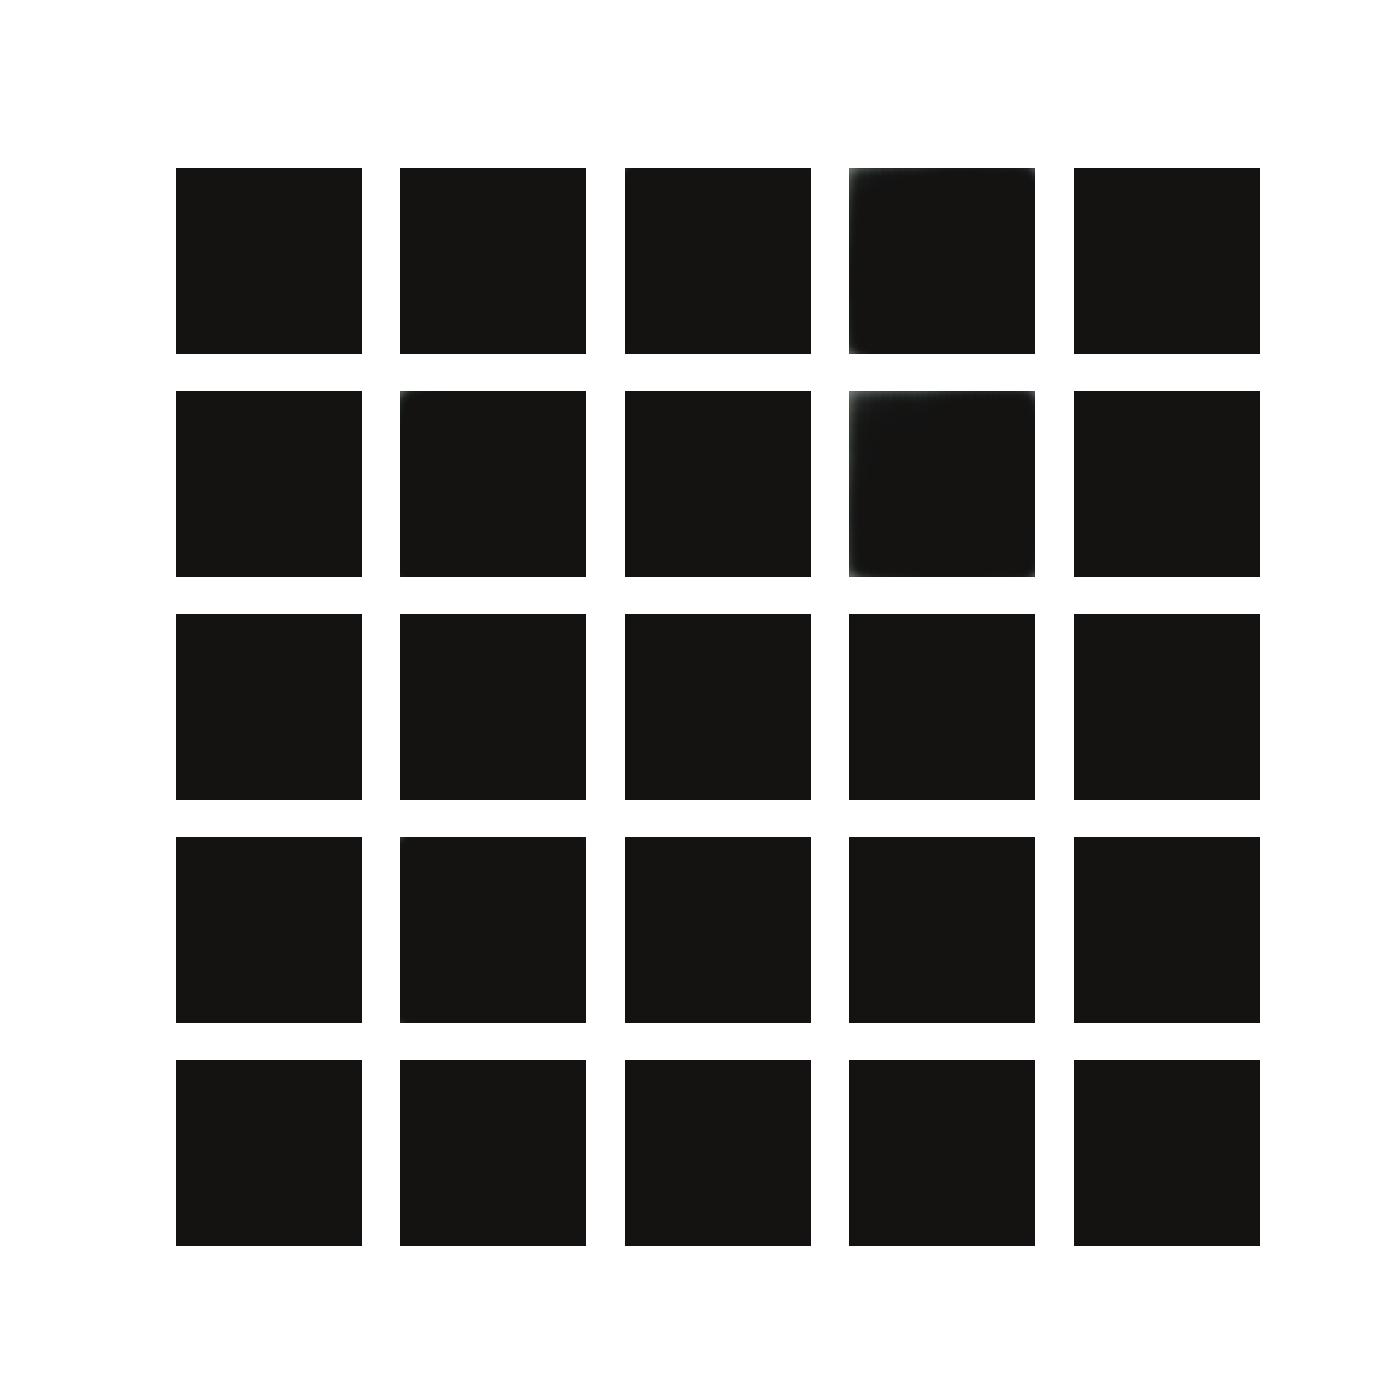

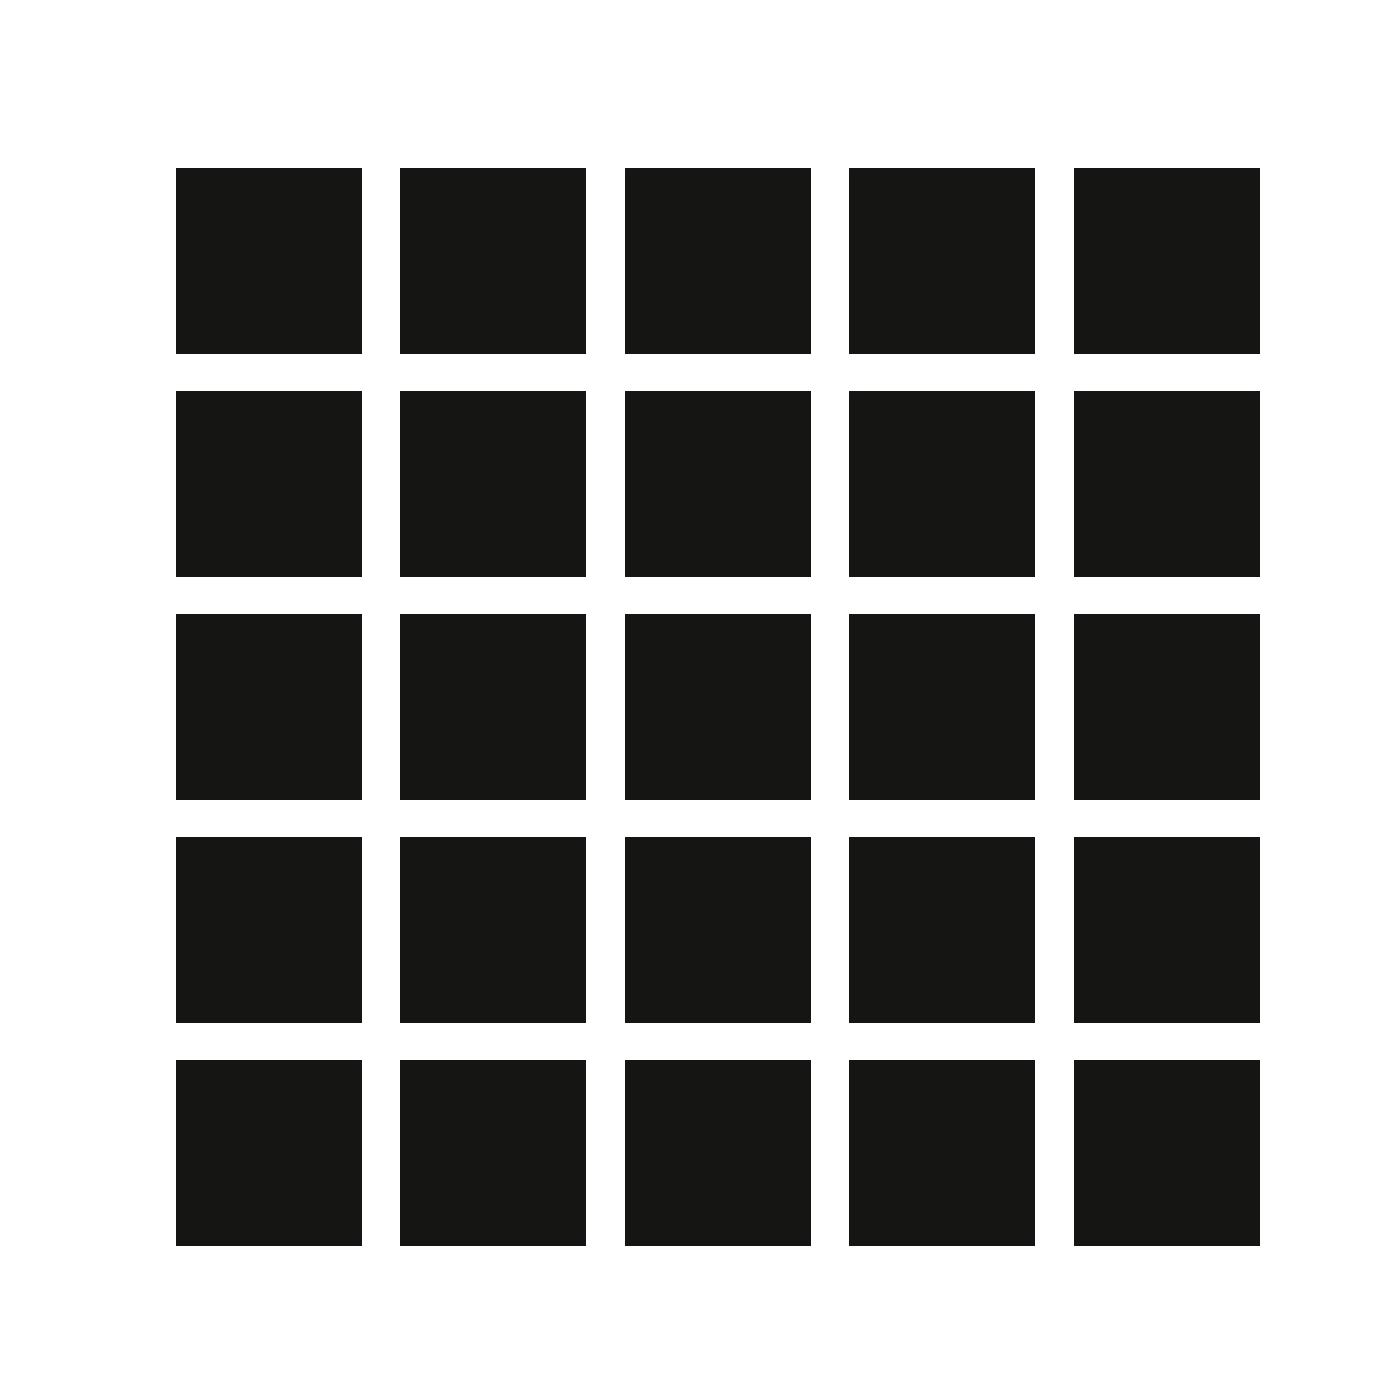

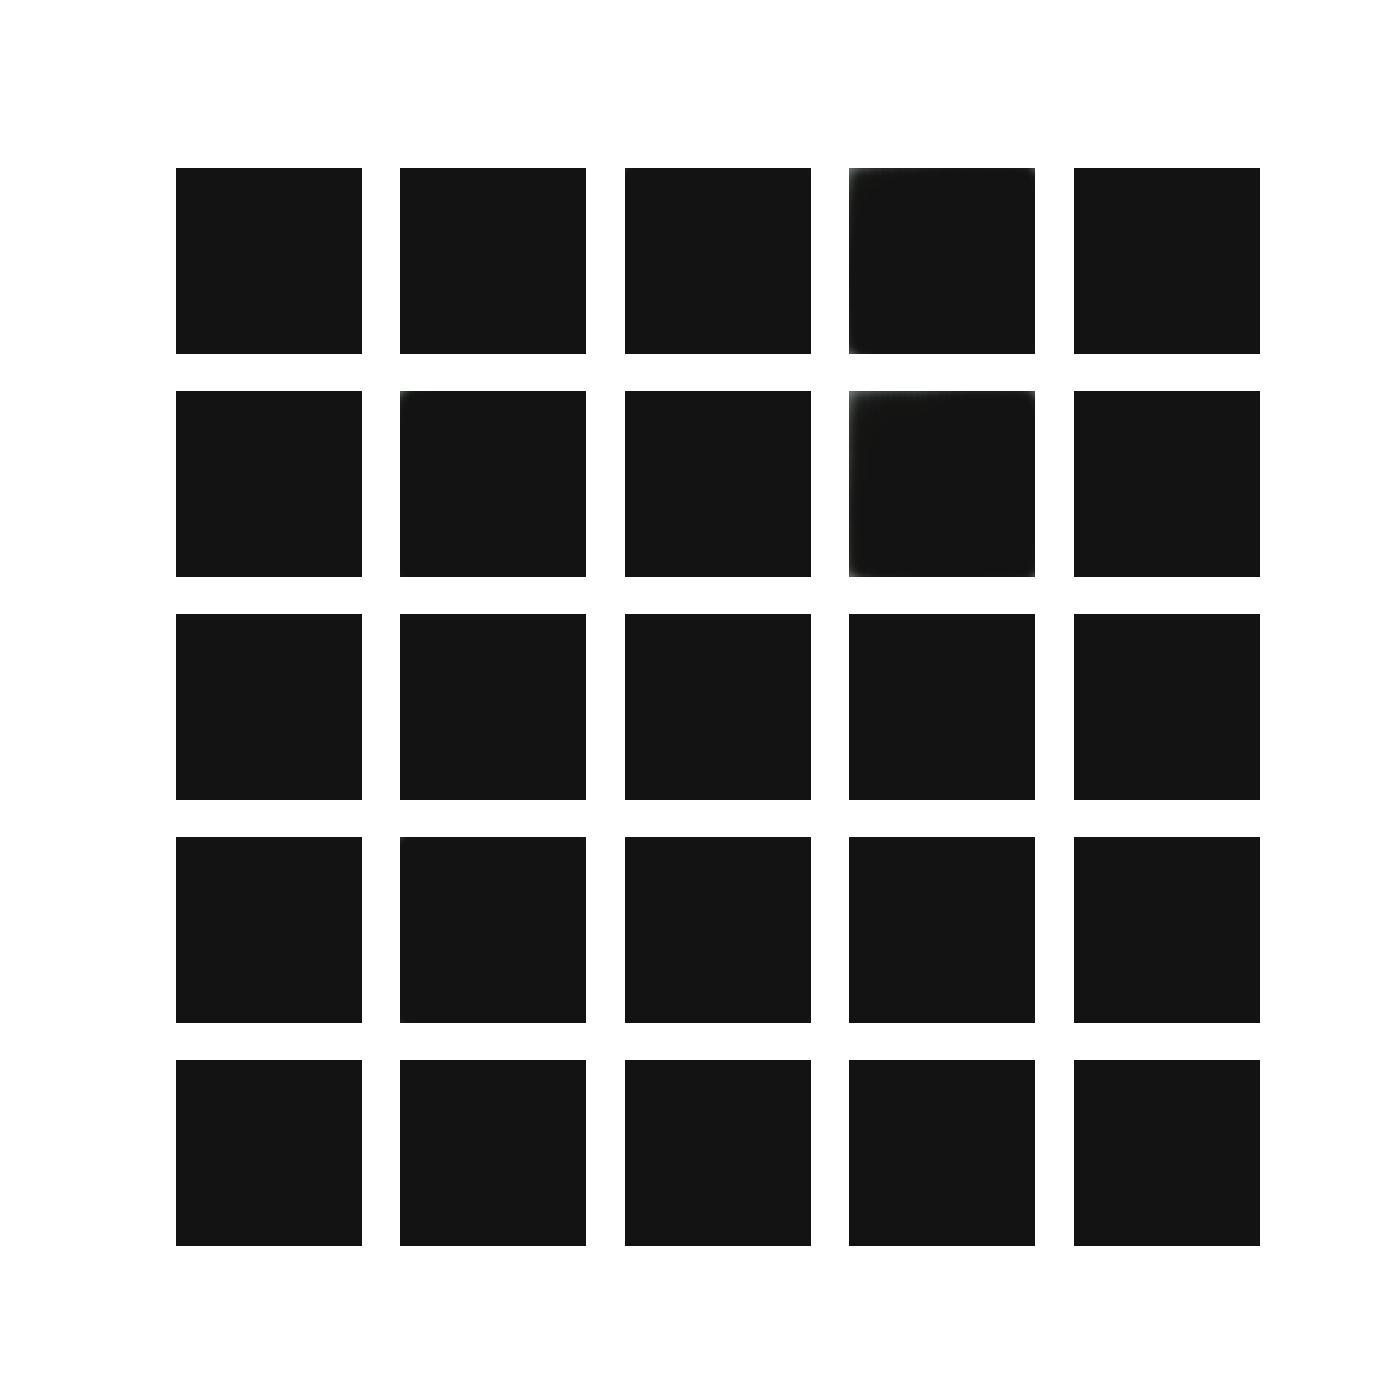

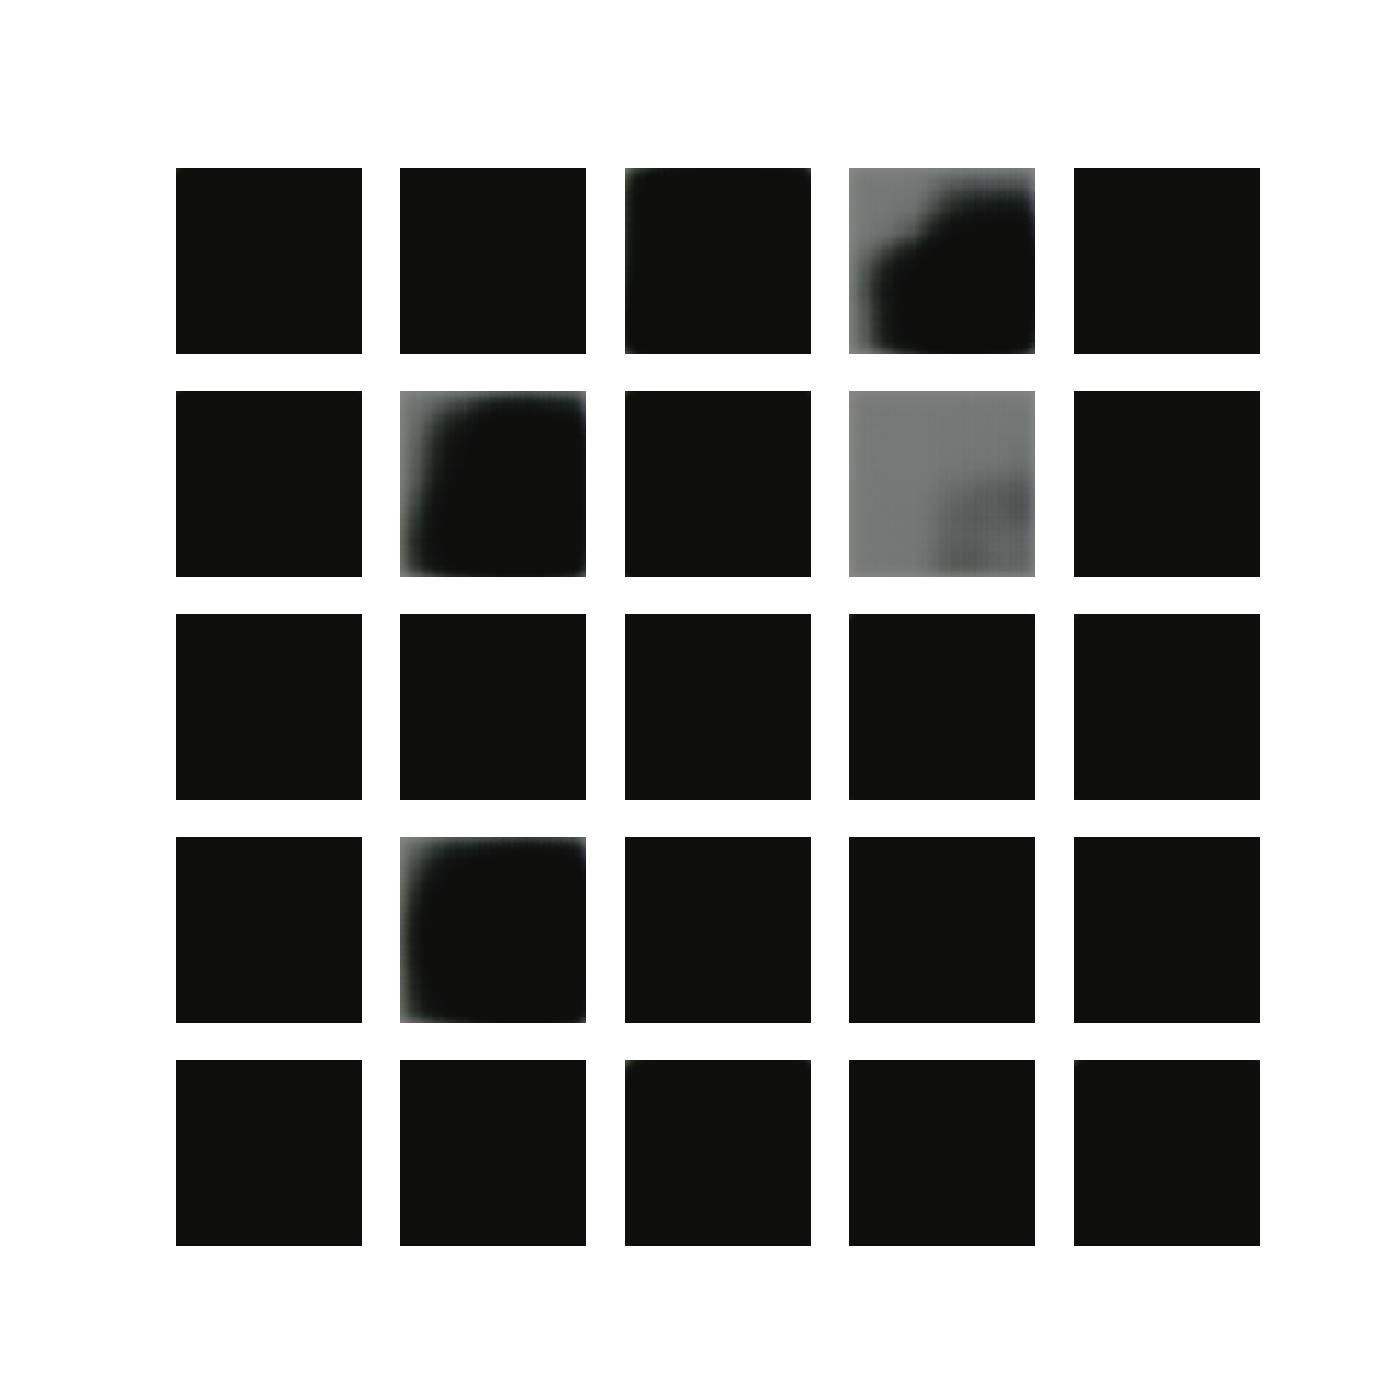

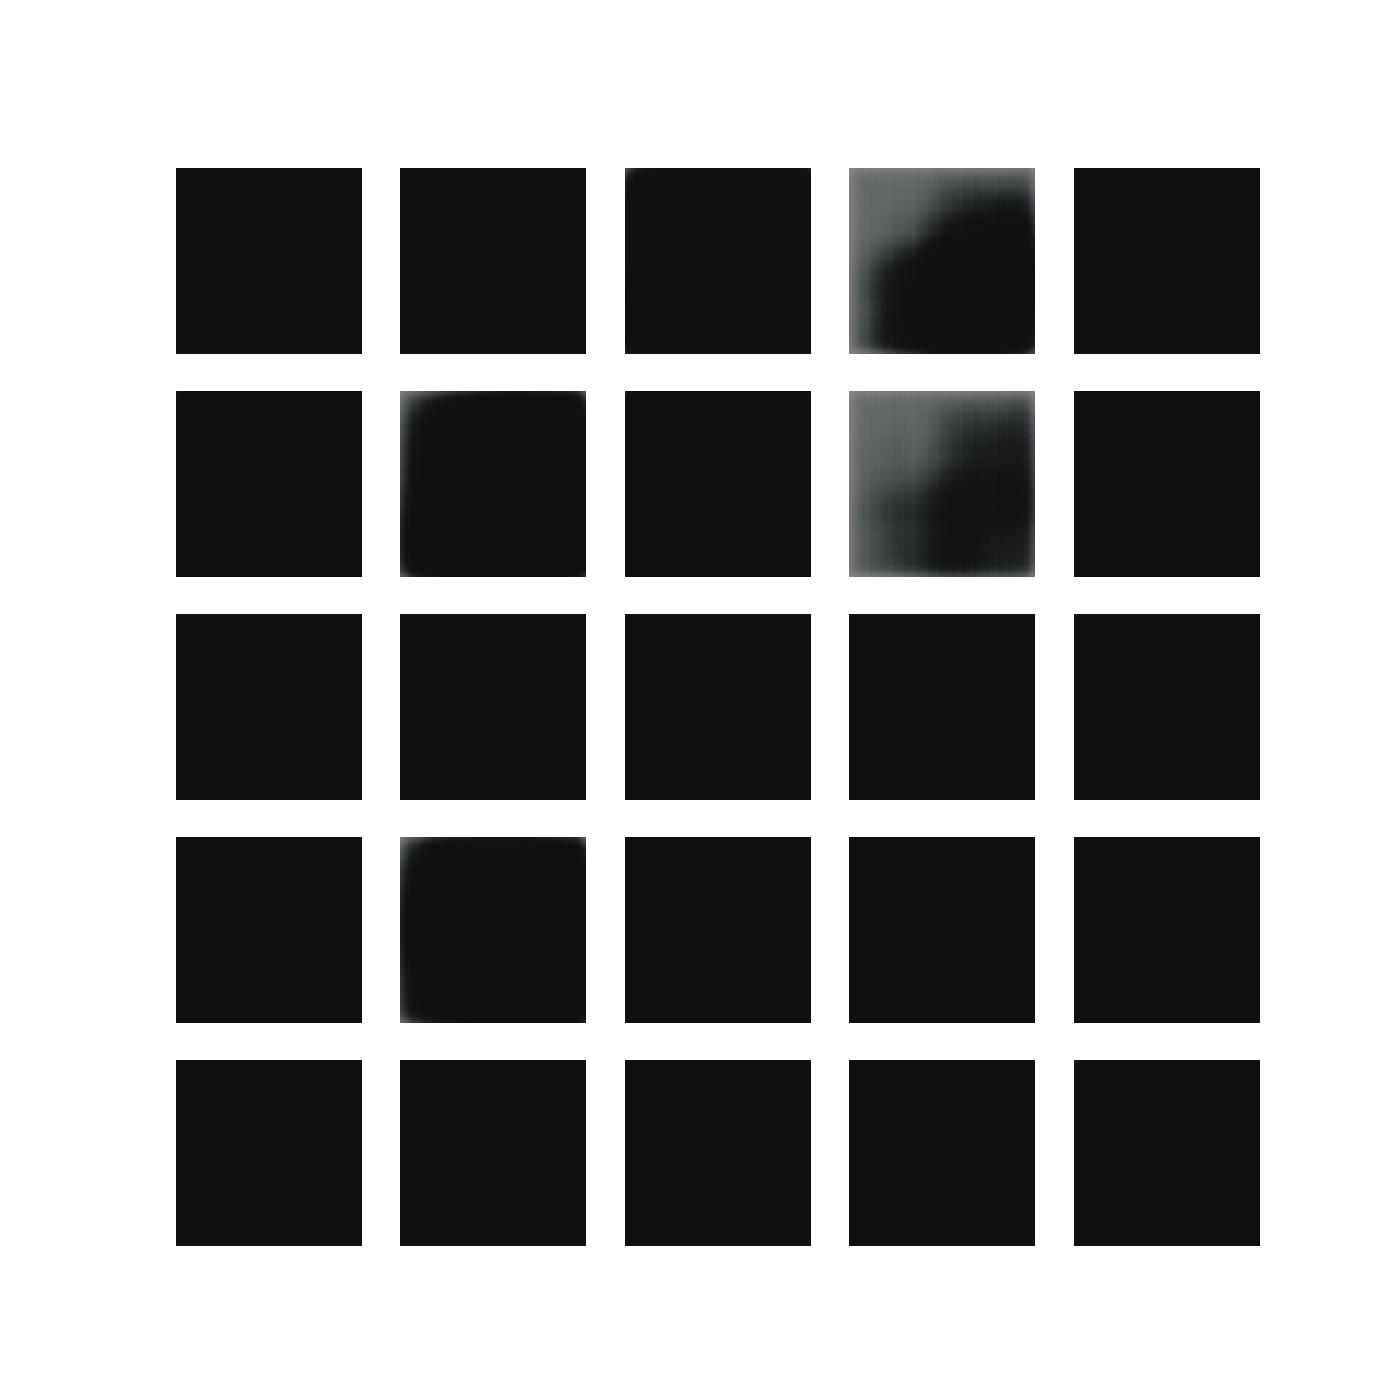

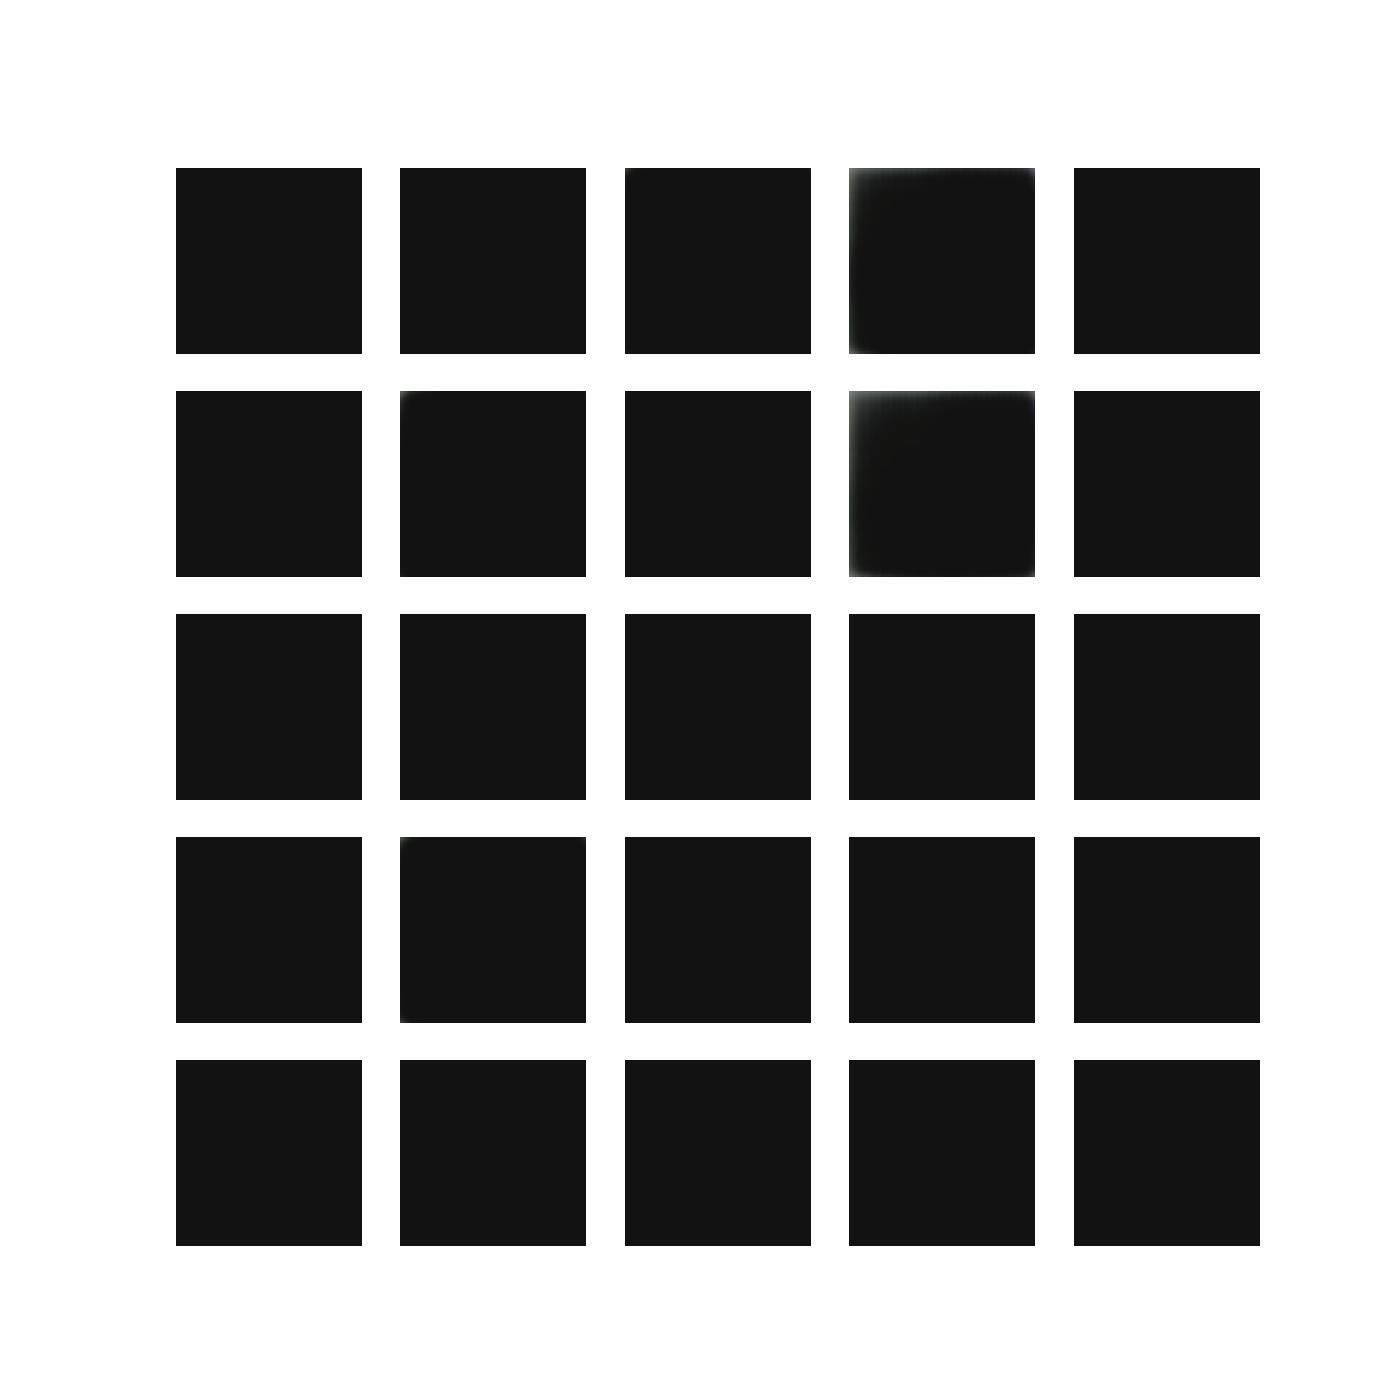

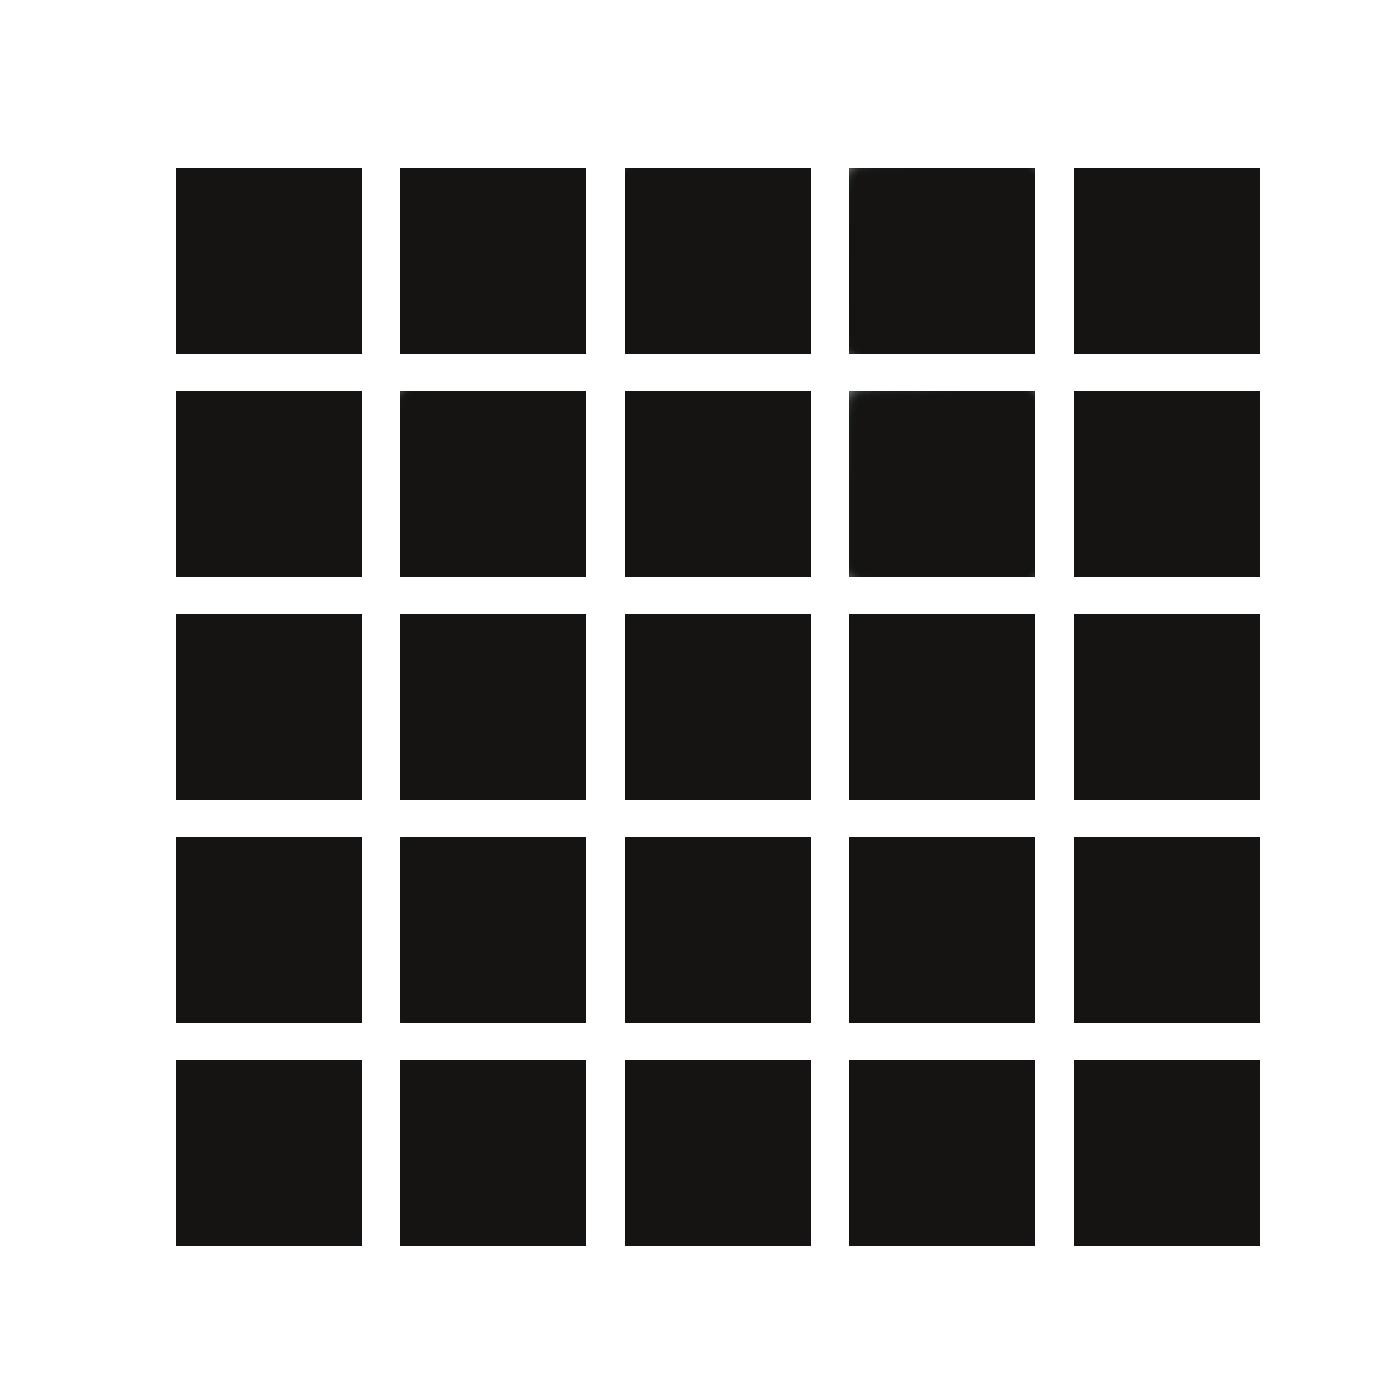

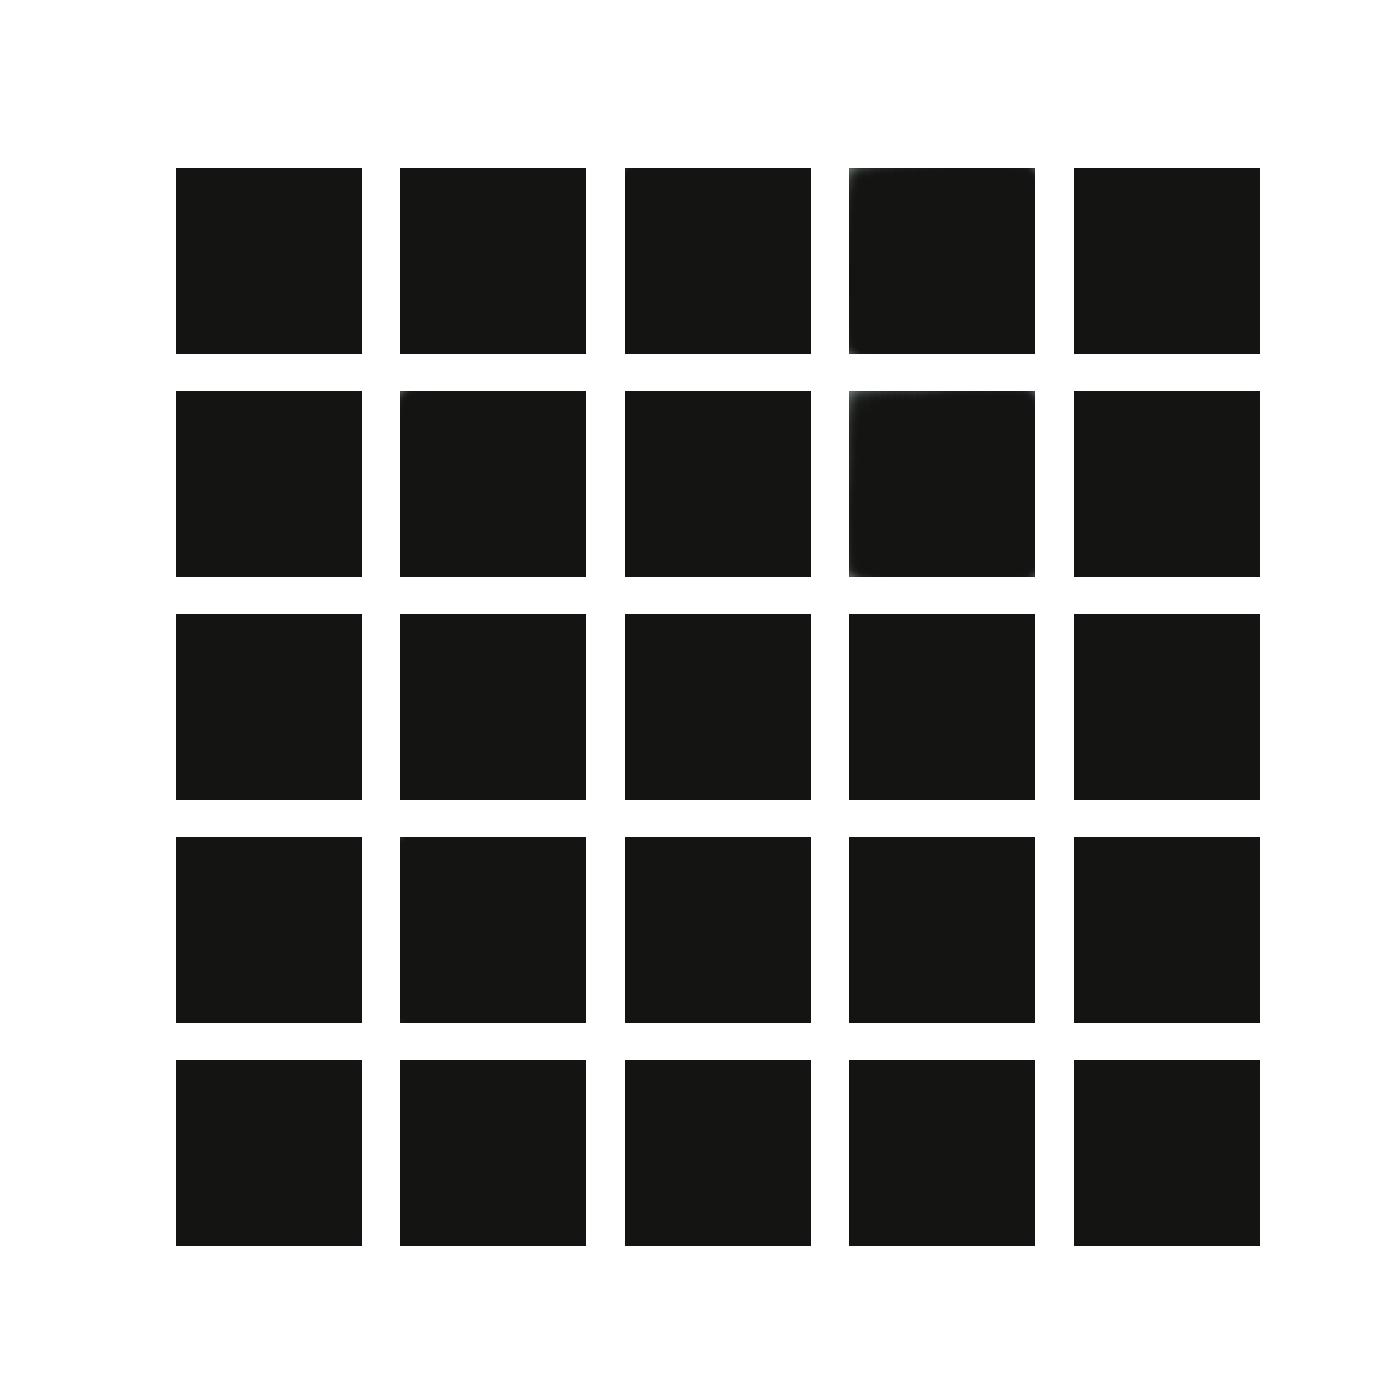

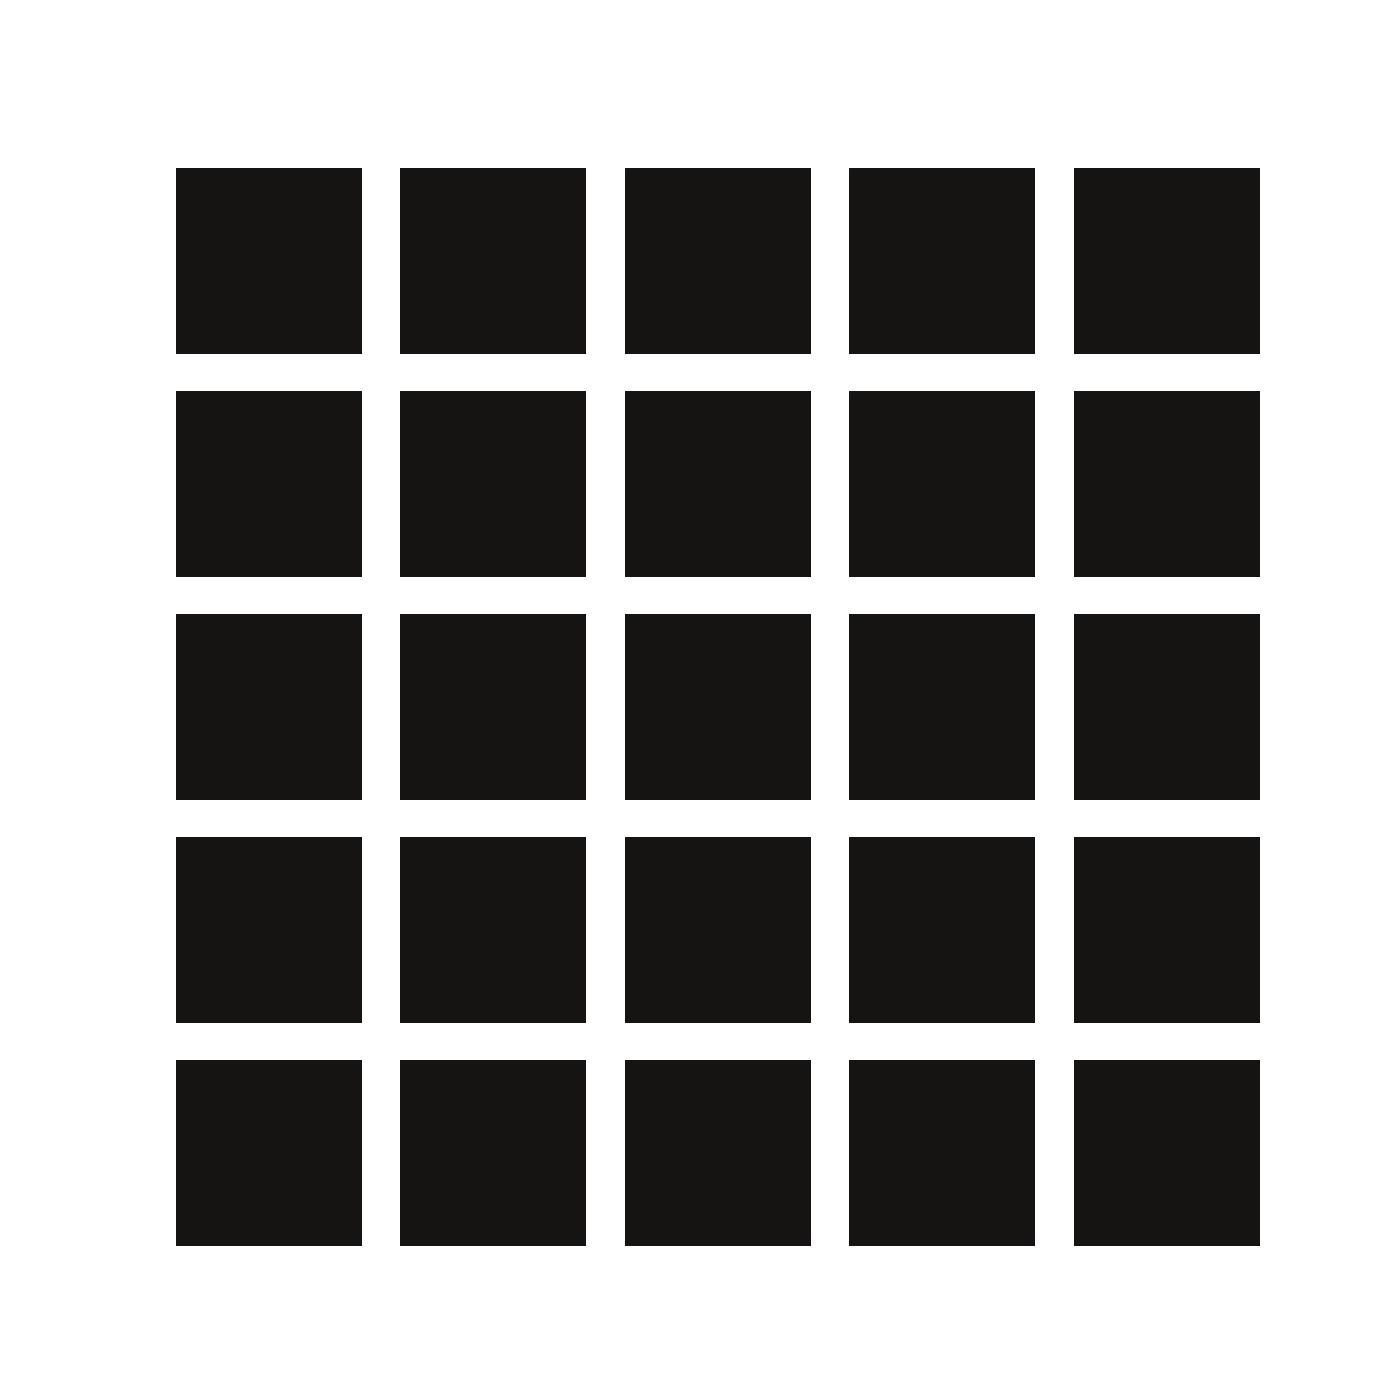

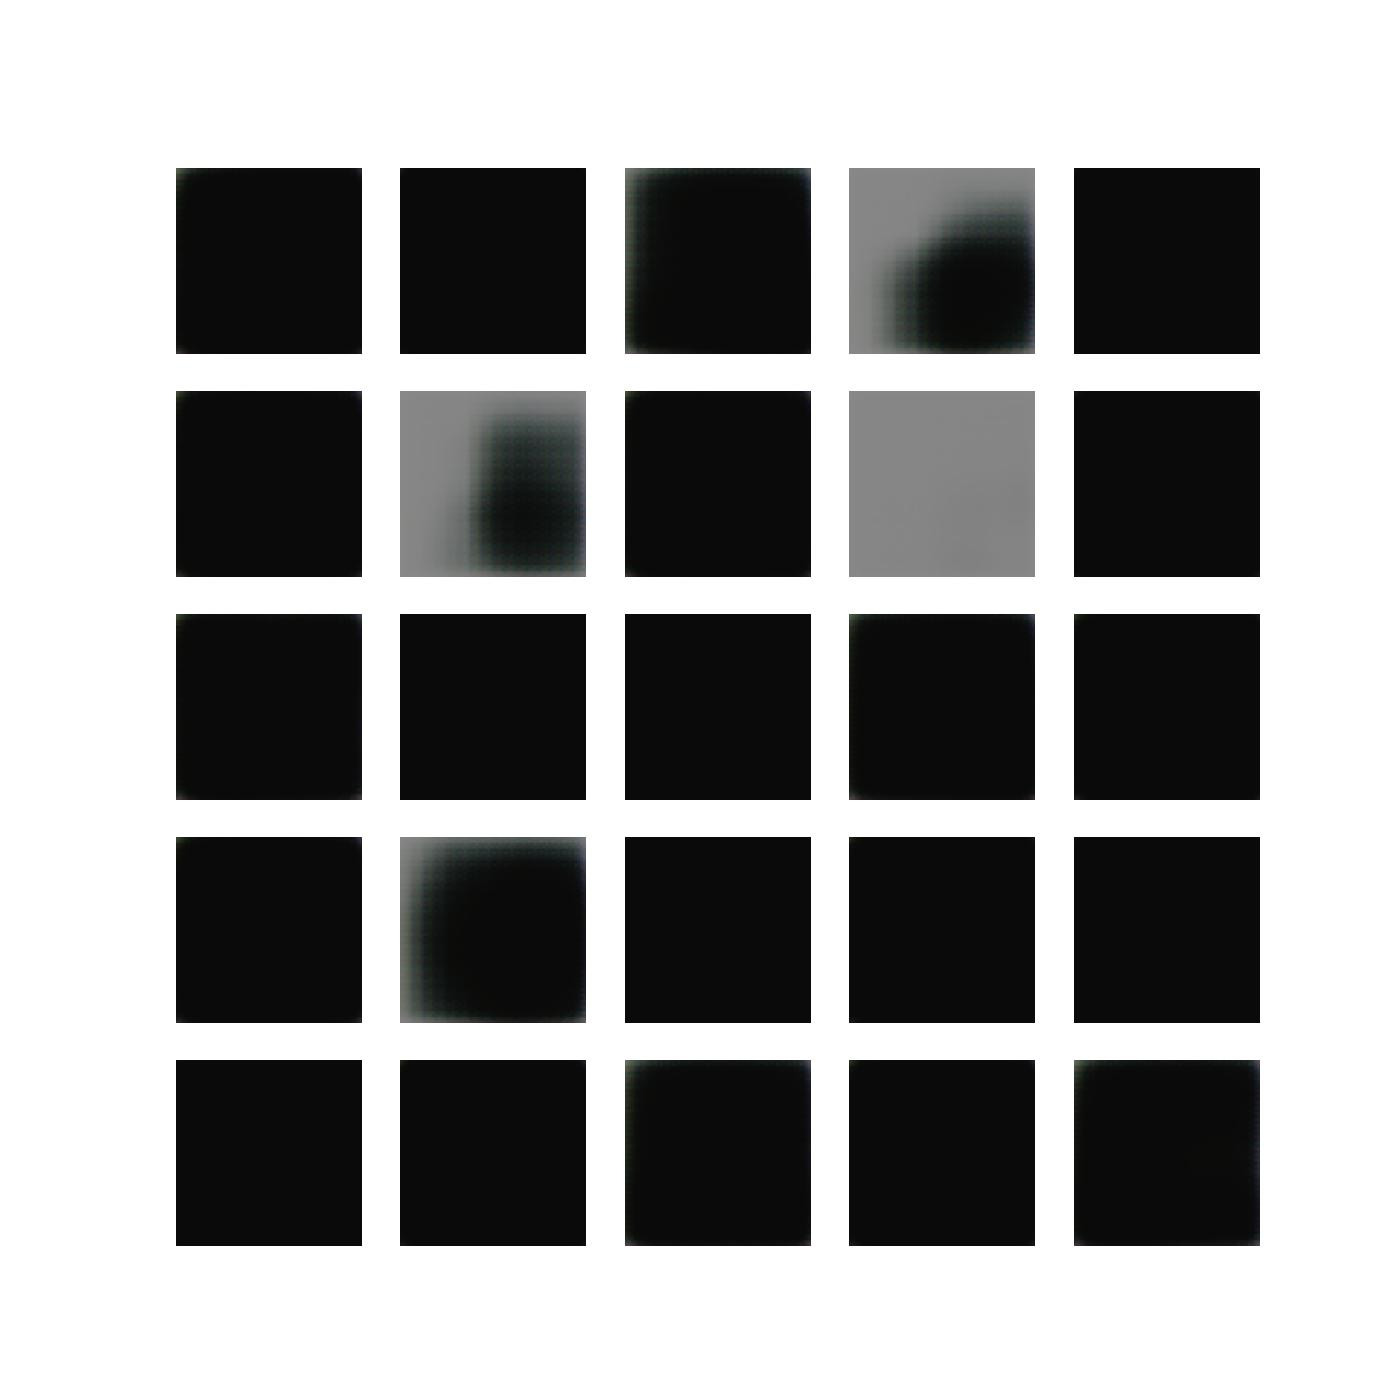

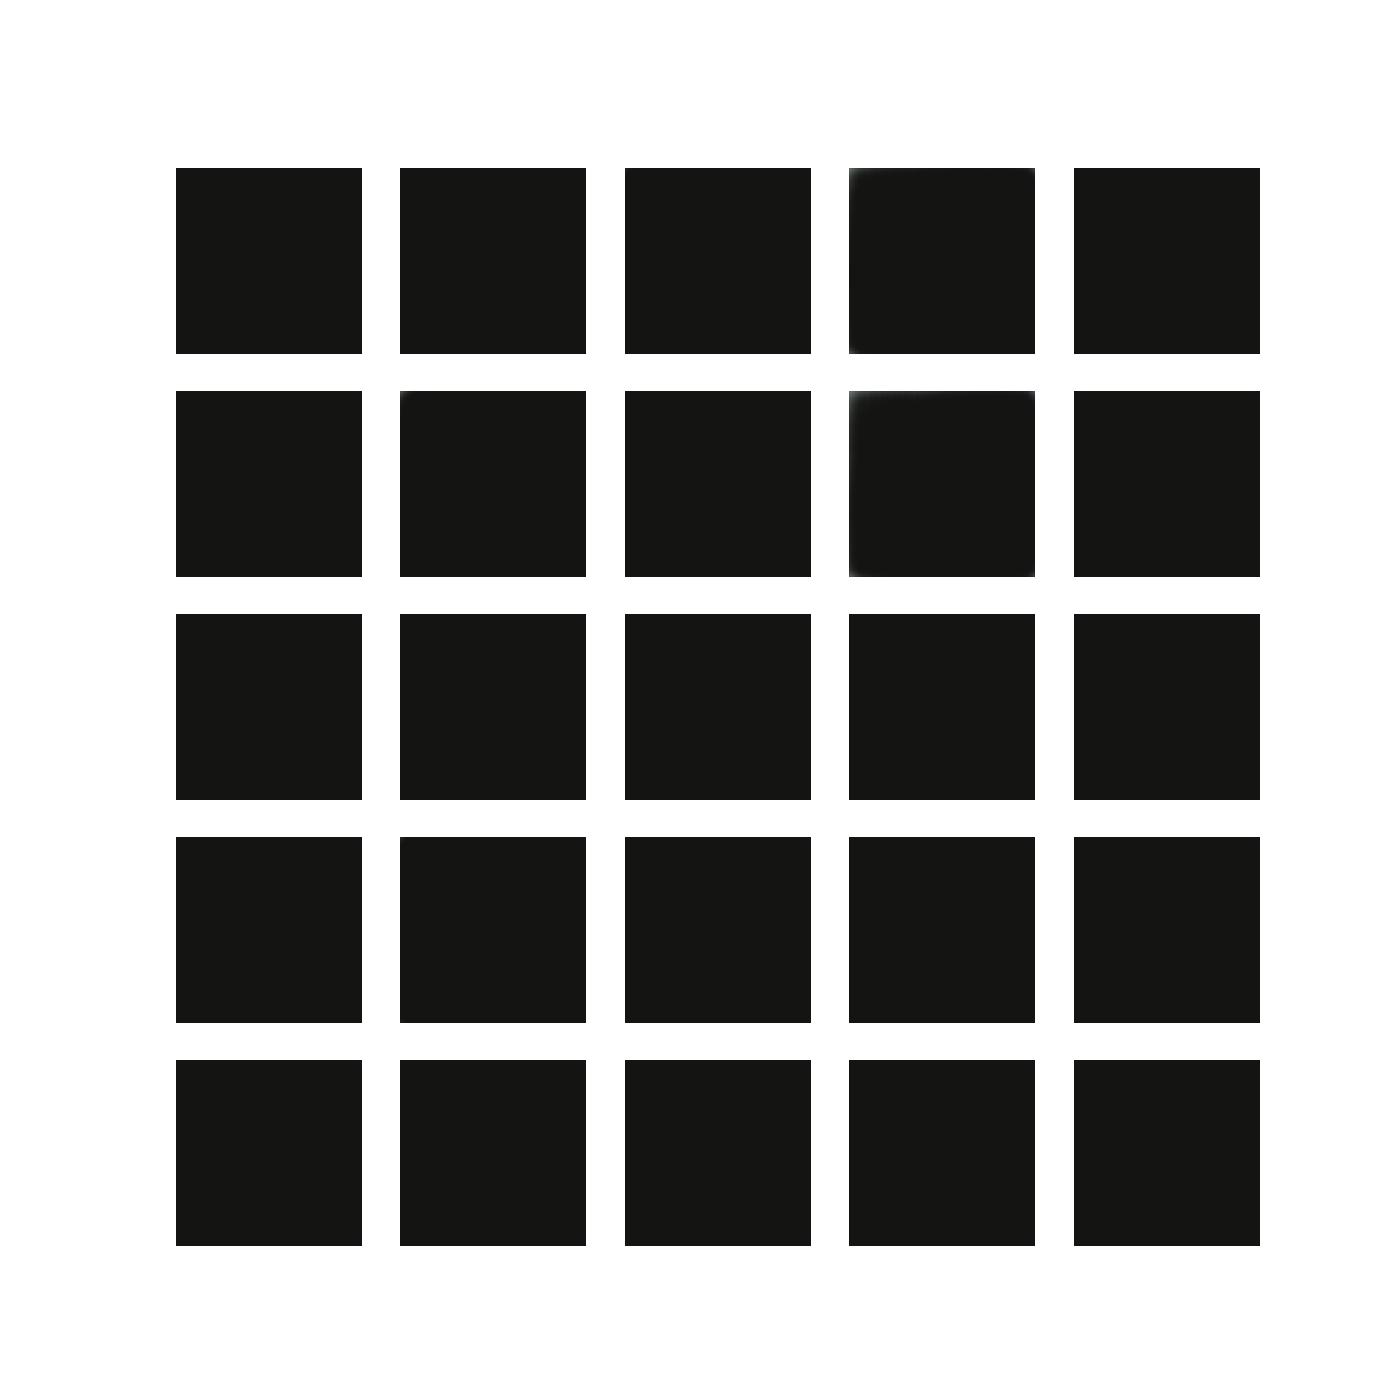

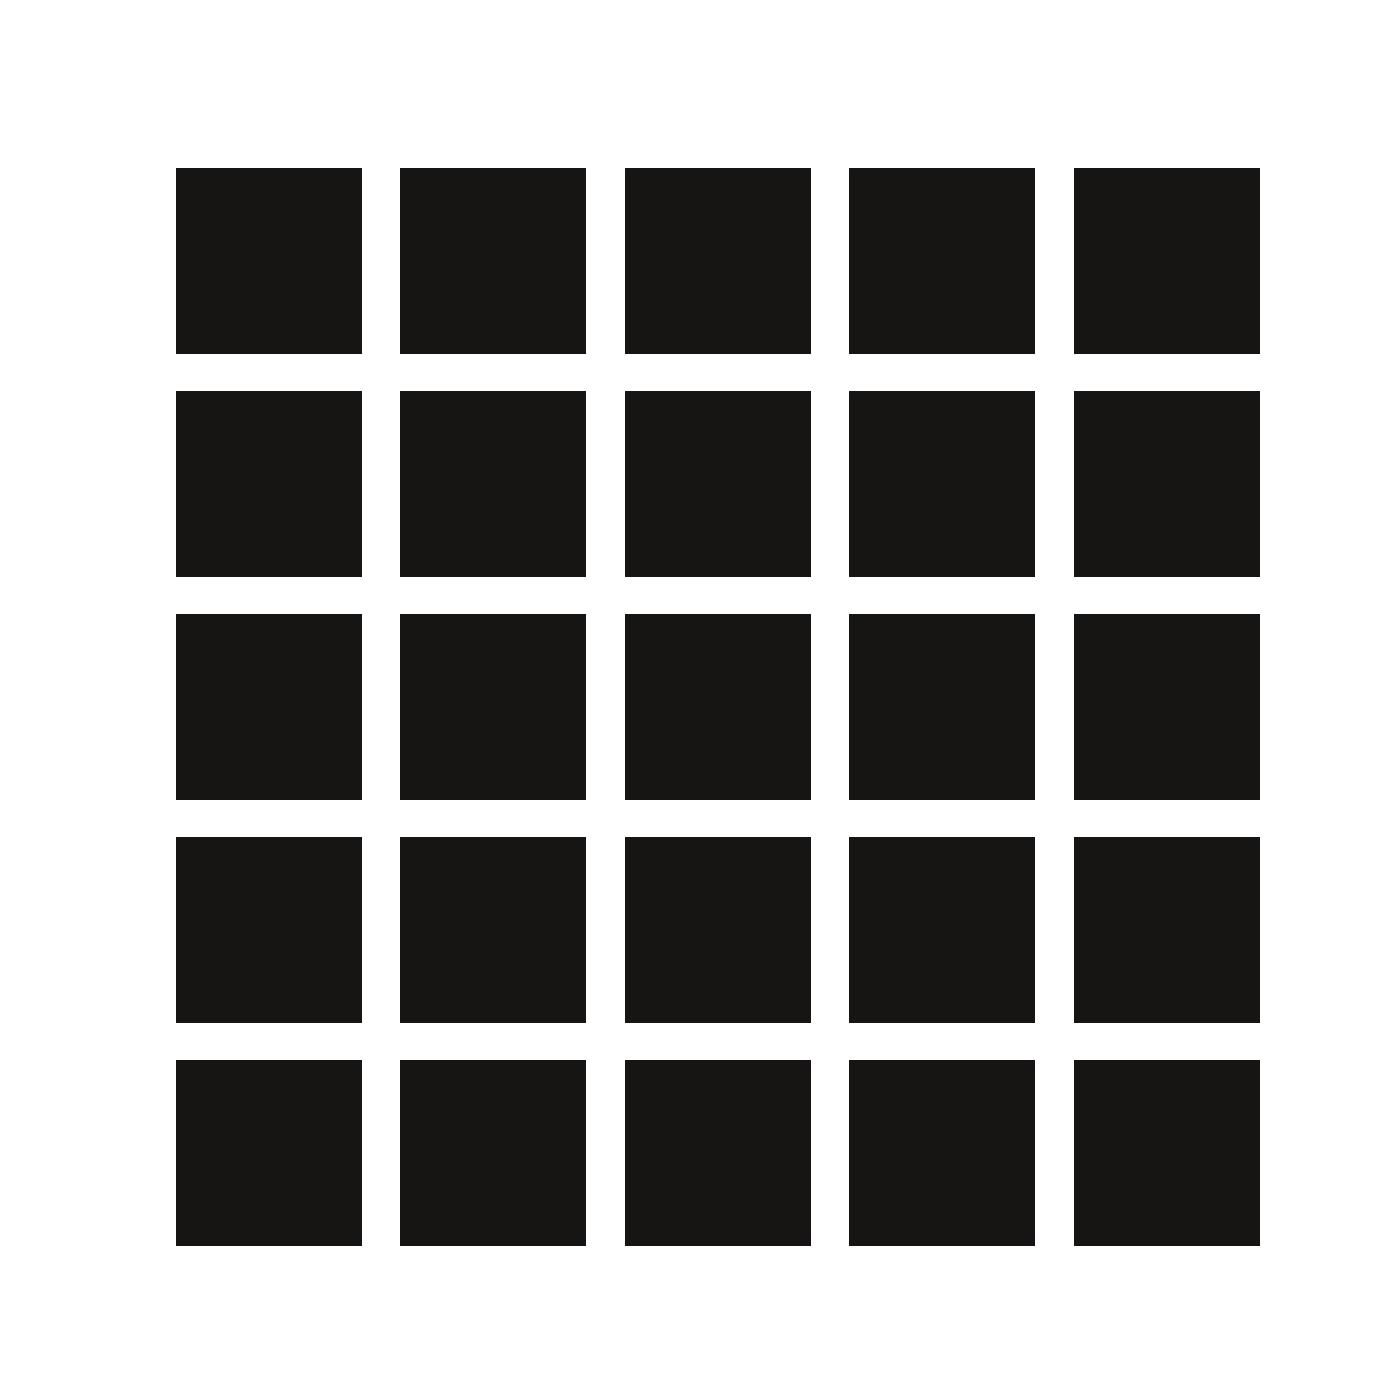

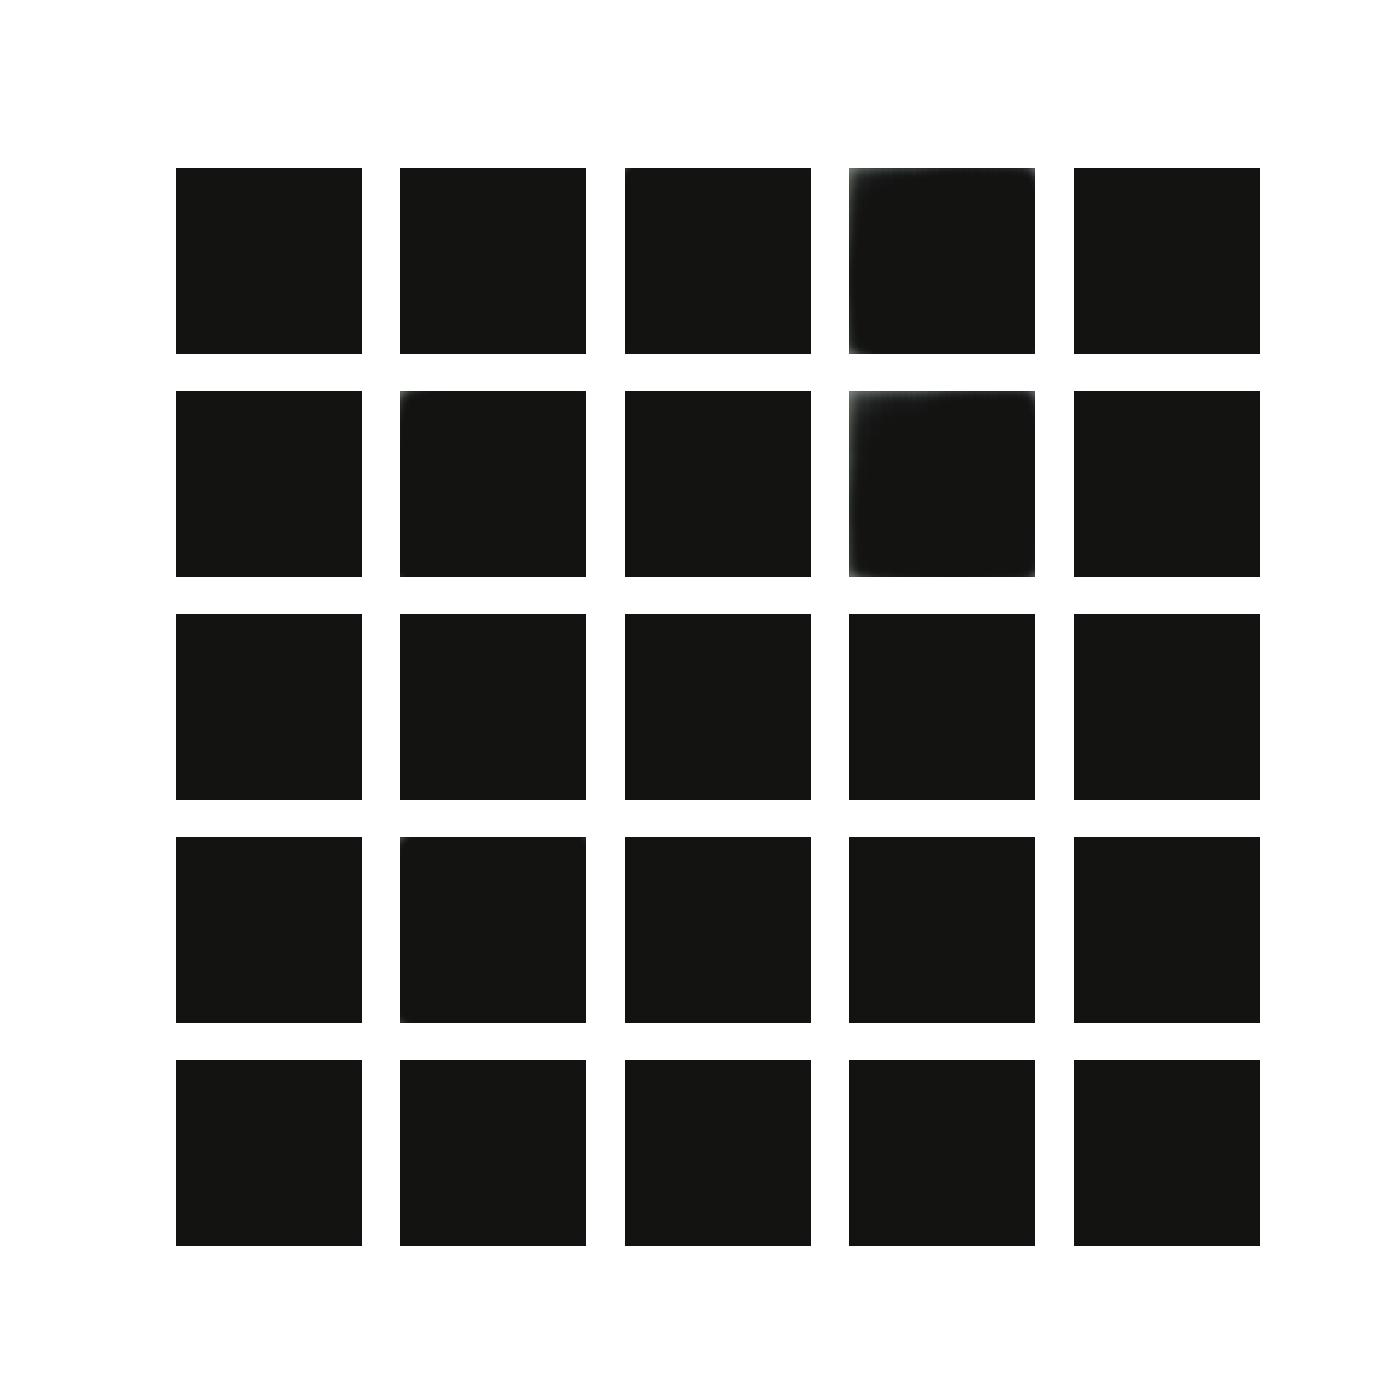

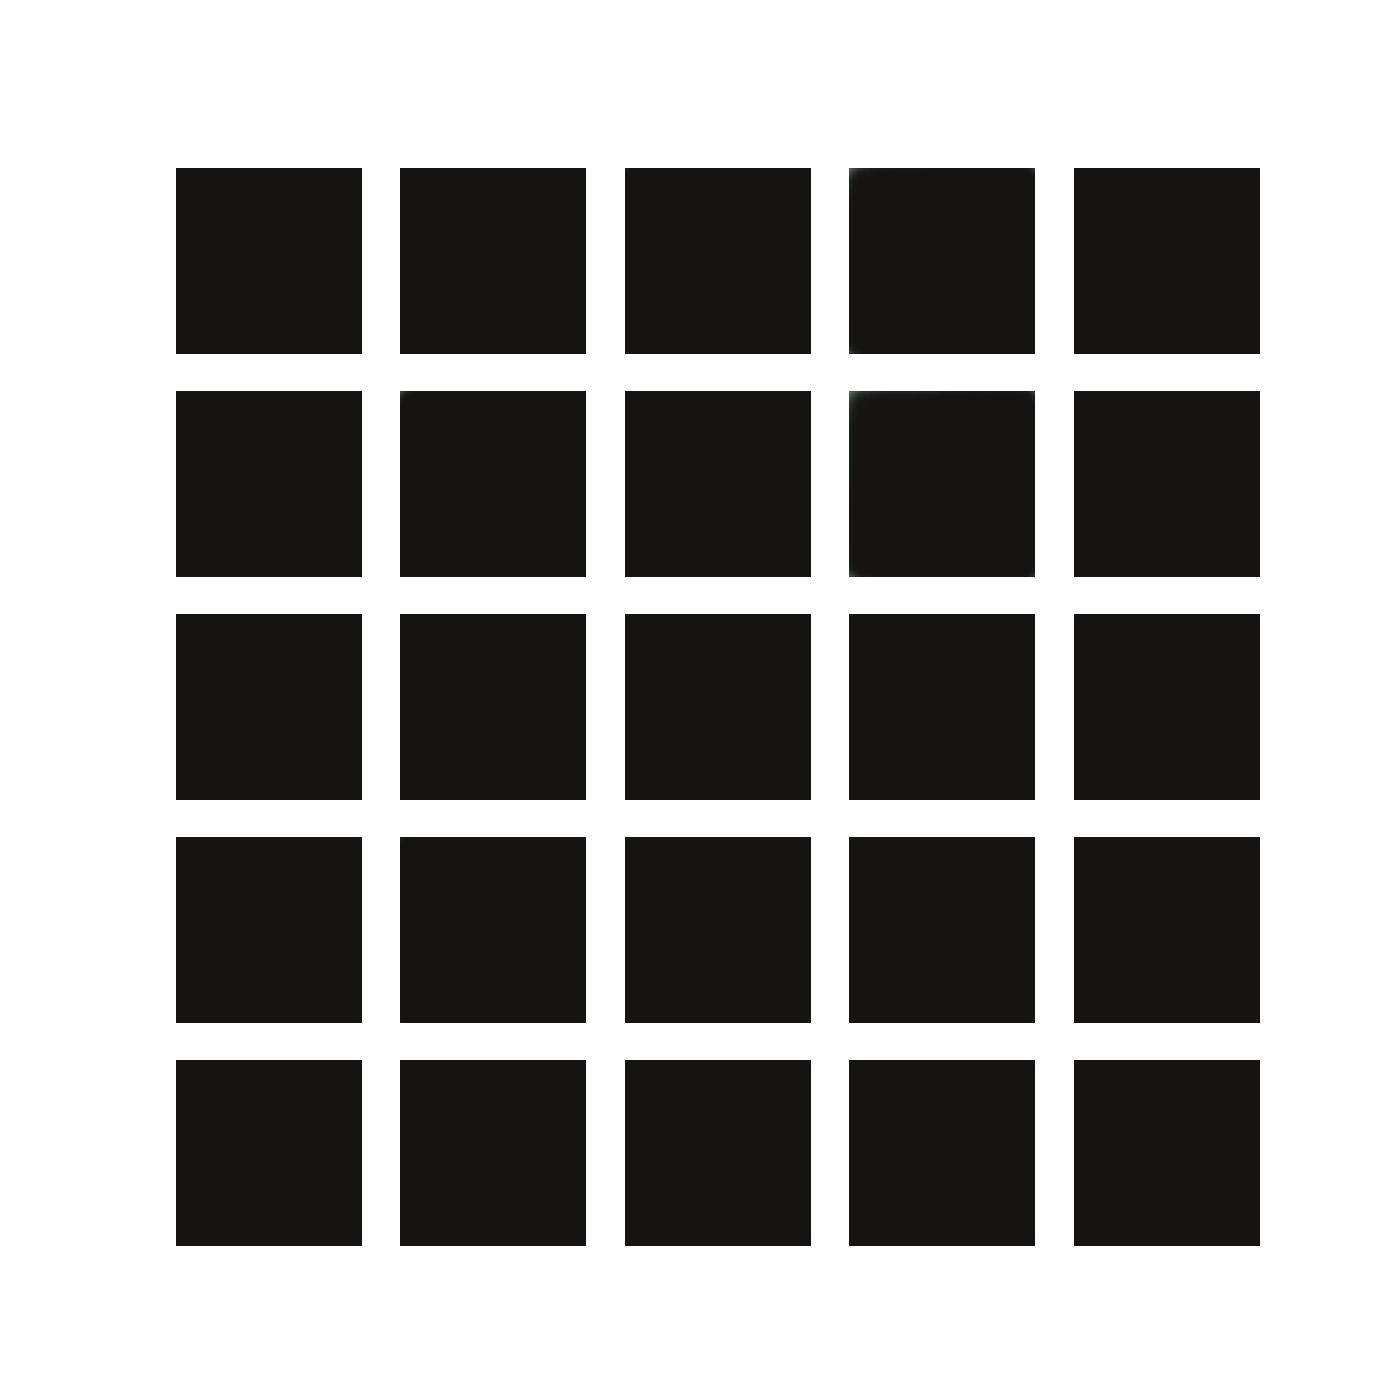

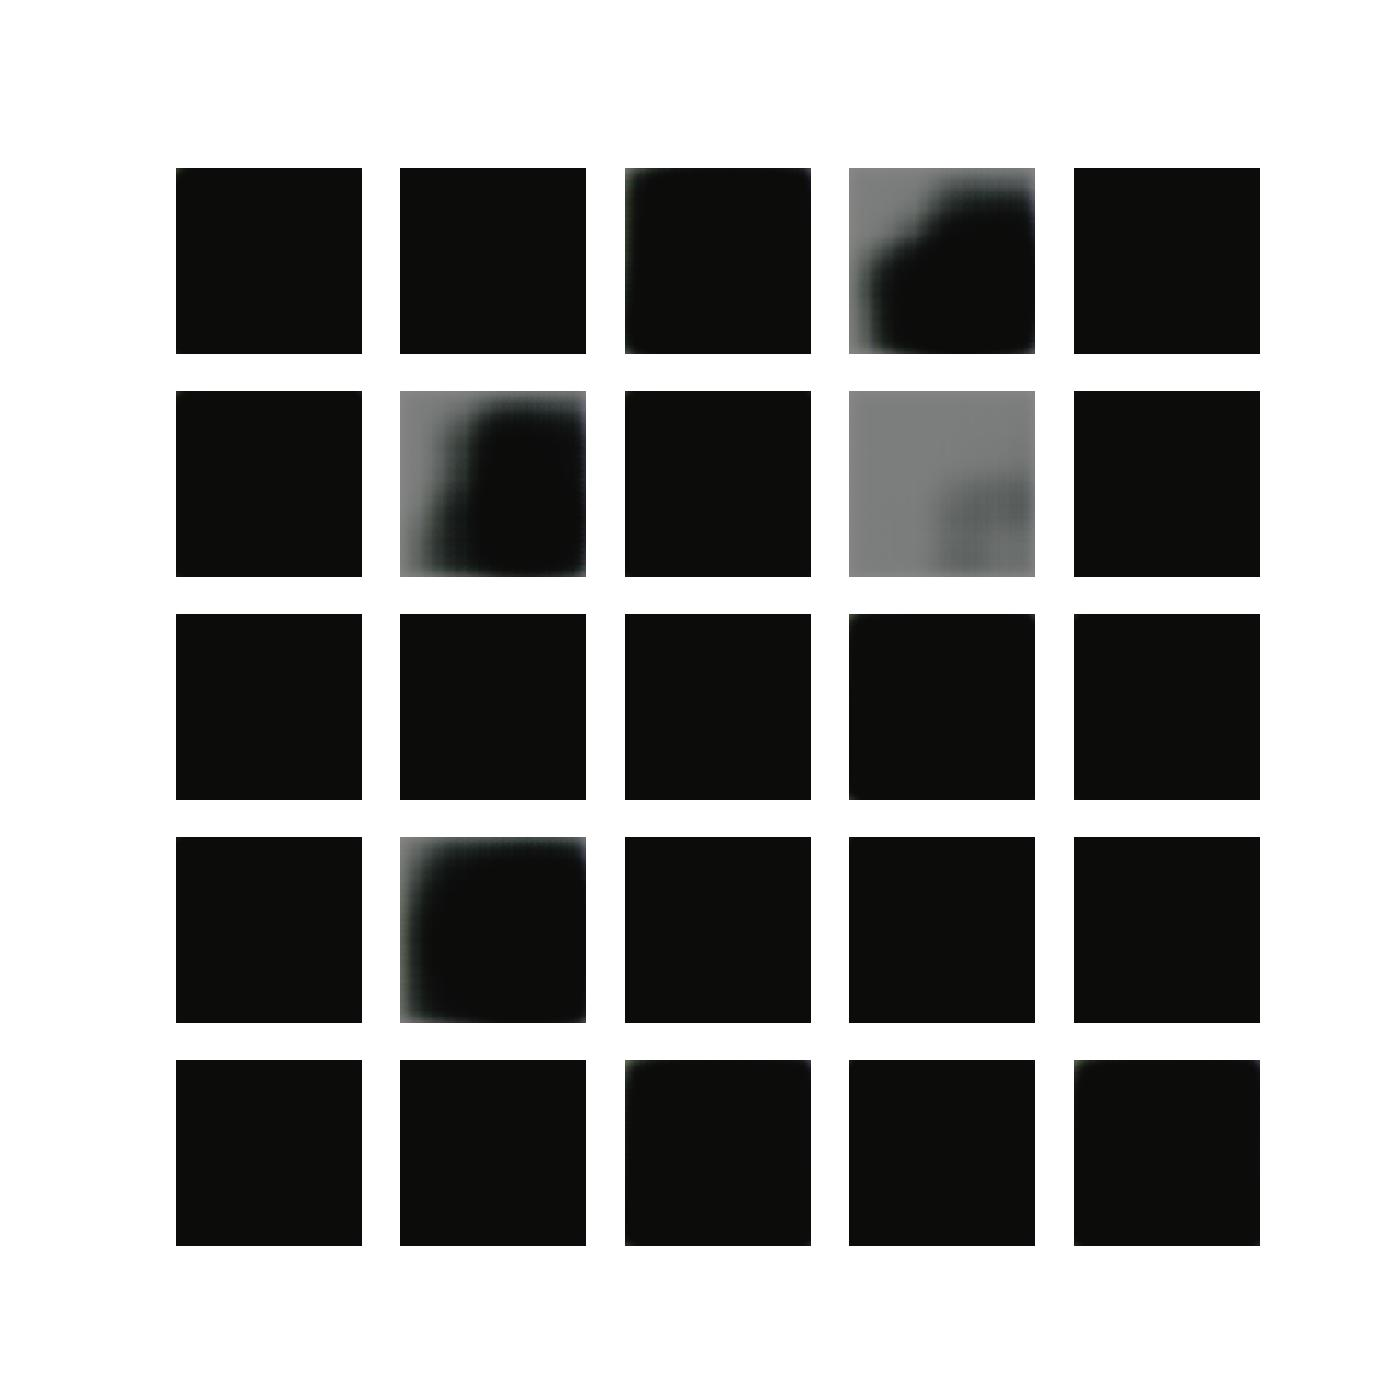

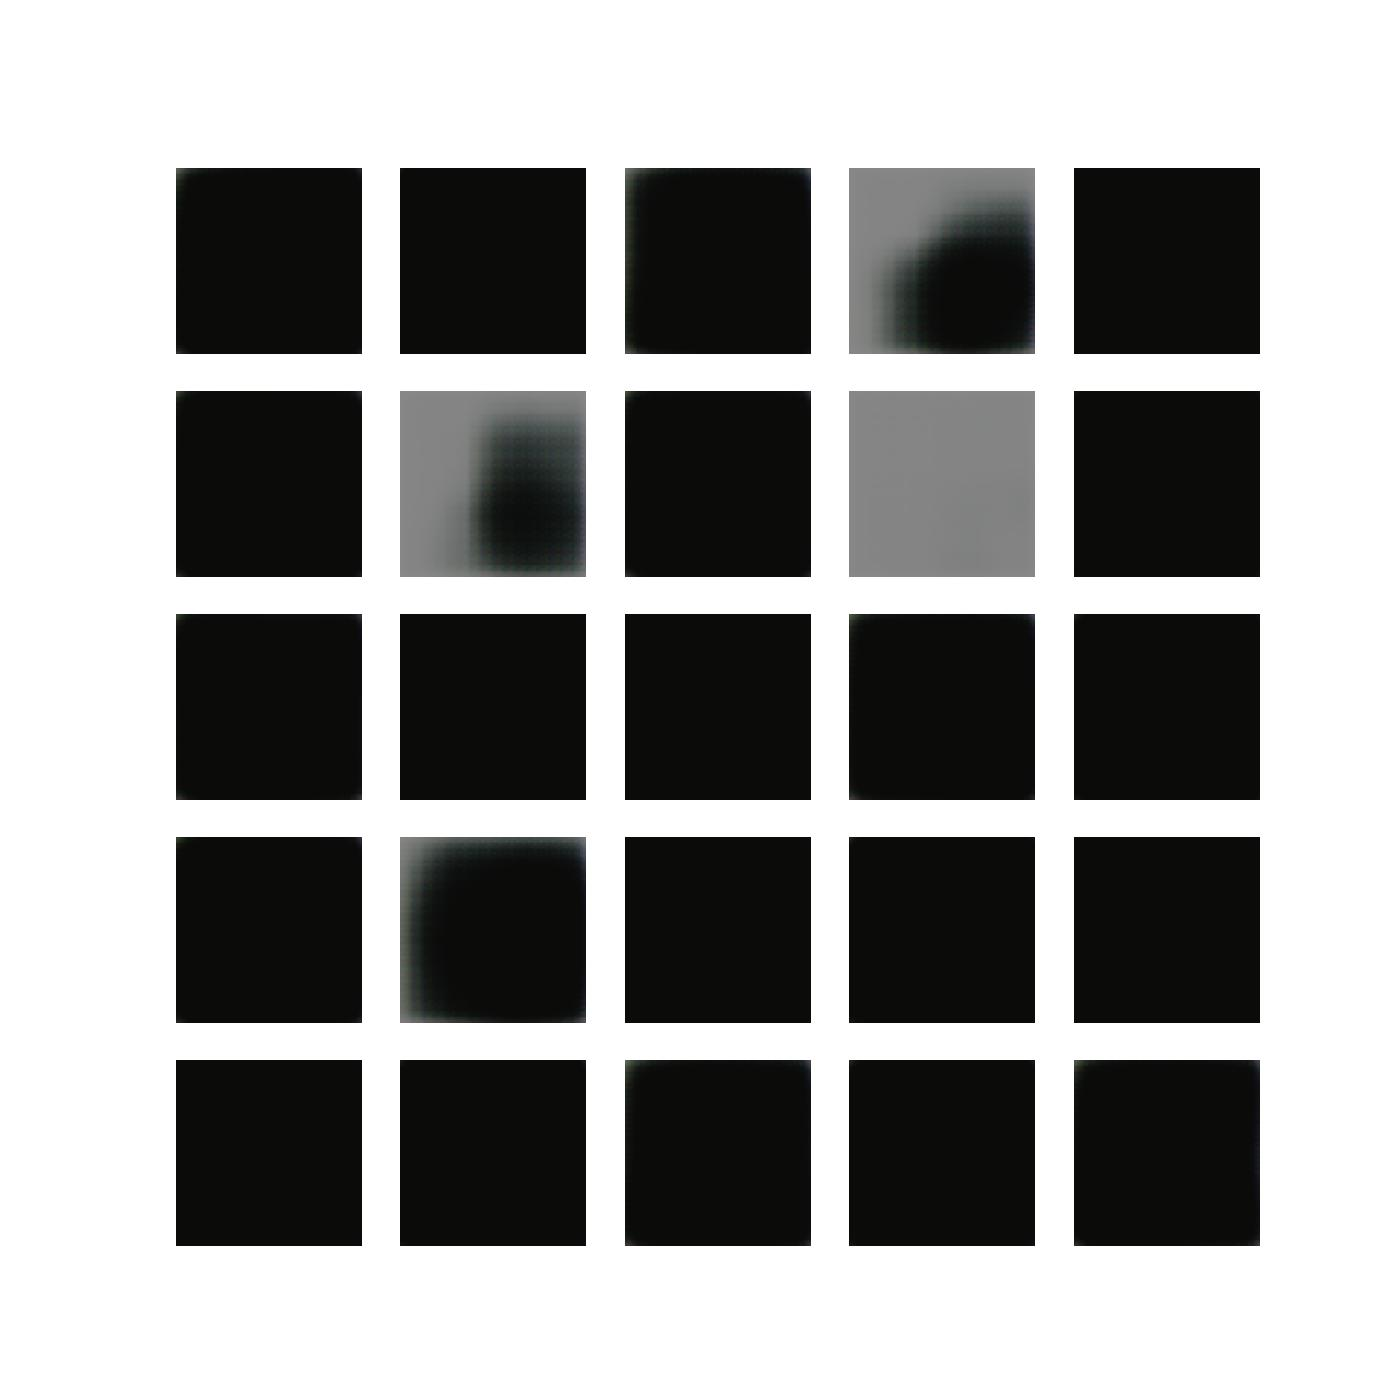

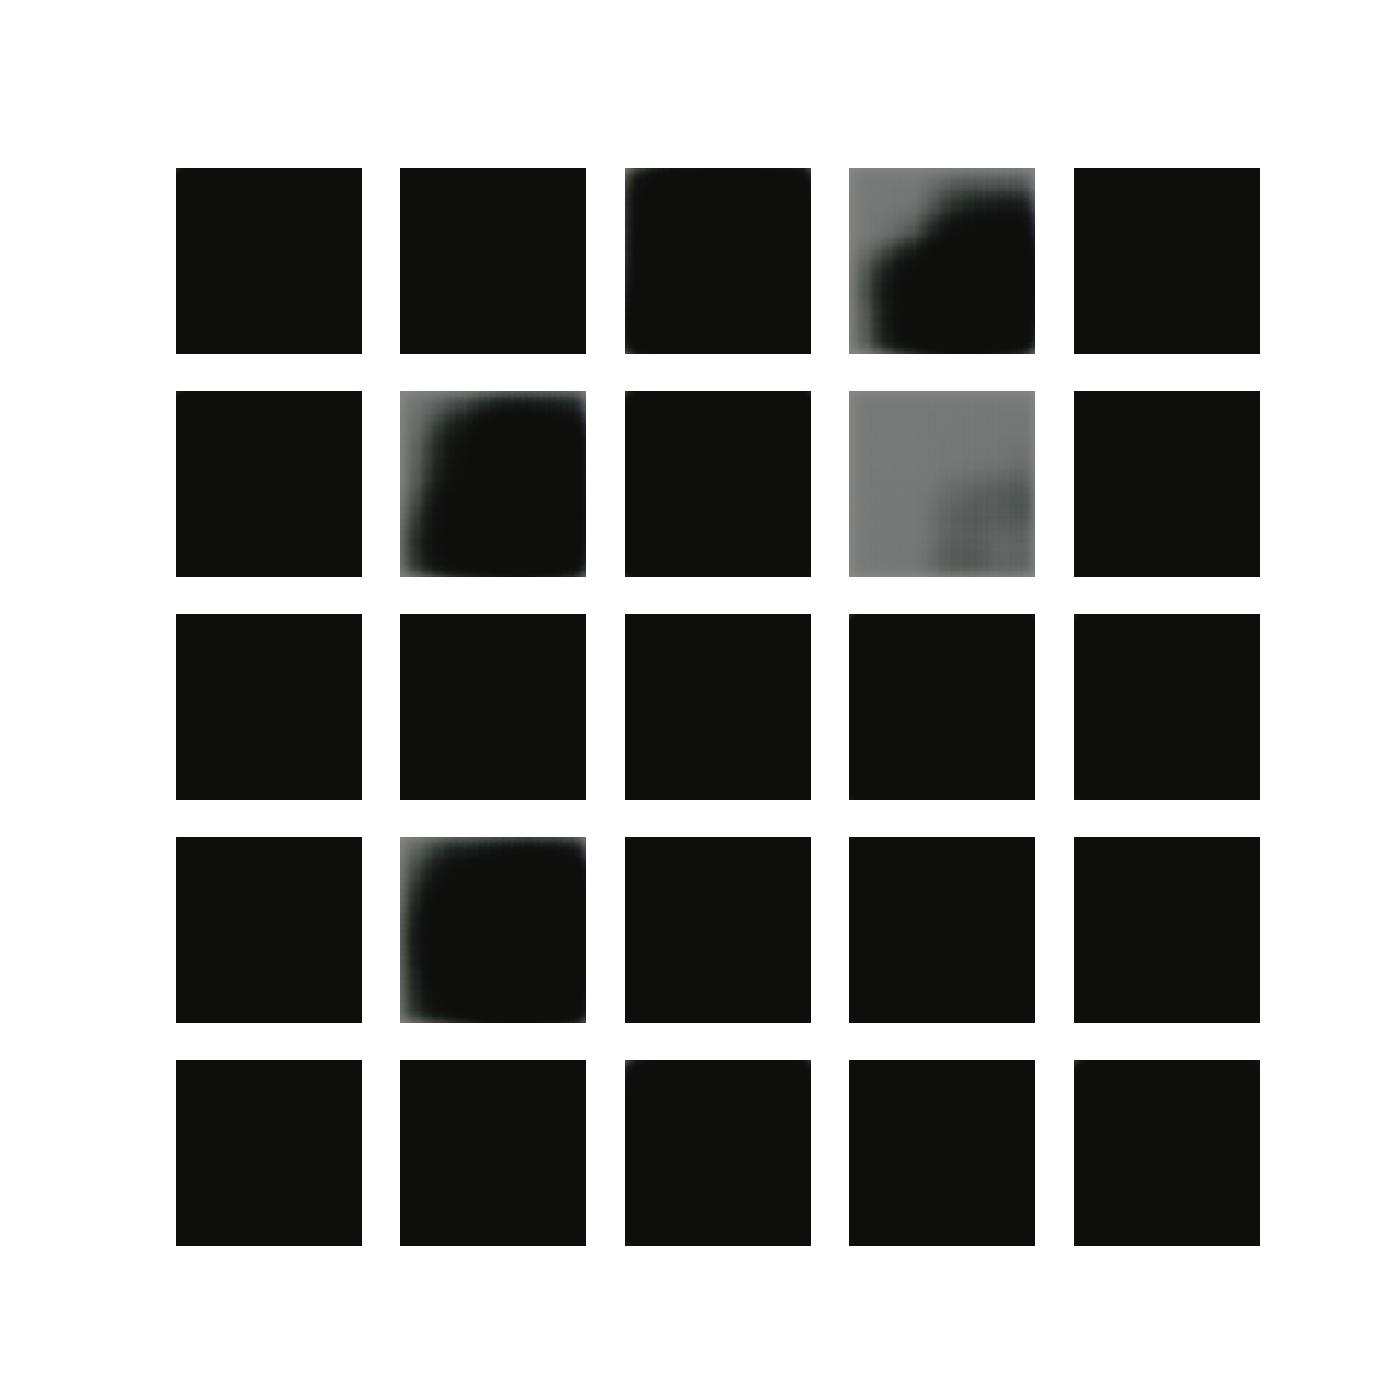

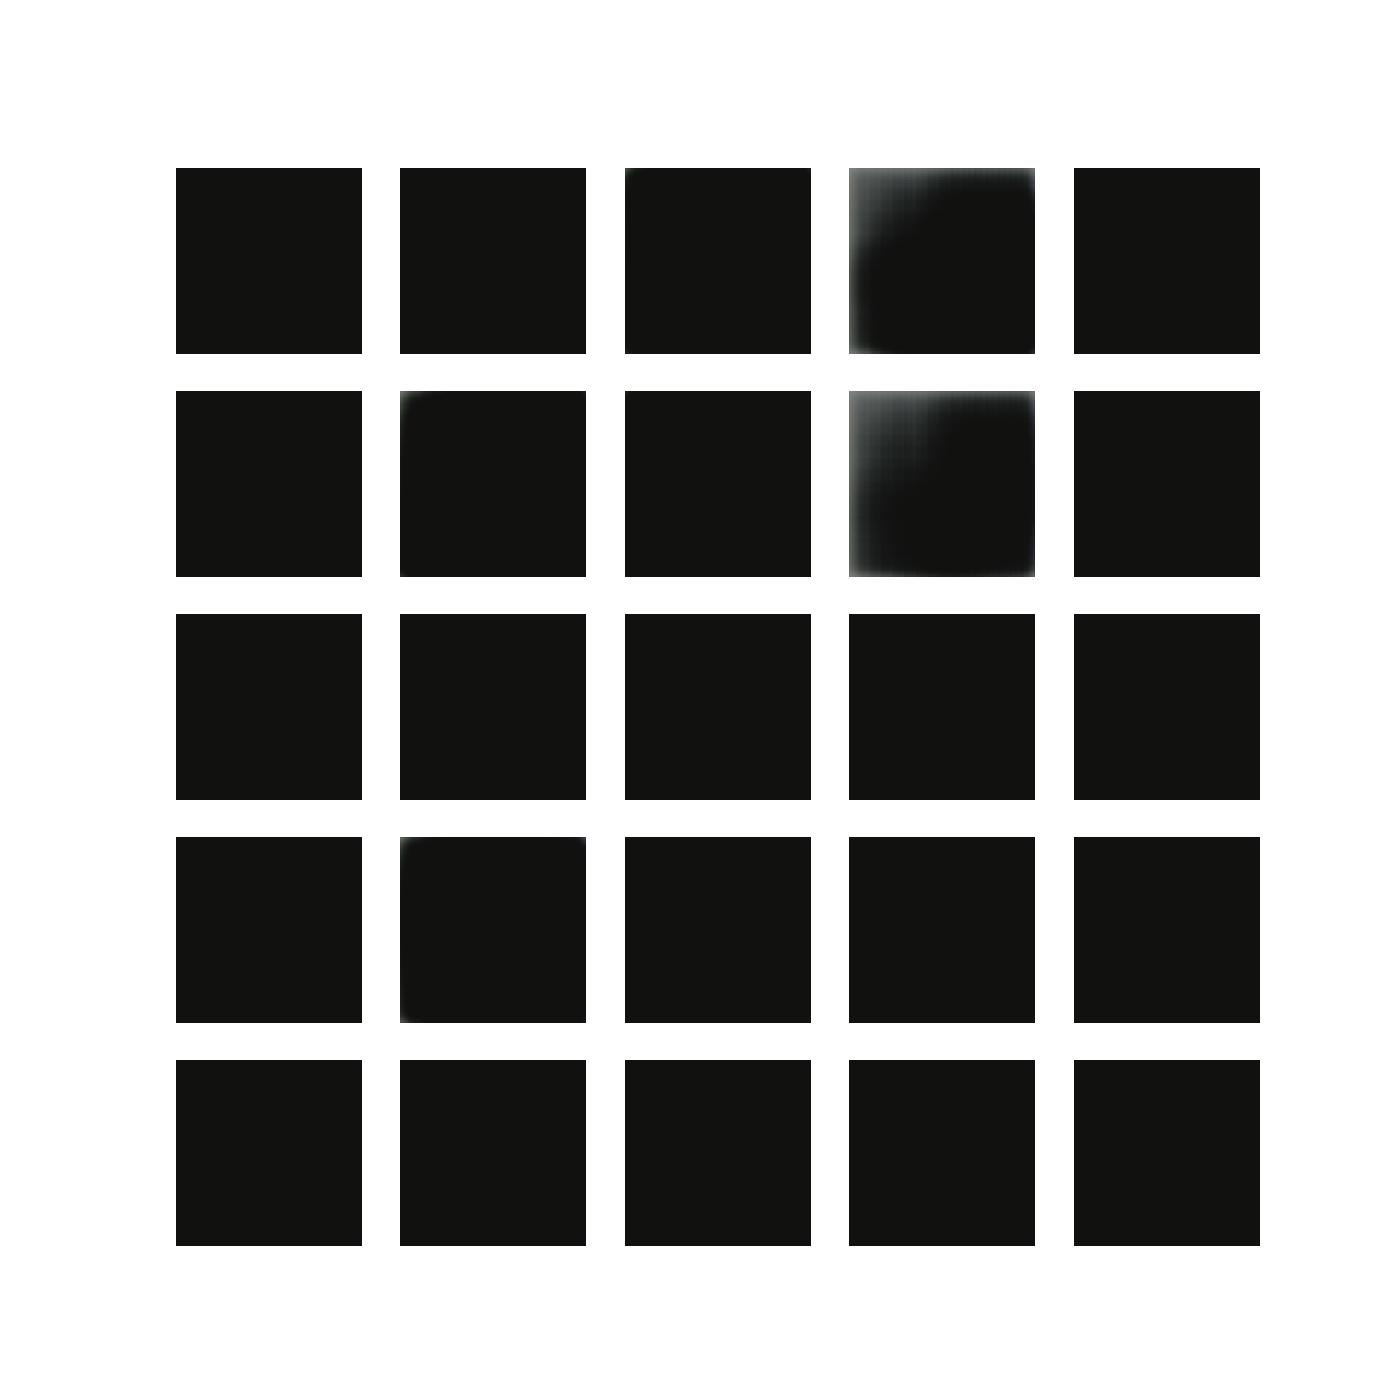

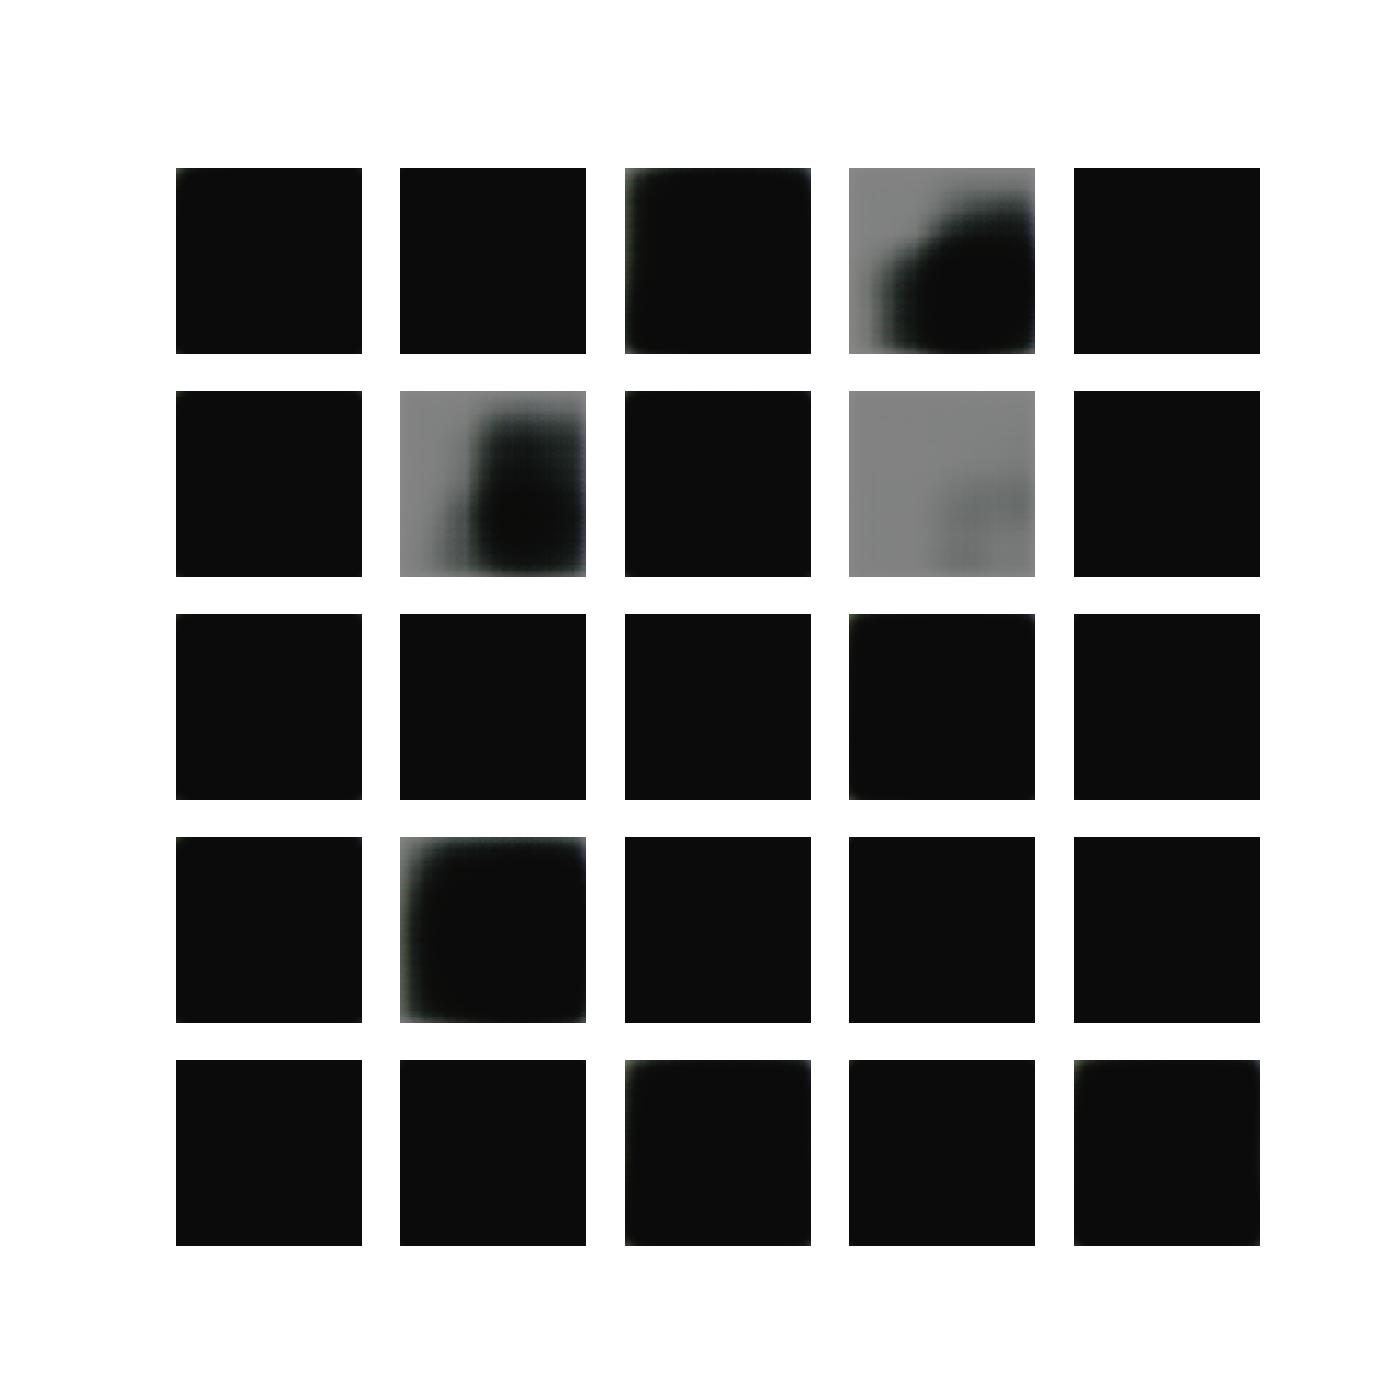

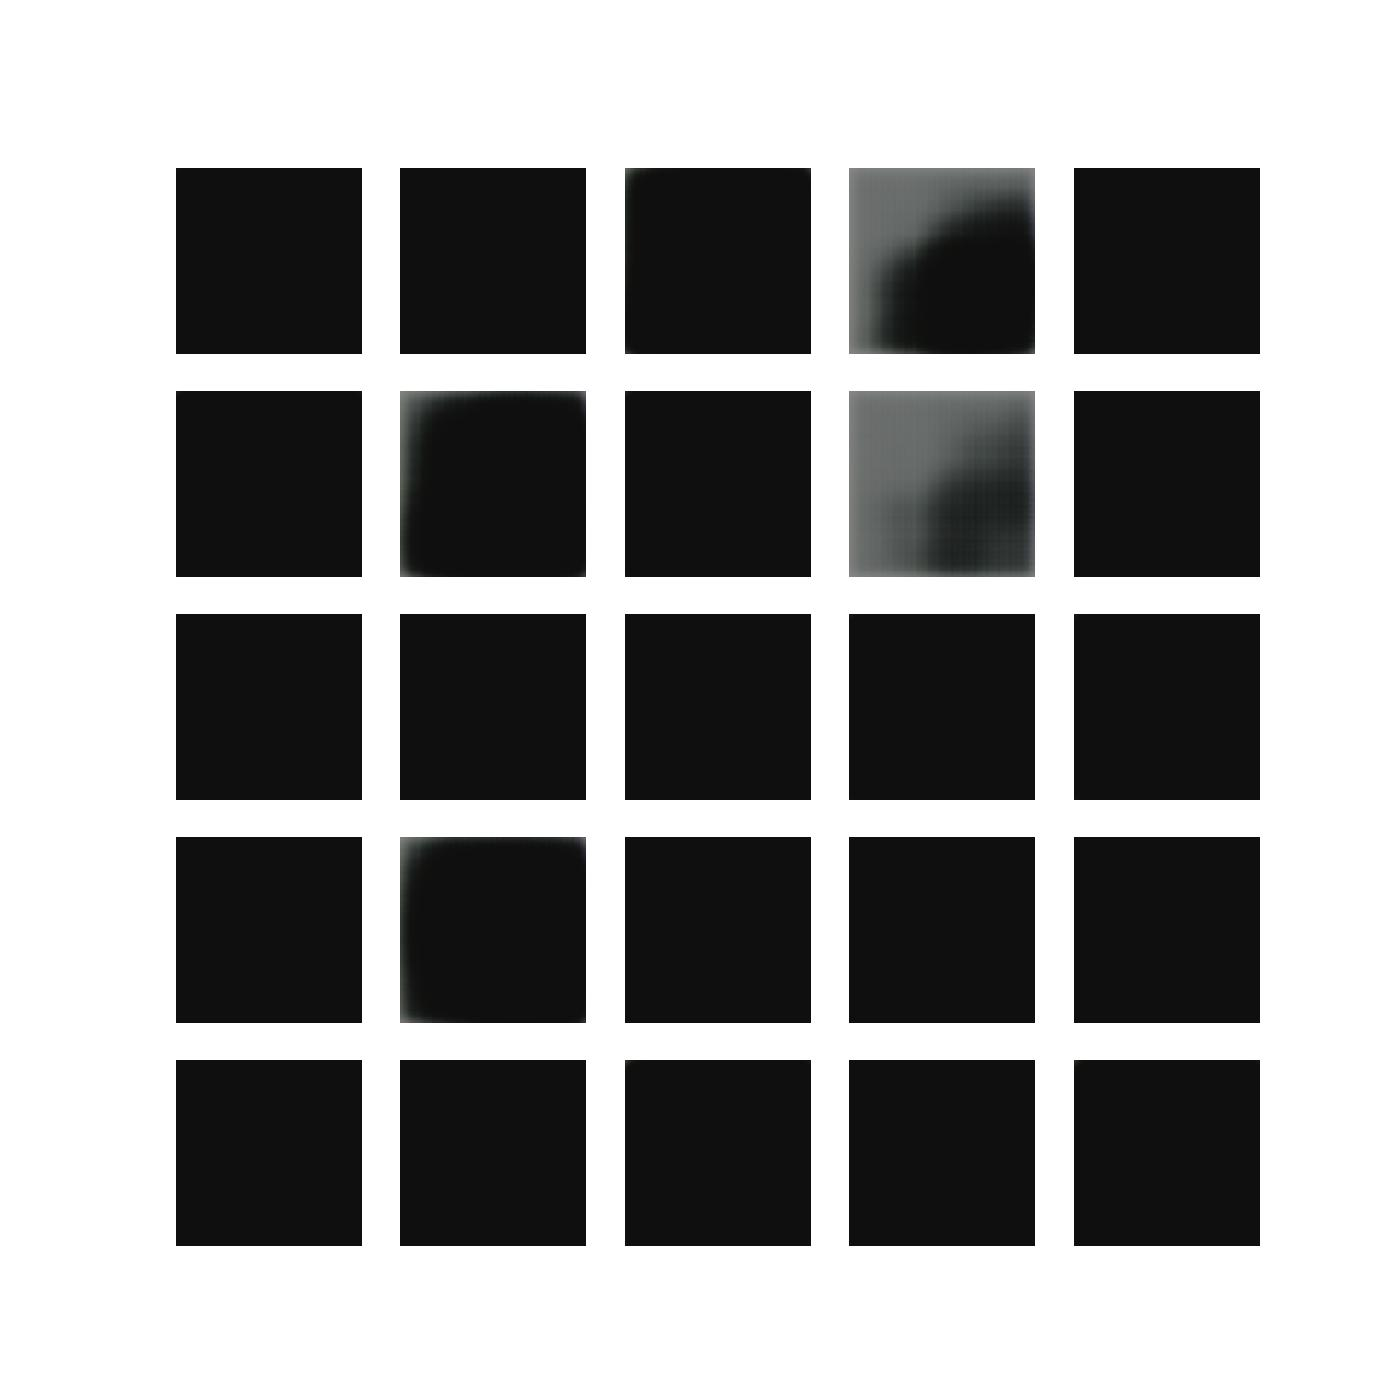

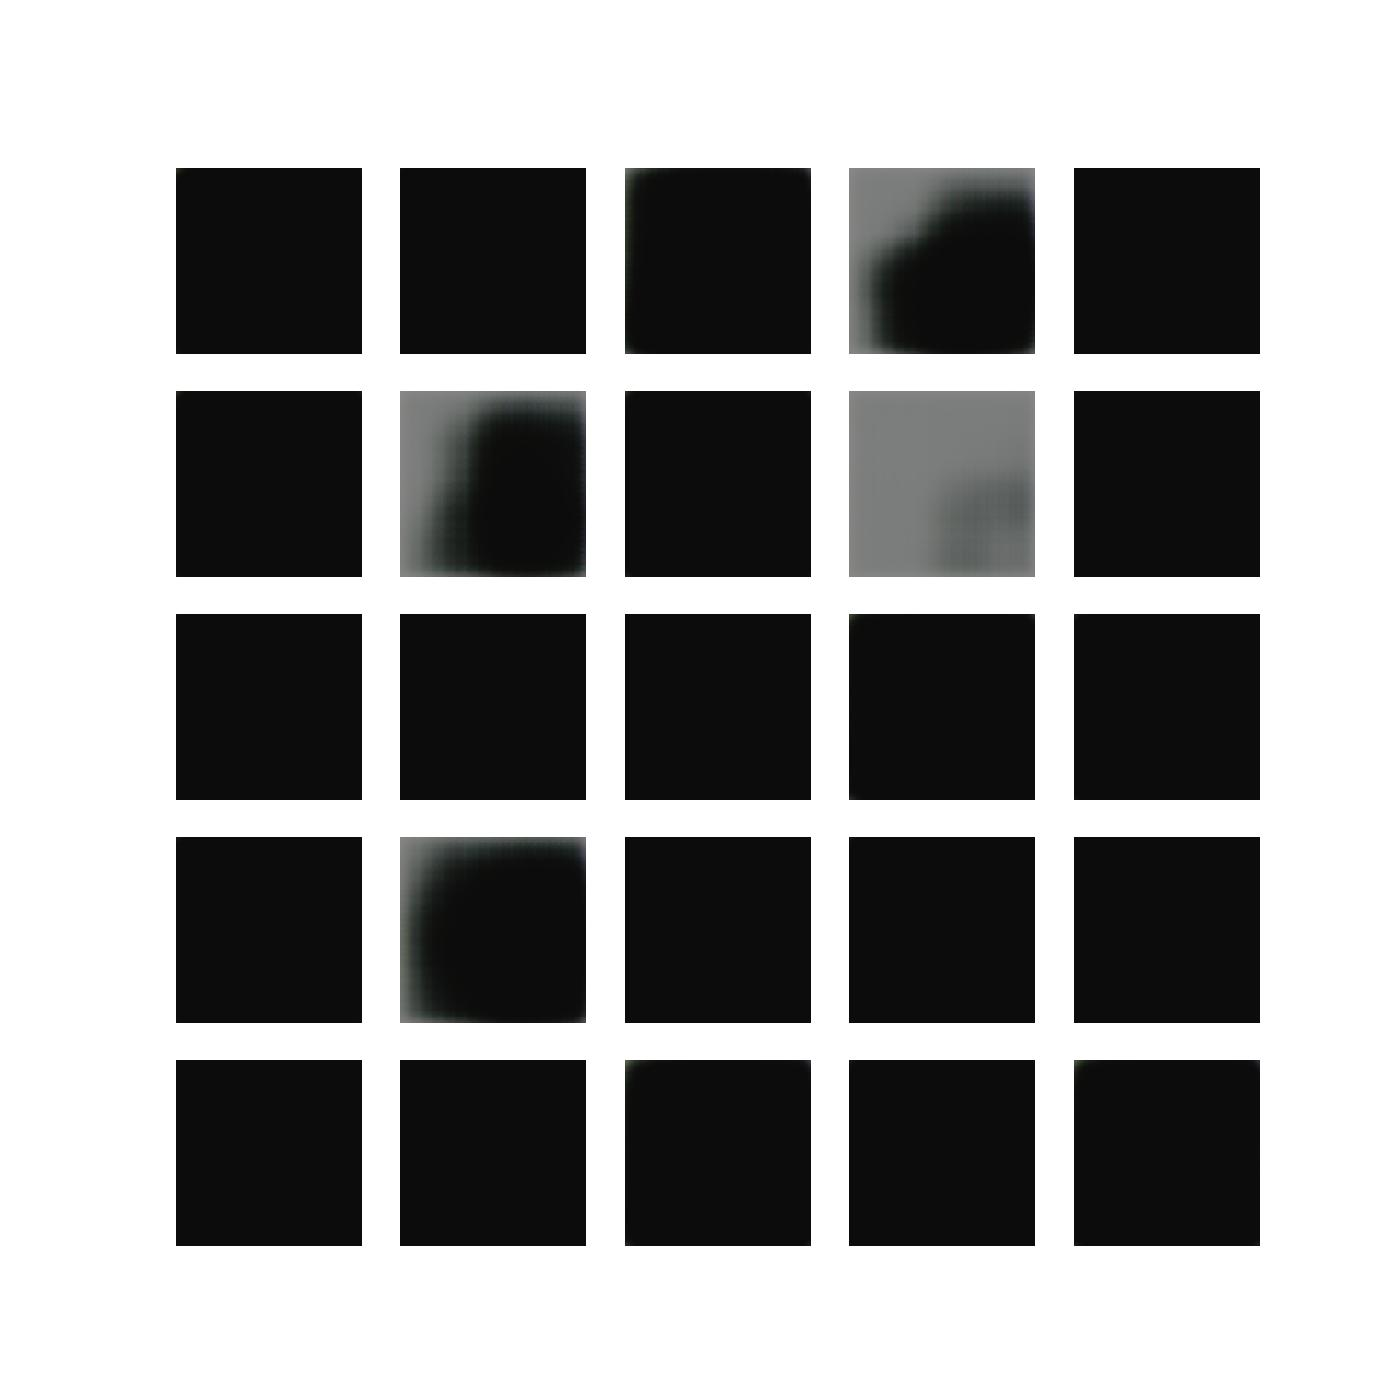

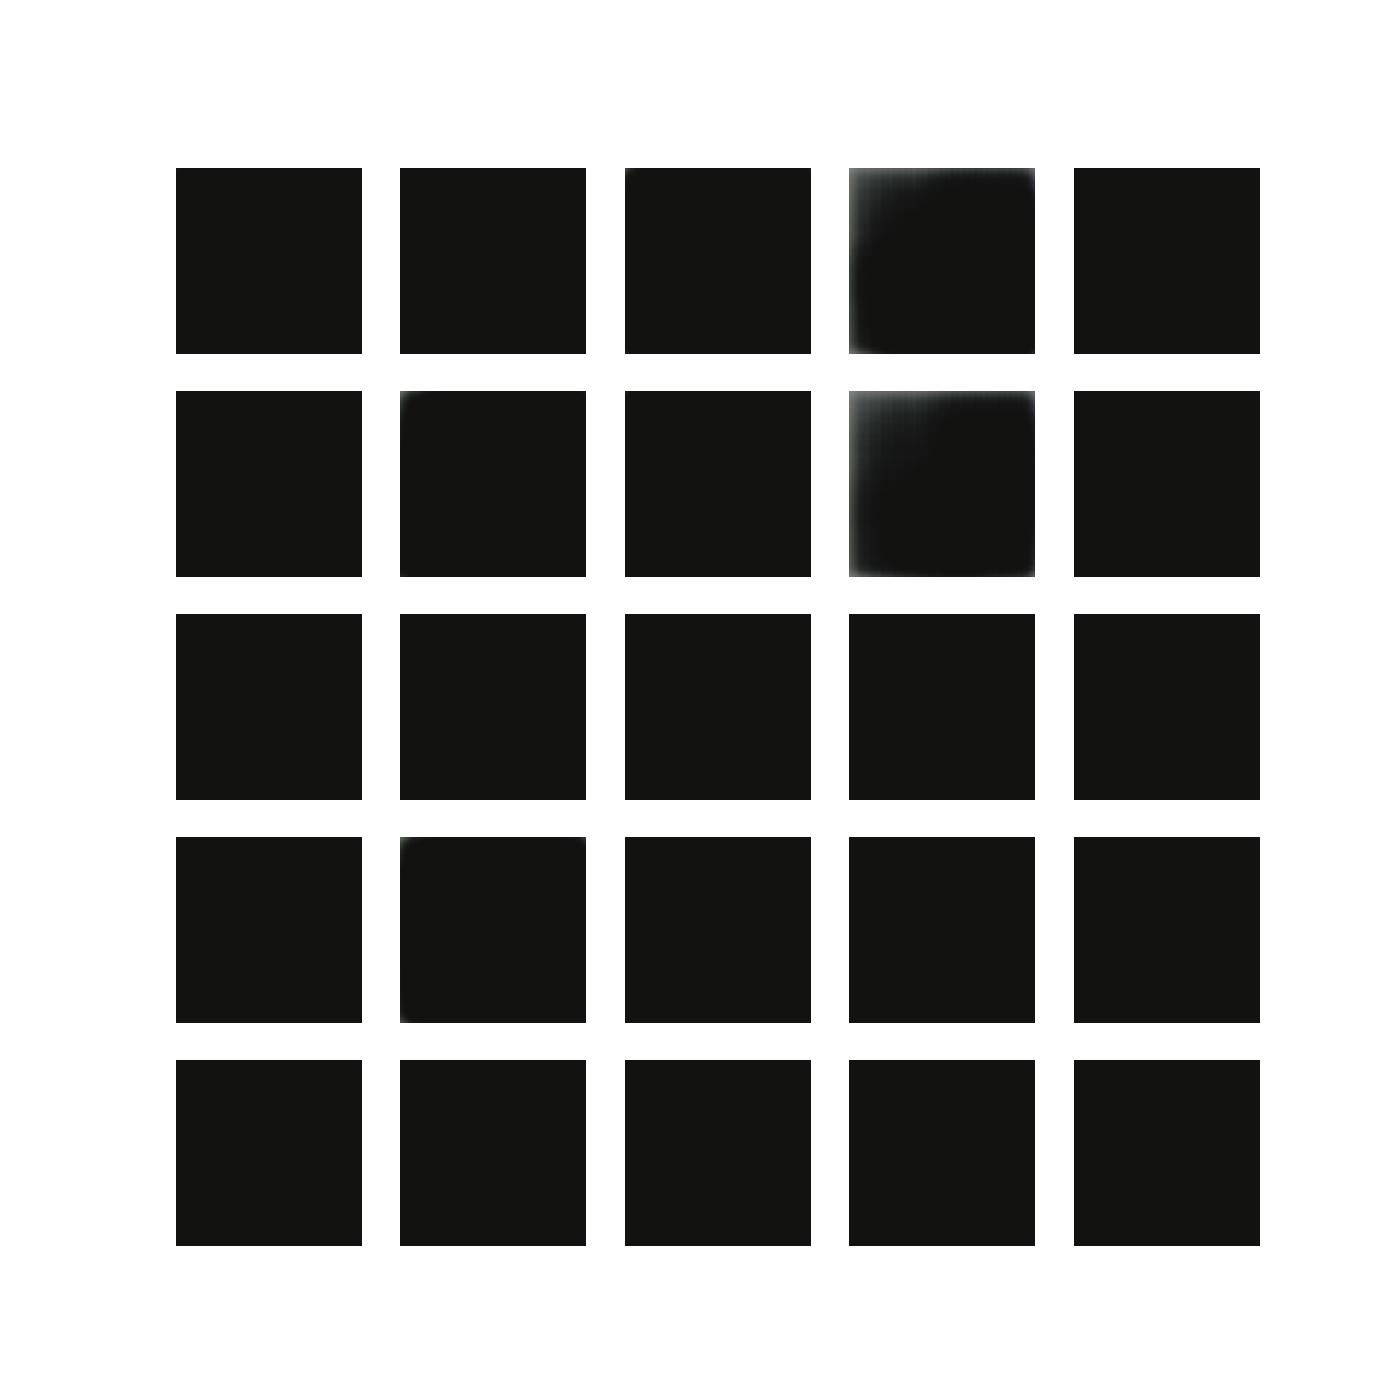

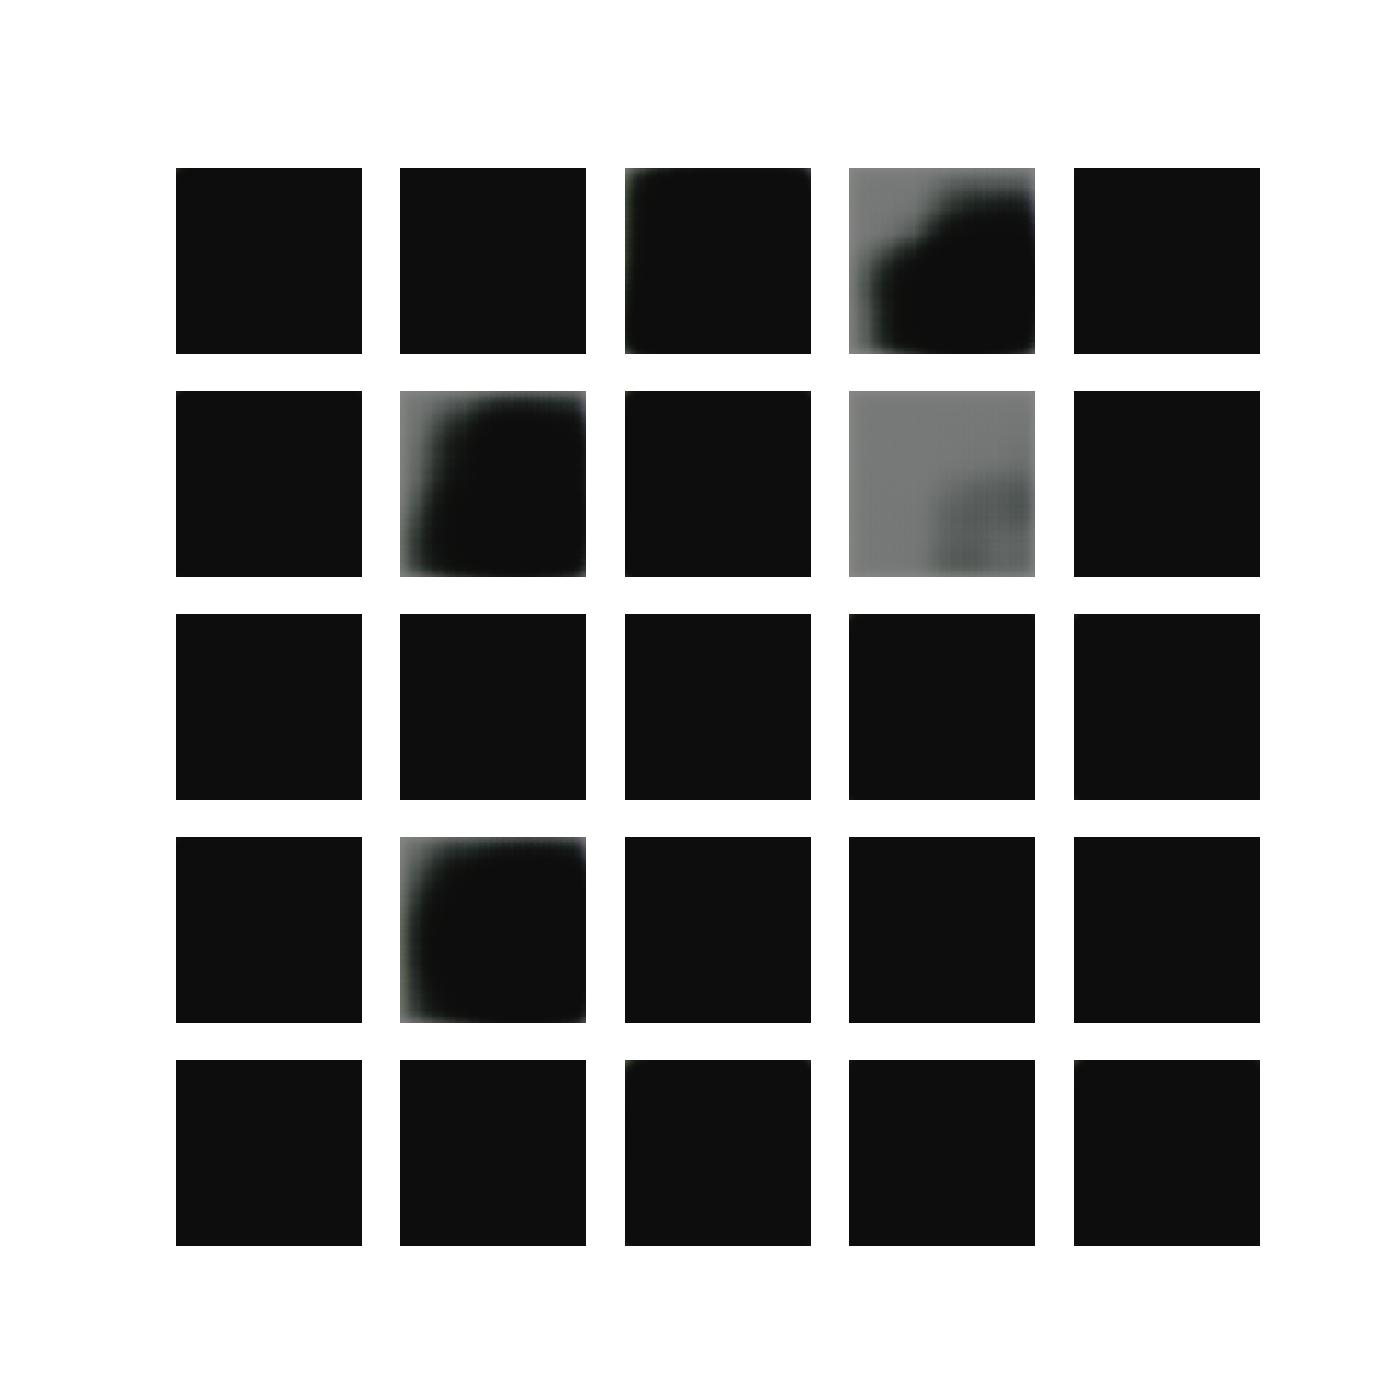

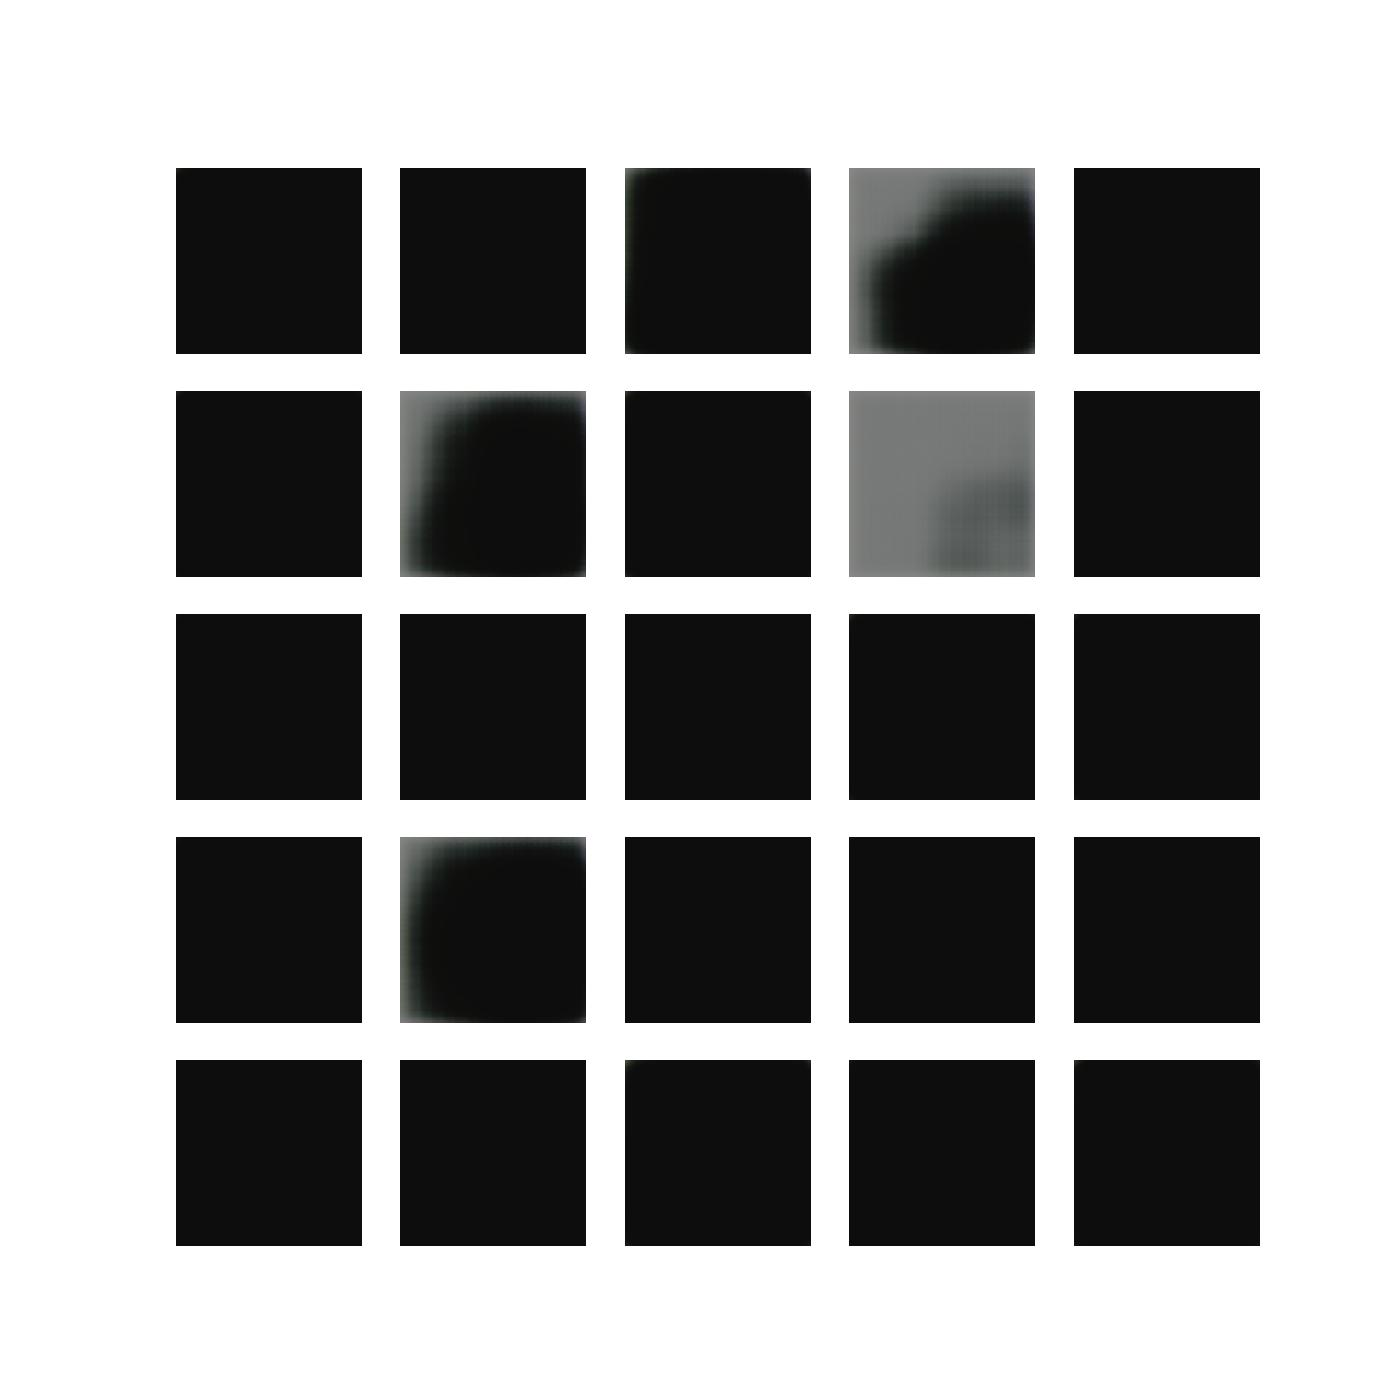

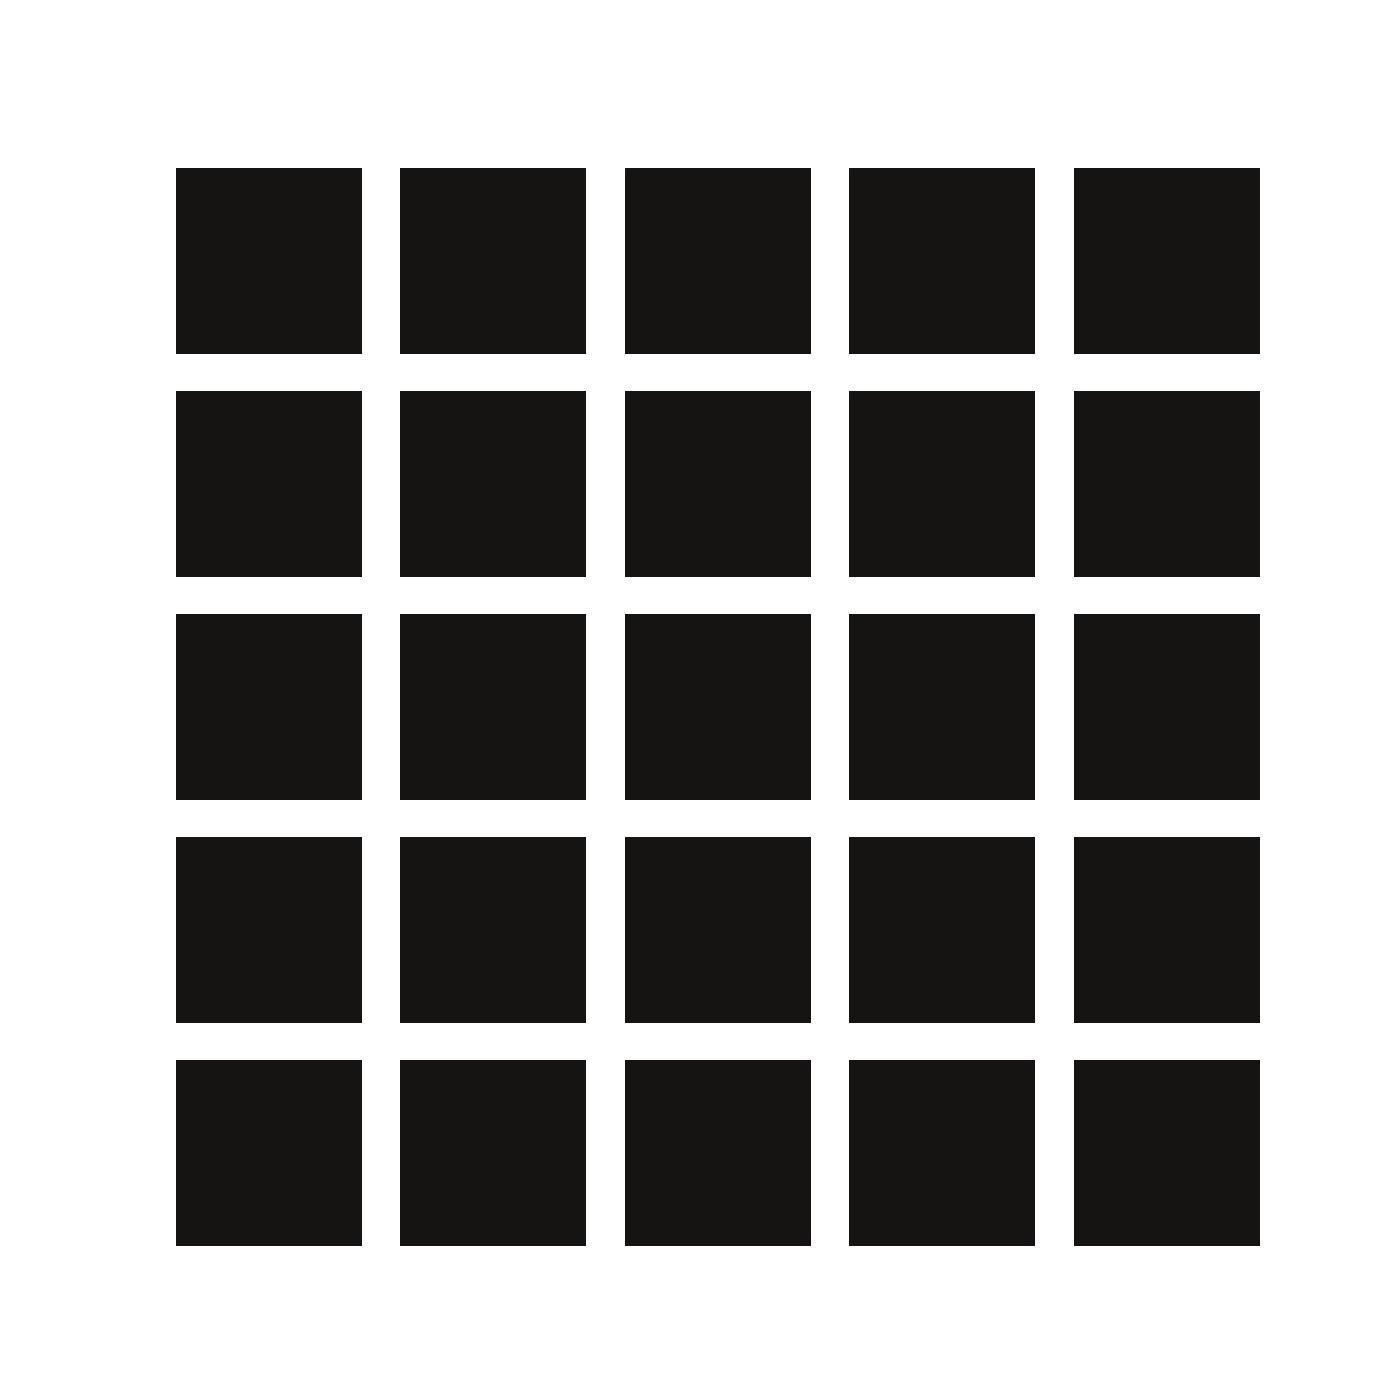

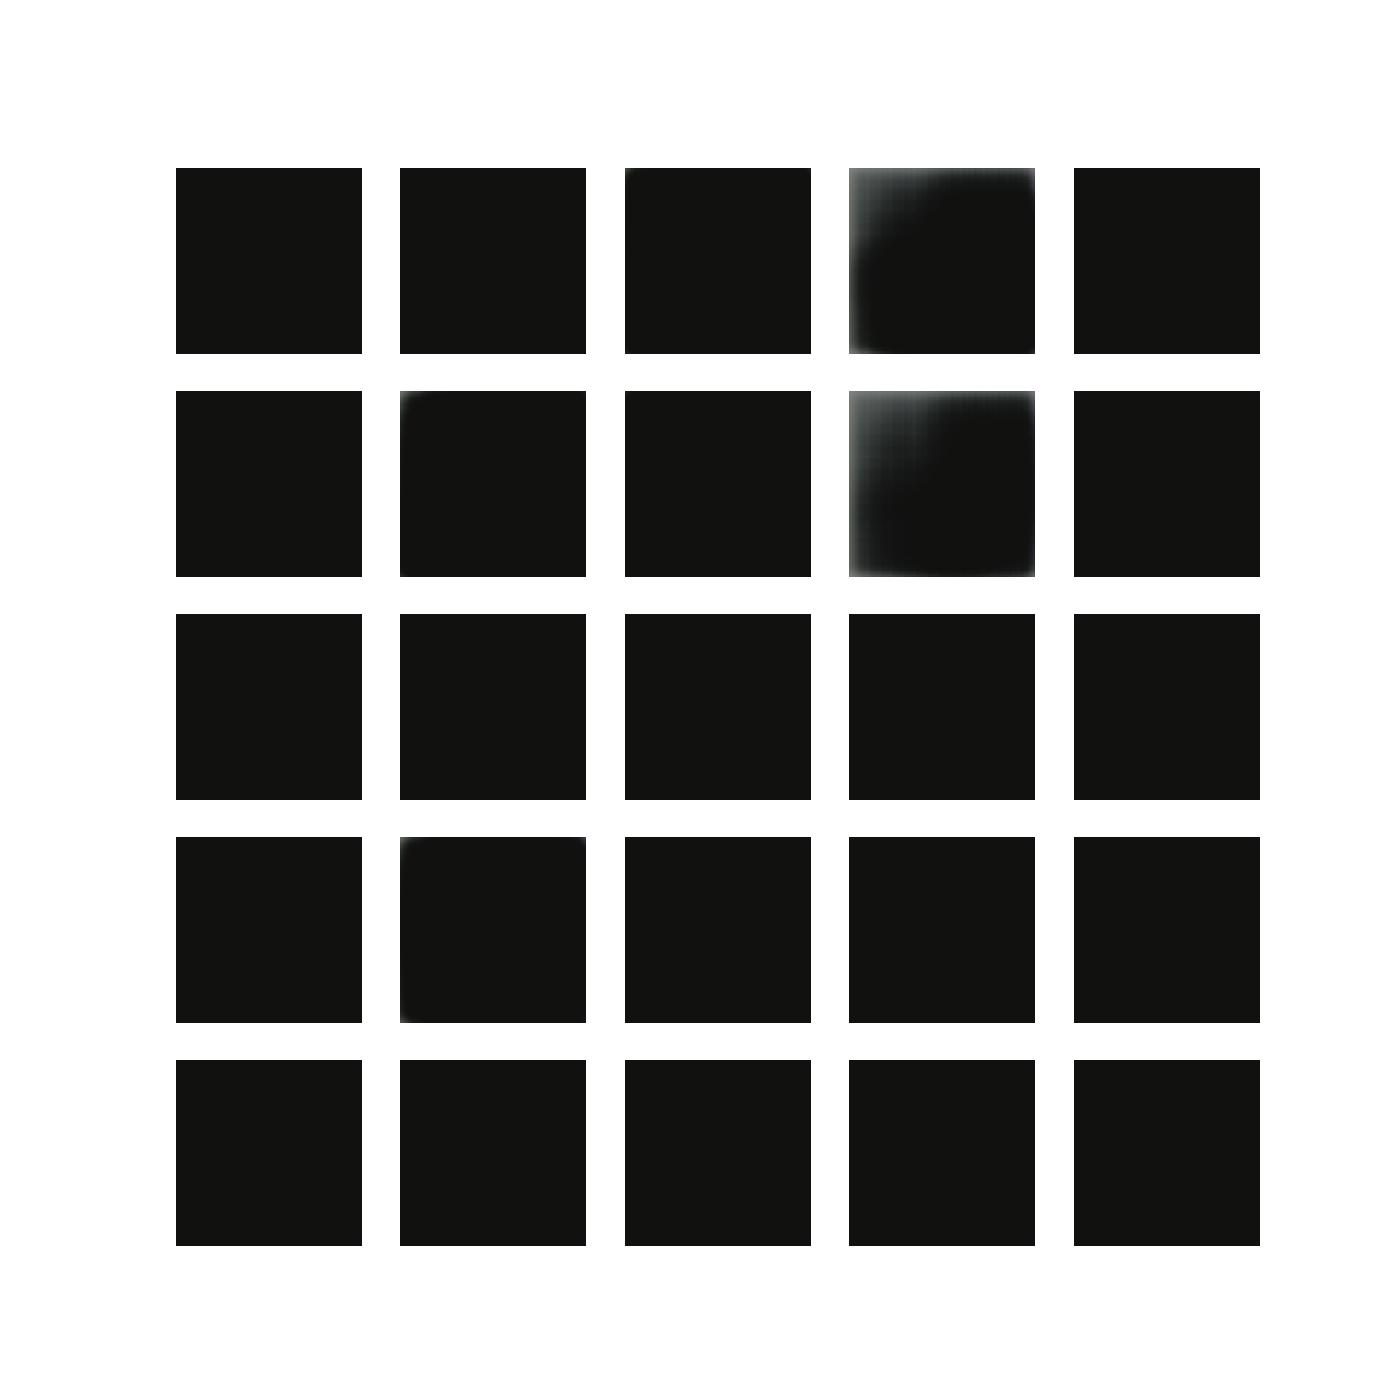

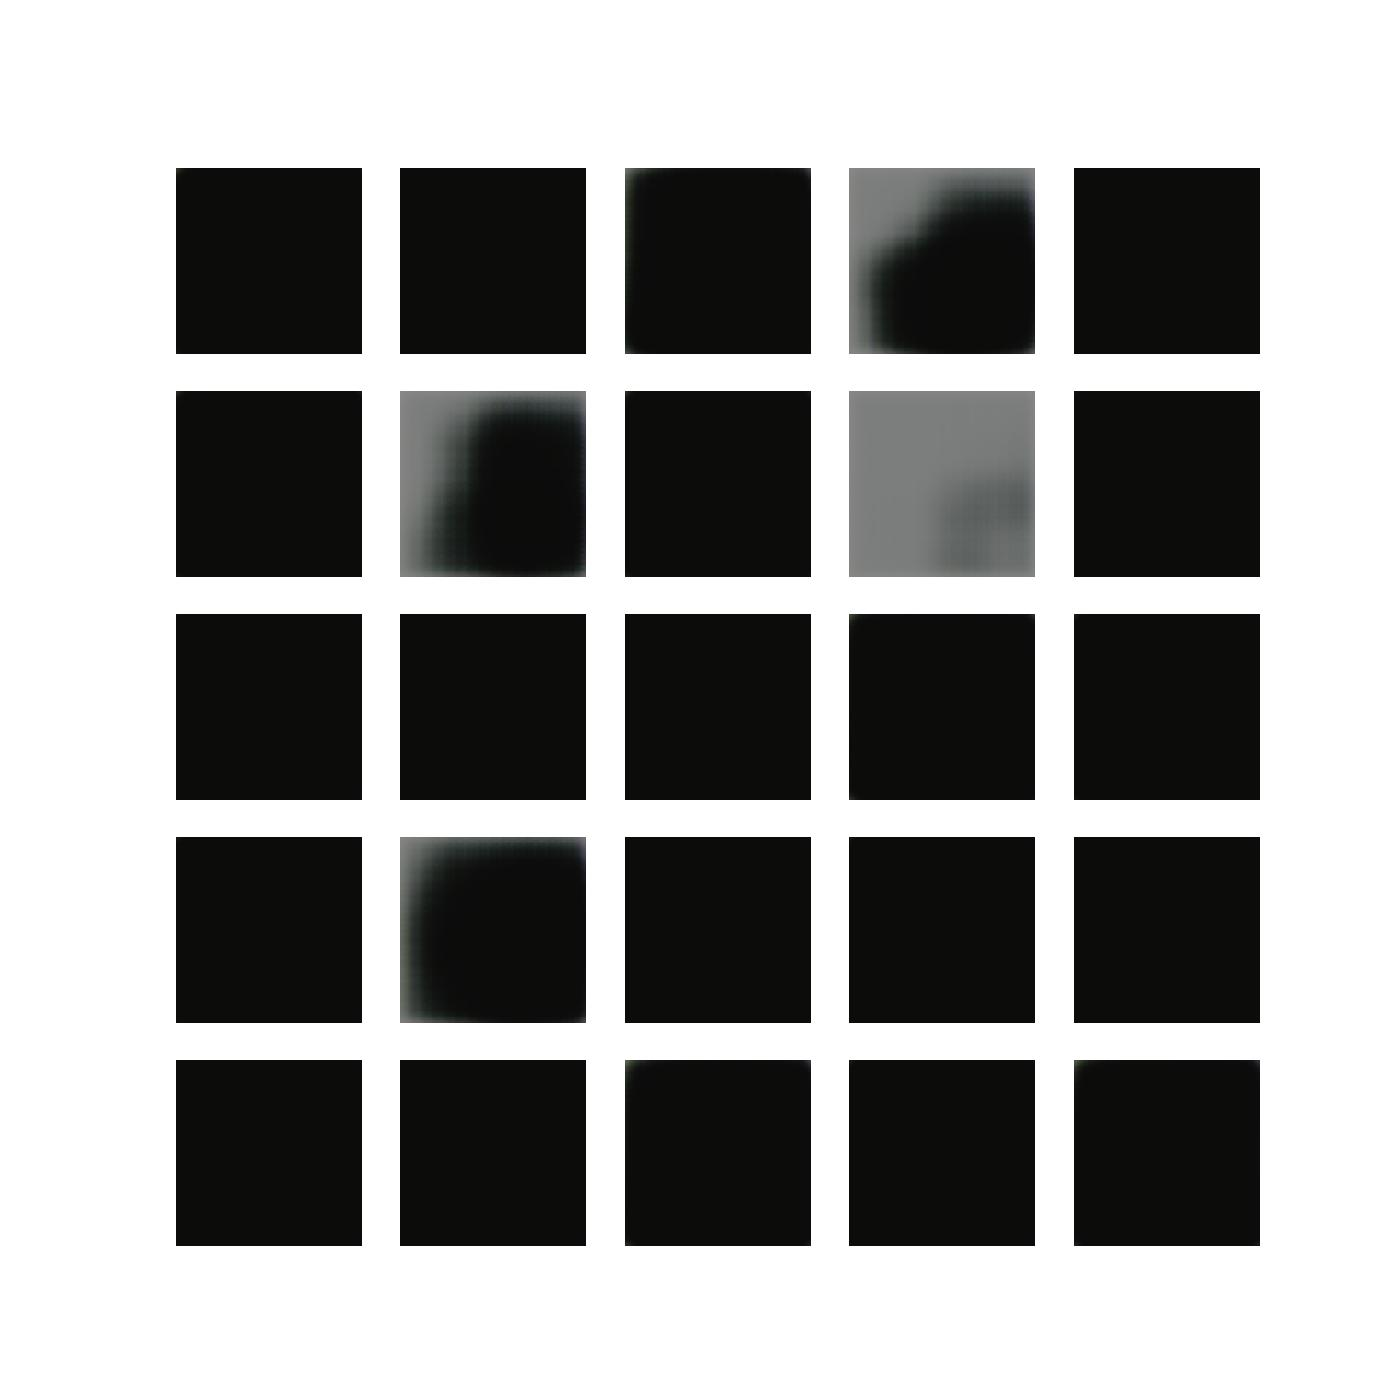

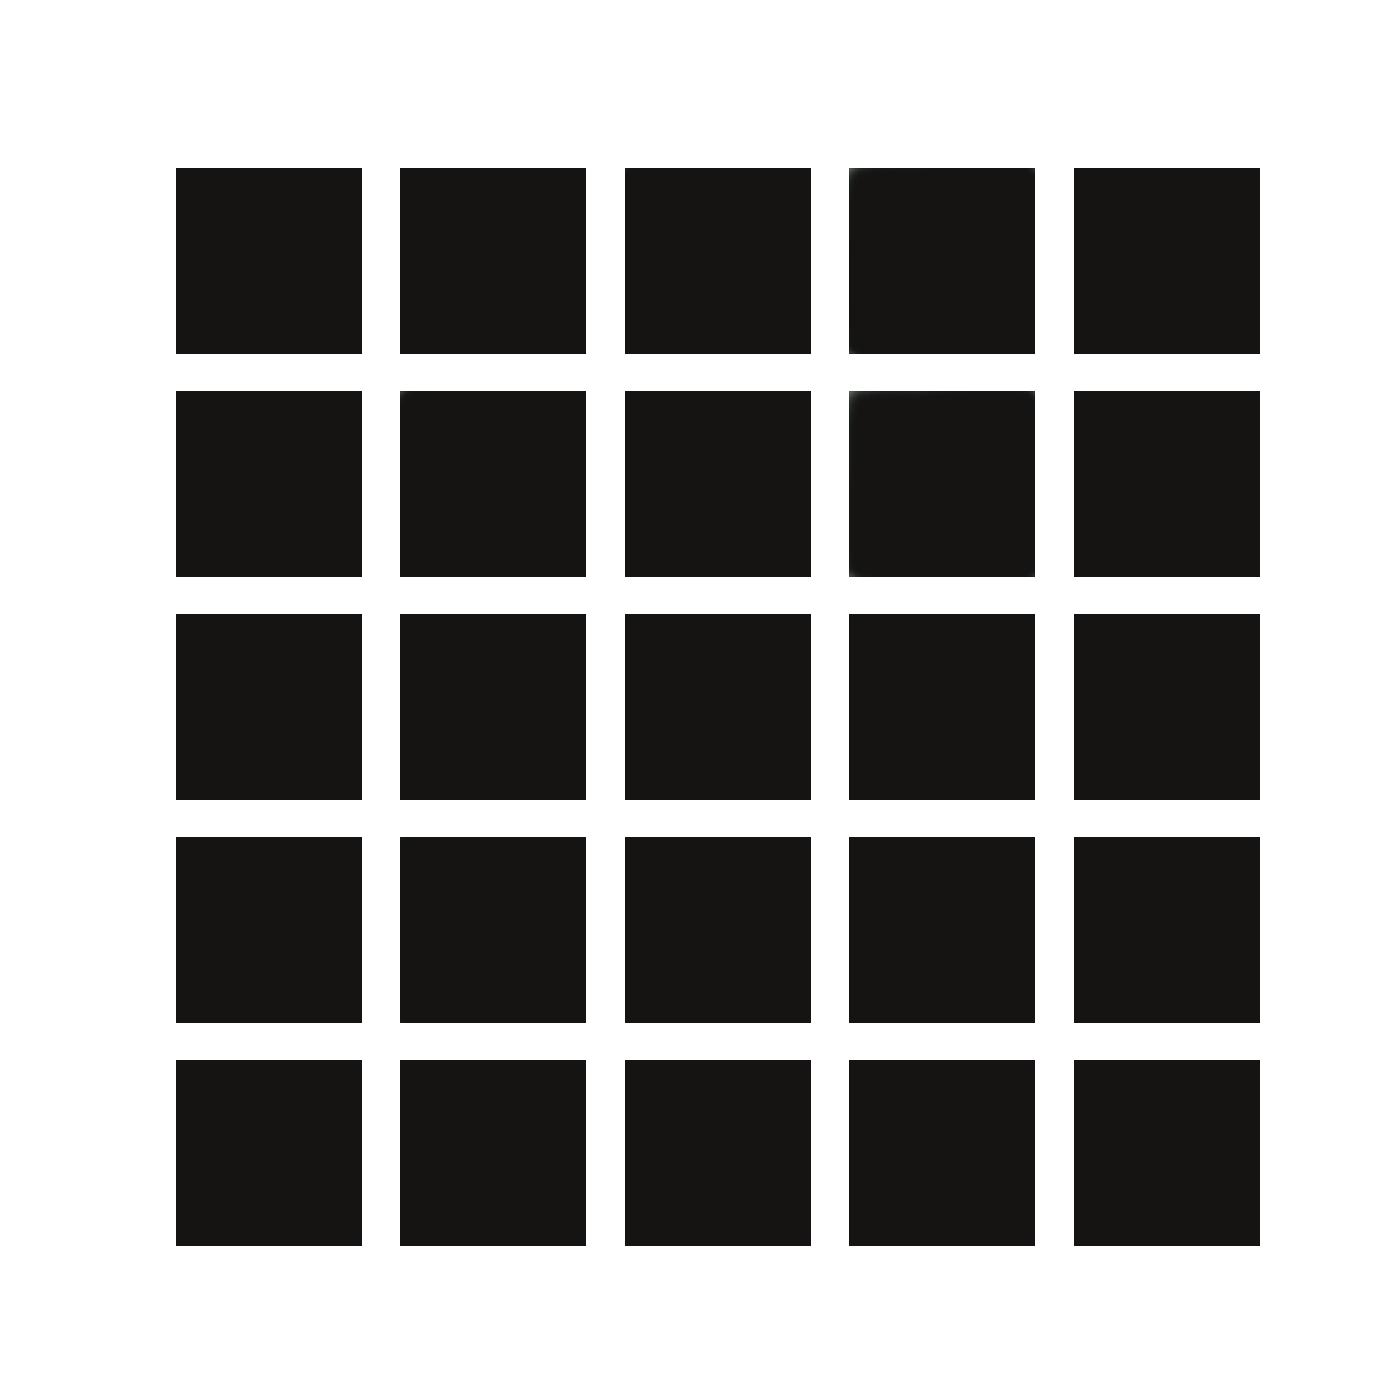

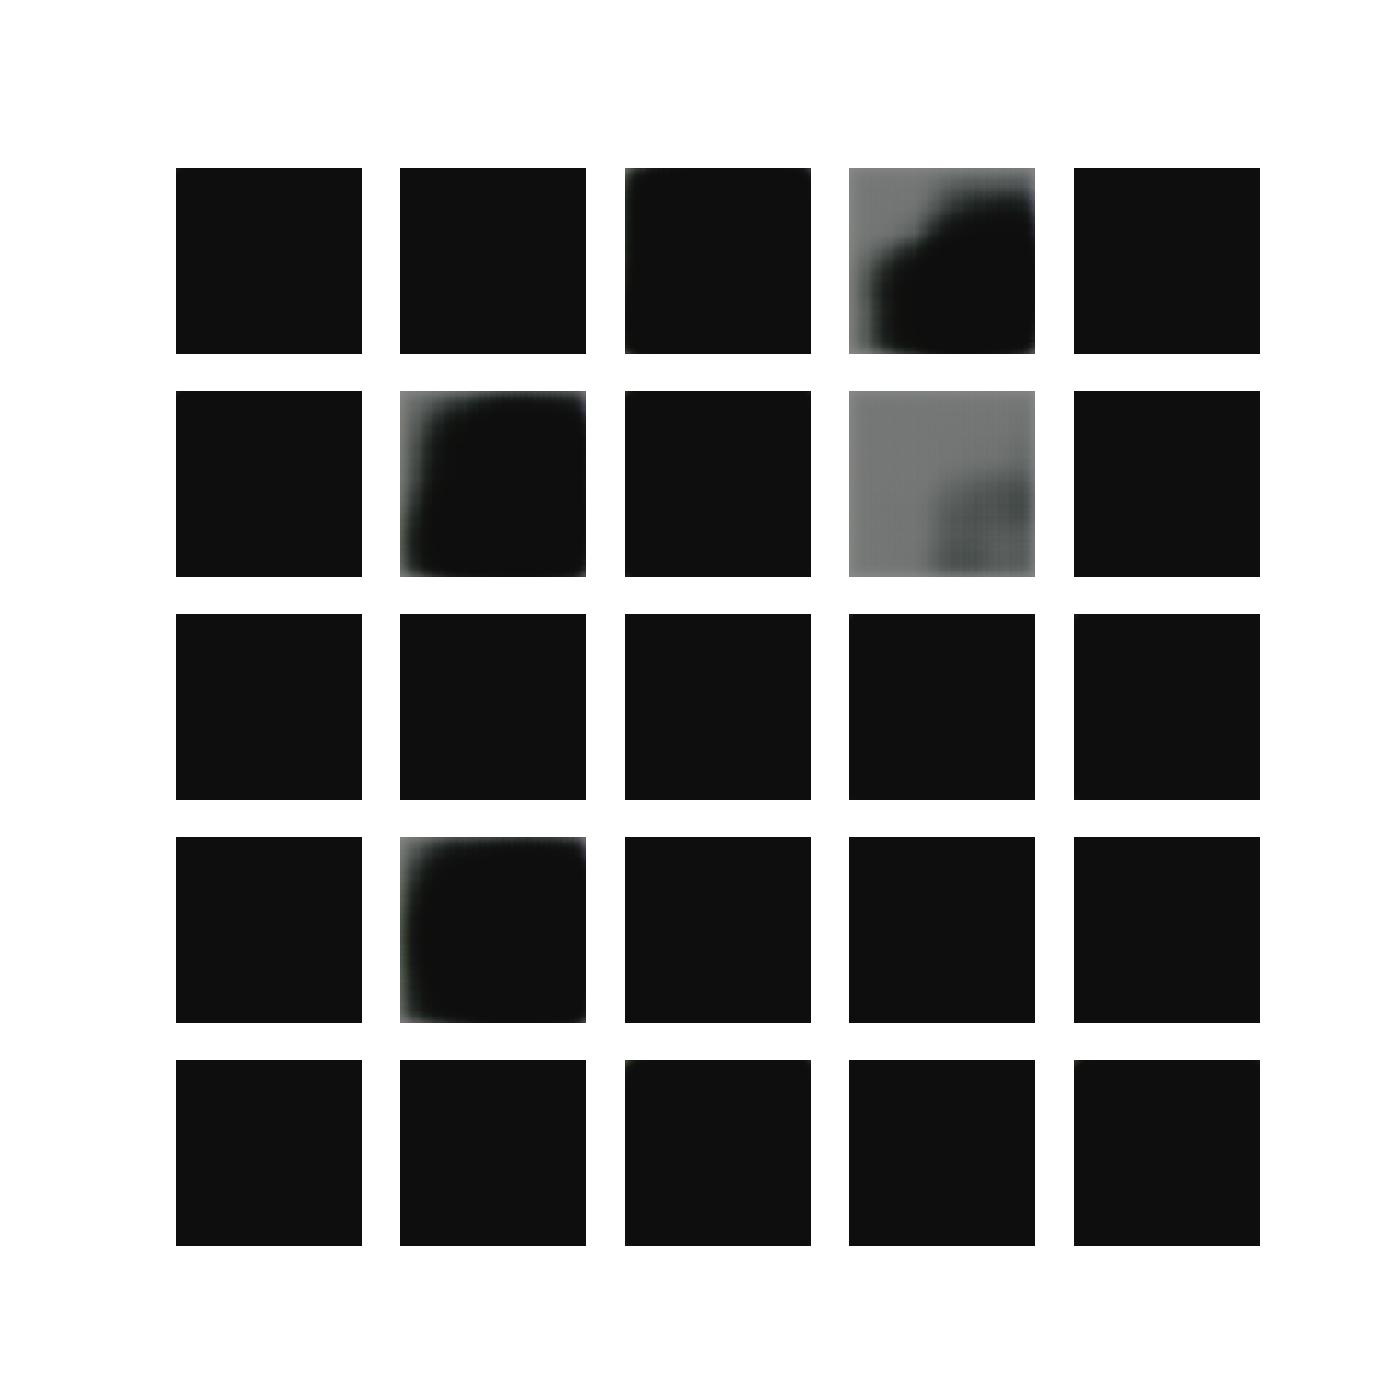

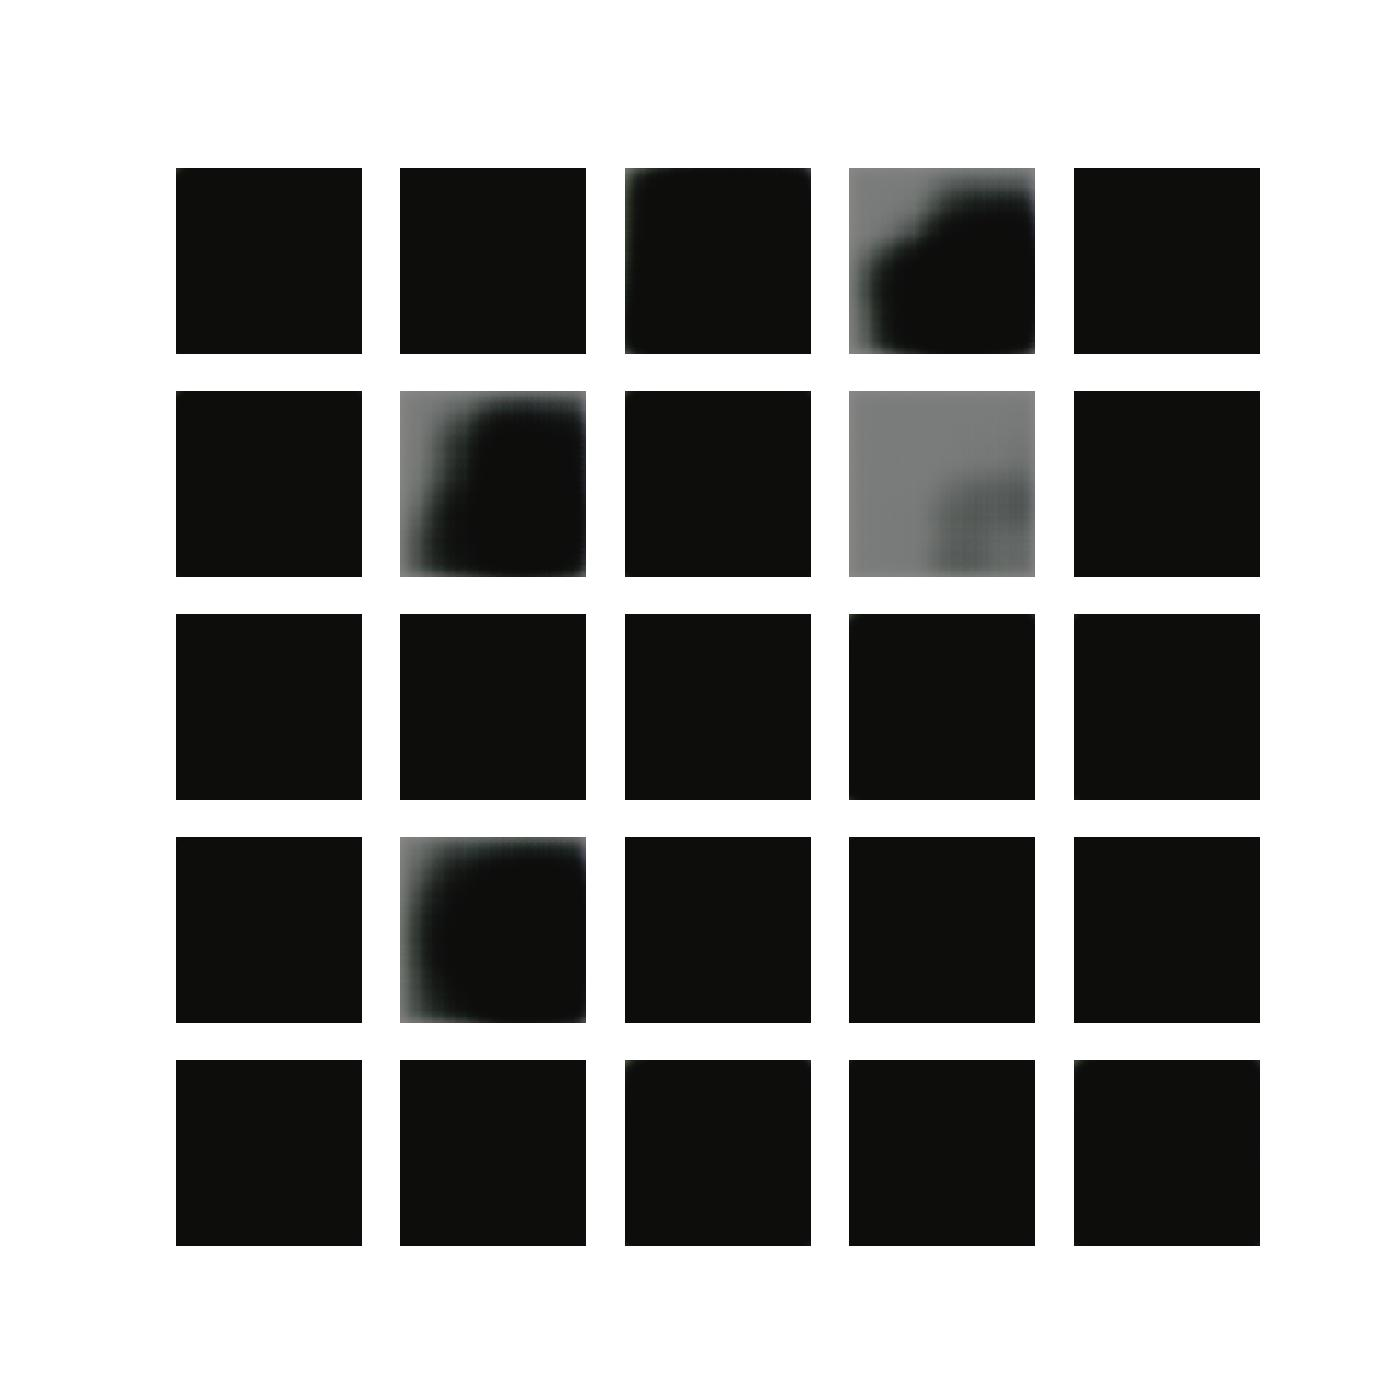

In [46]:
from google.colab.patches import cv2_imshow
import cv2
import os

output_dir = "output/"
files = os.listdir(output_dir)

for file in files:
    image = cv2.imread(os.path.join(output_dir, file))
    cv2_imshow(image)
    if cv2.waitKey(1) and 0xFF == ord('q'):
      break